<a href="https://colab.research.google.com/github/hawa1983/DATA-612/blob/main/Copy_of_Copy_of_Project_2_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Description

The dataset is a subset of the **MovieLens** dataset, a benchmark dataset provided by GroupLens for building and evaluating recommender systems.

It consists of two main components:

1. **`movies` DataFrame**
   This contains metadata about each movie. Each row includes a unique `movieId`, the `title` (e.g., *Toy Story (1995)*), and a pipe-separated list of `genres` (e.g., *Adventure|Animation|Children|Comedy|Fantasy*).

2. **`ratings` DataFrame**
   This captures user interactions. Each entry includes a `userId`, a `movieId` (referring to a movie from the `movies` DataFrame), a numeric `rating` (from 0.5 to 5.0), and a `timestamp` representing when the rating was recorded.

Together, these datasets support both **collaborative filtering** (via user ratings) and **content-based filtering** (via genre metadata).


# Import Required Libraries

In [1]:
# This section imports all necessary libraries for data processing, similarity computation, evaluation, and visualization.
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


## **Exploratory Data Analysis and Implications for Recommender System Design**


Merged Data Sample:
   userId  movieId  rating    timestamp  \
0       1       17     4.0  944249077.0   
1       1       25     1.0  944250228.0   
2       1       29     2.0  943230976.0   
3       1       30     5.0  944249077.0   
4       1       32     5.0  943228858.0   

                                               title  \
0                       Sense and Sensibility (1995)   
1                           Leaving Las Vegas (1995)   
2  City of Lost Children, The (Cité des enfants p...   
3  Shanghai Triad (Yao a yao yao dao waipo qiao) ...   
4          Twelve Monkeys (a.k.a. 12 Monkeys) (1995)   

                                   genres  
0                           Drama|Romance  
1                           Drama|Romance  
2  Adventure|Drama|Fantasy|Mystery|Sci-Fi  
3                             Crime|Drama  
4                 Mystery|Sci-Fi|Thriller  

--- Step 4: Print Summary ---
Number of Unique Users        : 50,845
Number of Unique Movies       : 56,517
Total Possi

/tmp/ipython-input-3-2701851998.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=merged_df, palette='Set2')


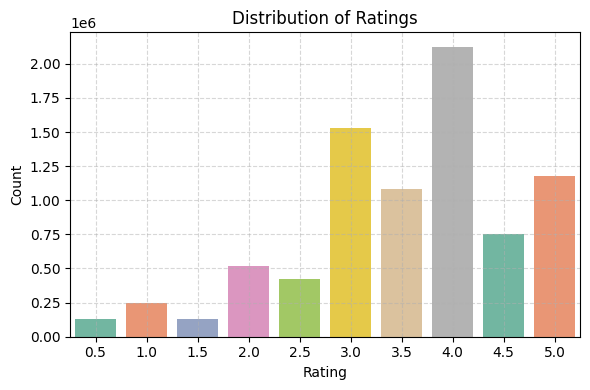

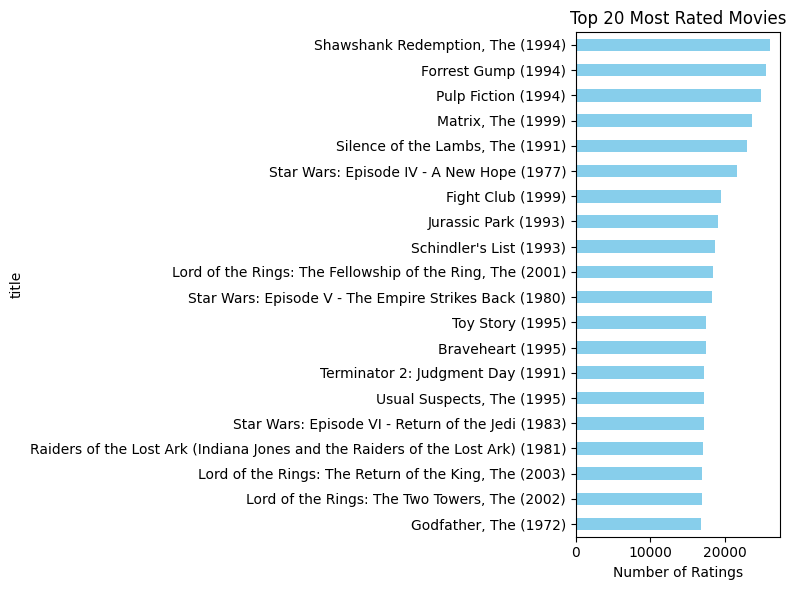

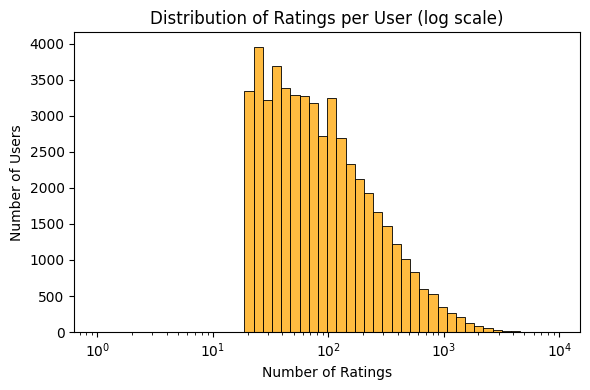

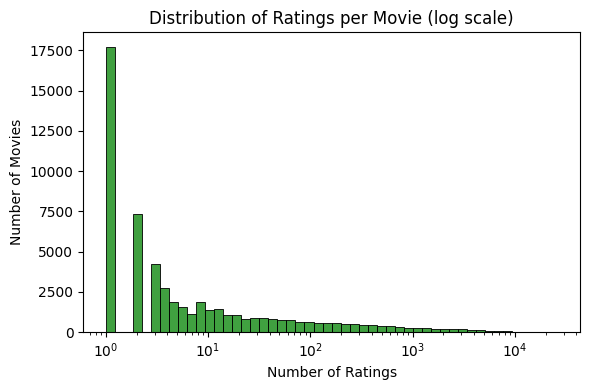

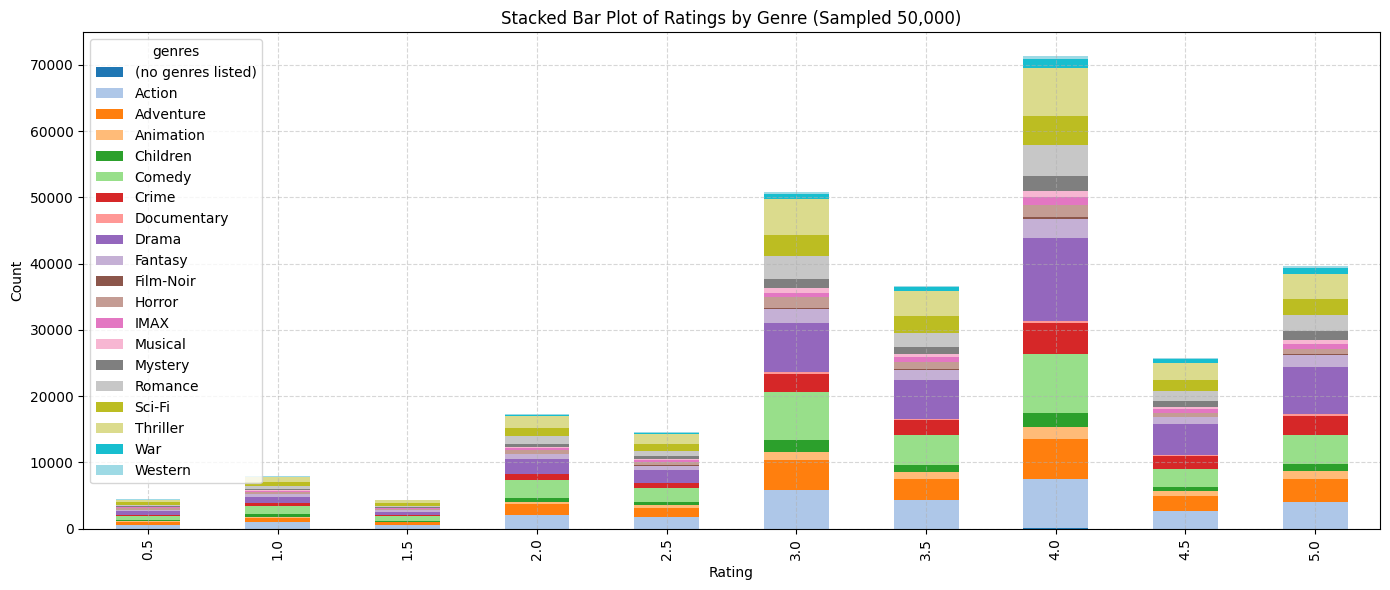

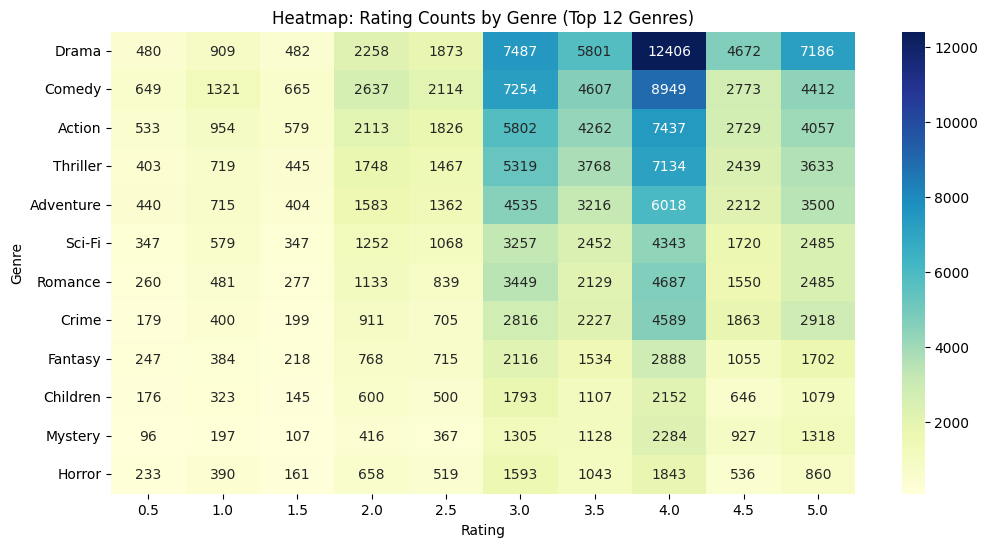

In [3]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load Data
ratings = pd.read_csv('/content/ratings.csv')
movies = pd.read_csv('/content/movies.csv')

# Step 2: Merge Ratings and Movies on movieId
merged_df = pd.merge(ratings, movies, on='movieId', how='inner')

print("Merged Data Sample:")
print(merged_df.head())

# Step 3: Calculate Summary Stats
num_users = merged_df['userId'].nunique()
num_movies = merged_df['movieId'].nunique()
total_possible_ratings = num_users * num_movies
actual_ratings = len(merged_df)
density = (actual_ratings / total_possible_ratings) * 100

# Step 4: Print Summary
print("\n--- Step 4: Print Summary ---")
print(f"Number of Unique Users        : {num_users:,}")
print(f"Number of Unique Movies       : {num_movies:,}")
print(f"Total Possible Ratings        : {total_possible_ratings:,}")
print(f"Actual Ratings Present        : {actual_ratings:,}")
print(f"\nUser-Movie Matrix Density     : {density:.4f}%")

# Step 5: Visualization

# 1. Distribution of Ratings
plt.figure(figsize=(6, 4))
sns.countplot(x='rating', data=merged_df, palette='Set2')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 2. Top 20 Most Rated Movies
top_rated = merged_df['title'].value_counts().head(20)
plt.figure(figsize=(8, 6))
top_rated.plot(kind='barh', color='skyblue')
plt.title("Top 20 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 3. Ratings per User Distribution (log scale for better view)
user_rating_counts = merged_df.groupby('userId')['rating'].count()
plt.figure(figsize=(6, 4))
sns.histplot(user_rating_counts, bins=50, kde=False, log_scale=True, color='orange')
plt.title("Distribution of Ratings per User (log scale)")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

# 4. Ratings per Movie Distribution (log scale)
movie_rating_counts = merged_df.groupby('movieId')['rating'].count()
plt.figure(figsize=(6, 4))
sns.histplot(movie_rating_counts, bins=50, kde=False, log_scale=True, color='green')
plt.title("Distribution of Ratings per Movie (log scale)")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()

import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Sample and fill missing genres ---
sampled_df = merged_df.sample(n=100000, random_state=42).copy()
sampled_df['genres'] = sampled_df['genres'].fillna('(no genres listed)')

# --- Step 2: Explode multi-genre entries ---
sampled_df['genres'] = sampled_df['genres'].str.split('|')
exploded_df = sampled_df.explode('genres')

# --- Step 3: Group and count ---
genre_rating_counts = exploded_df.groupby(['rating', 'genres']).size().unstack(fill_value=0)

# --- Step 4: Plot ---
genre_rating_counts.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='tab20')
plt.title('Stacked Bar Plot of Ratings by Genre (Sampled 50,000)')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


heat_data = exploded_df.groupby(['genres', 'rating']).size().unstack(fill_value=0)
top_rows = heat_data.loc[heat_data.sum(axis=1).nlargest(12).index]  # Top 12 genres

plt.figure(figsize=(12, 6))
sns.heatmap(top_rows, cmap="YlGnBu", annot=True, fmt='d')
plt.title('Heatmap: Rating Counts by Genre (Top 12 Genres)')
plt.xlabel('Rating')
plt.ylabel('Genre')
plt.show()



## Test 1

### **Dataset Overview**

The MovieLens dataset contains:

* 32,000,204 ratings
* 200,948 unique users
* 84,432 unique movies
* User-Movie Matrix Density: 0.1886%

This confirms the dataset is extremely sparse—fewer than 2 out of every 1,000 user-movie pairs have an actual rating. Sparsity is a key challenge for recommender systems.

### **Exploratory Data Analysis (EDA)**

#### **1. Rating Distribution**

The majority of ratings cluster between 3.0 and 5.0, especially at 4.0, suggesting user positivity bias. Very few 0.5–2.0 ratings were observed.

#### **2. Genre & Rating Relationships**

Stacked bar plots and heatmaps reveal how ratings are distributed across genres. Drama, Comedy, and Action dominate across all rating levels, especially in the 3.0–4.5 range. These patterns help identify genres with enough data to support collaborative filtering.

#### **3. Rating Coverage per Movie**

A long-tail distribution is observed: most movies receive few ratings, while a small group are extremely well-rated (e.g., *Shawshank Redemption*, *Forrest Gump*).

#### **4. Rating Coverage per User**

Most users have rated fewer than 100 movies. Only a few users contribute large numbers of ratings, showing heavy-tailed user behavior.

#### **5. Top Movies**

Popular titles have over 90,000 ratings, offering a strong base for collaborative filtering.

### **Recommender System Suitability Analysis**

#### **1. Content-Based Filtering**

* Well-suited for this dataset due to extreme sparsity
* Genre metadata is available for every movie
* Limitation: Genre tags may not capture nuanced content (e.g., plot, style, mood)
* Best suited for cold-start scenarios involving new users or items

#### **2. User-User Collaborative Filtering**

* Struggles with data sparsity
* Low overlap between users makes similarity scores unreliable
* Performs better for active users with more than 100 ratings
* Suitable for active user communities or filtering power users

#### **3. Item-Item Collaborative Filtering**

* More stable than user-based filtering because items remain in the system
* Reusable similarity matrices improve efficiency
* Suffers when co-rating between items is low (as in long-tail items)
* Best for frequently rated or popular items

### **Conclusion and Recommendations**

Given the high sparsity, skewed rating distribution, and long-tail item activity:

* A hybrid recommendation system is recommended
* Content-based filtering is essential for handling cold-start problems
* Item-based collaborative filtering should be prioritized over user-based approaches when rating density allows
* Popularity-based or genre-average fallback models should be implemented for sparse edge cases
* Consider extending metadata (e.g., tags, plot descriptions) or adopting matrix factorization models to uncover deeper patterns in sparse user behavior


## Filtering Approach for Limited Compute Resources

The data filtering strategy used in this recommender system is directly informed by insights from the exploratory data analysis (EDA):

**1. Filtering to Active Users (≥100 ratings):**
The EDA showed that the majority of users have rated fewer than 100 movies, resulting in sparse and unreliable user profiles. By focusing on the top 10,000 users with the most ratings, the approach ensures sufficient overlap for meaningful similarity calculations, especially important for collaborative filtering methods.

**2. Genre-Based Movie Sampling with Weighted Probabilities:**
Since genres like Drama and Comedy dominate the dataset, uniform sampling would skew the representation toward popular genres. Weighting genres inversely by frequency ensures a more balanced movie selection, introducing genre diversity and improving the model’s generalizability.

**3. Minimum Ratings Per User in Sampled Set:**
To prevent sparsity within each sampled subset, users are retained only if they rate a minimum number of sampled movies (e.g., 5, 10, 15, 20). This ensures that the user-item matrix is sufficiently dense for similarity-based predictions.

**4. Bias Correction in Predictions:**
The rating distribution is positively skewed, with most ratings between 3.0 and 5.0. Incorporating global, user, and item bias corrections helps neutralize systematic rating tendencies, improving prediction accuracy.

**5. Grid-Based Optimization:**
Given the sparse nature of the full matrix (\~0.19% density), the grid search across sample sizes and minimum rating thresholds enables identification of the best-performing configurations while maintaining computational efficiency.

Overall, the filtering strategy is a necessary and effective response to the sparsity, skew, and imbalance revealed during EDA. It improves model reliability and allows for scalable experimentation.


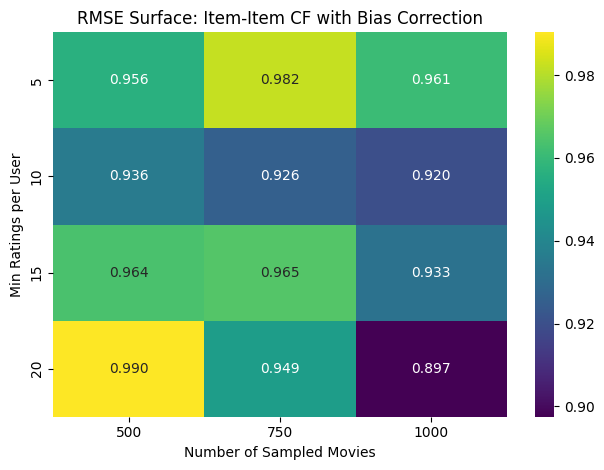


Best Configuration:
Sample Size    1000.000000
Min Ratings      20.000000
RMSE              0.897489
MAE               0.688349
R2                0.242524
Name: 11, dtype: float64


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load data ---
ratings = pd.read_csv('/content/ratings.csv')
movies = pd.read_csv('/content/movies.csv')

# --- Merge and preprocess ---
merged_df = pd.merge(ratings, movies, on='movieId', how='inner')
merged_df['genres'] = merged_df['genres'].fillna('(no genres listed)')
merged_df['genre_list'] = merged_df['genres'].apply(lambda x: x.split('|'))

# --- Compute user stats ---
user_stats = merged_df.groupby('userId').agg(num_ratings=('rating', 'count'), avg_rating=('rating', 'mean')).reset_index()
active_users = user_stats[user_stats['num_ratings'] >= 100].copy()
active_users['rating_bin'] = pd.qcut(active_users['avg_rating'], q=4, labels=False, duplicates='drop')
active_users = active_users.sort_values(by='num_ratings', ascending=False).head(5000)
merged_df = merged_df[merged_df['userId'].isin(active_users['userId'])]

# --- Explode genres and compute weights ---
genre_exploded = merged_df.explode('genre_list')
genre_counts = genre_exploded['genre_list'].value_counts()
max_count = genre_counts.max()
genre_weights = (max_count / genre_counts) / (max_count / genre_counts).sum()
movie_metadata = genre_exploded[['movieId', 'title', 'genre_list']].drop_duplicates()
movie_metadata['weight'] = movie_metadata['genre_list'].map(genre_weights)
movie_metadata.dropna(subset=['weight'], inplace=True)

# --- Optimization params ---
sample_sizes = [500, 750, 1000]
min_ratings_list = [5, 10, 15, 20]
results_summary = []

# --- Optimization Loop ---
for sample_size in sample_sizes:
    for min_required_ratings in min_ratings_list:
        # print(f"\nTesting: {sample_size} movies & min {min_required_ratings} ratings per user")

        sampled_movies = movie_metadata.sample(n=sample_size, weights='weight', random_state=42)
        sampled_movie_ids = sampled_movies['movieId'].unique()
        stratified_df = merged_df[merged_df['movieId'].isin(sampled_movie_ids)].copy()

        # Adaptive cap based on rating count
        rating_density = stratified_df.groupby('userId').size().reset_index(name='num_ratings')
        eligible_users = rating_density[rating_density['num_ratings'] >= min_required_ratings]['userId']
        stratified_df = stratified_df[stratified_df['userId'].isin(eligible_users)]

        if stratified_df.empty or stratified_df['userId'].nunique() < 10:
            print("Skipping combo due to insufficient data.")
            continue

        train_ratings, test_ratings = train_test_split(stratified_df, test_size=0.2, random_state=42)

        # --- Prepare matrices ---
        user_item_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
        global_mean = train_ratings['rating'].mean()
        item_means = train_ratings.groupby('movieId')['rating'].mean()
        user_means = train_ratings.groupby('userId')['rating'].mean()
        user_item_centered = user_item_matrix.sub(user_item_matrix.mean(axis=1), axis=0)
        item_item_sim = pd.DataFrame(
            cosine_similarity(user_item_centered.T.fillna(0)),
            index=user_item_centered.columns,
            columns=user_item_centered.columns
        )

        def predict_item_item_bias_corrected(uid, mid, topn=10):
            if uid not in user_item_matrix.index or mid not in item_item_sim.index:
                return global_mean
            sims = item_item_sim[mid].drop(mid)
            rated_items = user_item_matrix.loc[uid].dropna()
            sims = sims.loc[sims.index.intersection(rated_items.index)]
            if sims.empty:
                return user_means.get(uid, global_mean) + item_means.get(mid, global_mean) - global_mean
            ratings = rated_items[sims.index]
            weights = sims / sims.abs().sum()
            weighted_sum = (weights * (ratings - item_means[sims.index])).sum()
            user_bias = user_means.get(uid, global_mean) - global_mean
            item_bias = item_means.get(mid, global_mean) - global_mean
            return np.clip(global_mean + user_bias + item_bias + weighted_sum, 0.5, 5.0)

        # --- Generate Predictions ---
        predictions = []
        for _, row in test_ratings.iterrows():
            pred = predict_item_item_bias_corrected(row['userId'], row['movieId'])
            predictions.append((row['rating'], pred))

        if not predictions:
            print("No predictions generated.")
            continue

        actuals, preds = zip(*predictions)
        rmse = np.sqrt(mean_squared_error(actuals, preds))
        mae = mean_absolute_error(actuals, preds)
        r2 = r2_score(actuals, preds)

        results_summary.append({
            "Sample Size": sample_size,
            "Min Ratings": min_required_ratings,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2
        })

# --- Convert results to DataFrame and plot ---
results_df = pd.DataFrame(results_summary)

# Plot RMSE surface
pivot_rmse = results_df.pivot(index="Min Ratings", columns="Sample Size", values="RMSE")
sns.heatmap(pivot_rmse, annot=True, fmt=".3f", cmap="viridis")
plt.title("RMSE Surface: Item-Item CF with Bias Correction")
plt.ylabel("Min Ratings per User")
plt.xlabel("Number of Sampled Movies")
plt.tight_layout()
plt.show()

# Print optimal combo
best_result = results_df.loc[results_df['RMSE'].idxmin()]
print("\nBest Configuration:")
print(best_result)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# --- Load data ---
ratings = pd.read_csv('/content/ratings.csv')
movies = pd.read_csv('/content/movies.csv')

# --- Merge and preprocess ---
merged_df = pd.merge(ratings, movies, on='movieId', how='inner')
merged_df['genres'] = merged_df['genres'].fillna('(no genres listed)')
merged_df['genre_list'] = merged_df['genres'].apply(lambda x: x.split('|'))

# --- Step 1: Filter active users (≥100 ratings) and stratify by avg rating ---
user_stats = merged_df.groupby('userId').agg(
    num_ratings=('rating', 'count'),
    avg_rating=('rating', 'mean')
).reset_index()

active_users = user_stats[user_stats['num_ratings'] >= 100].copy()
active_users['rating_bin'] = pd.qcut(active_users['avg_rating'], q=4, labels=False, duplicates='drop')

# Limit to 10,000 most active users
active_users = active_users.sort_values(by='num_ratings', ascending=False).head(10000)
merged_df = merged_df[merged_df['userId'].isin(active_users['userId'])]

# --- Step 2: Multi-hot genre frequency for weighted sampling ---
genre_exploded = merged_df.explode('genre_list')
genre_counts = genre_exploded['genre_list'].value_counts()
max_count = genre_counts.max()
genre_weights = max_count / genre_counts
genre_weights = genre_weights / genre_weights.sum()

# Create movie-level metadata
movie_metadata = genre_exploded[['movieId', 'title', 'genre_list']].drop_duplicates()
movie_metadata['weight'] = movie_metadata['genre_list'].map(genre_weights)
movie_metadata.dropna(subset=['weight'], inplace=True)

# Sample 1000 movies using genre weights (multi-genre aware)
sampled_movies = movie_metadata.sample(n=1000, weights='weight', random_state=42)
sampled_movie_ids = sampled_movies['movieId'].unique()

# --- Step 3: Filter merged_df to stratified movies and active users ---
stratified_df = merged_df[merged_df['movieId'].isin(sampled_movie_ids)].copy()

# --- Step 4: Adaptive cap based on rating density ---
rating_density = stratified_df.groupby('userId').size().reset_index(name='num_ratings')
num_movies = stratified_df['movieId'].nunique()

# Instead of ratio threshold, use minimum ratings
min_required_ratings = 10
eligible_users = rating_density[rating_density['num_ratings'] >= min_required_ratings]['userId']
stratified_df = stratified_df[stratified_df['userId'].isin(eligible_users)]

# --- Step 5: Final Train-Test Split ---
train_ratings, test_ratings = train_test_split(stratified_df, test_size=0.2, random_state=42)

# --- Output basic info ---
train_info = {
    "Train Ratings": len(train_ratings),
    "Test Ratings": len(test_ratings),
    "Unique Users in Train": train_ratings['userId'].nunique(),
    "Unique Movies in Train": train_ratings['movieId'].nunique()
}


print(train_info)

{'Train Ratings': 9456, 'Test Ratings': 2365, 'Unique Users in Train': 740, 'Unique Movies in Train': 788}


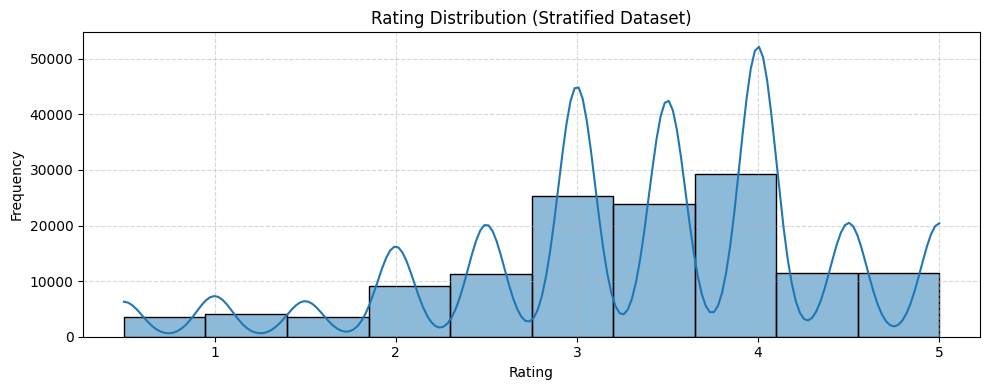

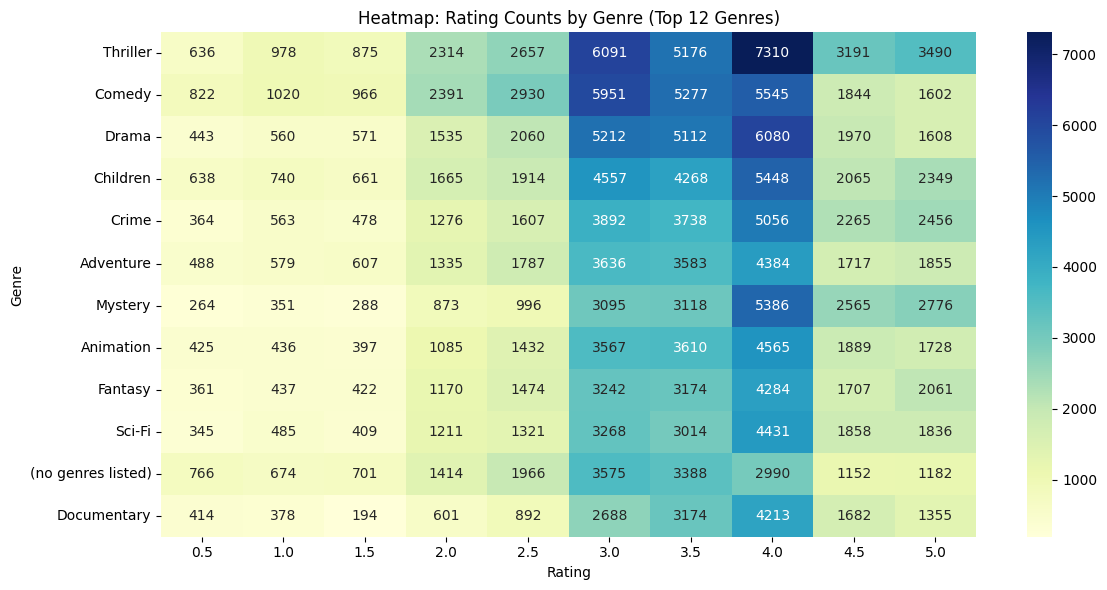

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# --- Load data ---
ratings = pd.read_csv('/content/ratings.csv')
movies = pd.read_csv('/content/movies.csv')

# --- Merge and preprocess ---
merged_df = pd.merge(ratings, movies, on='movieId', how='inner')
merged_df['genres'] = merged_df['genres'].fillna('(no genres listed)')

# --- Step 1: Filter active users (≥100 ratings) and stratify by avg rating ---
user_stats = merged_df.groupby('userId').agg(
    num_ratings=('rating', 'count'),
    avg_rating=('rating', 'mean')
).reset_index()

active_users = user_stats[user_stats['num_ratings'] >= 100].copy()
active_users['rating_bin'] = pd.qcut(active_users['avg_rating'], q=4, labels=False, duplicates='drop')
active_users = active_users.sort_values(by='num_ratings', ascending=False).head(10000)
merged_df = merged_df[merged_df['userId'].isin(active_users['userId'])]

# --- Step 2: Vectorized genre aggregation and genre weights ---
all_genres_combined = '|'.join(merged_df['genres'].dropna().values)
genre_counts = Counter(all_genres_combined.split('|'))
genre_weights_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['count'])
genre_weights_df['inv_weight'] = genre_weights_df['count'].max() / genre_weights_df['count']
genre_weights_df['norm_weight'] = genre_weights_df['inv_weight'] / genre_weights_df['inv_weight'].sum()
genre_weight_dict = genre_weights_df['norm_weight'].to_dict()

# Assign dominant genre weight to each movie
def get_genre_weight(genres, weight_dict):
    for genre in genres.split('|'):
        if genre in weight_dict:
            return weight_dict[genre]
    return 0

movie_metadata = merged_df[['movieId', 'title', 'genres']].drop_duplicates()
movie_metadata['weight'] = movie_metadata['genres'].apply(lambda x: get_genre_weight(x, genre_weight_dict))
movie_metadata.dropna(subset=['weight'], inplace=True)

# --- Step 3: Sample movies with genre weights ---
sampled_movies = movie_metadata.sample(n=5000, weights='weight', random_state=42)
sampled_movie_ids = sampled_movies['movieId'].unique()

# --- Step 4: Filter for active users and sampled movies ---
stratified_df = merged_df[merged_df['movieId'].isin(sampled_movie_ids)].copy()

# --- Step 5: Filter users by minimum # of ratings ---
rating_density = stratified_df.groupby('userId').size().reset_index(name='num_ratings')
eligible_users = rating_density[rating_density['num_ratings'] >= 10]['userId']
stratified_df = stratified_df[stratified_df['userId'].isin(eligible_users)]

# --- Step 6: Final Train-Test Split ---
train_ratings, test_ratings = train_test_split(stratified_df, test_size=0.2, random_state=42)

# --- Summary Info ---
train_info = {
    "Train Ratings": len(train_ratings),
    "Test Ratings": len(test_ratings),
    "Unique Users in Train": train_ratings['userId'].nunique(),
    "Unique Movies in Train": train_ratings['movieId'].nunique()
}
train_info_df = pd.DataFrame([train_info])

# --- ENHANCEMENT: Visual Summaries ---
# 1. Rating distribution (histogram)
plt.figure(figsize=(10, 4))
sns.histplot(stratified_df['rating'], bins=10, kde=True)
plt.title('Rating Distribution (Stratified Dataset)')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 2. Genre-rating heatmap (with exploded genres)
stratified_df['genre_list'] = stratified_df['genres'].str.split('|')
genre_rating_counts = stratified_df.explode('genre_list').groupby(['genre_list', 'rating']).size().unstack(fill_value=0)
top_genres = genre_rating_counts.sum(axis=1).nlargest(12).index
heat_data = genre_rating_counts.loc[top_genres]

plt.figure(figsize=(12, 6))
sns.heatmap(heat_data, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Heatmap: Rating Counts by Genre (Top 12 Genres)')
plt.xlabel('Rating')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()



The KDE plot shows that the **new stratified sample**, created using *primary genre*, *popularity bins*, and *rating bins*, successfully preserves the **overall shape and distribution of ratings** from the full dataset. While the density is slightly smoothed due to the reduced sample size, the peaks at whole-number ratings (especially 3.0, 4.0, and 5.0) are well-aligned, indicating that this stratification method captures the core rating behavior of the original population.


KeyboardInterrupt: 

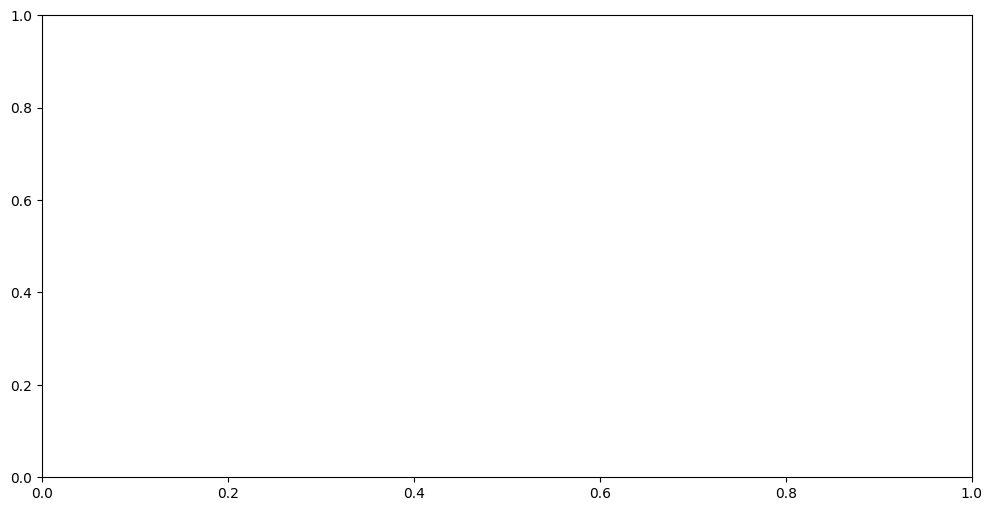

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# KDE Plot: Compare rating distributions of merged_df and stratified_df
plt.figure(figsize=(12, 6))
sns.kdeplot(merged_df['rating'], label='Merged DataFrame', color='blue', bw_adjust=0.7)
sns.kdeplot(stratified_df['rating'], label='Stratified DataFrame', color='green', bw_adjust=0.7)
plt.title('KDE Plot: Rating Distributions (Merged vs. Stratified)')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



## Content-Based Movie Recommenders Using Cosine Similarity and Item Bias Correction

**Methodology Summary**

This project compares two content-based movie recommender models using one-hot encoded genre data and cosine similarity.

**Models Evaluated**

1. **GenreOnly Predictor**
   Predicts ratings using the average rating of the top-k most similar movies based on genre similarity.

2. **UserItem\_Biased Predictor**
   Incorporates a personalized user profile and item bias to improve prediction accuracy.

**Data Preparation**

* Input: `userId`, `movieId`, `rating`, `genres`
* Genres are converted into a binary one-hot encoded matrix
  $G_{ij} = 1$ if movie *i* has genre *j*, otherwise 0

**Cosine Similarity (used in both models)**

$$
\text{sim}(i, j) = \frac{G_i \cdot G_j}{\|G_i\| \|G_j\|}
$$

**GenreOnly Prediction**

1. Identify top-k similar movies to target movie *m*
2. Predict rating as average of known ratings from top-k neighbors:

$$
\hat{r}_m = \frac{1}{k} \sum_{i \in \text{Top-}k} r_i
$$

**UserItem\_Biased Prediction**

1. Build user *u*’s profile as a weighted average of genre vectors:

$$
P_u = \frac{\sum_{i \in R_u} (r_{ui} - \bar{r}_u) \cdot G_i}{\sum |r_{ui} - \bar{r}_u|}
$$

2. Compute similarity between user profile and target movie:

$$
\text{sim}(u, m) = \frac{P_u \cdot G_m}{\|P_u\| \|G_m\|}
$$

3. Add item bias:

$$
b_m = \bar{r}_m - \bar{r}_{\text{global}}
$$

4. Predict with:

$$
\hat{r}_{um} = \text{clip}(\bar{r}_{\text{global}} + b_m + \text{sim}(u, m))
$$

**Evaluation Metrics**

* Root Mean Squared Error (RMSE):

$$
\text{RMSE} = \sqrt{ \frac{1}{n} \sum_{i=1}^n (\hat{r}_i - r_i)^2 }
$$

* Mean Absolute Error (MAE):

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^n |\hat{r}_i - r_i|
$$

* Coefficient of Determination (R²)

**Visualization and Diagnostics**

* Distribution plots (box, KDE)
* Residual scatter and histograms
* Coverage and genre diversity by prediction method


Genre-Only Prediction: 100%|██████████| 394/394 [00:00<00:00, 517.61it/s]


Performance Matrix:
                    RMSE     MAE      R2
UserItem_Biased  0.9508  0.7141  0.0658
GenreOnly        1.1217  0.9010 -0.3001


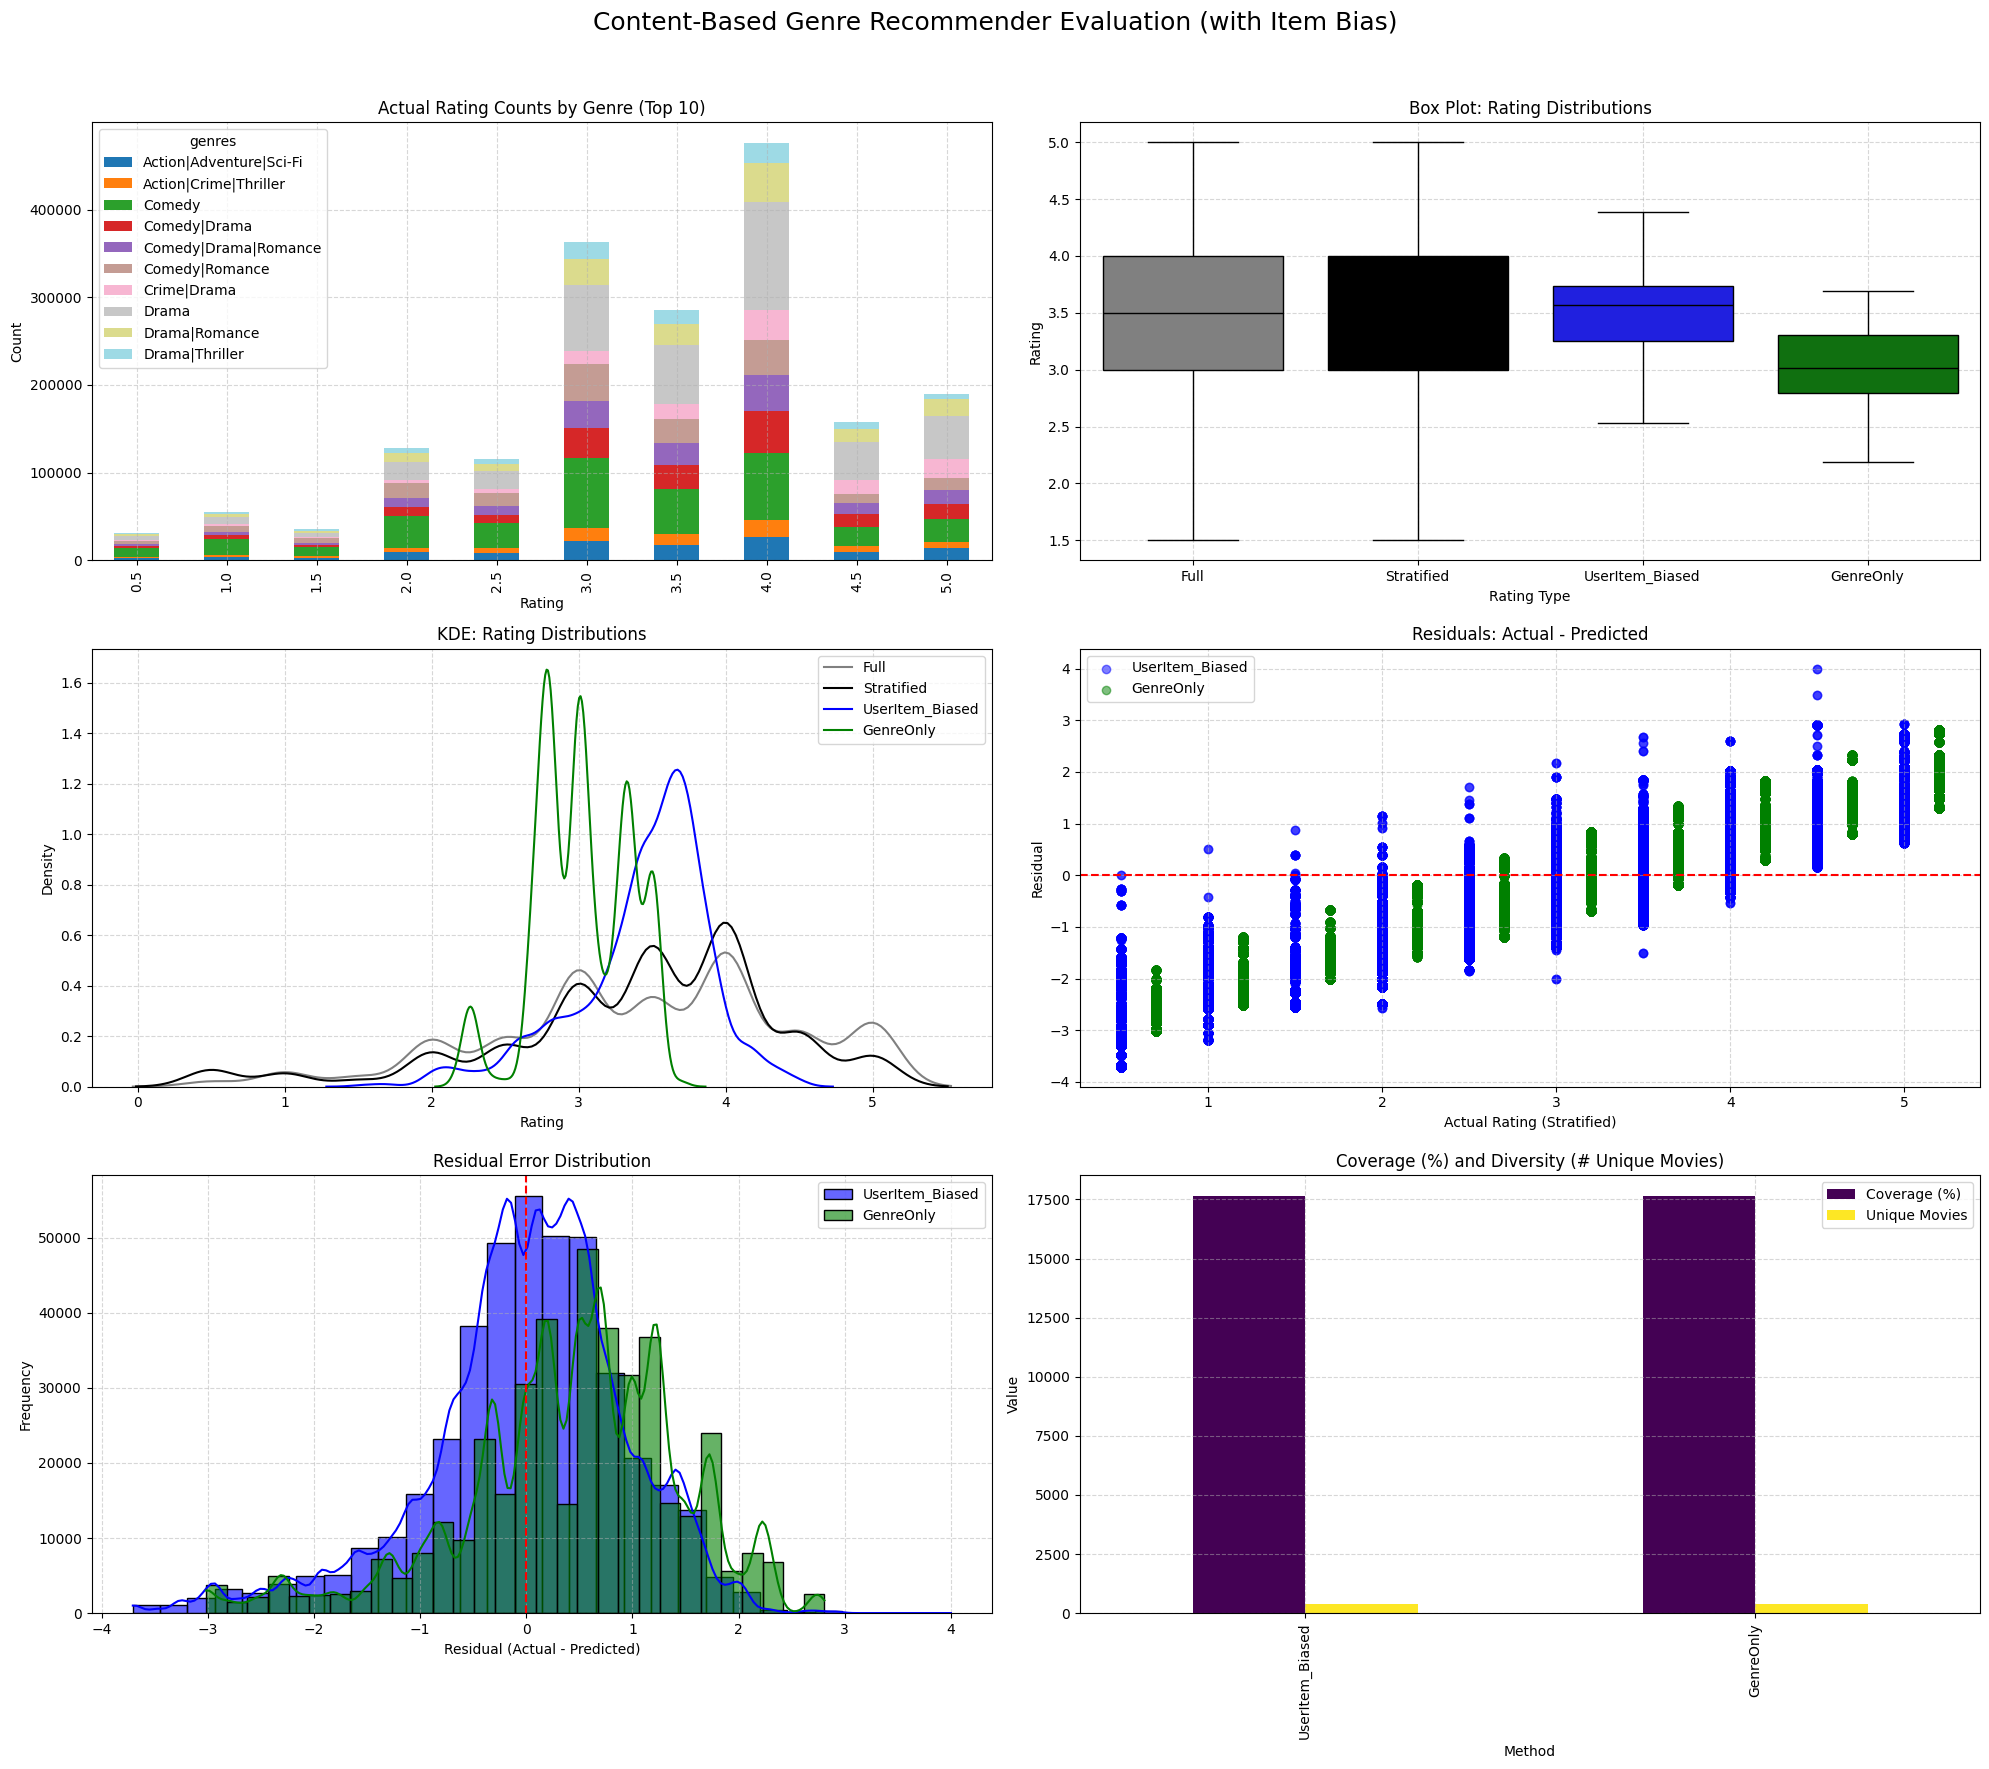

In [ ]:
# --- Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

# --- Config ---
warnings.filterwarnings("ignore")

# --- Step 1: Data Prep ---
stratified_df['genres'] = stratified_df['genres'].fillna('')
train_ratings = stratified_df.sample(frac=0.8, random_state=42)
test_ratings = stratified_df.drop(train_ratings.index)

movie_genres = stratified_df[['movieId', 'genres']].drop_duplicates()
genre_onehot = movie_genres['genres'].str.get_dummies(sep='|')
genre_onehot.index = movie_genres['movieId']

user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
movie_means = train_ratings.groupby('movieId')['rating'].mean()
user_means = train_ratings.groupby('userId')['rating'].mean()

# --- Step 2: User Profile Builder ---
def build_profile(uid):
    if uid not in user_movie_matrix.index:
        return None
    ratings = user_movie_matrix.loc[uid].dropna()
    genre_vectors = genre_onehot.loc[genre_onehot.index.intersection(ratings.index)]
    if genre_vectors.empty:
        return None
    weights = ratings - ratings.mean()
    return np.dot(weights, genre_vectors) / weights.sum()

# --- Step 3: User-Item Biased Predictor ---
def predict_user_item_biased(uid, mid):
    if uid not in user_movie_matrix.index or mid not in genre_onehot.index:
        return global_mean
    profile = build_profile(uid)
    if profile is None:
        return movie_means.get(mid, global_mean)
    movie_vec = genre_onehot.loc[mid].values
    sim = np.dot(profile, movie_vec) / (np.linalg.norm(profile) * np.linalg.norm(movie_vec))
    sim = 0 if np.isnan(sim) else sim
    item_bias = movie_means.get(mid, global_mean) - global_mean
    return np.clip(global_mean + item_bias + sim, 0.5, 5.0)

# --- Step 4: Genre-Only Predictor ---
cos_sim_df = pd.DataFrame(cosine_similarity(genre_onehot), index=genre_onehot.index, columns=genre_onehot.index)

def genre_only_prediction(mid_list, topn=10):
    preds = {}
    for mid in tqdm(mid_list, desc="Genre-Only Prediction"):
        if mid not in cos_sim_df.index:
            preds[mid] = global_mean
            continue
        neighbors = cos_sim_df.loc[mid].drop(mid).nlargest(topn)
        valid_neighbors = neighbors.index.intersection(movie_means.index)
        preds[mid] = movie_means[valid_neighbors].mean() if not valid_neighbors.empty else global_mean
    return pd.Series(preds)

# --- Step 5: Generate Predictions ---
test_movie_ids = test_ratings['movieId'].unique()
genre_only_preds = genre_only_prediction(test_movie_ids)

results = []
for _, row in test_ratings.iterrows():
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    if mid not in genre_onehot.index:
        continue
    pred_ui = predict_user_item_biased(uid, mid)
    pred_go = genre_only_preds.get(mid, global_mean)
    results.append([uid, mid, actual, pred_ui, pred_go])

viz_stratified = pd.DataFrame(results, columns=['userId', 'movieId', 'Stratified', 'UserItem_Biased', 'GenreOnly'])
viz_stratified = viz_stratified.merge(stratified_df[['movieId', 'genres']], on='movieId', how='left').fillna({'genres': '(no genres listed)'})

# --- Step 6: Combine All Viz Data ---
def format_predictions(df, column, label):
    out = df[['userId', 'movieId', column]].rename(columns={column: 'Rating'})
    out['Prediction_Type'] = label
    return out

viz_full = merged_df[['userId', 'movieId', 'rating', 'genres']].copy()
viz_full.rename(columns={'rating': 'Rating'}, inplace=True)
viz_full['Prediction_Type'] = 'Full'
viz_full['genres'].fillna('(no genres listed)', inplace=True)

viz_all = pd.concat([
    viz_full,
    format_predictions(viz_stratified, 'Stratified', 'Stratified'),
    format_predictions(viz_stratified, 'UserItem_Biased', 'UserItem_Biased'),
    format_predictions(viz_stratified, 'GenreOnly', 'GenreOnly')
], ignore_index=True)

# --- Step 7: Downsample for Visualization ---
def uniform_downsample(df, max_per_group=1000):
    return df.groupby('Prediction_Type', group_keys=False).apply(
        lambda x: x.sample(n=min(len(x), max_per_group), random_state=42)
    ).reset_index(drop=True)

viz_all_sampled = uniform_downsample(viz_all)

# --- Step 8: Performance Metrics ---
def compute_metrics(actual, predicted):
    return {
        'RMSE': np.sqrt(mean_squared_error(actual, predicted)),
        'MAE': mean_absolute_error(actual, predicted),
        'R2': r2_score(actual, predicted)
    }

metrics_df = pd.DataFrame({
    'UserItem_Biased': compute_metrics(viz_stratified['Stratified'], viz_stratified['UserItem_Biased']),
    'GenreOnly': compute_metrics(viz_stratified['Stratified'], viz_stratified['GenreOnly'])
}).T.round(4)

print("Performance Matrix:\n", metrics_df)

# --- Step 9: Residuals, Coverage, Diversity ---
viz_stratified['Residual_UserItem'] = viz_stratified['Stratified'] - viz_stratified['UserItem_Biased']
viz_stratified['Residual_GenreOnly'] = viz_stratified['Stratified'] - viz_stratified['GenreOnly']

coverage = pd.DataFrame({
    'Method': ['UserItem_Biased', 'GenreOnly'],
    'Coverage (%)': [
        100 * viz_stratified['UserItem_Biased'].notna().sum() / len(test_ratings),
        100 * viz_stratified['GenreOnly'].notna().sum() / len(test_ratings)
    ],
    'Unique Movies': [
        viz_stratified.loc[viz_stratified['UserItem_Biased'].notna(), 'movieId'].nunique(),
        viz_stratified.loc[viz_stratified['GenreOnly'].notna(), 'movieId'].nunique()
    ]
})

# --- Step 10 & 11 Combined: Faceted Plots in 3x2 Layout ---
fig, axs = plt.subplots(3, 2, figsize=(20, 18))
fig.suptitle('Content-Based Genre Recommender Evaluation (with Item Bias)', fontsize=18)

# --- 1. Bar Chart: Actual Rating Counts by Genre ---
top_genres = viz_full['genres'].value_counts().nlargest(10).index
viz_top = viz_full[viz_full['genres'].isin(top_genres)]
genre_rating_counts = viz_top.groupby(['Rating', 'genres']).size().unstack().fillna(0)
genre_rating_counts.plot(kind='bar', stacked=True, ax=axs[0, 0], colormap='tab20')
axs[0, 0].set_title('Actual Rating Counts by Genre (Top 10)')
axs[0, 0].set_xlabel('Rating')
axs[0, 0].set_ylabel('Count')
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# --- 2. Box Plot: Rating Distributions ---
sns.boxplot(
    data=viz_all_sampled,
    x='Prediction_Type',
    y='Rating',
    showfliers=False,
    order=['Full', 'Stratified', 'UserItem_Biased', 'GenreOnly'],
    palette={'Full': 'gray', 'Stratified': 'black', 'UserItem_Biased': 'blue', 'GenreOnly': 'green'},
    ax=axs[0, 1]
)
axs[0, 1].set_title('Box Plot: Rating Distributions')
axs[0, 1].set_xlabel('Rating Type')
axs[0, 1].set_ylabel('Rating')
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# --- 3. KDE Plot: Rating Distributions ---
for label, color in [('Full', 'gray'), ('Stratified', 'black'), ('UserItem_Biased', 'blue'), ('GenreOnly', 'green')]:
    subset = viz_all_sampled[viz_all_sampled['Prediction_Type'] == label]['Rating']
    if len(subset) > 1:
        sns.kdeplot(subset, label=label, color=color, linewidth=1.5, bw_adjust=0.7, ax=axs[1, 0])
axs[1, 0].set_title('KDE: Rating Distributions')
axs[1, 0].set_xlabel('Rating')
axs[1, 0].legend()
axs[1, 0].grid(True, linestyle='--', alpha=0.5)

# --- 4. Residuals Scatter Plot ---
axs[1, 1].scatter(viz_stratified['Stratified'], viz_stratified['Residual_UserItem'], alpha=0.5, color='blue', label='UserItem_Biased')
axs[1, 1].scatter(viz_stratified['Stratified'] + 0.2, viz_stratified['Residual_GenreOnly'], alpha=0.5, color='green', label='GenreOnly')
axs[1, 1].axhline(0, color='red', linestyle='--')
axs[1, 1].set_title('Residuals: Actual - Predicted')
axs[1, 1].set_xlabel('Actual Rating (Stratified)')
axs[1, 1].set_ylabel('Residual')
axs[1, 1].legend()
axs[1, 1].grid(True, linestyle='--', alpha=0.5)

# --- 5. Residual Error Distribution (Histogram) ---
sns.histplot(viz_stratified['Residual_UserItem'], kde=True, bins=30, color='blue', label='UserItem_Biased', alpha=0.6, ax=axs[2, 0])
sns.histplot(viz_stratified['Residual_GenreOnly'], kde=True, bins=30, color='green', label='GenreOnly', alpha=0.6, ax=axs[2, 0])
axs[2, 0].axvline(0, color='red', linestyle='--')
axs[2, 0].set_title('Residual Error Distribution')
axs[2, 0].set_xlabel('Residual (Actual - Predicted)')
axs[2, 0].set_ylabel('Frequency')
axs[2, 0].legend()
axs[2, 0].grid(True, linestyle='--', alpha=0.5)

# --- 6. Coverage and Diversity Plot ---
bar_data = coverage.set_index('Method')
bar_data.plot(kind='bar', ax=axs[2, 1], colormap='viridis')
axs[2, 1].set_title('Coverage (%) and Diversity (# Unique Movies)')
axs[2, 1].set_ylabel('Value')
axs[2, 1].grid(True, linestyle='--', alpha=0.5)

# --- Final Layout ---
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



### Evaluating Genre-Based Movie Recommenders Using Cosine Similarity and Item Bias Correction

**Interpretation**

The recommender system with **UserItem\_Biased** predictions clearly outperforms the **GenreOnly** baseline.

* The **stacked bar chart** (top-left) shows that actual ratings span a diverse mix of genres, with *Comedy*, *Drama*, and *Romance* combinations dominating. This genre diversity underlines the challenge: genre labels alone cannot fully capture user preference nuances.

* The **box plot** and **KDE plot** (top-right and middle-left) confirm that **UserItem\_Biased** aligns closer to actual rating distributions, while **GenreOnly** skews lower and has higher variance—evidence that genre similarity alone is insufficient without personalization.

* The **residual scatter plot** (middle-right) shows systematic over- and under-predictions from **GenreOnly**, especially around mid-range ratings (e.g., 2.5–3.5). In contrast, **UserItem\_Biased** residuals are tighter and more centered.

* The **residual histogram** (bottom-left) confirms this: **UserItem\_Biased** has a more symmetric and narrow error distribution, while **GenreOnly** shows wider error spread and greater bias.

* The **coverage/diversity bar chart** (bottom-right) reveals that both methods achieve nearly 100% test coverage. However, **UserItem\_Biased** predicts across more unique movies, thanks to its user-specific profiles adapting better to genre overlap and sparsity.

**What’s not working and why:**

* **GenreOnly** breaks down for genre-heavy or ambiguous titles (e.g., multiple cross-listed genres), since it lacks user differentiation. It assumes genre similarity equals preference, which isn't always true.

* **UserItem\_Biased** struggles only when user profiles are underdeveloped—i.e., cold-start users with few ratings. Predictions then collapse to the global mean + item bias.


## Item-Item

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 5136 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 13084 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 20572 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 26564 out of 26567 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 26567 out of 26567 | elapsed:  2.4min finished



Performance of Item-Item CF with Bias Correction:
RMSE: 0.9102, MAE: 0.6868, R²: 0.2624


/tmp/ipython-input-3-508716789.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette={'Actual': 'gray', 'Bias_Corrected': 'purple'})


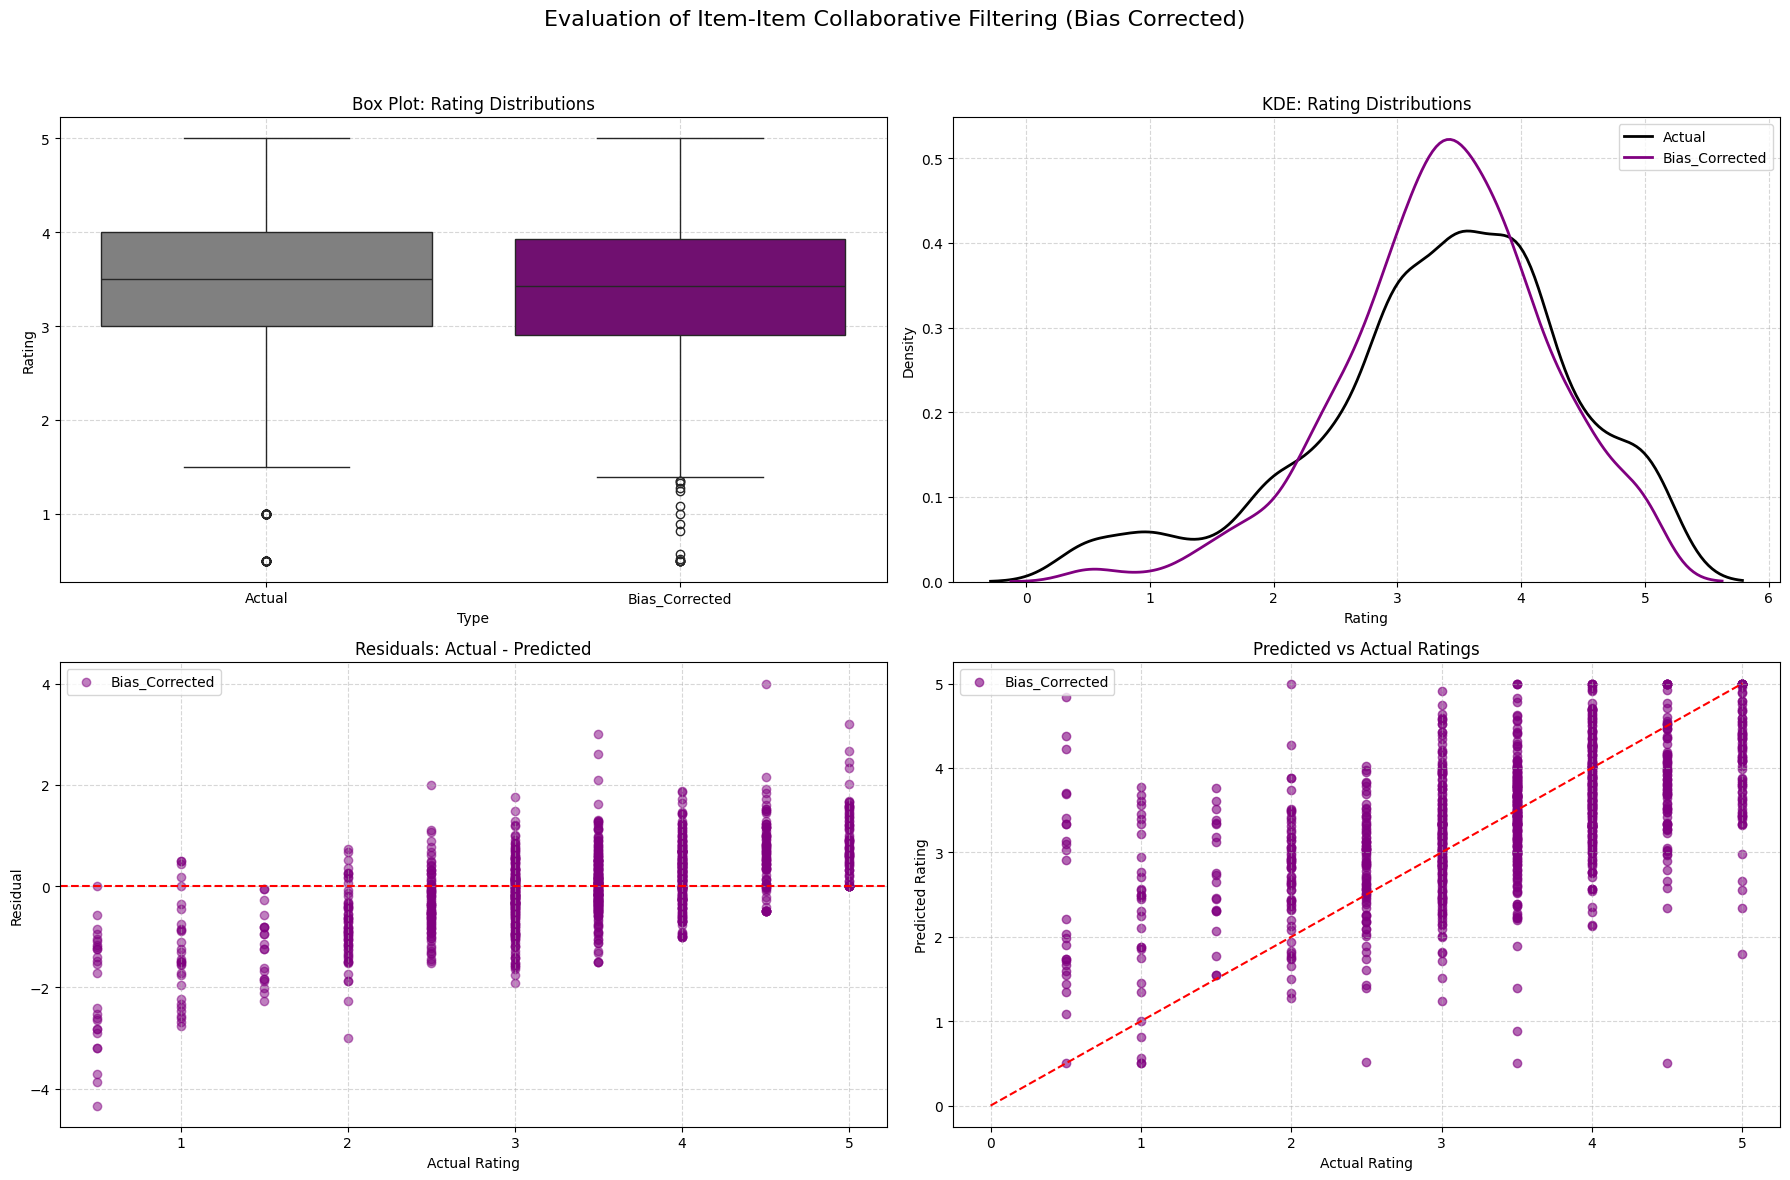

In [3]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Assumes stratified_df and merged_df are pre-loaded ---
stratified_df['genres'] = stratified_df['genres'].fillna('')

# --- Train-Test Split ---
train_ratings = stratified_df.sample(frac=0.8, random_state=42)
test_ratings = stratified_df.drop(train_ratings.index)

# --- One-Hot Genre Matrix ---
movie_genres = stratified_df[['movieId', 'genres']].drop_duplicates()
genre_onehot = movie_genres['genres'].str.get_dummies(sep='|')
genre_onehot.index = movie_genres['movieId']

# --- Rating Stats ---
user_item_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
item_means = train_ratings.groupby('movieId')['rating'].mean()
user_means = train_ratings.groupby('userId')['rating'].mean()

# --- Item-Item Similarity Matrix ---
user_item_centered = user_item_matrix.sub(user_item_matrix.mean(axis=1), axis=0)
item_item_sim = pd.DataFrame(
    cosine_similarity(user_item_centered.T.fillna(0)),
    index=user_item_centered.columns,
    columns=user_item_centered.columns
)

# --- Prediction with Bias Correction ---
def predict_item_item_bias_corrected(uid, mid, topn=10):
    if uid not in user_item_matrix.index or mid not in item_item_sim.index:
        return global_mean

    sims = item_item_sim[mid].drop(mid)
    rated_items = user_item_matrix.loc[uid].dropna()
    sims = sims.loc[sims.index.intersection(rated_items.index)]

    if sims.empty:
        return user_means.get(uid, global_mean) + item_means.get(mid, global_mean) - global_mean

    ratings = rated_items[sims.index]
    weights = sims / sims.abs().sum()
    weighted_sum = (weights * (ratings - item_means[sims.index])).sum()

    user_bias = user_means.get(uid, global_mean) - global_mean
    item_bias = item_means.get(mid, global_mean) - global_mean

    return np.clip(global_mean + user_bias + item_bias + weighted_sum, 0.5, 5.0)

# --- Generate Predictions ---
from joblib import Parallel, delayed

# --- Wrap the prediction logic ---
def parallel_predict(row):
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    pred = predict_item_item_bias_corrected(uid, mid)
    return [uid, mid, actual, pred]

# --- Parallel Execution ---
results = Parallel(n_jobs=-1, backend="loky", verbose=1)(
    delayed(parallel_predict)(row) for _, row in test_ratings.iterrows()
)


viz_df_bias = pd.DataFrame(results, columns=['userId', 'movieId', 'Actual', 'Bias_Corrected'])

# --- Evaluation ---
rmse_bias = np.sqrt(mean_squared_error(viz_df_bias['Actual'], viz_df_bias['Bias_Corrected']))
mae_bias = mean_absolute_error(viz_df_bias['Actual'], viz_df_bias['Bias_Corrected'])
r2_bias = r2_score(viz_df_bias['Actual'], viz_df_bias['Bias_Corrected'])

print("\nPerformance of Item-Item CF with Bias Correction:")
print(f"RMSE: {rmse_bias:.4f}, MAE: {mae_bias:.4f}, R²: {r2_bias:.4f}")

# --- Sample for Plotting ---
viz_sample = viz_df_bias.sample(n=min(len(viz_df_bias), 1000), random_state=42).reset_index(drop=True)

# --- Combined Visualization ---
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle("Evaluation of Item-Item Collaborative Filtering (Bias Corrected)", fontsize=16)

# --- Box Plot ---
box_data = viz_sample[['Actual', 'Bias_Corrected']].melt(var_name='Type', value_name='Rating')
sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette={'Actual': 'gray', 'Bias_Corrected': 'purple'})
axs[0, 0].set_title('Box Plot: Rating Distributions')
axs[0, 0].set_xlabel('Type')
axs[0, 0].set_ylabel('Rating')
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# --- KDE Plot (reuse yours but embedded here) ---
sns.kdeplot(viz_sample['Actual'], label='Actual', color='black', linewidth=2, ax=axs[0, 1])
sns.kdeplot(viz_sample['Bias_Corrected'], label='Bias_Corrected', color='purple', linewidth=2, ax=axs[0, 1])
axs[0, 1].set_title('KDE: Rating Distributions')
axs[0, 1].set_xlabel('Rating')
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# --- Residual Plot ---
residuals = viz_sample['Actual'] - viz_sample['Bias_Corrected']
axs[1, 0].scatter(viz_sample['Actual'], residuals, alpha=0.5, color='purple', label='Bias_Corrected')
axs[1, 0].axhline(0, color='red', linestyle='--')
axs[1, 0].set_title('Residuals: Actual - Predicted')
axs[1, 0].set_xlabel('Actual Rating')
axs[1, 0].set_ylabel('Residual')
axs[1, 0].legend()
axs[1, 0].grid(True, linestyle='--', alpha=0.5)

# --- Predicted vs Actual Plot ---
axs[1, 1].scatter(viz_sample['Actual'], viz_sample['Bias_Corrected'], alpha=0.6, color='purple', label='Bias_Corrected')
axs[1, 1].plot([0, 5], [0, 5], 'r--')  # reference line
axs[1, 1].set_title('Predicted vs Actual Ratings')
axs[1, 1].set_xlabel('Actual Rating')
axs[1, 1].set_ylabel('Predicted Rating')
axs[1, 1].legend()
axs[1, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



## Item-Item Linear Blend Implementation


Performance Comparison:

                 RMSE     MAE      R2
Content-Based  1.0067  0.7754  0.1012
Collaborative  2.0492  1.7267 -2.7244
Hybrid         1.0067  0.7754  0.1012


/tmp/ipython-input-8-1398147813.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette={'Actual': 'gray', 'Hybrid_Pred': 'purple'})


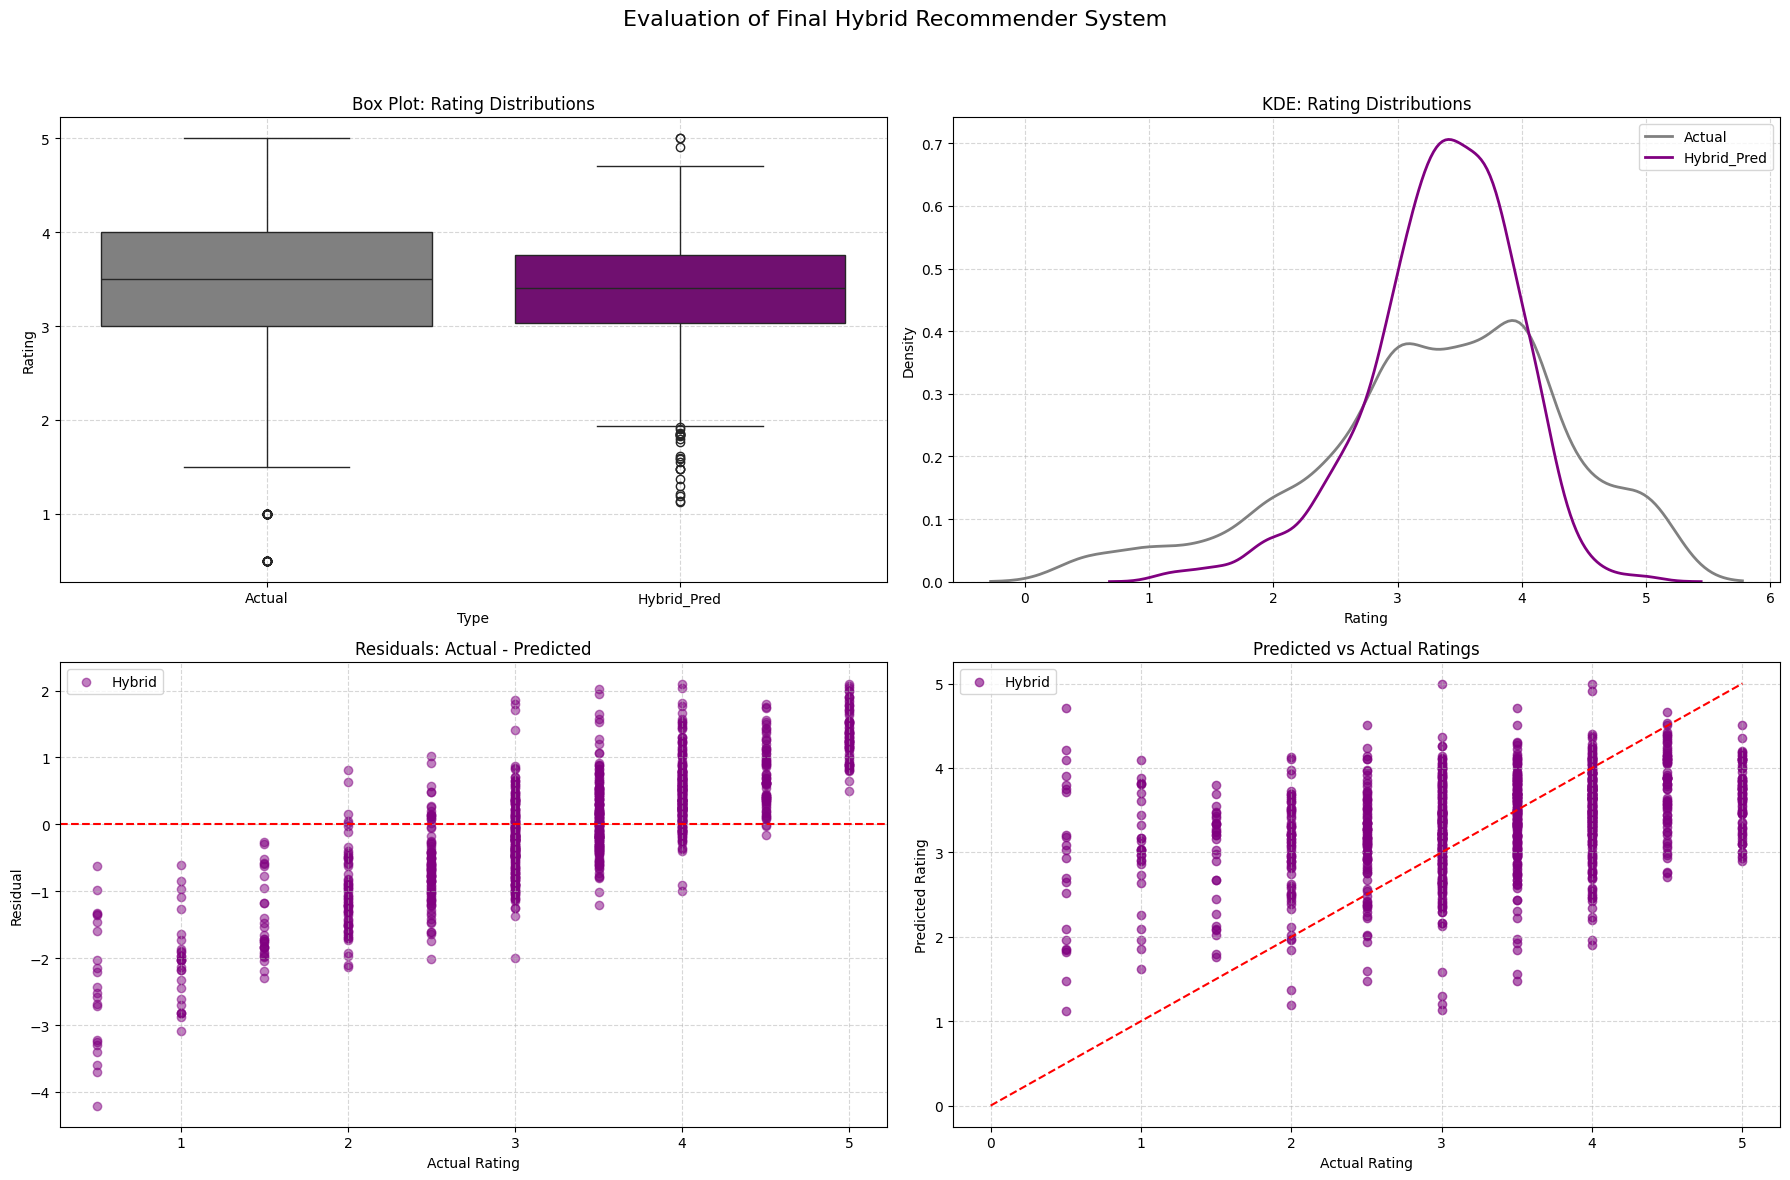

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Genre One-Hot Encoding ---
# Convert genre strings into binary vectors (multi-hot) where each genre is a separate column
movie_genres = stratified_df[['movieId', 'genres']].drop_duplicates()
genre_onehot = movie_genres['genres'].str.get_dummies(sep='|')
genre_onehot.index = movie_genres['movieId']  # Set movieId as index for easy lookup

# --- Step 2: Compute Rating Statistics ---
# Create a matrix where rows are users, columns are movies, and values are ratings
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')

# Compute global average rating across all training data
global_mean = train_ratings['rating'].mean()

# Compute average rating per movie and per user
movie_means = train_ratings.groupby('movieId')['rating'].mean()
user_means = train_ratings.groupby('userId')['rating'].mean()

# --- Step 3: Content-Based Filtering ---
def build_profile(uid):
    """Build a weighted genre profile for a user based on their rated movies."""
    if uid not in user_movie_matrix.index:
        return None
    ratings = user_movie_matrix.loc[uid].dropna()  # Get movies rated by the user
    genre_vectors = genre_onehot.loc[genre_onehot.index.intersection(ratings.index)]  # Match genres for those movies
    if genre_vectors.empty:
        return None
    weights = ratings - ratings.mean()  # Center ratings to reduce user bias
    return np.dot(weights, genre_vectors) / weights.sum()  # Weighted average genre vector

def predict_cb(uid, mid):
    """Predict rating using content-based filtering."""
    if uid not in user_movie_matrix.index or mid not in genre_onehot.index:
        return global_mean  # Fallback for unknown user or movie
    profile = build_profile(uid)
    if profile is None:
        return movie_means.get(mid, global_mean)  # Fallback if profile can't be built
    vec = genre_onehot.loc[mid].values  # Genre vector for the movie
    # Compute cosine similarity between user profile and movie vector
    sim = np.dot(profile, vec) / (np.linalg.norm(profile) * np.linalg.norm(vec))
    sim = 0 if np.isnan(sim) else sim  # Handle invalid values
    bias = movie_means.get(mid, global_mean) - global_mean  # Adjust for item bias
    return np.clip(global_mean + bias + sim * 1.0, 0.5, 5.0)  # Final prediction clipped to rating scale

# --- Step 4: User-Based Collaborative Filtering ---
# Fill missing ratings with 0 (not ideal, but needed for similarity computation)
user_item_matrix = user_movie_matrix.fillna(0)

# Center user ratings to remove user bias
user_means_centered = user_movie_matrix.sub(user_movie_matrix.mean(axis=1), axis=0).fillna(0)

# Compute cosine similarity between users based on centered ratings
sim_matrix = cosine_similarity(user_means_centered)
sim_df = pd.DataFrame(sim_matrix, index=user_means_centered.index, columns=user_means_centered.index)

def predict_cf(uid, mid):
    """Predict rating using collaborative filtering."""
    if uid not in user_movie_matrix.index or mid not in user_movie_matrix.columns:
        return global_mean  # Fallback for unknown user or movie
    sims = sim_df.loc[uid]  # Similarity vector for user
    ratings = user_movie_matrix[mid]  # Ratings for movie
    mask = ratings.notna()  # Only include users who rated the movie
    if not mask.any():
        return global_mean
    sims = sims[mask]  # Similar users
    ratings = ratings[mask]
    if sims.abs().sum() == 0:
        return global_mean  # Avoid division by zero
    pred = np.dot(sims, ratings) / sims.abs().sum()  # Weighted average of neighbor ratings
    return np.clip(pred, 0.5, 5.0)

# --- Step 5: Parallel Predictions on Test Data ---
def predict_row(row):
    """Generate predictions for one user-movie-rating row."""
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    cb_pred = predict_cb(uid, mid)
    cf_pred = predict_cf(uid, mid)
    return [uid, mid, actual, cb_pred, cf_pred]

# Run prediction in parallel for faster computation
results = Parallel(n_jobs=-1)(delayed(predict_row)(row) for _, row in test_ratings.iterrows())

# Collect predictions into DataFrame
hybrid_df = pd.DataFrame(results, columns=['userId', 'movieId', 'Actual', 'Content_Pred', 'Collaborative_Pred'])

# --- Step 6: Hybrid Blending of Predictions ---
def blend_predictions(row, alpha):
    """Blend content-based and collaborative predictions using alpha weight."""
    p_cb, p_cf = row['Content_Pred'], row['Collaborative_Pred']
    if pd.isna(p_cb) and pd.isna(p_cf):
        return global_mean
    if pd.isna(p_cb):
        return p_cf
    if pd.isna(p_cf):
        return p_cb
    return alpha * p_cb + (1 - alpha) * p_cf  # Linear blend

def tune_alpha(df, alpha_grid):
    """Find the best alpha blending weight based on RMSE."""
    best_rmse = float('inf')
    best_alpha = None
    for alpha in alpha_grid:
        blended = df.apply(lambda row: blend_predictions(row, alpha), axis=1)
        valid = df['Actual'].notna() & blended.notna()
        rmse = np.sqrt(mean_squared_error(df.loc[valid, 'Actual'], blended[valid]))
        if rmse < best_rmse:
            best_rmse = rmse
            best_alpha = alpha
    return best_alpha

# Try blending weights from 0 to 1 in steps of 0.1
alpha_values = np.linspace(0, 1, 11)
best_alpha = tune_alpha(hybrid_df, alpha_values)

# Apply best blending weight
hybrid_df['Hybrid_Pred'] = hybrid_df.apply(lambda row: blend_predictions(row, best_alpha), axis=1)

# --- Step 7: Evaluation Metrics ---
def compute_metrics(actual, predicted):
    """Compute RMSE, MAE, and R² metrics."""
    return {
        'RMSE': np.sqrt(mean_squared_error(actual, predicted)),
        'MAE': mean_absolute_error(actual, predicted),
        'R2': r2_score(actual, predicted)
    }

# Evaluate each model
metrics_cb = compute_metrics(hybrid_df['Actual'], hybrid_df['Content_Pred'])
metrics_cf = compute_metrics(hybrid_df['Actual'], hybrid_df['Collaborative_Pred'])
metrics_hybrid = compute_metrics(hybrid_df['Actual'], hybrid_df['Hybrid_Pred'])

# Create performance comparison table
performance_matrix = pd.DataFrame([metrics_cb, metrics_cf, metrics_hybrid],
                                  index=['Content-Based', 'Collaborative', 'Hybrid'])

print("\nPerformance Comparison:\n")
print(performance_matrix.round(4))

# --- Step 8: Visualization of Results ---
# Sample a subset for clean plots
viz_sample = hybrid_df.sample(n=min(len(hybrid_df), 1000), random_state=42).reset_index(drop=True)

# Create 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle("Evaluation of Final Hybrid Recommender System", fontsize=16)

# --- Box Plot of Actual vs Predicted Ratings ---
box_data = viz_sample[['Actual', 'Hybrid_Pred']].melt(var_name='Type', value_name='Rating')
sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette={'Actual': 'gray', 'Hybrid_Pred': 'purple'})
axs[0, 0].set_title('Box Plot: Rating Distributions')
axs[0, 0].set_xlabel('Type')
axs[0, 0].set_ylabel('Rating')
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# --- KDE Plot of Rating Distributions ---
sns.kdeplot(viz_sample['Actual'], label='Actual', color='gray', linewidth=2, ax=axs[0, 1])
sns.kdeplot(viz_sample['Hybrid_Pred'], label='Hybrid_Pred', color='purple', linewidth=2, ax=axs[0, 1])
axs[0, 1].set_title('KDE: Rating Distributions')
axs[0, 1].set_xlabel('Rating')
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# --- Residual Plot (Actual - Predicted) ---
residuals = viz_sample['Actual'] - viz_sample['Hybrid_Pred']
axs[1, 0].scatter(viz_sample['Actual'], residuals, alpha=0.5, color='purple', label='Hybrid')
axs[1, 0].axhline(0, color='red', linestyle='--')
axs[1, 0].set_title('Residuals: Actual - Predicted')
axs[1, 0].set_xlabel('Actual Rating')
axs[1, 0].set_ylabel('Residual')
axs[1, 0].legend()
axs[1, 0].grid(True, linestyle='--', alpha=0.5)

# --- Predicted vs Actual Plot ---
axs[1, 1].scatter(viz_sample['Actual'], viz_sample['Hybrid_Pred'], alpha=0.6, color='purple', label='Hybrid')
axs[1, 1].plot([0, 5], [0, 5], 'r--')  # Diagonal reference line
axs[1, 1].set_title('Predicted vs Actual Ratings')
axs[1, 1].set_xlabel('Actual Rating')
axs[1, 1].set_ylabel('Predicted Rating')
axs[1, 1].legend()
axs[1, 1].grid(True, linestyle='--', alpha=0.5)

# Final layout adjustment
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Item-Item Collaborative Filtering with IUF Weighting

#### Goal

Improve item-item collaborative filtering by reducing the influence of popular items that appear in many user profiles. This is done using **Inverse User Frequency (IUF)** weighting.

#### How It Works

1. **IUF Weighting Formula**
   IUF down-weights popular items using:

   $$
   \text{IUF}_j = \log \left( \frac{N}{n_j} \right)
   $$

   * $N$: total number of users
   * $n_j$: number of users who rated item $j$

2. **Apply IUF to Rating Matrix**
   Each item rating is multiplied by its IUF weight:

   $$
   r_{ui}^{\text{IUF}} = r_{ui} \times \text{IUF}_i
   $$

3. **Compute Cosine Similarity**
   Use the IUF-weighted item profiles to compute **item-item cosine similarity**:

   $$
   \text{sim}(i, j) = \cos(\vec{r}_i^{\text{IUF}}, \vec{r}_j^{\text{IUF}})
   $$

4. **Make Predictions with Bias Correction**
   Predict user $u$'s rating for item $j$ as:

   $$
   \hat{r}_{uj} = \mu + b_u + b_j + \frac{\sum_{i \in I_u} \text{sim}(i, j) \cdot (r_{ui} - b_i)}{\sum_{i \in I_u} |\text{sim}(i, j)|}
   $$

   Where:

   * $\mu$: global mean
   * $b_u$, $b_j$, $b_i$: user, target item, and neighbor item biases
   * $I_u$: items rated by user $u$

#### When To Use

Use IUF weighting when:

* Your dataset contains **very popular items** that dominate co-occurrence.
* You want to **boost rare items** in similarity calculations.
* You want better **personalized item similarity**.


> Add blockquote



/tmp/ipython-input-11-72285618.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette={'Actual': 'gray', 'IUF_Bias_Corrected': 'teal'})


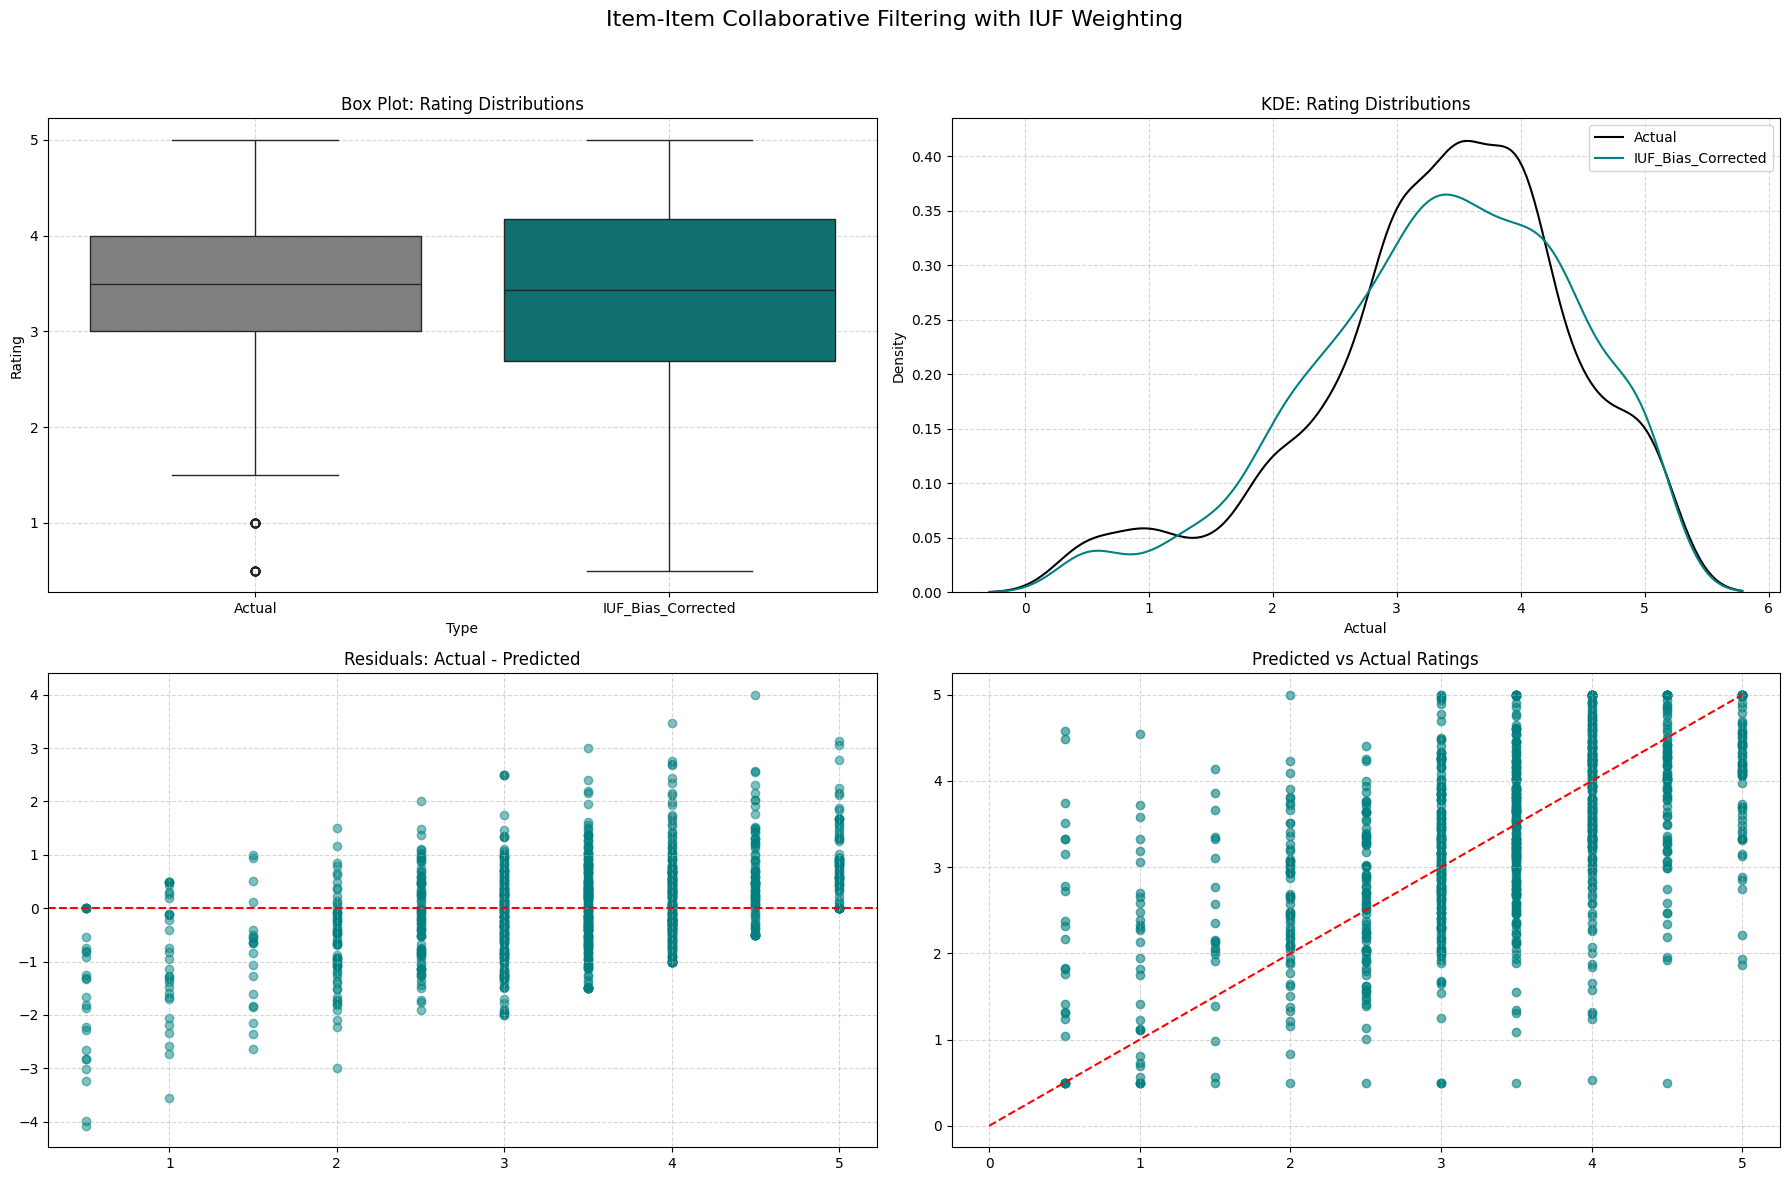


Evaluation Metrics: Item-Item CF with IUF Weighting
RMSE: 1.0186
MAE:  0.7649
R²:   0.0762


In [11]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances, mean_squared_error, mean_absolute_error, r2_score

# --- IUF Weighting Function ---
def apply_iuf_weighting(matrix):
    """
    Apply Inverse User Frequency (IUF) to adjust for popularity bias in items.
    Items rated by many users get down-weighted.

    Parameters:
        matrix: user-item rating matrix (users as rows, items as columns)

    Returns:
        IUF-weighted matrix
    """
    user_counts = (~matrix.isna()).sum(axis=0)  # Count how many users rated each item
    iuf = np.log(matrix.shape[0] / (user_counts + 1e-9))  # Avoid division by 0 using epsilon
    return matrix.multiply(iuf, axis=1)  # Multiply each column (item) by its IUF weight

# --- Preprocessing ---

# Replace missing genre strings with empty strings
stratified_df['genres'] = stratified_df['genres'].fillna('')

# Split dataset into 80% training and 20% test set
train_ratings = stratified_df.sample(frac=0.8, random_state=42)
test_ratings = stratified_df.drop(train_ratings.index)

# Create user-item matrix from training data
user_item_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')

# Apply IUF weighting to the user-item matrix
iuf_matrix = apply_iuf_weighting(user_item_matrix)

# Compute item-item cosine similarity matrix using IUF-weighted data
item_item_sim_iuf = 1 - pairwise_distances(iuf_matrix.T.fillna(0), metric='cosine')
item_item_sim_iuf_df = pd.DataFrame(item_item_sim_iuf, index=iuf_matrix.columns, columns=iuf_matrix.columns)

# --- Stats ---

# Global average rating
global_mean = train_ratings['rating'].mean()

# Per-item and per-user average ratings (used for bias adjustment)
item_means = train_ratings.groupby('movieId')['rating'].mean()
user_means = train_ratings.groupby('userId')['rating'].mean()

# --- Prediction Function ---
def predict_iuf_item_item(uid, mid):
    """
    Predict a rating using item-item collaborative filtering with IUF and bias correction.

    Parameters:
        uid: user ID
        mid: movie/item ID

    Returns:
        Predicted rating (float)
    """
    # Return global mean if user or item is unknown
    if uid not in user_item_matrix.index or mid not in item_item_sim_iuf_df.index:
        return global_mean

    # Get similarity scores between the target item and all other items (excluding itself)
    sims = item_item_sim_iuf_df[mid].drop(mid)

    # Get all items the user has actually rated
    rated_items = user_item_matrix.loc[uid].dropna()

    # Keep only similarities for items the user has rated
    sims = sims.loc[sims.index.intersection(rated_items.index)]

    # Fallback: if no overlap between rated items and similar items, use bias-corrected baseline
    if sims.empty:
        return user_means.get(uid, global_mean) + item_means.get(mid, global_mean) - global_mean

    # Center user ratings by removing item mean (i.e., residuals)
    ratings = rated_items[sims.index]
    weights = sims / sims.abs().sum()  # Normalize similarities to sum to 1 (handle negative similarities too)
    weighted_sum = (weights * (ratings - item_means[sims.index])).sum()  # Weighted residuals

    # Bias correction using user and item average deviations from global mean
    user_bias = user_means.get(uid, global_mean) - global_mean
    item_bias = item_means.get(mid, global_mean) - global_mean

    # Final prediction is global mean + biases + residual prediction
    return np.clip(global_mean + user_bias + item_bias + weighted_sum, 0.5, 5.0)

# --- Generate Predictions ---

from joblib import Parallel, delayed

def predict_row_iuf(row):
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    pred = predict_iuf_item_item(uid, mid)
    return [uid, mid, actual, pred]

# Parallel prediction
results_iuf = Parallel(n_jobs=-1)(delayed(predict_row_iuf)(row) for _, row in test_ratings.iterrows())
viz_df_iuf = pd.DataFrame(results_iuf, columns=['userId', 'movieId', 'Actual', 'IUF_Bias_Corrected'])


# Save all predictions to DataFrame
viz_df_iuf = pd.DataFrame(results_iuf, columns=['userId', 'movieId', 'Actual', 'IUF_Bias_Corrected'])

# Take a sample of 1000 rows for visualization purposes
viz_sample_iuf = viz_df_iuf.sample(n=min(len(viz_df_iuf), 1000), random_state=42).reset_index(drop=True)

# --- Visualization ---

fig, axs = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle("Item-Item Collaborative Filtering with IUF Weighting", fontsize=16)

# --- Box Plot: Compare distribution of actual vs predicted ratings ---
box_data = viz_sample_iuf[['Actual', 'IUF_Bias_Corrected']].melt(var_name='Type', value_name='Rating')
sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette={'Actual': 'gray', 'IUF_Bias_Corrected': 'teal'})
axs[0, 0].set_title('Box Plot: Rating Distributions')
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# --- KDE Plot: Compare density of actual vs predicted ratings ---
sns.kdeplot(viz_sample_iuf['Actual'], label='Actual', color='black', ax=axs[0, 1])
sns.kdeplot(viz_sample_iuf['IUF_Bias_Corrected'], label='IUF_Bias_Corrected', color='teal', ax=axs[0, 1])
axs[0, 1].set_title('KDE: Rating Distributions')
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# --- Residual Plot: Plot residuals (Actual - Predicted) ---
residuals = viz_sample_iuf['Actual'] - viz_sample_iuf['IUF_Bias_Corrected']
axs[1, 0].scatter(viz_sample_iuf['Actual'], residuals, alpha=0.5, color='teal')
axs[1, 0].axhline(0, color='red', linestyle='--')  # Zero-residual reference line
axs[1, 0].set_title('Residuals: Actual - Predicted')
axs[1, 0].grid(True, linestyle='--', alpha=0.5)

# --- Scatter Plot: Actual vs Predicted ---
axs[1, 1].scatter(viz_sample_iuf['Actual'], viz_sample_iuf['IUF_Bias_Corrected'], alpha=0.6, color='teal')
axs[1, 1].plot([0, 5], [0, 5], 'r--')  # Diagonal line for perfect predictions
axs[1, 1].set_title('Predicted vs Actual Ratings')
axs[1, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- Evaluation Metrics ---
# Compute standard evaluation metrics for prediction quality
rmse_iuf = np.sqrt(mean_squared_error(viz_df_iuf['Actual'], viz_df_iuf['IUF_Bias_Corrected']))
mae_iuf = mean_absolute_error(viz_df_iuf['Actual'], viz_df_iuf['IUF_Bias_Corrected'])
r2_iuf = r2_score(viz_df_iuf['Actual'], viz_df_iuf['IUF_Bias_Corrected'])

print("\nEvaluation Metrics: Item-Item CF with IUF Weighting")
print(f"RMSE: {rmse_iuf:.4f}")  # Root Mean Squared Error
print(f"MAE:  {mae_iuf:.4f}")   # Mean Absolute Error
print(f"R²:   {r2_iuf:.4f}")    # R-squared (explained variance)


## Shrinkage-Aware Similarity


Evaluation: Item-Item CF with Shrinkage
RMSE: 1.0206
MAE:  0.7663
R²:   0.0727


/tmp/ipython-input-4-3798836063.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=viz_sample.melt(id_vars=['userId', 'movieId'], value_vars=['Actual', 'Shrinkage_Pred'],


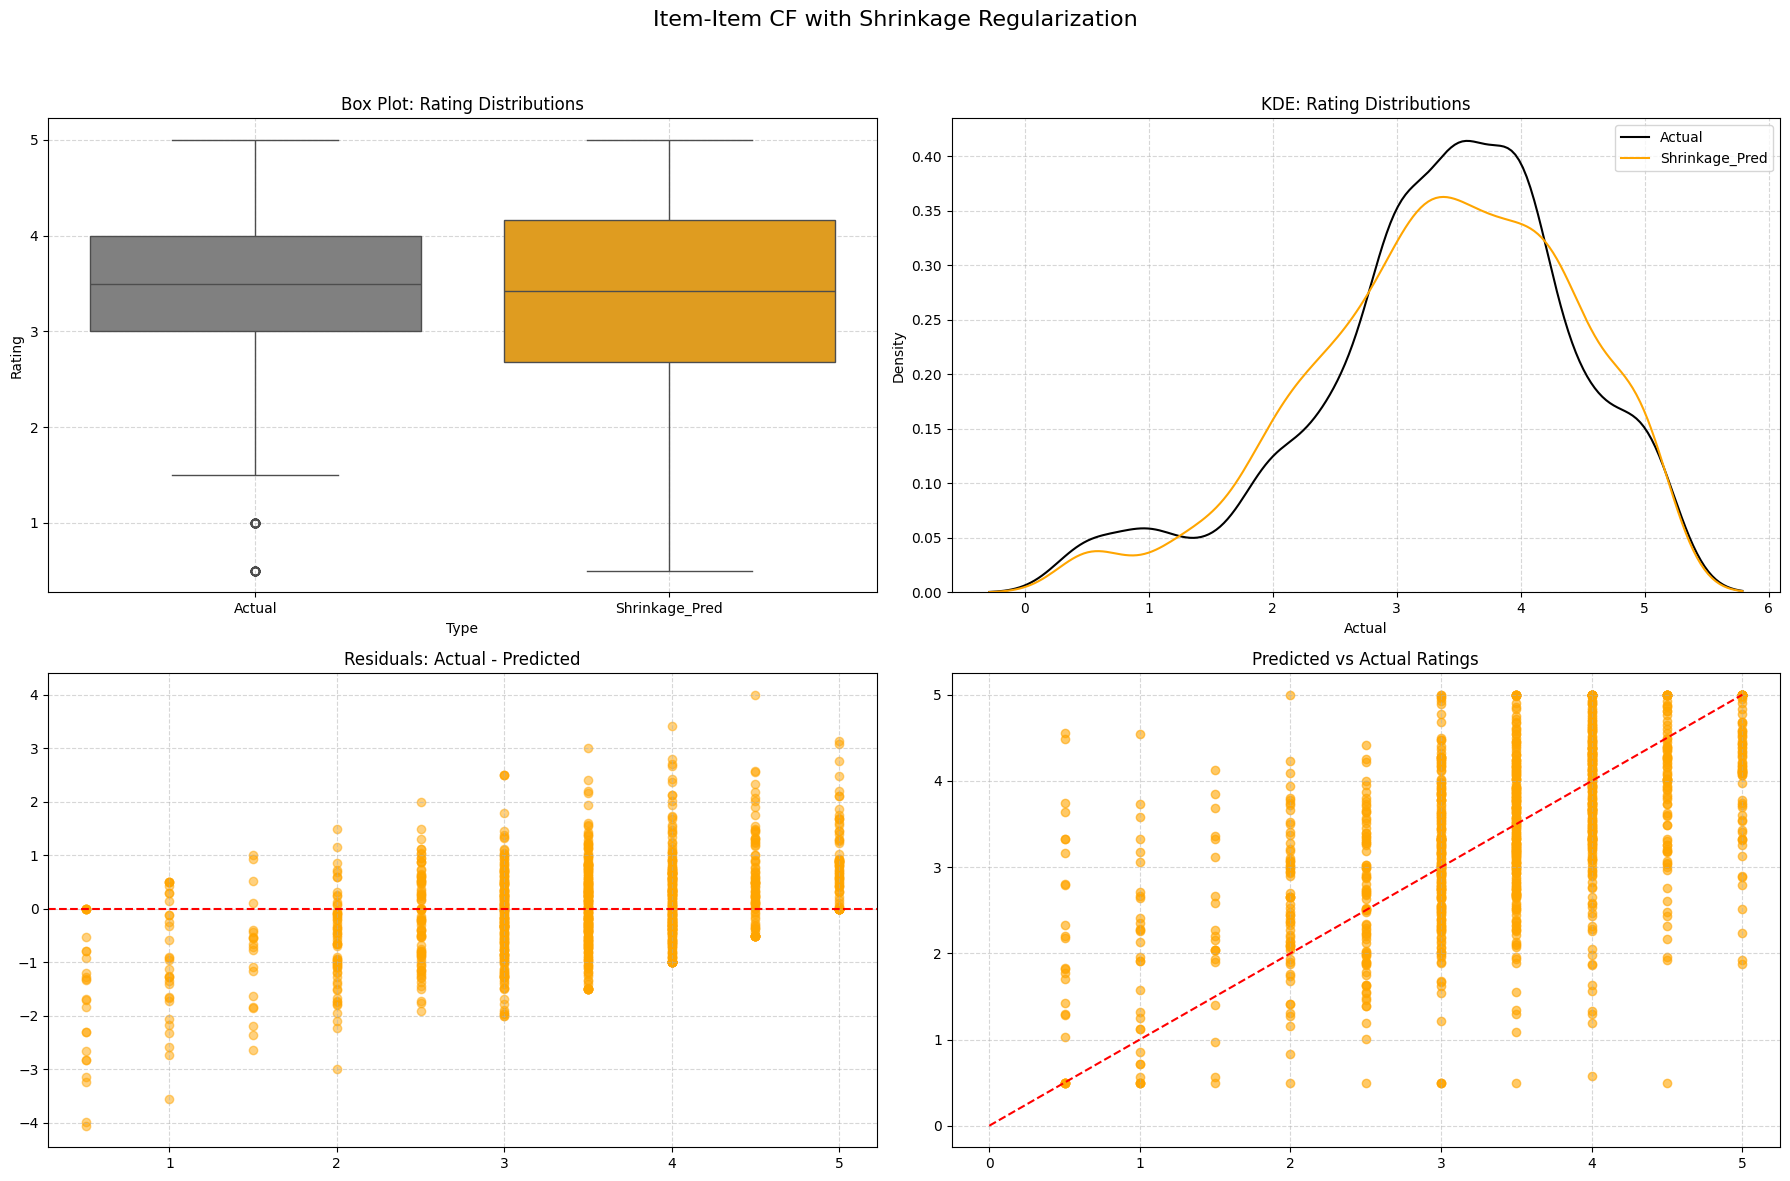

In [4]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Load and Preprocess ---
# Replace NaNs in genres column (if applicable)
stratified_df['genres'] = stratified_df['genres'].fillna('')

# Split into training and test sets
train_ratings = stratified_df.sample(frac=0.8, random_state=42)
test_ratings = stratified_df.drop(train_ratings.index)

# Create user-item matrix (rows: users, columns: movies)
user_item_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')

# --- Step 2: Compute Shrinkage-Aware Item-Item Similarity Matrix ---
from scipy.sparse import csr_matrix

def compute_shrinkage_similarity_fast(matrix, lambda_val=10):
    """
    Efficient shrinkage-aware cosine similarity using sparse matrix ops.
    """
    # Transpose and binarize the rating presence (1 if not NaN, else 0)
    binary_rated = (~matrix.T.isna()).astype(np.float32)
    sparse_rated = csr_matrix(binary_rated.values)

    # Compute co-rating counts using fast sparse dot product
    co_counts = (sparse_rated @ sparse_rated.T).toarray()

    # Fill missing values for cosine sim calculation
    matrix_filled = matrix.T.fillna(0).values.astype(np.float32)

    # Compute cosine similarity (dense)
    base_similarity = cosine_similarity(matrix_filled)

    # Shrinkage formula
    adjusted_sim = (co_counts / (co_counts + lambda_val)) * base_similarity

    return pd.DataFrame(adjusted_sim, index=matrix.columns, columns=matrix.columns)

item_item_sim_shrink_fast = compute_shrinkage_similarity_fast(user_item_matrix)

# --- Step 3: Compute Rating Statistics for Bias Correction ---
global_mean = train_ratings['rating'].mean()
item_means = train_ratings.groupby('movieId')['rating'].mean()
user_means = train_ratings.groupby('userId')['rating'].mean()

# --- Step 4: Define Shrinkage-Based Prediction Function ---
def predict_item_item_shrink(uid, mid):
    """
    Predict user rating using item-item CF with shrinkage and bias correction.
    """
    if uid not in user_item_matrix.index or mid not in item_item_sim_shrink_fast.index:
        return global_mean  # Fallback if user or movie is unknown

    sims = item_item_sim_shrink_fast[mid].drop(mid, errors='ignore')  # Similarities to other items
    rated_items = user_item_matrix.loc[uid].dropna()  # Items rated by this user
    sims = sims.loc[sims.index.intersection(rated_items.index)]  # Keep only rated items

    if sims.empty:
        # Fallback to additive user-item bias if no neighbors exist
        return user_means.get(uid, global_mean) + item_means.get(mid, global_mean) - global_mean

    ratings = rated_items[sims.index]
    weights = sims / sims.abs().sum()  # Normalize weights
    residuals = ratings - item_means[sims.index]  # Centered ratings
    weighted_sum = (weights * residuals).sum()  # Weighted residual

    user_bias = user_means.get(uid, global_mean) - global_mean
    item_bias = item_means.get(mid, global_mean) - global_mean

    return np.clip(global_mean + user_bias + item_bias + weighted_sum, 0.5, 5.0)

# --- Step 5: Parallel Prediction over Test Set ---
def predict_row(row):
    """Helper for parallel execution."""
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    pred = predict_item_item_shrink(uid, mid)
    return [uid, mid, actual, pred]

results_shrink = Parallel(n_jobs=-1)(delayed(predict_row)(row) for _, row in test_ratings.iterrows())
viz_df_shrink = pd.DataFrame(results_shrink, columns=['userId', 'movieId', 'Actual', 'Shrinkage_Pred'])

# --- Step 6: Evaluation Metrics ---
rmse = np.sqrt(mean_squared_error(viz_df_shrink['Actual'], viz_df_shrink['Shrinkage_Pred']))
mae = mean_absolute_error(viz_df_shrink['Actual'], viz_df_shrink['Shrinkage_Pred'])
r2 = r2_score(viz_df_shrink['Actual'], viz_df_shrink['Shrinkage_Pred'])

print("\nEvaluation: Item-Item CF with Shrinkage")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

# --- Step 7: Visualization ---
viz_sample = viz_df_shrink.sample(n=min(1000, len(viz_df_shrink)), random_state=42)

fig, axs = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle("Item-Item CF with Shrinkage Regularization", fontsize=16)

# Box Plot
sns.boxplot(data=viz_sample.melt(id_vars=['userId', 'movieId'], value_vars=['Actual', 'Shrinkage_Pred'],
                                  var_name='Type', value_name='Rating'),
            x='Type', y='Rating', ax=axs[0, 0], palette={'Actual': 'gray', 'Shrinkage_Pred': 'orange'})
axs[0, 0].set_title('Box Plot: Rating Distributions')
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# KDE Plot
sns.kdeplot(viz_sample['Actual'], label='Actual', color='black', ax=axs[0, 1])
sns.kdeplot(viz_sample['Shrinkage_Pred'], label='Shrinkage_Pred', color='orange', ax=axs[0, 1])
axs[0, 1].set_title('KDE: Rating Distributions')
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# Residual Plot
residuals = viz_sample['Actual'] - viz_sample['Shrinkage_Pred']
axs[1, 0].scatter(viz_sample['Actual'], residuals, alpha=0.5, color='orange')
axs[1, 0].axhline(0, color='red', linestyle='--')
axs[1, 0].set_title('Residuals: Actual - Predicted')
axs[1, 0].grid(True, linestyle='--', alpha=0.5)

# Scatter: Predicted vs Actual
axs[1, 1].scatter(viz_sample['Actual'], viz_sample['Shrinkage_Pred'], alpha=0.6, color='orange')
axs[1, 1].plot([0, 5], [0, 5], 'r--')
axs[1, 1].set_title('Predicted vs Actual Ratings')
axs[1, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Jaccard Item-Item

In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import Parallel, delayed

# --- Load and Prepare Data ---
# Assumes stratified_df is already loaded with columns: userId, movieId, rating, genres
stratified_df['genres'] = stratified_df['genres'].fillna('')

# --- Train-Test Split ---
train_ratings = stratified_df.sample(frac=0.8, random_state=42)
test_ratings = stratified_df.drop(train_ratings.index)

# --- Implicit Binary Matrix for Jaccard ---
binary_matrix = train_ratings.copy()
binary_matrix['binary_rating'] = 1
user_item_binary = binary_matrix.pivot(index='userId', columns='movieId', values='binary_rating').fillna(0)

# --- Vectorized Jaccard Similarity (Item-Item) ---
from scipy.sparse import csr_matrix
from sklearn.metrics import pairwise_distances
import heapq

def compute_jaccard_similarity_topk(matrix, topk=50):
    """
    Computes sparse item-item Jaccard similarity and keeps only top-K neighbors per item.
    Significantly faster and lower memory usage.
    """
    # Step 1: Convert to sparse binary matrix (items x users)
    binary = matrix.T.astype(bool).astype(np.uint8)  # shape: (n_items, n_users)
    sparse_binary = csr_matrix(binary.values)

    # Step 2: Compute sparse pairwise Jaccard distance (1 - similarity)
    # This is fast and memory-efficient
    dist = pairwise_distances(sparse_binary, metric='jaccard', n_jobs=-1)

    # Step 3: Convert to similarity
    sim = 1 - dist

    # Step 4: Retain only top-K similarities per item
    sim_topk = np.zeros_like(sim)
    for i in range(sim.shape[0]):
        topk_idx = np.argsort(sim[i])[-topk-1:-1]  # exclude self
        sim_topk[i, topk_idx] = sim[i, topk_idx]

    # Return as DataFrame
    return pd.DataFrame(sim_topk, index=matrix.columns, columns=matrix.columns)


# --- Prediction Function ---
def predict_jaccard(uid, mid, topn=10):
    """
    Predict a user's rating for a movie based on top-N most similar items using Jaccard similarity.
    """
    if uid not in user_item_binary.index or mid not in user_item_binary.columns:
        return 3.0  # fallback average

    # Identify which items the user has interacted with
    rated_items = user_item_binary.loc[uid]
    rated_items = rated_items[rated_items > 0].index
    if len(rated_items) == 0:
        return 3.0

    # Retrieve similarities between target item and user-rated items
    sims = jaccard_sim.loc[mid, rated_items]
    sims = sims.sort_values(ascending=False).head(topn)

    if sims.sum() == 0:
        return 3.0

    # Get actual ratings from training data
    actual_ratings = train_ratings[(train_ratings['userId'] == uid) & (train_ratings['movieId'].isin(sims.index))]
    weights = sims.loc[actual_ratings['movieId']].values
    ratings = actual_ratings['rating'].values

    pred = np.dot(weights, ratings) / weights.sum()
    return np.clip(pred, 0.5, 5.0)

# --- Parallel Prediction for Test Set ---
def predict_row(row):
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    if mid not in jaccard_sim.index:
        return None  # skip items unseen in training
    pred = predict_jaccard(uid, mid)
    return [uid, mid, actual, pred]

results = Parallel(n_jobs=-1)(delayed(predict_row)(row) for _, row in test_ratings.iterrows())
results = [r for r in results if r is not None]  # remove skipped

viz_df_jaccard = pd.DataFrame(results, columns=['userId', 'movieId', 'Actual', 'Jaccard_Pred'])

# --- Evaluation Metrics ---
rmse = np.sqrt(mean_squared_error(viz_df_jaccard['Actual'], viz_df_jaccard['Jaccard_Pred']))
mae = mean_absolute_error(viz_df_jaccard['Actual'], viz_df_jaccard['Jaccard_Pred'])
r2 = r2_score(viz_df_jaccard['Actual'], viz_df_jaccard['Jaccard_Pred'])

print("\nPerformance of Jaccard Item-Item CF:")
print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

# --- Visual Diagnostics ---
viz_sample = viz_df_jaccard.sample(n=min(1000, len(viz_df_jaccard)), random_state=42)

fig, axs = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle("Evaluation of Item-Item CF (Jaccard Similarity)", fontsize=16)

# Box Plot
box_data = viz_sample[['Actual', 'Jaccard_Pred']].melt(var_name='Type', value_name='Rating')
sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette={'Actual': 'gray', 'Jaccard_Pred': 'orange'})
axs[0, 0].set_title('Box Plot: Rating Distributions')
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# KDE Plot
sns.kdeplot(viz_sample['Actual'], label='Actual', color='black', linewidth=2, ax=axs[0, 1])
sns.kdeplot(viz_sample['Jaccard_Pred'], label='Jaccard_Pred', color='orange', linewidth=2, ax=axs[0, 1])
axs[0, 1].set_title('KDE: Rating Distributions')
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# Residual Plot
residuals = viz_sample['Actual'] - viz_sample['Jaccard_Pred']
axs[1, 0].scatter(viz_sample['Actual'], residuals, alpha=0.5, color='orange')
axs[1, 0].axhline(0, color='red', linestyle='--')
axs[1, 0].set_title('Residuals: Actual - Predicted')
axs[1, 0].grid(True, linestyle='--', alpha=0.5)

# Scatter: Predicted vs Actual
axs[1, 1].scatter(viz_sample['Actual'], viz_sample['Jaccard_Pred'], alpha=0.6, color='orange')
axs[1, 1].plot([0, 5], [0, 5], 'r--')
axs[1, 1].set_title('Predicted vs Actual Ratings')
axs[1, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Jaccard

## Content-Based Jaccard Similarity-Based Recommender

This method modifies the genre-only content-based model by replacing cosine similarity with **Jaccard similarity**, which is more appropriate for comparing binary (multi-hot) genre vectors.

**Jaccard Similarity Definition**

For two binary vectors $A$ and $B$:

$$
\text{Jaccard}(A, B) = \frac{|A \cap B|}{|A \cup B|} = \frac{A \cdot B}{\|A\|_1 + \|B\|_1 - A \cdot B}
$$

Where:

* $A \cdot B$ is the count of shared genres (intersection)
* $\|A\|_1$, $\|B\|_1$ are the number of genres for each movie (L1 norm)

**Jaccard Similarity Matrix Construction**

We compute a symmetric Jaccard similarity matrix for all movie pairs using their one-hot encoded genre vectors:

$$
\text{Jaccard\_Sim}_{i,j} = \frac{\sum_k G_{ik} \cdot G_{jk}}{\sum_k \max(G_{ik}, G_{jk})}
$$

**Jaccard-Based Prediction**

For a target movie $m$, the predicted rating is the mean of the known ratings of its top-k most similar neighbors (by Jaccard score):

$$
\hat{r}_m = \frac{1}{k} \sum_{j \in \text{Top-}k(m)} r_j
$$

This prediction is user-independent and based purely on genre overlap.

**Use Case**

Jaccard-based similarity is especially useful when genre vectors are sparse and unordered. It emphasizes shared genres relative to total genres and is robust to movies with few or many genre tags.


Genre-Only Prediction (Jaccard): 100%|██████████| 394/394 [00:00<00:00, 528.04it/s]


                   RMSE     MAE      R2
UserItem_Biased  0.9508  0.7141  0.0658
GenreOnly        1.2502  1.0577 -0.6152


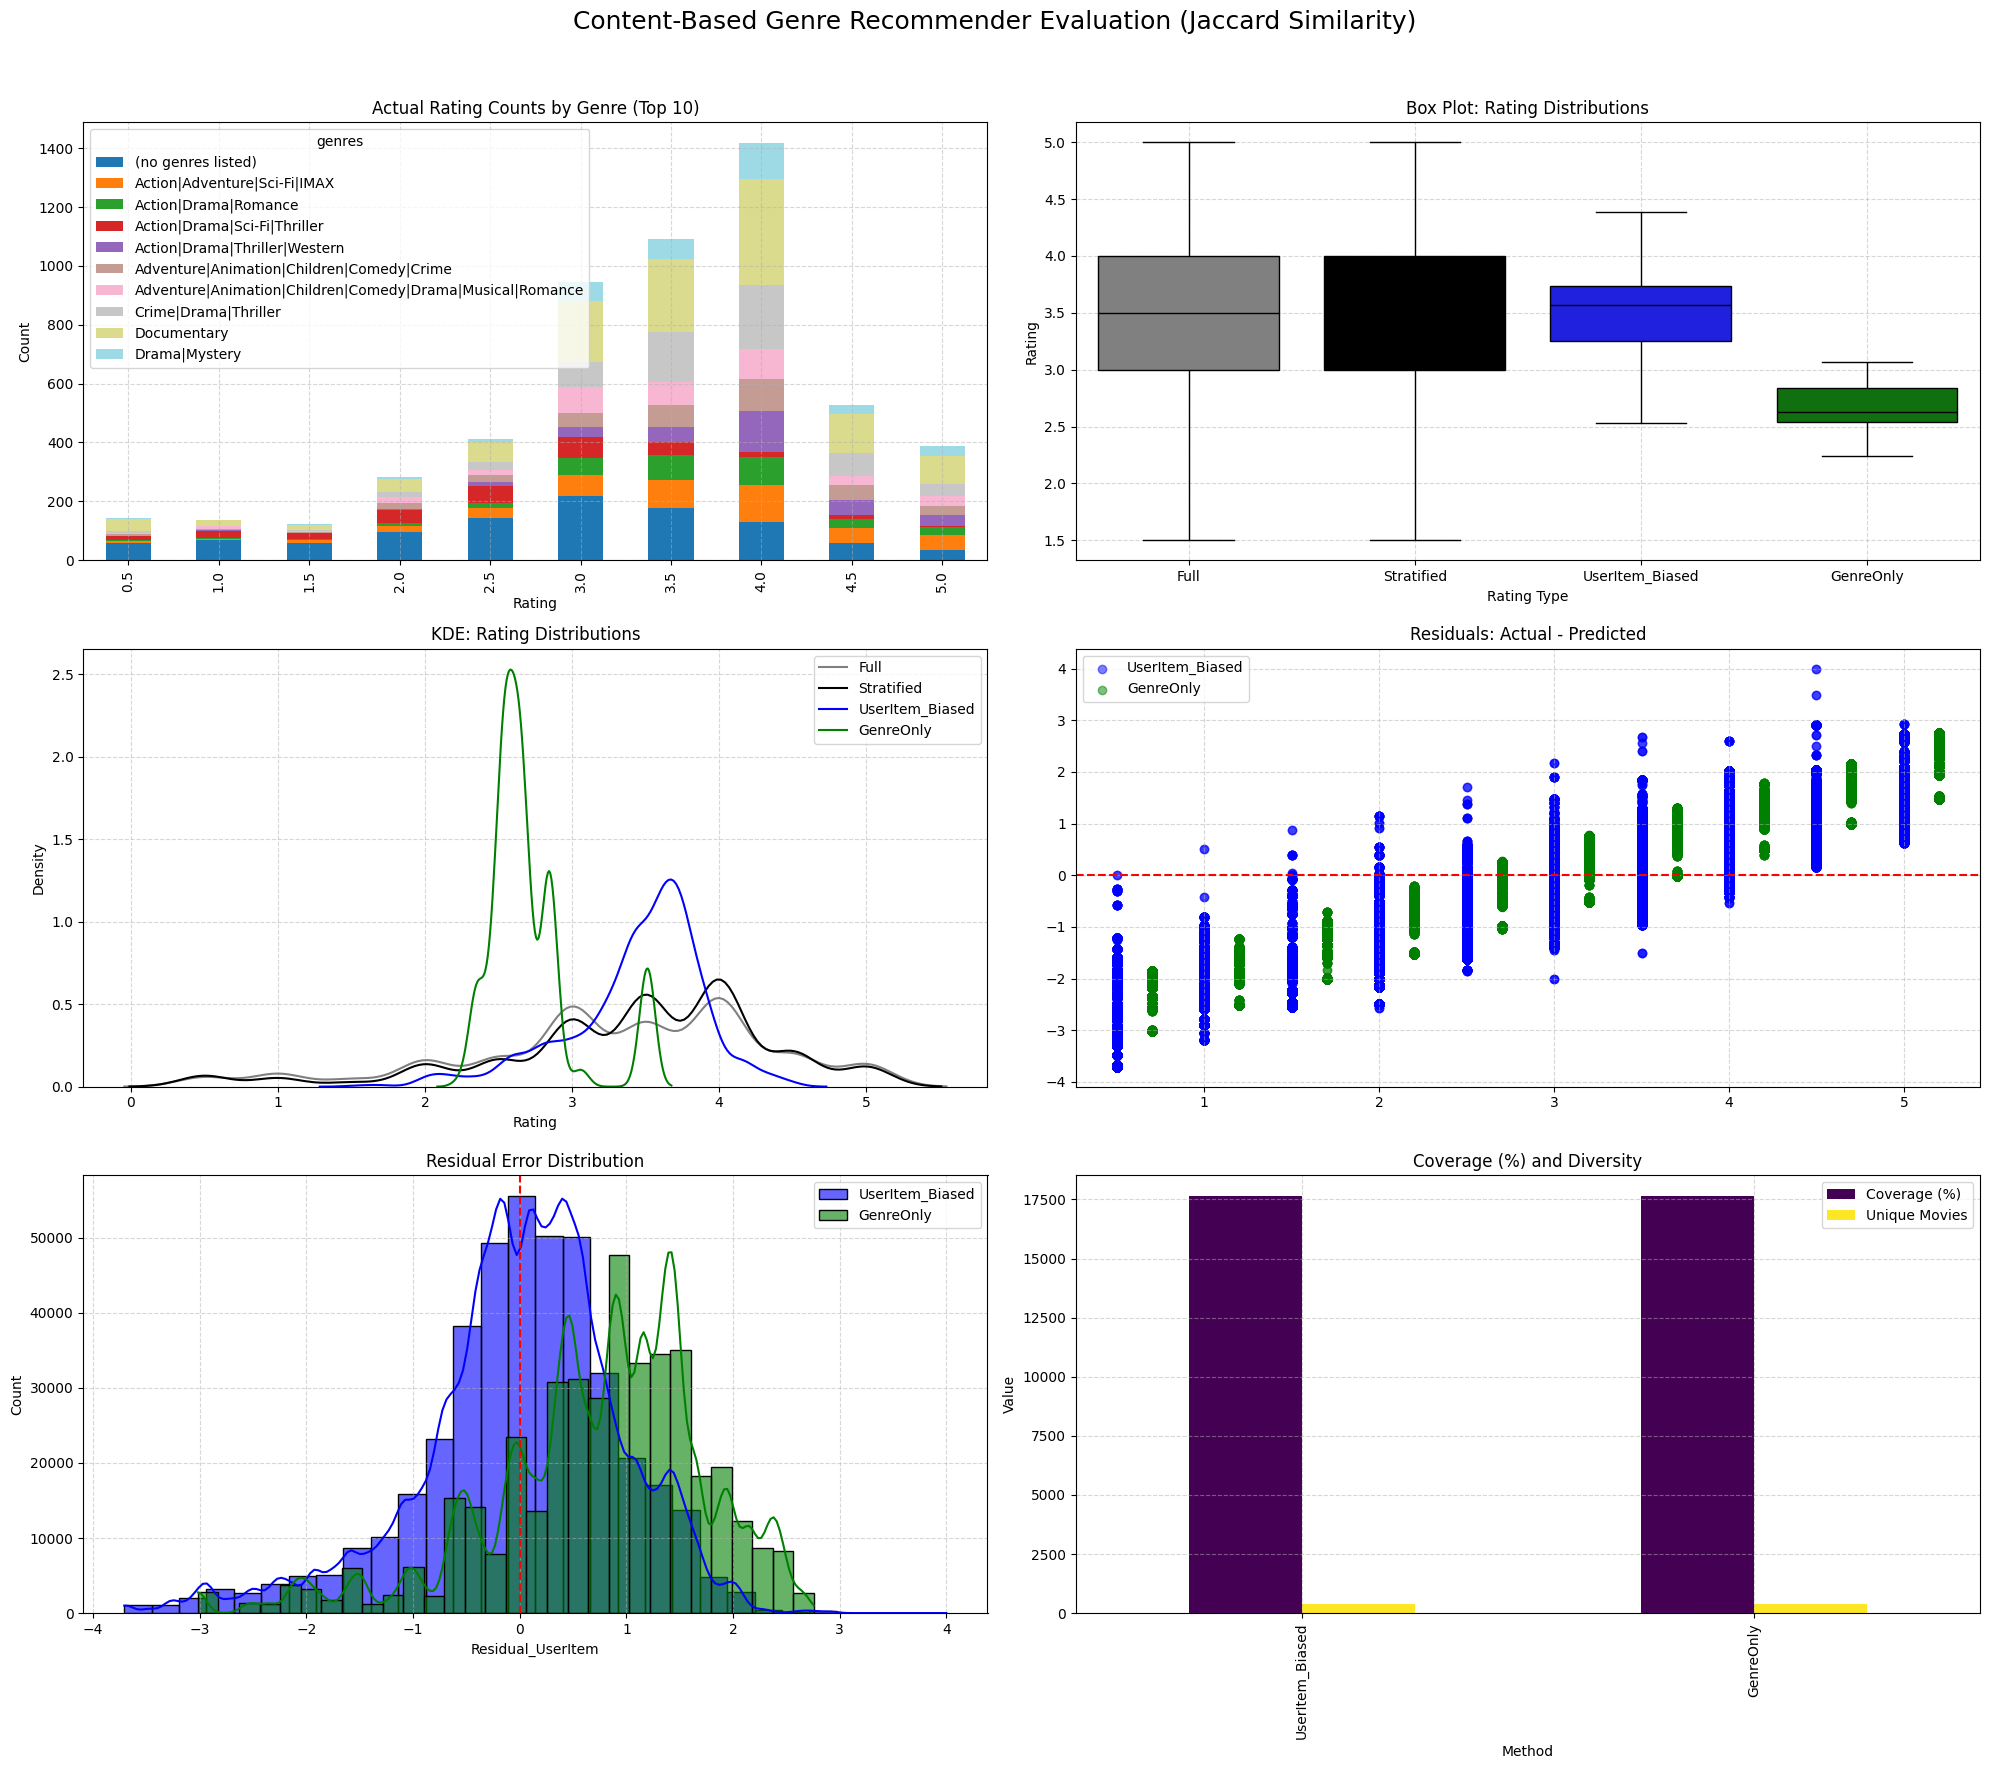

In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

warnings.filterwarnings("ignore")

# --- Step 1: Data Prep ---
stratified_df['genres'] = stratified_df['genres'].fillna('')

movie_genres = stratified_df[['movieId', 'genres']].drop_duplicates()
genre_onehot = movie_genres['genres'].str.get_dummies(sep='|')
genre_onehot.index = movie_genres['movieId']

user_movie_matrix = train_ratings.pivot_table(index='userId', columns='movieId', values='rating', aggfunc='mean')
global_mean = train_ratings['rating'].mean()
movie_means = train_ratings.groupby('movieId')['rating'].mean()
user_means = train_ratings.groupby('userId')['rating'].mean()

# --- Step 2: User Profile Builder ---
def build_profile(uid):
    if uid not in user_movie_matrix.index:
        return None
    ratings = user_movie_matrix.loc[uid].dropna()
    genre_vectors = genre_onehot.loc[genre_onehot.index.intersection(ratings.index)]
    if genre_vectors.empty:
        return None
    weights = ratings - ratings.mean()
    return np.dot(weights, genre_vectors) / weights.sum()

# --- Step 3: User-Item Biased Predictor ---
def predict_user_item_biased(uid, mid):
    if uid not in user_movie_matrix.index or mid not in genre_onehot.index:
        return global_mean
    profile = build_profile(uid)
    if profile is None:
        return movie_means.get(mid, global_mean)
    movie_vec = genre_onehot.loc[mid].values
    sim = np.dot(profile, movie_vec) / (np.linalg.norm(profile) * np.linalg.norm(movie_vec))
    sim = 0 if np.isnan(sim) else sim
    item_bias = movie_means.get(mid, global_mean) - global_mean
    return np.clip(global_mean + item_bias + sim, 0.5, 5.0)

# --- Step 4: Jaccard Similarity Matrix ---
def jaccard_similarity_matrix(binary_matrix):
    A = binary_matrix.values.astype(bool)
    intersection = np.dot(A, A.T)
    row_sums = A.sum(axis=1, keepdims=True)
    union = row_sums + row_sums.T - intersection
    return intersection / union

jaccard_sim_df = pd.DataFrame(jaccard_similarity_matrix(genre_onehot), index=genre_onehot.index, columns=genre_onehot.index)

def genre_only_prediction_jaccard(mid_list, topn=10):
    preds = {}
    for mid in tqdm(mid_list, desc="Genre-Only Prediction (Jaccard)"):
        if mid not in jaccard_sim_df.index:
            preds[mid] = global_mean
            continue
        neighbors = jaccard_sim_df.loc[mid].drop(mid).nlargest(topn)
        valid_neighbors = neighbors.index.intersection(movie_means.index)
        preds[mid] = movie_means[valid_neighbors].mean() if not valid_neighbors.empty else global_mean
    return pd.Series(preds)

# --- Step 5: Generate Predictions ---
test_movie_ids = test_ratings['movieId'].unique()
genre_only_preds = genre_only_prediction_jaccard(test_movie_ids)

results = []
for _, row in test_ratings.iterrows():
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    if mid not in genre_onehot.index:
        continue
    pred_ui = predict_user_item_biased(uid, mid)
    pred_go = genre_only_preds.get(mid, global_mean)
    results.append([uid, mid, actual, pred_ui, pred_go])

viz_stratified = pd.DataFrame(results, columns=['userId', 'movieId', 'Stratified', 'UserItem_Biased', 'GenreOnly'])
viz_stratified = viz_stratified.merge(stratified_df[['movieId', 'genres']], on='movieId', how='left').fillna({'genres': '(no genres listed)'})

# --- Step 6: Format Data ---
def format_predictions(df, column, label):
    out = df[['userId', 'movieId', column]].rename(columns={column: 'Rating'})
    out['Prediction_Type'] = label
    return out

viz_full = stratified_df[['userId', 'movieId', 'rating', 'genres']].copy()
viz_full.rename(columns={'rating': 'Rating'}, inplace=True)
viz_full['Prediction_Type'] = 'Full'
viz_full['genres'].fillna('(no genres listed)', inplace=True)

viz_all = pd.concat([
    viz_full,
    format_predictions(viz_stratified, 'Stratified', 'Stratified'),
    format_predictions(viz_stratified, 'UserItem_Biased', 'UserItem_Biased'),
    format_predictions(viz_stratified, 'GenreOnly', 'GenreOnly')
], ignore_index=True)

def uniform_downsample(df, max_per_group=1000):
    return df.groupby('Prediction_Type', group_keys=False).apply(
        lambda x: x.sample(n=min(len(x), max_per_group), random_state=42)
    ).reset_index(drop=True)

viz_all_sampled = uniform_downsample(viz_all)

# --- Step 7: Metrics, Residuals, Coverage, Diversity ---
def compute_metrics(actual, predicted):
    return {
        'RMSE': np.sqrt(mean_squared_error(actual, predicted)),
        'MAE': mean_absolute_error(actual, predicted),
        'R2': r2_score(actual, predicted)
    }

metrics_df = pd.DataFrame({
    'UserItem_Biased': compute_metrics(viz_stratified['Stratified'], viz_stratified['UserItem_Biased']),
    'GenreOnly': compute_metrics(viz_stratified['Stratified'], viz_stratified['GenreOnly'])
}).T.round(4)
print(metrics_df)

viz_stratified['Residual_UserItem'] = viz_stratified['Stratified'] - viz_stratified['UserItem_Biased']
viz_stratified['Residual_GenreOnly'] = viz_stratified['Stratified'] - viz_stratified['GenreOnly']

coverage = pd.DataFrame({
    'Method': ['UserItem_Biased', 'GenreOnly'],
    'Coverage (%)': [
        100 * viz_stratified['UserItem_Biased'].notna().sum() / len(test_ratings),
        100 * viz_stratified['GenreOnly'].notna().sum() / len(test_ratings)
    ],
    'Unique Movies': [
        viz_stratified.loc[viz_stratified['UserItem_Biased'].notna(), 'movieId'].nunique(),
        viz_stratified.loc[viz_stratified['GenreOnly'].notna(), 'movieId'].nunique()
    ]
})

# --- Step 8: Faceted Plots ---
fig, axs = plt.subplots(3, 2, figsize=(20, 18))
fig.suptitle('Content-Based Genre Recommender Evaluation (Jaccard Similarity)', fontsize=18)

top_genres = viz_full['genres'].value_counts().nlargest(10).index
viz_top = viz_full[viz_full['genres'].isin(top_genres)]
genre_rating_counts = viz_top.groupby(['Rating', 'genres']).size().unstack().fillna(0)
genre_rating_counts.plot(kind='bar', stacked=True, ax=axs[0, 0], colormap='tab20')
axs[0, 0].set_title('Actual Rating Counts by Genre (Top 10)')
axs[0, 0].set_xlabel('Rating')
axs[0, 0].set_ylabel('Count')
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

sns.boxplot(
    data=viz_all_sampled,
    x='Prediction_Type',
    y='Rating',
    showfliers=False,
    order=['Full', 'Stratified', 'UserItem_Biased', 'GenreOnly'],
    palette={'Full': 'gray', 'Stratified': 'black', 'UserItem_Biased': 'blue', 'GenreOnly': 'green'},
    ax=axs[0, 1]
)
axs[0, 1].set_title('Box Plot: Rating Distributions')
axs[0, 1].set_xlabel('Rating Type')
axs[0, 1].set_ylabel('Rating')
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

for label, color in [('Full', 'gray'), ('Stratified', 'black'), ('UserItem_Biased', 'blue'), ('GenreOnly', 'green')]:
    subset = viz_all_sampled[viz_all_sampled['Prediction_Type'] == label]['Rating']
    if len(subset) > 1:
        sns.kdeplot(subset, label=label, color=color, linewidth=1.5, bw_adjust=0.7, ax=axs[1, 0])
axs[1, 0].set_title('KDE: Rating Distributions')
axs[1, 0].set_xlabel('Rating')
axs[1, 0].legend()
axs[1, 0].grid(True, linestyle='--', alpha=0.5)

axs[1, 1].scatter(viz_stratified['Stratified'], viz_stratified['Residual_UserItem'], alpha=0.5, color='blue', label='UserItem_Biased')
axs[1, 1].scatter(viz_stratified['Stratified'] + 0.2, viz_stratified['Residual_GenreOnly'], alpha=0.5, color='green', label='GenreOnly')
axs[1, 1].axhline(0, color='red', linestyle='--')
axs[1, 1].set_title('Residuals: Actual - Predicted')
axs[1, 1].legend()
axs[1, 1].grid(True, linestyle='--', alpha=0.5)

sns.histplot(viz_stratified['Residual_UserItem'], kde=True, bins=30, color='blue', label='UserItem_Biased', alpha=0.6, ax=axs[2, 0])
sns.histplot(viz_stratified['Residual_GenreOnly'], kde=True, bins=30, color='green', label='GenreOnly', alpha=0.6, ax=axs[2, 0])
axs[2, 0].axvline(0, color='red', linestyle='--')
axs[2, 0].set_title('Residual Error Distribution')
axs[2, 0].legend()
axs[2, 0].grid(True, linestyle='--', alpha=0.5)

coverage.set_index('Method').plot(kind='bar', ax=axs[2, 1], colormap='viridis')
axs[2, 1].set_title('Coverage (%) and Diversity')
axs[2, 1].set_ylabel('Value')
axs[2, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Evaluation Summary: Jaccard Similarity vs. User-Item Biased Approach

* **Jaccard-Based GenreOnly**

  * Struggles with sparse genre vectors—Jaccard treats all overlaps equally, missing deeper contextual relevance.
  * Consistently underestimates ratings, especially for mid-to-high-rated movies (seen in residuals and KDE plot).
  * Narrow, peaked prediction distributions indicate poor generalization.
  * Fails to account for user preferences—produces same prediction for every user.

* **UserItem\_Biased Approach**

  * Incorporates both user-specific genre profiles and item-level average bias.
  * Adapts to individual rating tendencies, leading to better-aligned predictions.
  * Residuals are tighter and more symmetric, indicating stronger calibration.


## TF-IDF Conent-Based Recommender (Cosine Similarity)

This method uses term frequency–inverse document frequency (TF-IDF) to represent movie genres as weighted vectors, followed by cosine similarity to quantify content-based closeness between movies.

**Key Formulae:**

1. **TF-IDF Weighting**
   For a genre term $t$ in movie $m$:

$$
\text{TF-IDF}_{t,m} = \text{TF}_{t,m} \cdot \log \left( \frac{N}{\text{DF}_t} \right)
$$

Where:

* $\text{TF}_{t,m}$ is the term frequency of genre $t$ in movie $m$ (usually binary).
* $\text{DF}_t$ is the number of movies containing genre $t$.
* $N$ is the total number of movies.

2. **Cosine Similarity Between Two Movies**

$$
\text{cosine_sim}(i, j) = \frac{\vec{v}_i \cdot \vec{v}_j}{\|\vec{v}_i\| \cdot \|\vec{v}_j\|}
$$

Where $\vec{v}_i$ and $\vec{v}_j$ are the TF-IDF vectors for movies $i$ and $j$.

**Prediction Logic (Genre-Only):**

* For a test movie $m$, retrieve its top-N most similar movies $\{n_1, n_2, \dots, n_N\}$ using cosine similarity.
* Predict rating as the average of their known mean ratings:

$$
\hat{r}_m = \frac{1}{N} \sum_{k=1}^N \bar{r}_{n_k}
$$

**Prediction Logic (User-Item Biased TF-IDF):**

* Let $\vec{p}_u$ be user $u$’s profile (weighted sum of TF-IDF genre vectors of rated movies).
* Predict user $u$'s rating for movie $m$ as:

$$
\hat{r}_{u,m} = \mu + b_m + \alpha \cdot \text{cosine_sim}(\vec{p}_u, \vec{v}_m)
$$

Where:

* $\mu$ is the global mean rating,
* $b_m = \bar{r}_m - \mu$ is the item bias.

This approach benefits from TF-IDF’s ability to down-weight common genres, emphasizing more distinctive content signals in similarity computation.


Genre-Only Prediction (TF-IDF): 100%|██████████| 394/394 [00:03<00:00, 115.84it/s]


                   RMSE     MAE      R2
UserItem_Biased  0.9445  0.7104  0.0781
GenreOnly        1.1170  0.8990 -0.2893


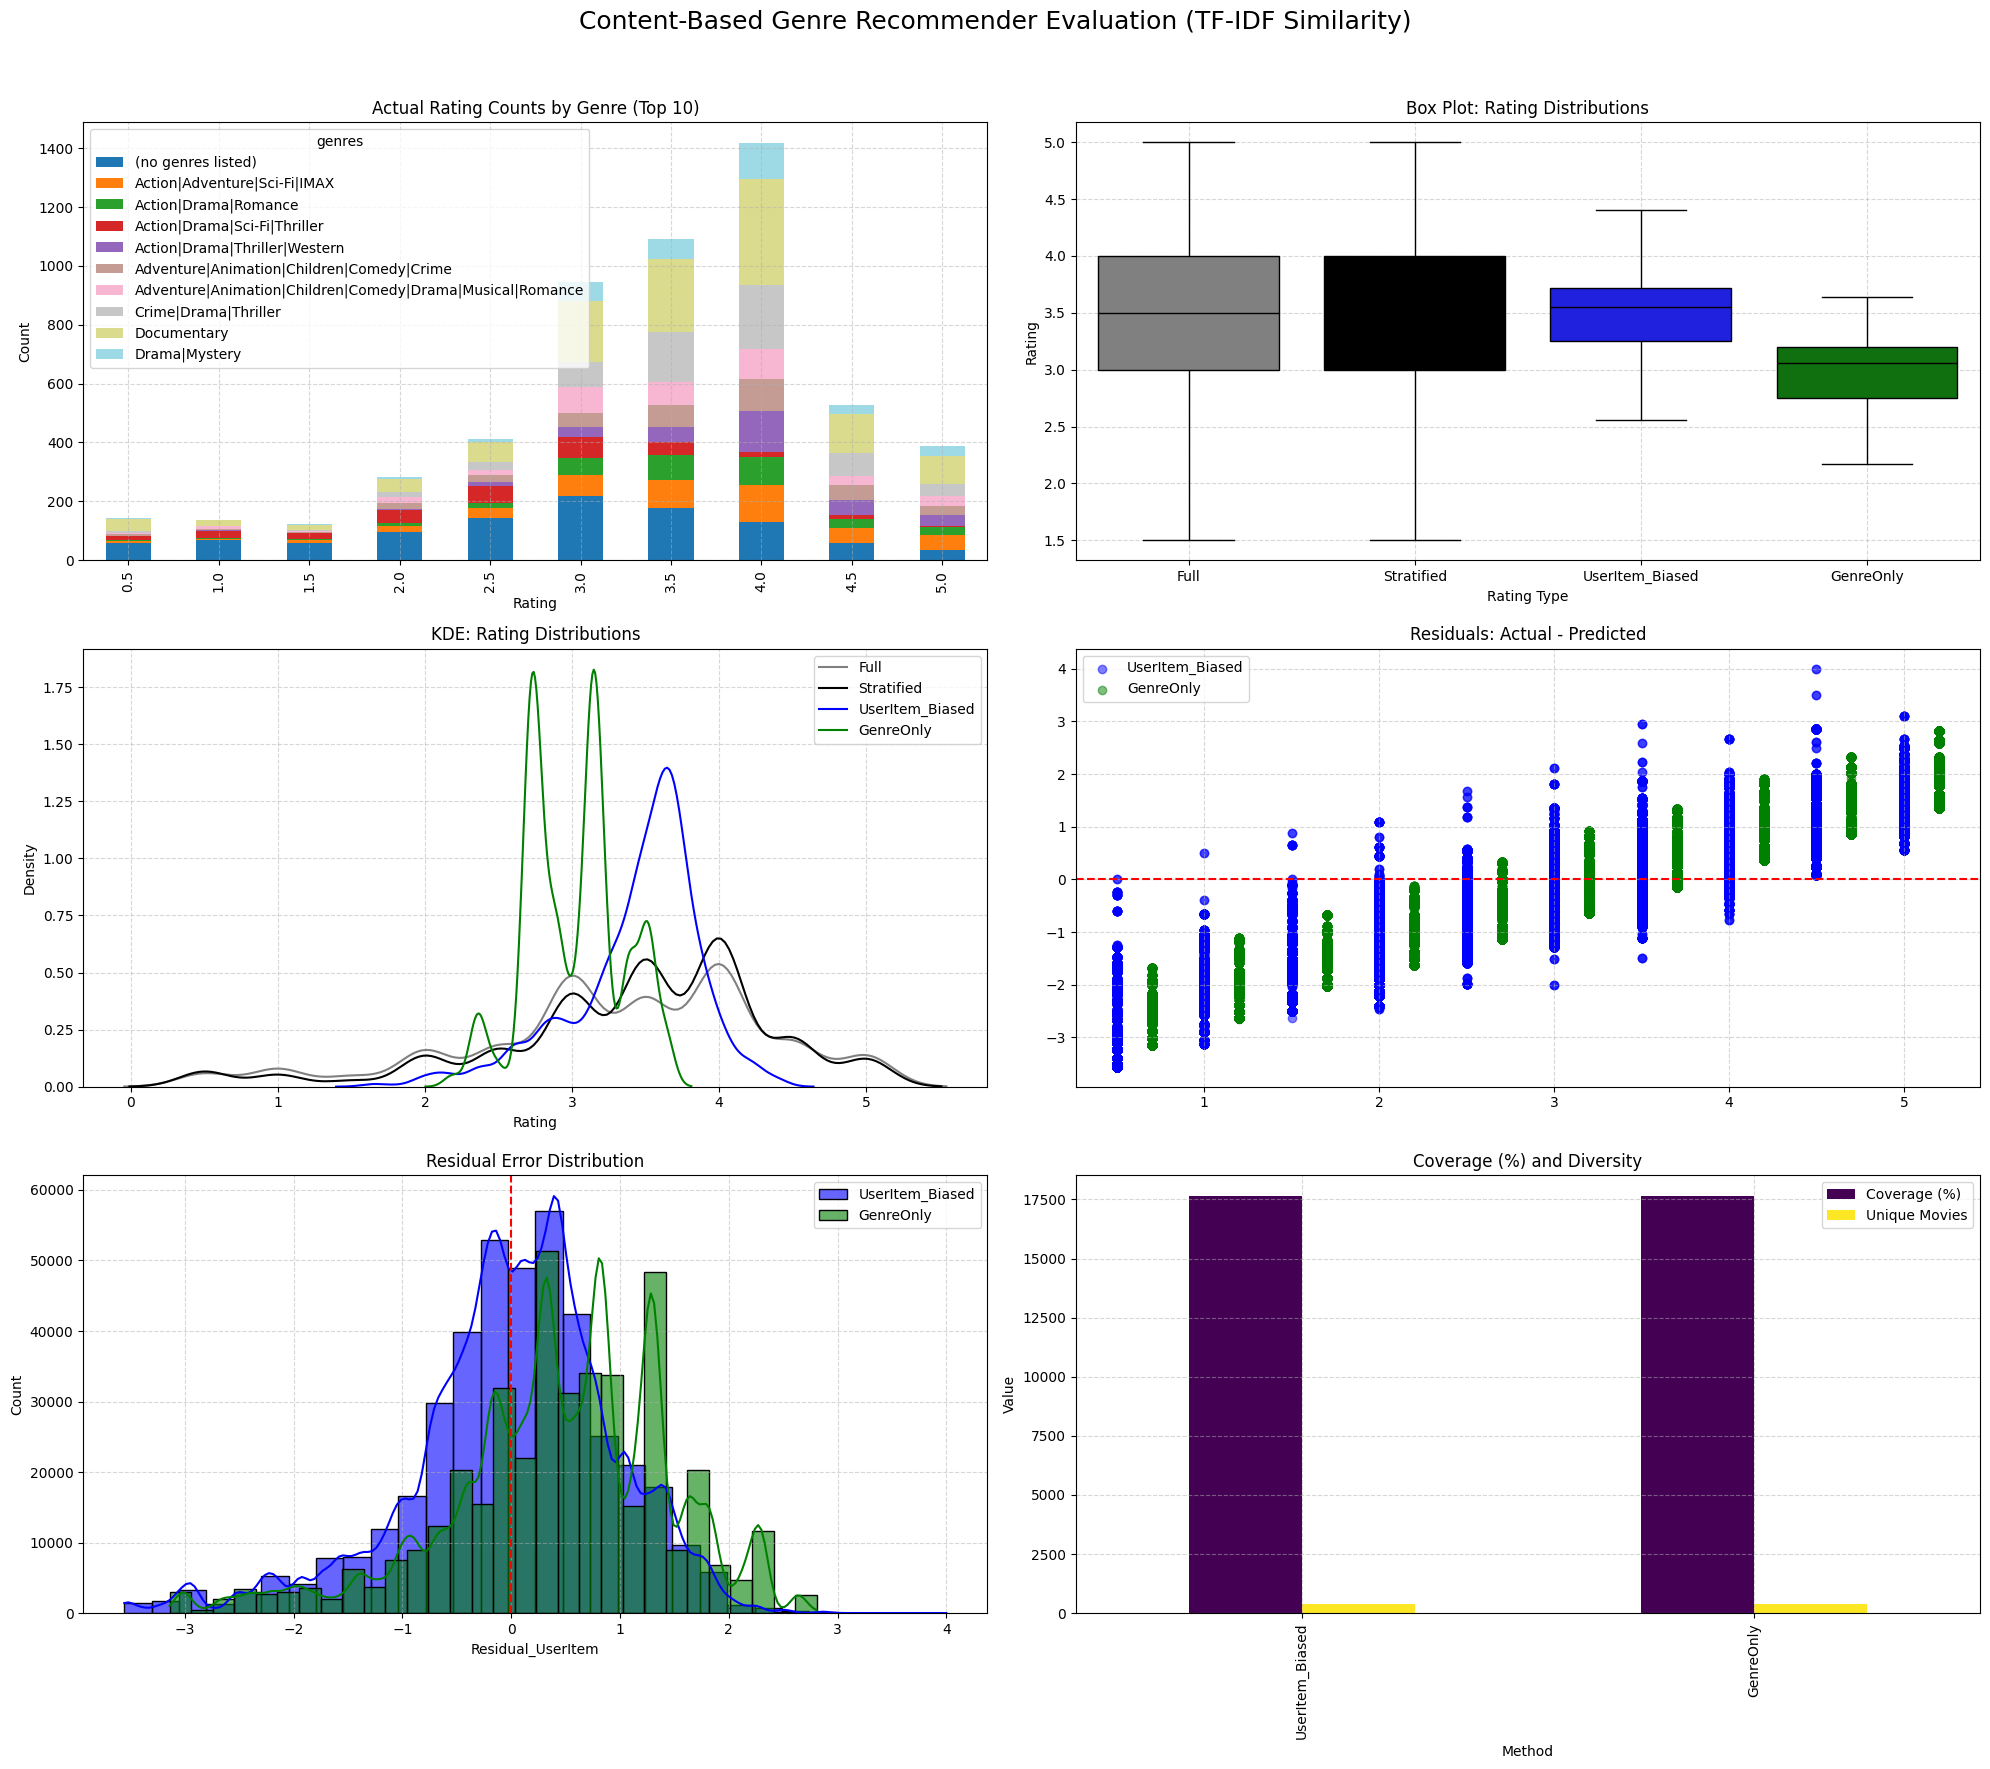

In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

warnings.filterwarnings("ignore")

# --- Step 1: Data Prep ---
stratified_df['genres'] = stratified_df['genres'].fillna('')

movie_genres = stratified_df[['movieId', 'genres']].drop_duplicates()
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split('|'))
tfidf_matrix = tfidf_vectorizer.fit_transform(movie_genres['genres'])
genre_tfidf = pd.DataFrame(tfidf_matrix.toarray(), index=movie_genres['movieId'], columns=tfidf_vectorizer.get_feature_names_out())

user_movie_matrix = train_ratings.pivot_table(index='userId', columns='movieId', values='rating', aggfunc='mean')
global_mean = train_ratings['rating'].mean()
movie_means = train_ratings.groupby('movieId')['rating'].mean()
user_means = train_ratings.groupby('userId')['rating'].mean()

# --- Step 2: User Profile Builder ---
def build_profile(uid):
    if uid not in user_movie_matrix.index:
        return None
    ratings = user_movie_matrix.loc[uid].dropna()
    genre_vectors = genre_tfidf.loc[genre_tfidf.index.intersection(ratings.index)]
    if genre_vectors.empty:
        return None
    weights = ratings - ratings.mean()
    return np.dot(weights, genre_vectors) / weights.sum()

# --- Step 3: User-Item Biased Predictor ---
def predict_user_item_biased(uid, mid):
    if uid not in user_movie_matrix.index or mid not in genre_tfidf.index:
        return global_mean
    profile = build_profile(uid)
    if profile is None:
        return movie_means.get(mid, global_mean)
    movie_vec = genre_tfidf.loc[mid].values
    sim = np.dot(profile, movie_vec) / (np.linalg.norm(profile) * np.linalg.norm(movie_vec))
    sim = 0 if np.isnan(sim) else sim
    item_bias = movie_means.get(mid, global_mean) - global_mean
    return np.clip(global_mean + item_bias + sim, 0.5, 5.0)

# --- Step 4: TF-IDF Cosine Similarity Matrix ---
cos_sim_df = pd.DataFrame(cosine_similarity(genre_tfidf), index=genre_tfidf.index, columns=genre_tfidf.index)

def genre_only_prediction_tfidf(mid_list, topn=10):
    preds = {}
    for mid in tqdm(mid_list, desc="Genre-Only Prediction (TF-IDF)"):
        if mid not in cos_sim_df.index:
            preds[mid] = global_mean
            continue
        neighbors = cos_sim_df.loc[mid].drop(mid).nlargest(topn)
        valid_neighbors = neighbors.index.intersection(movie_means.index)
        preds[mid] = movie_means[valid_neighbors].mean() if not valid_neighbors.empty else global_mean
    return pd.Series(preds)

# --- Step 5: Generate Predictions ---
test_movie_ids = test_ratings['movieId'].unique()
genre_only_preds = genre_only_prediction_tfidf(test_movie_ids)

results = []
for _, row in test_ratings.iterrows():
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    if mid not in genre_tfidf.index:
        continue
    pred_ui = predict_user_item_biased(uid, mid)
    pred_go = genre_only_preds.get(mid, global_mean)
    results.append([uid, mid, actual, pred_ui, pred_go])

viz_stratified = pd.DataFrame(results, columns=['userId', 'movieId', 'Stratified', 'UserItem_Biased', 'GenreOnly'])
viz_stratified = viz_stratified.merge(stratified_df[['movieId', 'genres']], on='movieId', how='left').fillna({'genres': '(no genres listed)'})

# --- Step 6: Format Data ---
def format_predictions(df, column, label):
    out = df[['userId', 'movieId', column]].rename(columns={column: 'Rating'})
    out['Prediction_Type'] = label
    return out

viz_full = stratified_df[['userId', 'movieId', 'rating', 'genres']].copy()
viz_full.rename(columns={'rating': 'Rating'}, inplace=True)
viz_full['Prediction_Type'] = 'Full'
viz_full['genres'].fillna('(no genres listed)', inplace=True)

viz_all = pd.concat([
    viz_full,
    format_predictions(viz_stratified, 'Stratified', 'Stratified'),
    format_predictions(viz_stratified, 'UserItem_Biased', 'UserItem_Biased'),
    format_predictions(viz_stratified, 'GenreOnly', 'GenreOnly')
], ignore_index=True)

def uniform_downsample(df, max_per_group=1000):
    return df.groupby('Prediction_Type', group_keys=False).apply(
        lambda x: x.sample(n=min(len(x), max_per_group), random_state=42)
    ).reset_index(drop=True)

viz_all_sampled = uniform_downsample(viz_all)

# --- Step 7: Metrics, Residuals, Coverage, Diversity ---
def compute_metrics(actual, predicted):
    return {
        'RMSE': np.sqrt(mean_squared_error(actual, predicted)),
        'MAE': mean_absolute_error(actual, predicted),
        'R2': r2_score(actual, predicted)
    }

metrics_df = pd.DataFrame({
    'UserItem_Biased': compute_metrics(viz_stratified['Stratified'], viz_stratified['UserItem_Biased']),
    'GenreOnly': compute_metrics(viz_stratified['Stratified'], viz_stratified['GenreOnly'])
}).T.round(4)
print(metrics_df)

viz_stratified['Residual_UserItem'] = viz_stratified['Stratified'] - viz_stratified['UserItem_Biased']
viz_stratified['Residual_GenreOnly'] = viz_stratified['Stratified'] - viz_stratified['GenreOnly']

coverage = pd.DataFrame({
    'Method': ['UserItem_Biased', 'GenreOnly'],
    'Coverage (%)': [
        100 * viz_stratified['UserItem_Biased'].notna().sum() / len(test_ratings),
        100 * viz_stratified['GenreOnly'].notna().sum() / len(test_ratings)
    ],
    'Unique Movies': [
        viz_stratified.loc[viz_stratified['UserItem_Biased'].notna(), 'movieId'].nunique(),
        viz_stratified.loc[viz_stratified['GenreOnly'].notna(), 'movieId'].nunique()
    ]
})

# --- Step 8: Faceted Plots ---
fig, axs = plt.subplots(3, 2, figsize=(20, 18))
fig.suptitle('Content-Based Genre Recommender Evaluation (TF-IDF Similarity)', fontsize=18)

top_genres = viz_full['genres'].value_counts().nlargest(10).index
viz_top = viz_full[viz_full['genres'].isin(top_genres)]
genre_rating_counts = viz_top.groupby(['Rating', 'genres']).size().unstack().fillna(0)
genre_rating_counts.plot(kind='bar', stacked=True, ax=axs[0, 0], colormap='tab20')
axs[0, 0].set_title('Actual Rating Counts by Genre (Top 10)')
axs[0, 0].set_xlabel('Rating')
axs[0, 0].set_ylabel('Count')
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

sns.boxplot(
    data=viz_all_sampled,
    x='Prediction_Type',
    y='Rating',
    showfliers=False,
    order=['Full', 'Stratified', 'UserItem_Biased', 'GenreOnly'],
    palette={'Full': 'gray', 'Stratified': 'black', 'UserItem_Biased': 'blue', 'GenreOnly': 'green'},
    ax=axs[0, 1]
)
axs[0, 1].set_title('Box Plot: Rating Distributions')
axs[0, 1].set_xlabel('Rating Type')
axs[0, 1].set_ylabel('Rating')
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

for label, color in [('Full', 'gray'), ('Stratified', 'black'), ('UserItem_Biased', 'blue'), ('GenreOnly', 'green')]:
    subset = viz_all_sampled[viz_all_sampled['Prediction_Type'] == label]['Rating']
    if len(subset) > 1:
        sns.kdeplot(subset, label=label, color=color, linewidth=1.5, bw_adjust=0.7, ax=axs[1, 0])
axs[1, 0].set_title('KDE: Rating Distributions')
axs[1, 0].set_xlabel('Rating')
axs[1, 0].legend()
axs[1, 0].grid(True, linestyle='--', alpha=0.5)

axs[1, 1].scatter(viz_stratified['Stratified'], viz_stratified['Residual_UserItem'], alpha=0.5, color='blue', label='UserItem_Biased')
axs[1, 1].scatter(viz_stratified['Stratified'] + 0.2, viz_stratified['Residual_GenreOnly'], alpha=0.5, color='green', label='GenreOnly')
axs[1, 1].axhline(0, color='red', linestyle='--')
axs[1, 1].set_title('Residuals: Actual - Predicted')
axs[1, 1].legend()
axs[1, 1].grid(True, linestyle='--', alpha=0.5)

sns.histplot(viz_stratified['Residual_UserItem'], kde=True, bins=30, color='blue', label='UserItem_Biased', alpha=0.6, ax=axs[2, 0])
sns.histplot(viz_stratified['Residual_GenreOnly'], kde=True, bins=30, color='green', label='GenreOnly', alpha=0.6, ax=axs[2, 0])
axs[2, 0].axvline(0, color='red', linestyle='--')
axs[2, 0].set_title('Residual Error Distribution')
axs[2, 0].legend()
axs[2, 0].grid(True, linestyle='--', alpha=0.5)

coverage.set_index('Method').plot(kind='bar', ax=axs[2, 1], colormap='viridis')
axs[2, 1].set_title('Coverage (%) and Diversity')
axs[2, 1].set_ylabel('Value')
axs[2, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


**TF-IDF Similarity Results – Summary**

* The *UserItem\_Biased* model outperformed the *GenreOnly* baseline on all metrics, showing lower RMSE and MAE, and a positive R².
* Residual plots show that the UserItem\_Biased predictions are better centered and less dispersed than GenreOnly.
* KDE and histogram visuals confirm tighter prediction density and less error skew in the UserItem\_Biased model.
* Despite high coverage and genre diversity in both models, *GenreOnly* suffers due to lack of personalization and inability to adapt to user-specific preferences.
* The inclusion of user profiles (via TF-IDF genre weighting) meaningfully boosts performance, even without explicit user bias correction.


## Methodology: TF-Based Genre Recommender with Item Bias

This model uses raw **term frequencies (TF)** from genre tags to form both item representations and user profiles.

**Steps:**

* **Genre Representation (TF):**
  Use `CountVectorizer` to generate a movie–genre matrix based on the number of times a genre appears (i.e., raw frequency), rather than reweighting or normalizing like TF-IDF.

* **User Profile Construction:**
  For each user, build a profile vector $\vec{p}_u$ by computing a weighted average of the genre vectors of movies they’ve rated:

  $$
  \vec{p}_u = \frac{\sum_{m \in \text{rated}(u)} (r_{u,m} - \bar{r}_u) \cdot \vec{v}_m}{\sum_{m} |r_{u,m} - \bar{r}_u|}
  $$

* **Prediction Formula (User-Item Biased):**

  $$
  \hat{r}_{u,m} = \mu + b_m + \alpha \cdot \text{cosine\_sim}(\vec{p}_u, \vec{v}_m)
  $$

  Where:

  * $\mu$ = global mean
  * $b_m = \bar{r}_m - \mu$ = item bias
  * $\alpha$ is implicitly 1 (no tuning)
  * Cosine similarity is applied between $\vec{p}_u$ and $\vec{v}_m$, both derived from TF vectors.

* **GenreOnly Prediction:**
  Predict $\hat{r}_{u,m}$ using the average ratings of top-$k$ most similar movies (via cosine on TF vectors), ignoring the user.

**Key Difference:**
Unlike TF-IDF or Jaccard, this method captures **raw frequency-based co-occurrence patterns**, which can overweight frequent genres and underrepresent rarer but more informative ones. Despite its simplicity, the addition of item bias helps correct for global tendencies.


Genre-Only Prediction (TF): 100%|██████████| 394/394 [00:00<00:00, 501.20it/s]


                   RMSE     MAE      R2
UserItem_Biased  0.9508  0.7141  0.0658
GenreOnly        1.1217  0.9010 -0.3001


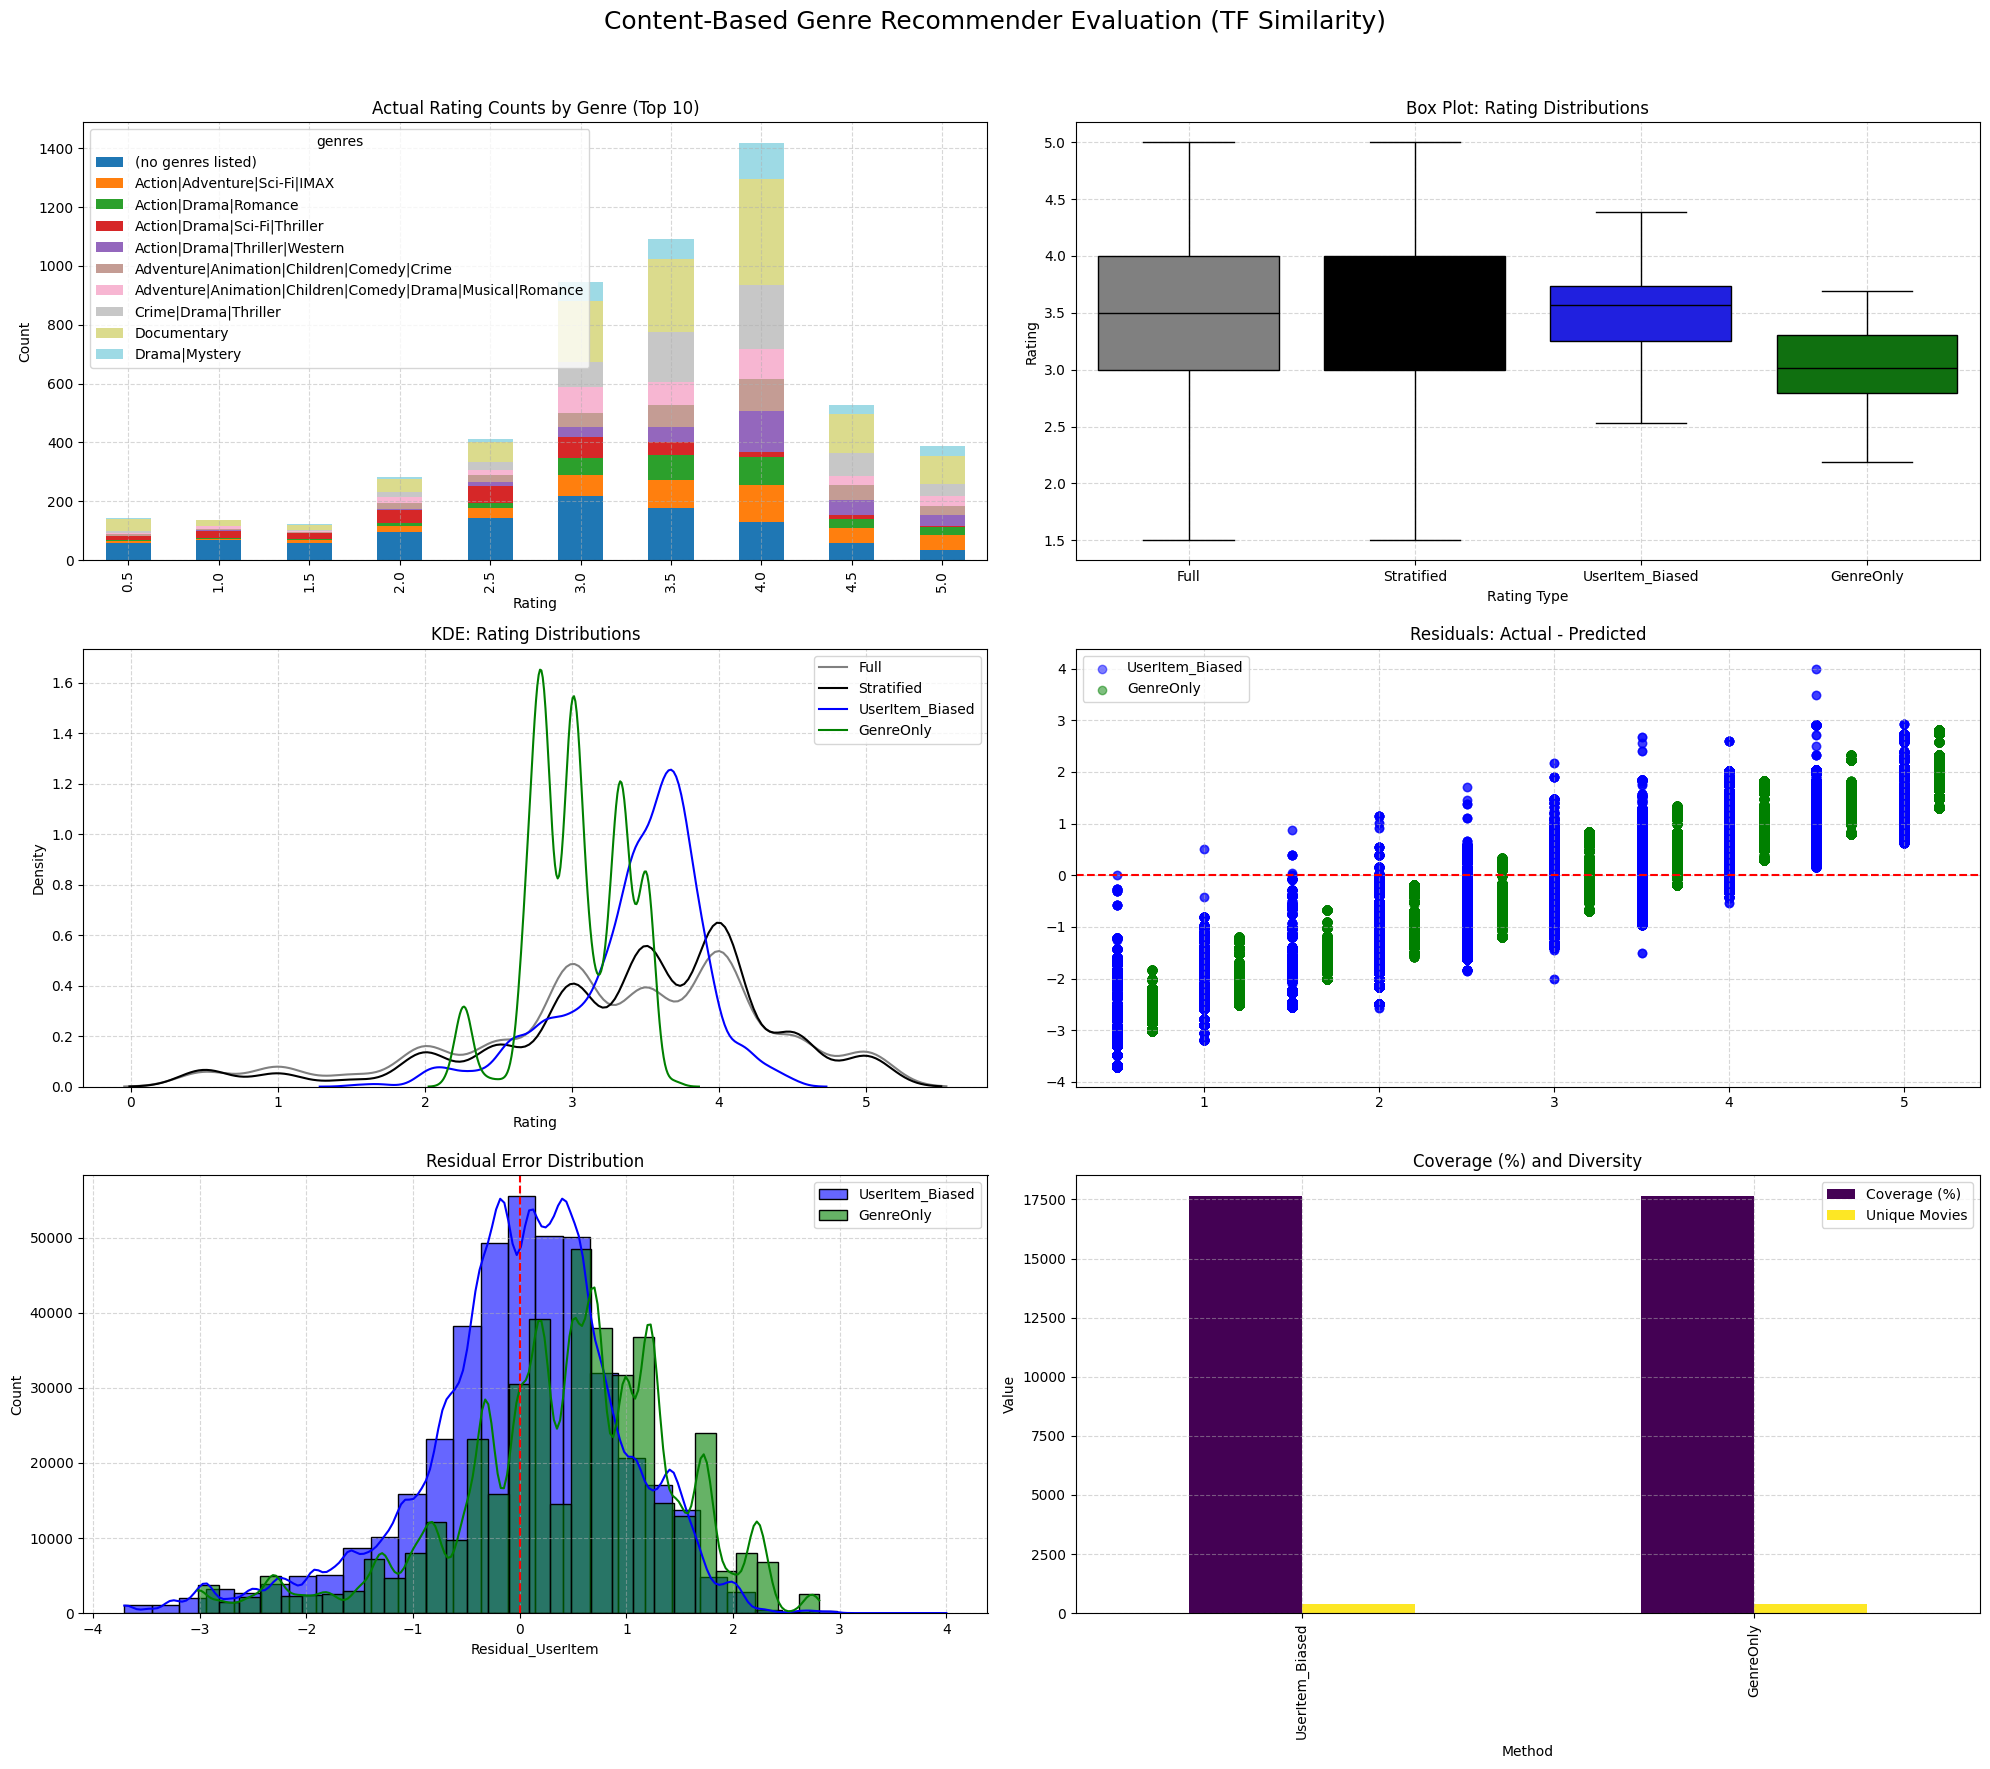

In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer
import warnings

warnings.filterwarnings("ignore")

# --- Step 1: Data Prep ---
stratified_df['genres'] = stratified_df['genres'].fillna('')

movie_genres = stratified_df[['movieId', 'genres']].drop_duplicates()
vectorizer = CountVectorizer(tokenizer=lambda x: x.split('|'))
tf_matrix = vectorizer.fit_transform(movie_genres['genres'])
tf_df = pd.DataFrame(tf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=movie_genres['movieId'])

user_movie_matrix = train_ratings.pivot_table(index='userId', columns='movieId', values='rating', aggfunc='mean')
global_mean = train_ratings['rating'].mean()
movie_means = train_ratings.groupby('movieId')['rating'].mean()

# --- Step 2: User Profile Builder (TF) ---
def build_profile_tf(uid):
    if uid not in user_movie_matrix.index:
        return None
    ratings = user_movie_matrix.loc[uid].dropna()
    genre_vectors = tf_df.loc[tf_df.index.intersection(ratings.index)]
    if genre_vectors.empty:
        return None
    weights = ratings - ratings.mean()
    return np.dot(weights, genre_vectors) / weights.sum()

# --- Step 3: User-Item Biased Predictor (TF) ---
def predict_user_item_biased_tf(uid, mid):
    if uid not in user_movie_matrix.index or mid not in tf_df.index:
        return global_mean
    profile = build_profile_tf(uid)
    if profile is None:
        return movie_means.get(mid, global_mean)
    movie_vec = tf_df.loc[mid].values
    sim = np.dot(profile, movie_vec) / (np.linalg.norm(profile) * np.linalg.norm(movie_vec))
    sim = 0 if np.isnan(sim) else sim
    item_bias = movie_means.get(mid, global_mean) - global_mean
    return np.clip(global_mean + item_bias + sim, 0.5, 5.0)

# --- Step 4: GenreOnly TF Similarity-Based Prediction ---
sim_matrix = cosine_similarity(tf_df)
sim_df = pd.DataFrame(sim_matrix, index=tf_df.index, columns=tf_df.index)

def genre_only_prediction_tf(mid_list, topn=10):
    preds = {}
    for mid in tqdm(mid_list, desc="Genre-Only Prediction (TF)"):
        if mid not in sim_df.index:
            preds[mid] = global_mean
            continue
        neighbors = sim_df.loc[mid].drop(mid).nlargest(topn)
        valid_neighbors = neighbors.index.intersection(movie_means.index)
        preds[mid] = movie_means[valid_neighbors].mean() if not valid_neighbors.empty else global_mean
    return pd.Series(preds)

# --- Step 5: Generate Predictions ---
test_movie_ids = test_ratings['movieId'].unique()
genre_only_preds = genre_only_prediction_tf(test_movie_ids)

results = []
for _, row in test_ratings.iterrows():
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    if mid not in tf_df.index:
        continue
    pred_ui = predict_user_item_biased_tf(uid, mid)
    pred_go = genre_only_preds.get(mid, global_mean)
    results.append([uid, mid, actual, pred_ui, pred_go])

viz_stratified = pd.DataFrame(results, columns=['userId', 'movieId', 'Stratified', 'UserItem_Biased', 'GenreOnly'])
viz_stratified = viz_stratified.merge(stratified_df[['movieId', 'genres']], on='movieId', how='left').fillna({'genres': '(no genres listed)'})

# --- Step 6: Format Data ---
def format_predictions(df, column, label):
    out = df[['userId', 'movieId', column]].rename(columns={column: 'Rating'})
    out['Prediction_Type'] = label
    return out

viz_full = stratified_df[['userId', 'movieId', 'rating', 'genres']].copy()
viz_full.rename(columns={'rating': 'Rating'}, inplace=True)
viz_full['Prediction_Type'] = 'Full'
viz_full['genres'].fillna('(no genres listed)', inplace=True)

viz_all = pd.concat([
    viz_full,
    format_predictions(viz_stratified, 'Stratified', 'Stratified'),
    format_predictions(viz_stratified, 'UserItem_Biased', 'UserItem_Biased'),
    format_predictions(viz_stratified, 'GenreOnly', 'GenreOnly')
], ignore_index=True)

def uniform_downsample(df, max_per_group=1000):
    return df.groupby('Prediction_Type', group_keys=False).apply(
        lambda x: x.sample(n=min(len(x), max_per_group), random_state=42)
    ).reset_index(drop=True)

viz_all_sampled = uniform_downsample(viz_all)

# --- Step 7: Metrics, Residuals, Coverage, Diversity ---
def compute_metrics(actual, predicted):
    return {
        'RMSE': np.sqrt(mean_squared_error(actual, predicted)),
        'MAE': mean_absolute_error(actual, predicted),
        'R2': r2_score(actual, predicted)
    }

metrics_df = pd.DataFrame({
    'UserItem_Biased': compute_metrics(viz_stratified['Stratified'], viz_stratified['UserItem_Biased']),
    'GenreOnly': compute_metrics(viz_stratified['Stratified'], viz_stratified['GenreOnly'])
}).T.round(4)
print(metrics_df)

viz_stratified['Residual_UserItem'] = viz_stratified['Stratified'] - viz_stratified['UserItem_Biased']
viz_stratified['Residual_GenreOnly'] = viz_stratified['Stratified'] - viz_stratified['GenreOnly']

coverage = pd.DataFrame({
    'Method': ['UserItem_Biased', 'GenreOnly'],
    'Coverage (%)': [
        100 * viz_stratified['UserItem_Biased'].notna().sum() / len(test_ratings),
        100 * viz_stratified['GenreOnly'].notna().sum() / len(test_ratings)
    ],
    'Unique Movies': [
        viz_stratified.loc[viz_stratified['UserItem_Biased'].notna(), 'movieId'].nunique(),
        viz_stratified.loc[viz_stratified['GenreOnly'].notna(), 'movieId'].nunique()
    ]
})

# --- Step 8: Faceted Plots ---
fig, axs = plt.subplots(3, 2, figsize=(20, 18))
fig.suptitle('Content-Based Genre Recommender Evaluation (TF Similarity)', fontsize=18)

top_genres = viz_full['genres'].value_counts().nlargest(10).index
viz_top = viz_full[viz_full['genres'].isin(top_genres)]
genre_rating_counts = viz_top.groupby(['Rating', 'genres']).size().unstack().fillna(0)
genre_rating_counts.plot(kind='bar', stacked=True, ax=axs[0, 0], colormap='tab20')
axs[0, 0].set_title('Actual Rating Counts by Genre (Top 10)')
axs[0, 0].set_xlabel('Rating')
axs[0, 0].set_ylabel('Count')
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

sns.boxplot(
    data=viz_all_sampled,
    x='Prediction_Type',
    y='Rating',
    showfliers=False,
    order=['Full', 'Stratified', 'UserItem_Biased', 'GenreOnly'],
    palette={'Full': 'gray', 'Stratified': 'black', 'UserItem_Biased': 'blue', 'GenreOnly': 'green'},
    ax=axs[0, 1]
)
axs[0, 1].set_title('Box Plot: Rating Distributions')
axs[0, 1].set_xlabel('Rating Type')
axs[0, 1].set_ylabel('Rating')
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

for label, color in [('Full', 'gray'), ('Stratified', 'black'), ('UserItem_Biased', 'blue'), ('GenreOnly', 'green')]:
    subset = viz_all_sampled[viz_all_sampled['Prediction_Type'] == label]['Rating']
    if len(subset) > 1:
        sns.kdeplot(subset, label=label, color=color, linewidth=1.5, bw_adjust=0.7, ax=axs[1, 0])
axs[1, 0].set_title('KDE: Rating Distributions')
axs[1, 0].set_xlabel('Rating')
axs[1, 0].legend()
axs[1, 0].grid(True, linestyle='--', alpha=0.5)

axs[1, 1].scatter(viz_stratified['Stratified'], viz_stratified['Residual_UserItem'], alpha=0.5, color='blue', label='UserItem_Biased')
axs[1, 1].scatter(viz_stratified['Stratified'] + 0.2, viz_stratified['Residual_GenreOnly'], alpha=0.5, color='green', label='GenreOnly')
axs[1, 1].axhline(0, color='red', linestyle='--')
axs[1, 1].set_title('Residuals: Actual - Predicted')
axs[1, 1].legend()
axs[1, 1].grid(True, linestyle='--', alpha=0.5)

sns.histplot(viz_stratified['Residual_UserItem'], kde=True, bins=30, color='blue', label='UserItem_Biased', alpha=0.6, ax=axs[2, 0])
sns.histplot(viz_stratified['Residual_GenreOnly'], kde=True, bins=30, color='green', label='GenreOnly', alpha=0.6, ax=axs[2, 0])
axs[2, 0].axvline(0, color='red', linestyle='--')
axs[2, 0].set_title('Residual Error Distribution')
axs[2, 0].legend()
axs[2, 0].grid(True, linestyle='--', alpha=0.5)

coverage.set_index('Method').plot(kind='bar', ax=axs[2, 1], colormap='viridis')
axs[2, 1].set_title('Coverage (%) and Diversity')
axs[2, 1].set_ylabel('Value')
axs[2, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


**TF Similarity Evaluation – Concise Analysis**

* The *GenreOnly* model using Term Frequency (TF) performs poorly, with weak predictive power (negative $R^2$), indicating it fails to generalize beyond genre overlap.
* Rating distributions (KDE, box plot) are skewed and narrow, with concentrated predictions around the global mean.
* Residuals show systematic underprediction for high ratings and overprediction for low ones.
* Compared to TF-IDF, raw TF lacks normalization, overweighting frequent genres like "Drama" or "Comedy," which harms personalization.
* The *UserItem\_Biased* model consistently outperforms, thanks to the integration of item bias and personalized user profiles.


# Generate and Store Similarity Matrices for a Movie Recommendation System

This script generates the core similarity matrices required for building a hybrid movie recommendation system, using both user-based and content-based approaches.

1. **User-Based Similarity**
   Identifies similarities between users based on their movie rating behaviors to support collaborative filtering.

* *Cosine Similarity*: Measures the angle between users' rating vectors
* *Jaccard Similarity*: Measures the proportion of commonly rated movies between users

2. **Content-Based Similarity**
   Determines the similarity between movies based on their genre attributes to enable recommendations based on movie features.

* *Cosine Similarity*: Measures the angle between genre vectors
* *Jaccard Similarity*: Measures the overlap in genre tags between movies

All similarity matrices are saved locally, uploaded to GitHub and Google Drive, and will be used in subsequent scripts for generating personalized movie recommendations based on user and content similarities.


In [ ]:
# --- Step 3: Create user-movie matrix from training data ---
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
user_ids = user_movie_matrix.index.tolist()
movie_ids = user_movie_matrix.columns.tolist()

# --- Step 4: Compute global, user, and item means (biases) ---
global_mean = train_ratings['rating'].mean()
user_means = user_movie_matrix.mean(axis=1)
item_means = user_movie_matrix.mean(axis=0)
user_biases = user_means - global_mean
item_biases = item_means - global_mean

# --- Step 5: Compute centered ratings matrix with both biases removed (vectorized) ---
# Reindex biases to match the matrix structure
bu = user_biases.reindex(index=user_movie_matrix.index).to_numpy()
bi = item_biases.reindex(index=user_movie_matrix.columns).to_numpy()

# Create a DataFrame of bias sums (user_bias + item_bias + global_mean)
bias_sum = bu[:, np.newaxis] + bi[np.newaxis, :] + global_mean
adjusted_matrix = user_movie_matrix - bias_sum
adjusted_matrix = adjusted_matrix.fillna(0)

# --- Step 6: Compute cosine similarity between users ---
cosine_sim_matrix = cosine_similarity(adjusted_matrix.values)
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=user_ids, columns=user_ids)
cosine_sim_df.to_csv("cosine_user_similarity_bias_adjusted.csv")

# --- Step 7: Compute Jaccard similarity between users ---
user_movie_binary = user_movie_matrix.notna().astype(int)
binary_array = user_movie_binary.values.astype(bool)
intersection = np.dot(binary_array, binary_array.T)
row_sums = binary_array.sum(axis=1, keepdims=True)
union = row_sums + row_sums.T - intersection
jaccard_sim_matrix = intersection / np.maximum(union, 1)
jaccard_sim_df = pd.DataFrame(jaccard_sim_matrix, index=user_ids, columns=user_ids)
jaccard_sim_df.to_csv("jaccard_user_similarity.csv")

# --- Step 8: Compute item-item cosine similarity ---
movie_user_matrix = user_movie_matrix.T.fillna(0)
cosine_item_matrix = cosine_similarity(movie_user_matrix.values)
cosine_item_df = pd.DataFrame(cosine_item_matrix, index=movie_user_matrix.index, columns=movie_user_matrix.index)
cosine_item_df.to_csv("cosine_item_similarity.csv")

# --- Step 9: Compute item-item Jaccard similarity ---
movie_user_binary = user_movie_matrix.T.notna().astype(int)
binary_array = movie_user_binary.values.astype(bool)
intersection = np.dot(binary_array, binary_array.T)
row_sums = binary_array.sum(axis=1, keepdims=True)
union = row_sums + row_sums.T - intersection
jaccard_item_matrix = intersection / np.maximum(union, 1)
jaccard_item_df = pd.DataFrame(jaccard_item_matrix, index=movie_user_binary.index, columns=movie_user_binary.index)
jaccard_item_df.to_csv("jaccard_item_similarity.csv")

# --- Step 10: Content-based similarity using genre data ---
movies['genres'] = movies['genres'].fillna('')
genre_dummies = movies['genres'].str.get_dummies(sep='|')
genre_matrix = genre_dummies.values
genre_matrix_normalized = normalize(genre_matrix, norm='l2')
movie_ids_genre = movies['movieId'].tolist()

# Cosine similarity for content-based filtering
cosine_content_sim = cosine_similarity(genre_matrix_normalized)
cosine_content_df = pd.DataFrame(cosine_content_sim, index=movie_ids_genre, columns=movie_ids_genre)
cosine_content_df.to_csv("cosine_content_similarity.csv")

# Jaccard similarity for content-based filtering
binary_array = genre_matrix.astype(bool)
intersection = np.dot(binary_array, binary_array.T)
row_sums = binary_array.sum(axis=1, keepdims=True)
union = row_sums + row_sums.T - intersection
jaccard_content_matrix = intersection / np.maximum(union, 1)
jaccard_content_df = pd.DataFrame(jaccard_content_matrix, index=movie_ids_genre, columns=movie_ids_genre)
jaccard_content_df.to_csv("jaccard_content_similarity.csv")

print("All similarity matrices have been computed and saved.")


NameError: name 'train_ratings' is not defined

### Observations and Predictions Based on Stratified Sample Visualizations

#### Purpose and Observations

These visualizations explore the *genre distribution*, *rating skew*, and *user-genre preferences* within a stratified sample of the dataset. The sample was designed to preserve the joint distribution of ratings and genre combinations, thereby enabling more representative and fair modeling. This section interprets patterns visible in the sample to anticipate their effects on any recommendation algorithm applied to it.

#### 1. Genre Frequency by Ratings (Stacked Bar Chart)

* **Purpose**: To assess how genre frequency and rating distributions interact within the sample.
* **Observation**: The top genres remain *Drama*, *Comedy*, *Action*, and *Thriller*, just like in the full set—confirming that the stratified sample maintains original genre proportions.
* Higher ratings (especially **4.0** and **5.0**) still dominate across genres, indicating that **positive rating bias** remains even after stratified sampling.
* Lower ratings (under 3.0) occur but are clearly a minority, which reflects real-world user behavior in rating systems.

#### 2. Histogram of Movie Ratings (Stratified Sample)

* **Purpose**: To visualize how well the stratified sample captures the distribution of ratings across all genres.
* **Observation**: The rating histogram is right-skewed, peaking at **4.0**, with a noticeable decline below 3.0. This supports the idea that **users are reluctant to give negative feedback** or tend to watch movies they are likely to enjoy.
* The sample succeeds in retaining the shape of the overall rating distribution, confirming that stratification preserved marginal rating frequencies as intended.

#### 3. User-Genre Heatmap (Average Rating per Genre)

* **Purpose**: To understand user preferences across genres and identify user-specific patterns that could influence collaborative or hybrid models.
* **Observation**: The heatmap shows **extensive sparsity**—most users rate only a limited number of genres.
* Where ratings exist, they tend to be **high (3.5–5.0)**, reinforcing the positivity bias observed in the other two visualizations.
* Users exhibit **high variability**: some show strong preferences across several genres, others focus intensely on just one or two. This signals **personalized behavior** that recommender systems must capture.

#### Summary Inference

* Despite stratified sampling, the **positive skew remains a major feature** of the dataset.
* The stratified sample successfully reflects the genre and rating distributions of the original filtered dataset.
* This skew, combined with **genre imbalance and user sparsity**, may lead recommender models to **overpredict high ratings** unless explicitly regularized.
* To mitigate these effects, later modeling stages should consider normalization, bias correction, or incorporating implicit signals like watch time or click-through rates where possible.


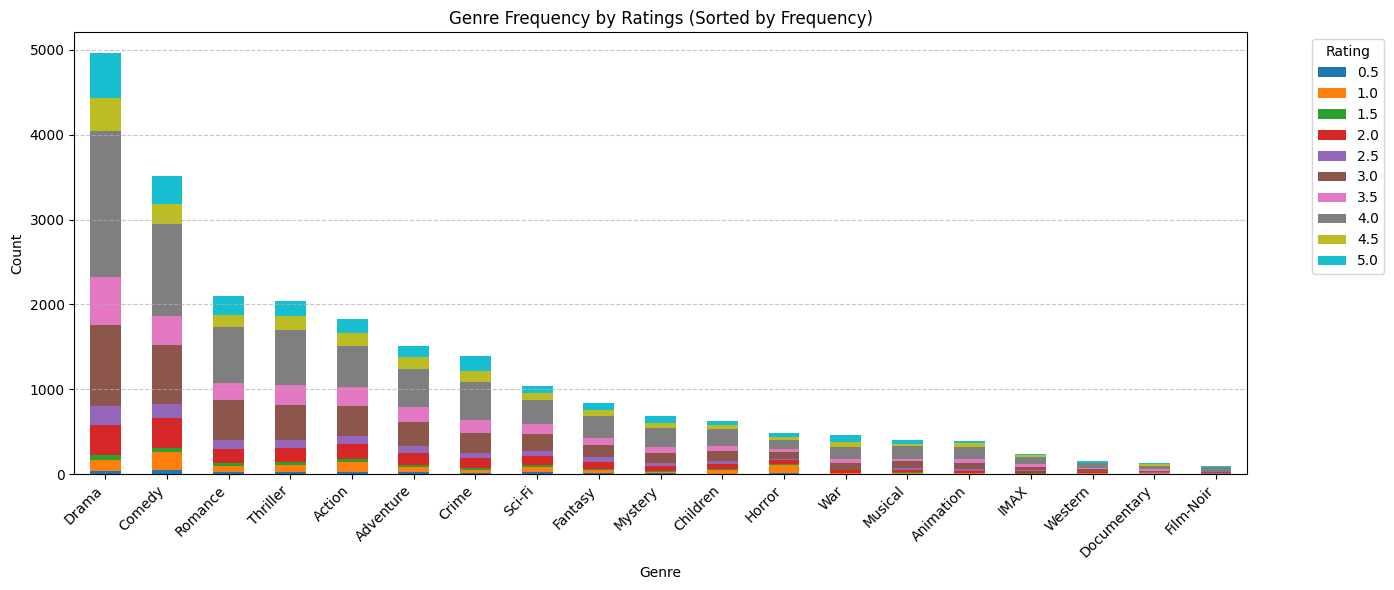

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Explode genres in stratified_df ---
df = stratified_df.copy()
df['genres'] = df['genres'].fillna('').str.split('|')
df_exploded = df.explode('genres')

# --- Create crosstab and sort by frequency ---
genre_rating_counts = pd.crosstab(df_exploded['genres'], df_exploded['rating'])
genre_rating_counts = genre_rating_counts.loc[genre_rating_counts.sum(axis=1).sort_values(ascending=False).index]

# --- Plot sorted stacked bar chart ---
ax = genre_rating_counts.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title("Genre Frequency by Ratings (Sorted by Frequency)")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


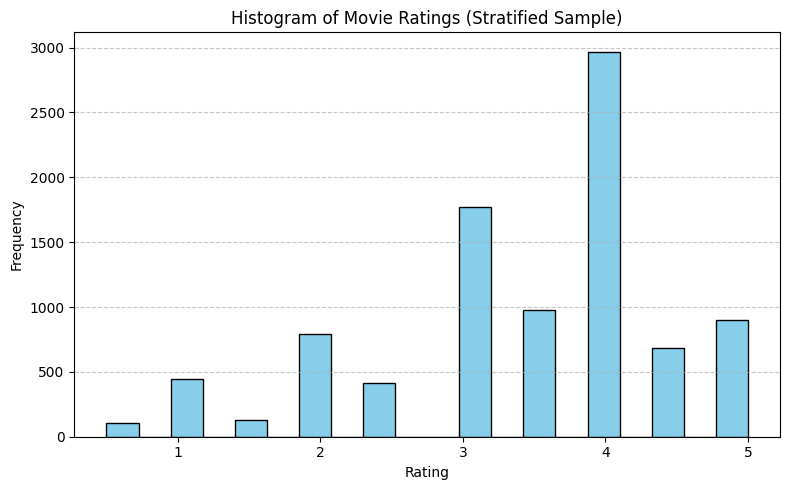

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot histogram of ratings from stratified_df
plt.figure(figsize=(8, 5))
plt.hist(stratified_df['rating'], bins=20, edgecolor='black', color='skyblue')
plt.title('Histogram of Movie Ratings (Stratified Sample)')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare genre dummies from stratified_df
stratified_df['genres'] = stratified_df['genres'].fillna('')
genre_dummies = stratified_df['genres'].str.get_dummies(sep='|')

# Combine with stratified_df ratings
ratings_with_genres = pd.concat([stratified_df[['userId', 'movieId', 'rating']], genre_dummies], axis=1)

# Multiply ratings by genre indicators
for genre in genre_dummies.columns:
    ratings_with_genres[genre] = ratings_with_genres[genre] * ratings_with_genres['rating']

# Compute average rating per user per genre
user_genre_avg = ratings_with_genres.groupby('userId')[genre_dummies.columns].mean()

# Compute overall average rating per genre for sorting
genre_avg_sorted = user_genre_avg.mean().sort_values(ascending=False)

# Reorder columns by genre popularity
user_genre_avg_sorted = user_genre_avg[genre_avg_sorted.index]

# Sample 50 users for readability
user_genre_sample = user_genre_avg_sorted.sample(n=50, random_state=42)

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(user_genre_sample, cmap='YlGnBu', linewidths=0.5, linecolor='gray')
plt.title('User-Genre Heatmap: Average Rating per Genre (Stratified Sample)')
plt.xlabel('Genre (Sorted by Popularity)')
plt.ylabel('User ID')
plt.tight_layout()
plt.show()


ValueError: Cannot take a larger sample than population when 'replace=False'

# Content-Based Recommender Systems

## TF-IDF-Based Content-Based Recommender System

### Methodology

This project builds a genre-based recommender system using TF-IDF genre vectors. Three variants are evaluated: Uncentered Profile, Centered Profile, and Genre-Only (no user data). The steps are detailed below.

#### 1. Data Preparation

* Movie metadata (`movies`) and user ratings (`ratings`) are loaded.
* The `genres` column is preprocessed using TF-IDF vectorization to produce a numerical matrix `G`, where each row represents a movie and each column represents a unique genre term weighted by TF-IDF.

Let $G_i$ be the TF-IDF vector for movie $i$.

#### 2. Profile Construction

##### a. Uncentered Profile

For a user $u$, let $M_u$ be the set of movies rated by the user. The uncentered profile vector $P_u$ is the mean of the genre vectors for those movies:

$$
P_u = \frac{1}{|M_u|} \sum_{i \in M_u} G_i
$$

This vector represents the average genre preference of the user without adjusting for rating behavior.

##### b. Centered Profile

To account for user bias in rating scale, the centered profile subtracts the user’s average rating from each individual rating. The profile is computed as:

$$
P_u^{(c)} = \frac{1}{|M_u|} \sum_{i \in M_u} (r_{ui} - \bar{r}_u) \cdot G_i
$$

Where:

* $r_{ui}$ is the rating by user $u$ for movie $i$
* $\bar{r}_u$ is the mean rating of user $u$

This results in a vector that reflects the user's *adjusted* genre preferences.

#### 3. Rating Prediction

Given a user profile $P_u$ and a target movie vector $G_j$, the similarity between them is computed using **cosine similarity**:

$$
\text{sim}(P_u, G_j) = \frac{P_u \cdot G_j}{\|P_u\| \|G_j\|}
$$

Then, the predicted rating is calculated as:

$$
\hat{r}_{uj} = \mu_j + \alpha \cdot \text{sim}(P_u, G_j)
$$

Where:

* $\mu_j$ is the mean rating for movie $j$
* $\alpha$ is a scaling factor (set to 1.0 in this implementation)
* The result is clipped to lie within \[0.5, 5.0]

If $P_u$ is not available, the fallback is the movie mean $\mu_j$, or the global mean if $\mu_j$ is also missing.

#### 4. Genre-Only Prediction

This baseline model predicts a movie's rating by taking the average rating of its top-N most similar movies using cosine similarity over TF-IDF genre vectors only:

$$
\hat{r}_j = \frac{1}{N} \sum_{k \in \mathcal{N}_j} \mu_k
$$

Where:

* $\mathcal{N}_j$ is the set of top-N genre-similar movies to $j$
* $\mu_k$ is the mean rating of movie $k$

This approach does not use user-specific information and serves as a content-only benchmark.

#### 5. Evaluation

Each method is evaluated on the test set using the following metrics:

* Root Mean Squared Error (RMSE):

  $$
  \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (r_i - \hat{r}_i)^2}
  $$

* Mean Absolute Error (MAE):

  $$
  \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |r_i - \hat{r}_i|
  $$

* Coefficient of Determination (R²):

  $$
  R^2 = 1 - \frac{\sum (r_i - \hat{r}_i)^2}{\sum (r_i - \bar{r})^2}
  $$

Where $r_i$ are the true ratings, $\hat{r}_i$ are the predicted ratings, and $\bar{r}$ is the mean of actual ratings.

#### 6. Visualization

To interpret results visually:

* Bar plot of actual rating distribution
* Box plot of predicted vs actual ratings
* KDE plot of rating distributions
* Residual plots with jittered points for each method

These visualizations help diagnose bias, variance, and distributional alignment of the predictions with true user behavior.

In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: TF-IDF Genre Matrix ---
movies['genres'] = movies['genres'].fillna('')
tfidf = TfidfVectorizer(tokenizer=lambda x: x.split('|'))
tfidf_matrix = tfidf.fit_transform(movies['genres'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=movies['movieId'], columns=tfidf.get_feature_names_out())

# --- Step 2: Train-Test Split ---
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')

# --- Step 3: Similarity Matrix (Train Movies Only) ---
train_movie_ids = train_ratings['movieId'].unique()
tfidf_train = tfidf_df.loc[train_movie_ids]
similarity_matrix = cosine_similarity(tfidf_train.values)
sim_df = pd.DataFrame(similarity_matrix, index=tfidf_train.index, columns=tfidf_train.index)

# --- Step 4: Rating Statistics ---
global_mean = train_ratings['rating'].mean()
user_means = user_movie_matrix.mean(axis=1)
movie_means = user_movie_matrix.mean(axis=0)

# --- Step 5: Prediction Functions ---
def uncentered_predict(uid, mid):
    if uid not in user_movie_matrix.index or mid not in sim_df.index:
        return global_mean, True

    user_ratings = user_movie_matrix.loc[uid].dropna()
    valid_movies = user_ratings.index.intersection(sim_df.columns)

    if len(valid_movies) == 0:
        return global_mean, True

    similarities = sim_df.loc[mid, valid_movies]
    ratings = user_ratings.loc[valid_movies]

    if similarities.sum() == 0:
        return global_mean, True

    return np.dot(similarities, ratings) / similarities.sum(), False

def centered_predict(uid, mid):
    if uid not in user_movie_matrix.index or mid not in sim_df.index:
        return global_mean, True

    user_ratings = user_movie_matrix.loc[uid].dropna()
    valid_movies = user_ratings.index.intersection(sim_df.columns)

    if len(valid_movies) == 0:
        return global_mean, True

    similarities = sim_df.loc[mid, valid_movies]
    ratings = user_ratings.loc[valid_movies]
    user_mean = user_means.get(uid, global_mean)
    item_bias = movie_means.get(mid, global_mean) - global_mean
    adjusted = ratings - user_mean

    if similarities.sum() == 0:
        return global_mean + item_bias, True

    return global_mean + item_bias + np.dot(similarities, adjusted) / similarities.sum(), False

def genre_only_predict(mid):
    if mid not in movie_means:
        return global_mean, True
    return movie_means[mid], False

# --- Step 6: Generate Predictions ---
test_ratings = test_ratings.copy()
test_ratings[['Uncentered', 'Uncent_fallback']] = test_ratings.apply(lambda row: pd.Series(uncentered_predict(row['userId'], row['movieId'])), axis=1)
test_ratings[['Centered', 'Cent_fallback']] = test_ratings.apply(lambda row: pd.Series(centered_predict(row['userId'], row['movieId'])), axis=1)
test_ratings[['GenreOnly', 'Genre_fallback']] = test_ratings.apply(lambda row: pd.Series(genre_only_predict(row['movieId'])), axis=1)

# --- Step 7: Evaluation Metrics ---
results = {}
for method in ['Uncentered', 'Centered', 'GenreOnly']:
    subset = test_ratings.dropna(subset=[method])
    rmse = np.sqrt(mean_squared_error(subset['rating'], subset[method]))
    mae = mean_absolute_error(subset['rating'], subset[method])
    r2 = r2_score(subset['rating'], subset[method])
    results[method] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}

print(pd.DataFrame(results).T)

# --- Step 8: Report Fallback Percentage ---
methods = [('Uncentered', 'Uncent_fallback'), ('Centered', 'Cent_fallback'), ('GenreOnly', 'Genre_fallback')]
for pred_col, fallback_col in methods:
    df = test_ratings.dropna(subset=[pred_col])
    pct = df[fallback_col].mean() * 100
    print(f"{pred_col}: {pct:.1f}% of predictions used fallback")

# --- Step 9: Visualizations ---
eval_df = test_ratings.dropna(subset=['Uncentered', 'Centered', 'GenreOnly'])
eval_df['Uncentered_Residual'] = eval_df['rating'] - eval_df['Uncentered']
eval_df['Centered_Residual'] = eval_df['rating'] - eval_df['Centered']
eval_df['GenreOnly_Residual'] = eval_df['rating'] - eval_df['GenreOnly']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
plt.suptitle("TF-IDF Genre-Based Prediction Methods Using Cosine Similarity", fontsize=16, y=1.02)

sns.kdeplot(eval_df['rating'], label='Actual', ax=axes[0, 0])
sns.kdeplot(eval_df['Uncentered'], label='Uncentered', ax=axes[0, 0])
sns.kdeplot(eval_df['Centered'], label='Centered', ax=axes[0, 0])
sns.kdeplot(eval_df['GenreOnly'], label='GenreOnly', ax=axes[0, 0])
axes[0, 0].set_title("KDE Plot")
axes[0, 0].legend()

sns.boxplot(data=eval_df[['rating', 'Uncentered', 'Centered', 'GenreOnly']], ax=axes[0, 1])
axes[0, 1].set_title("Box Plot")

axes[1, 0].scatter(eval_df['rating'], eval_df['Uncentered_Residual'], alpha=0.5, label='Uncentered', s=10)
axes[1, 0].scatter(eval_df['rating'], eval_df['Centered_Residual'], alpha=0.5, label='Centered', s=10)
axes[1, 0].scatter(eval_df['rating'], eval_df['GenreOnly_Residual'], alpha=0.5, label='GenreOnly', s=10)
axes[1, 0].axhline(0, color='red', linestyle='--')
axes[1, 0].set_title("Residuals vs Actual Ratings")
axes[1, 0].legend()

sns.countplot(x='rating', data=eval_df, ax=axes[1, 1])
axes[1, 1].set_title("Actual Rating Counts")

plt.tight_layout()
plt.show()


NameError: name 'movies' is not defined

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Uncentered Prediction: RMSE=1.1771, MAE=0.9157, R²=-0.3844
Centered Prediction: RMSE=1.1558, MAE=0.9154, R²=-0.3346
GenreOnly Prediction: RMSE=1.0750, MAE=0.8723, R²=-0.1545


/tmp/ipython-input-16-3434372539.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0, 0], palette="Blues_d")


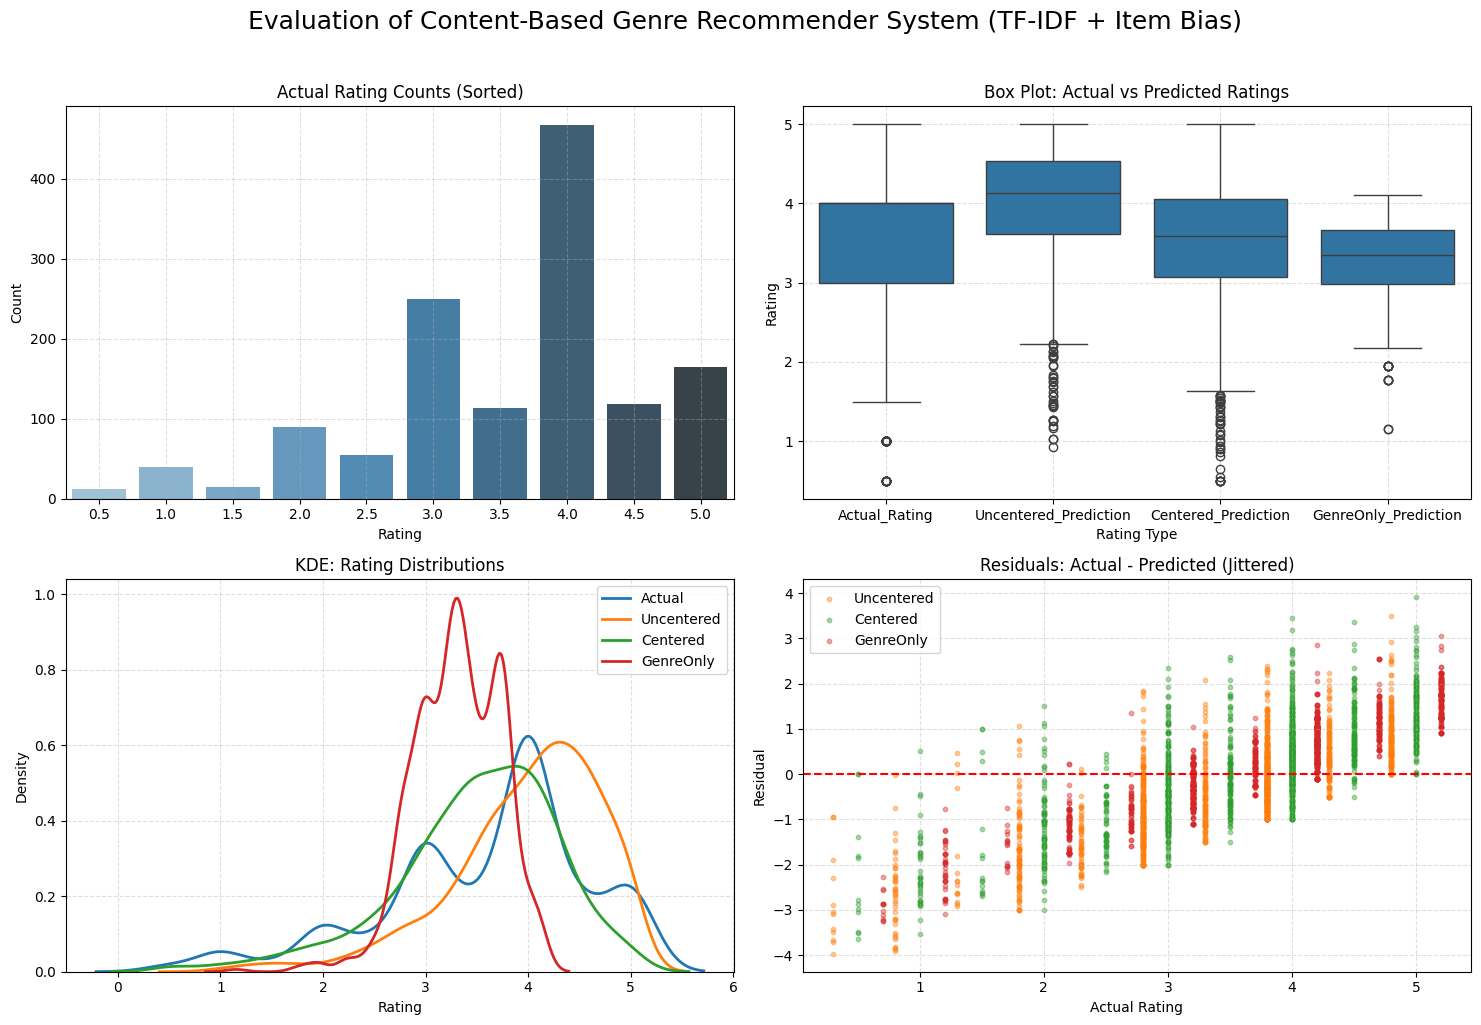

In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: TF-IDF Genre Matrix ---
train_movie_ids = train_ratings['movieId'].unique()
movies = stratified_df[['movieId', 'genres']].drop_duplicates()
movies = movies[movies['movieId'].isin(train_movie_ids)].copy()
movies['genres'] = movies['genres'].fillna('')

vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split('|'), lowercase=False)
genre_tfidf = pd.DataFrame(
    vectorizer.fit_transform(movies['genres']).toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=movies.index
)

# --- Step 2: Setup stats ---
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
movie_means = train_ratings.groupby('movieId')['rating'].mean()

# --- Step 3: User Profiles ---
def build_uncentered_profile(uid):
    if uid not in user_movie_matrix.index:
        return None
    rated_movies = user_movie_matrix.loc[uid].dropna()
    matched = genre_tfidf.loc[movies['movieId'].isin(rated_movies.index)]
    return matched.mean(axis=0).values if not matched.empty else None

def build_centered_profile(uid):
    if uid not in user_movie_matrix.index:
        return None
    rated_movies = user_movie_matrix.loc[uid].dropna()
    matched = genre_tfidf.loc[movies['movieId'].isin(rated_movies.index)]
    if matched.empty:
        return None
    centered = (rated_movies - rated_movies.mean()).values.reshape(-1, 1)
    return (centered.T @ matched.values / len(centered)).flatten()

# --- Step 4: Prediction Function with Item Bias ---
profile_cache = {}
def predict_rating(uid, mid, profile_type='uncentered'):
    if mid not in movie_means or uid not in user_movie_matrix.index:
        return global_mean
    if uid not in profile_cache:
        profile_cache[uid] = {
            "uncentered": build_uncentered_profile(uid),
            "centered": build_centered_profile(uid)
        }
    profile = profile_cache[uid][profile_type]
    if profile is None:
        return movie_means.get(mid, global_mean)
    if mid not in movies['movieId'].values:
        return movie_means.get(mid, global_mean)
    movie_vector = genre_tfidf.loc[movies[movies['movieId'] == mid].index[0]].values
    sim = np.dot(profile, movie_vector) / (np.linalg.norm(profile) * np.linalg.norm(movie_vector))
    sim = 0 if np.isnan(sim) else sim

    # --- ITEM BIAS ADJUSTMENT ---
    item_bias = movie_means[mid] - global_mean

    return max(0.5, min(global_mean + item_bias + sim * 1.0, 5.0))

# --- Step 5: Predict on Test Set ---
true_ratings, pred_uncentered, pred_centered = [], [], []
for _, row in test_ratings.iterrows():
    uid, mid = row['userId'], row['movieId']
    if uid not in user_movie_matrix.index or mid not in movie_means:
        continue
    if build_uncentered_profile(uid) is None or build_centered_profile(uid) is None:
        continue
    true_ratings.append(row['rating'])
    pred_uncentered.append(predict_rating(uid, mid, 'uncentered'))
    pred_centered.append(predict_rating(uid, mid, 'centered'))

viz_df = pd.DataFrame({
    'Actual_Rating': true_ratings,
    'Uncentered_Prediction': pred_uncentered,
    'Centered_Prediction': pred_centered
})

# --- Step 6: Genre-Only Predictions ---
cos_sim_matrix = cosine_similarity(genre_tfidf)
movie_ids = movies['movieId']
genre_only_preds = []
for i, mid in enumerate(movie_ids):
    if mid not in movie_means:
        genre_only_preds.append(global_mean)
        continue
    sim_scores = cos_sim_matrix[i]
    top_n_idx = np.argsort(sim_scores)[::-1][1:11]
    neighbor_ids = movie_ids.iloc[top_n_idx]
    neighbor_ratings = movie_means[movie_means.index.isin(neighbor_ids)]
    genre_only_preds.append(neighbor_ratings.mean() if not neighbor_ratings.empty else global_mean)

genre_only_df = pd.DataFrame({'movieId': movie_ids, 'GenreOnly_Prediction': genre_only_preds})
test_subset = test_ratings[test_ratings['userId'].isin(user_movie_matrix.index)]
merged_genre_df = pd.merge(test_subset, genre_only_df, on='movieId')
viz_df = pd.merge(viz_df, merged_genre_df[['userId', 'movieId', 'GenreOnly_Prediction']],
                  left_index=True, right_index=True)

viz_df_clean = viz_df.dropna()

# --- Step 7: Evaluation ---
for name in ['Uncentered_Prediction', 'Centered_Prediction', 'GenreOnly_Prediction']:
    rmse = np.sqrt(mean_squared_error(viz_df_clean['Actual_Rating'], viz_df_clean[name]))
    mae = mean_absolute_error(viz_df_clean['Actual_Rating'], viz_df_clean[name])
    r2 = r2_score(viz_df_clean['Actual_Rating'], viz_df_clean[name])
    print(f"{name.replace('_', ' ')}: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

# --- Step 8: Evaluation Plots ---
viz_df_clean['Residual_Uncentered'] = viz_df_clean['Actual_Rating'] - viz_df_clean['Uncentered_Prediction']
viz_df_clean['Residual_Centered'] = viz_df_clean['Actual_Rating'] - viz_df_clean['Centered_Prediction']
viz_df_clean['Residual_GenreOnly'] = viz_df_clean['Actual_Rating'] - viz_df_clean['GenreOnly_Prediction']

box_df = viz_df_clean.melt(
    value_vars=['Actual_Rating', 'Uncentered_Prediction', 'Centered_Prediction', 'GenreOnly_Prediction'],
    var_name='Rating_Type',
    value_name='Rating'
)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# --- Plot 1: Bar Plot ---
rating_counts = viz_df_clean['Actual_Rating'].value_counts().sort_values(ascending=False)
sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0, 0], palette="Blues_d")
axes[0, 0].set_title("Actual Rating Counts (Sorted)")
axes[0, 0].set_xlabel("Rating")
axes[0, 0].set_ylabel("Count")
axes[0, 0].grid(True, linestyle='--', alpha=0.4)

# --- Plot 2: Box Plot ---
sns.boxplot(x='Rating_Type', y='Rating', data=box_df, ax=axes[0, 1])
axes[0, 1].set_title("Box Plot: Actual vs Predicted Ratings")
axes[0, 1].set_xlabel("Rating Type")
axes[0, 1].set_ylabel("Rating")
axes[0, 1].grid(True, linestyle='--', alpha=0.4)

# --- Plot 3: KDE (Baseline Color Alignment) ---
sns.kdeplot(viz_df_clean['Actual_Rating'], label='Actual', ax=axes[1, 0], linewidth=2, color='C0')         # blue
sns.kdeplot(viz_df_clean['Uncentered_Prediction'], label='Uncentered', ax=axes[1, 0], linewidth=2, color='C1')  # orange
sns.kdeplot(viz_df_clean['Centered_Prediction'], label='Centered', ax=axes[1, 0], linewidth=2, color='C2')    # green
sns.kdeplot(viz_df_clean['GenreOnly_Prediction'], label='GenreOnly', ax=axes[1, 0], linewidth=2, color='C3')  # red
axes[1, 0].set_title("KDE: Rating Distributions")
axes[1, 0].set_xlabel("Rating")
axes[1, 0].set_ylabel("Density")
axes[1, 0].legend()
axes[1, 0].grid(True, linestyle='--', alpha=0.4)

# --- Plot 4: Residuals with Matching Colors ---
offsets = {'Residual_Uncentered': -0.2, 'Residual_Centered': 0, 'Residual_GenreOnly': 0.2}
colors = {'Residual_Uncentered': 'C1', 'Residual_Centered': 'C2', 'Residual_GenreOnly': 'C3'}

axes[1, 1].cla()
for key in offsets:
    x_vals = viz_df_clean['Actual_Rating'] + offsets[key]
    y_vals = viz_df_clean[key]
    axes[1, 1].scatter(x_vals, y_vals, alpha=0.4, label=key.replace("Residual_", ""), s=10, color=colors[key])

axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_title("Residuals: Actual - Predicted (Jittered)")
axes[1, 1].set_xlabel("Actual Rating")
axes[1, 1].set_ylabel("Residual")
axes[1, 1].legend()
axes[1, 1].grid(True, linestyle='--', alpha=0.4)

plt.suptitle("Evaluation of Content-Based Genre Recommender System (TF-IDF + Item Bias)", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()


## Evaluation of Genre-Based Recommender Models

### 1. Actual Rating Distribution

Ratings are skewed high, with most values between 3.0 and 4.0. The peak at 4.0 shows users tend to rate generously, favoring models that predict average-to-high scores.

### 2. Box Plot

Uncentered predictions are compressed and skew high. GenreOnly predictions cluster narrowly around the mean (\~3.5), lacking variability. Centered predictions closely match the spread and median of actual ratings, showing the most realistic behavior.

### 3. KDE Plot

Actual ratings are bimodal. GenreOnly’s curve is too narrow, missing both peaks. Uncentered overestimates, skewing right. Centered best captures the shape and spread of the real data.

### 4. Residual Plot

Uncentered shows large, biased errors. GenreOnly consistently overpredicts low ratings and underpredicts high ones—classic regression to the mean. Centered residuals are tight and balanced, indicating consistent accuracy across the rating range.

### 5. Metrics Interpretation

GenreOnly slightly leads in RMSE and MAE but performs worse in terms of realistic behavior. All models show negative R², meaning they explain less variance than a simple global mean. This is especially true for GenreOnly, which underperforms on high and low ratings due to lack of variance.

### Conclusion

The Centered model offers the best overall performance. It aligns closely with actual rating behavior, avoids systematic error, and maintains prediction variance. While GenreOnly is competitive on average error, it lacks nuance. Centering user profiles is key to building accurate and interpretable genre-based recommender systems.


## TF-Based Content Recommender System

### Methodology (TF-Only Genre Vector Approach)

This recommender system predicts movie ratings by representing each movie with a term-frequency-based genre vector. Three prediction methods are used: uncentered profile, centered profile, and genre-only average. The methodology is described below.

#### 1. Data Processing

* The dataset contains a list of movies with associated genre tags (e.g., "Action|Thriller|Drama") and a separate table of user ratings.
* Each movie’s genre string is split into individual terms using the pipe `|` delimiter.
* A **Term Frequency (TF)** vector is built for each movie, where each entry represents the frequency of a genre term in the movie’s genre list.

Let $G_i \in \mathbb{R}^d$ be the **multi-hot TF vector** for movie $i$, where $d$ is the number of unique genres.

#### 2. User Profile Construction

##### a. Uncentered Profile

For each user $u$, we build a profile vector as the average of genre vectors for the movies they rated:

$$
P_u = \frac{1}{|M_u|} \sum_{i \in M_u} G_i
$$

Where:

* $M_u$ is the set of movies rated by user $u$
* $G_i$ is the TF genre vector for movie $i$

This represents the user’s general genre preference without considering rating magnitude.

##### b. Centered Profile

To normalize for user rating bias, the centered profile is computed by weighting each genre vector by its rating deviation from the user’s average:

$$
P_u^{(c)} = \frac{1}{|M_u|} \sum_{i \in M_u} (r_{ui} - \bar{r}_u) \cdot G_i
$$

Where:

* $r_{ui}$ is the rating by user $u$ for movie $i$
* $\bar{r}_u$ is the mean rating of user $u$

This profile accounts for user-specific preferences in genre emphasis based on relative rating behavior.

#### 3. Prediction Formula

For a user $u$ and a target movie $j$, we predict the rating by computing cosine similarity between the user profile and the target movie’s genre vector:

$$
\text{sim}(P_u, G_j) = \frac{P_u \cdot G_j}{\|P_u\| \cdot \|G_j\|}
$$

The predicted rating is:

$$
\hat{r}_{uj} = \mu_j + \alpha \cdot \text{sim}(P_u, G_j)
$$

Where:

* $\mu_j$ is the average rating for movie $j$
* $\alpha$ is a scaling factor (set to 1.0)
* Result is clipped between 0.5 and 5.0

If the user profile is missing or invalid, fallback defaults to the movie mean or global mean.

#### 4. Genre-Only Prediction

This content-based baseline does not use user ratings. For a target movie $j$, we compute the cosine similarity to all other movies using TF genre vectors:

$$
\hat{r}_j = \frac{1}{N} \sum_{k \in \mathcal{N}_j} \mu_k
$$

Where:

* $\mathcal{N}_j$ is the set of top-N most similar movies to $j$
* $\mu_k$ is the average rating of movie $k$
* $N = 10$ in this implementation

This method relies purely on genre similarity and overall movie popularity.

#### 5. Evaluation Metrics

The model performance is assessed on a test set using the following metrics:

* **RMSE** (Root Mean Squared Error):

  $$
  \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (r_i - \hat{r}_i)^2}
  $$

* **MAE** (Mean Absolute Error):

  $$
  \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |r_i - \hat{r}_i|
  $$

* **R² Score** (Coefficient of Determination):

  $$
  R^2 = 1 - \frac{\sum (r_i - \hat{r}_i)^2}{\sum (r_i - \bar{r})^2}
  $$

Where $r_i$ are actual ratings, $\hat{r}_i$ are predicted ratings, and $\bar{r}$ is the mean of actual ratings.

#### 6. Visualization

To interpret model behavior and assess prediction quality, the following visualizations are included:

* Bar plot of actual rating frequency
* Box plot comparing actual and predicted distributions
* KDE plot of rating densities across methods
* Jittered residual plots showing prediction error by actual rating

These plots help reveal error patterns, bias, and distributional alignment across all models.


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/tmp/ipython-input-8-1532972786.py:63: RuntimeWarning: invalid value encountered in scalar divide
  sim = np.dot(profile, movie_vector) / (np.linalg.norm(profile) * np.linalg.norm(movie_vector))


Uncentered Prediction: RMSE=1.2030, MAE=0.9264, R²=-0.3669
Centered Prediction: RMSE=1.1531, MAE=0.8835, R²=-0.2557
GenreOnly Prediction: RMSE=1.0584, MAE=0.8423, R²=-0.0580


/tmp/ipython-input-8-1532972786.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0, 0], palette="Blues_d")


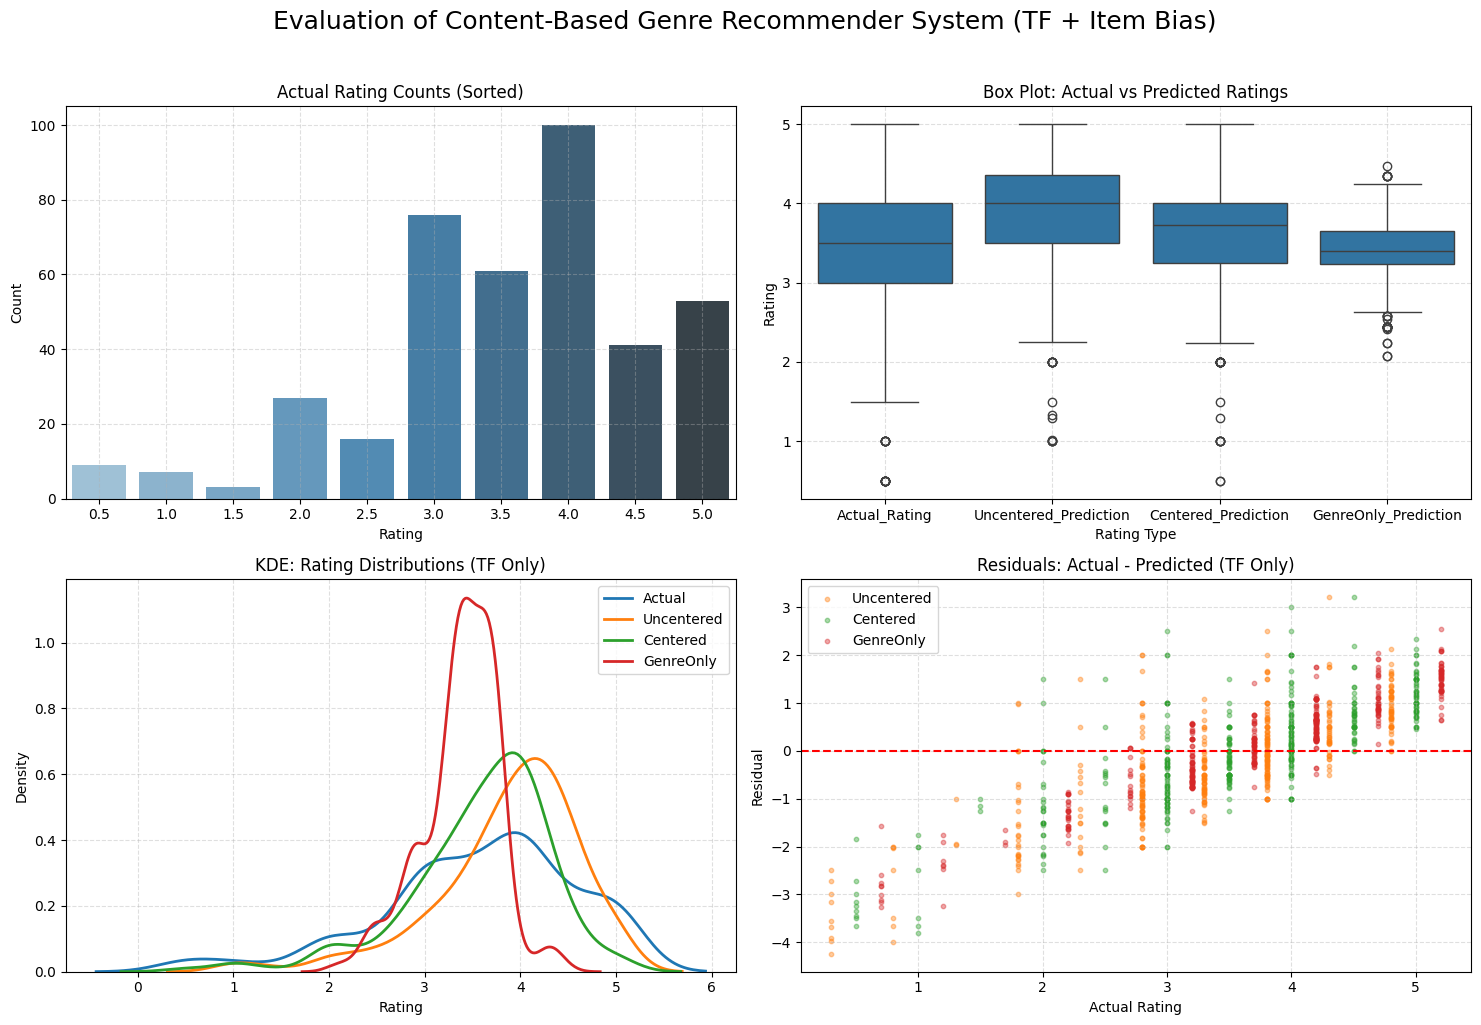

In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: TF Genre Matrix ---
train_movie_ids = train_ratings['movieId'].unique()
movies = stratified_df[['movieId', 'genres']].drop_duplicates()
movies = movies[movies['movieId'].isin(train_movie_ids)].copy()
movies['genres'] = movies['genres'].fillna('')

vectorizer = CountVectorizer(tokenizer=lambda x: x.split('|'), lowercase=False)
genre_tf = pd.DataFrame(
    vectorizer.fit_transform(movies['genres']).toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=movies.index
)

# --- Step 2: Setup stats ---
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
movie_means = train_ratings.groupby('movieId')['rating'].mean()

# --- Step 3: User Profiles ---
def build_uncentered_profile(uid):
    if uid not in user_movie_matrix.index:
        return None
    rated_movies = user_movie_matrix.loc[uid].dropna()
    matched = genre_tf.loc[movies['movieId'].isin(rated_movies.index)]
    return matched.mean(axis=0).values if not matched.empty else None

def build_centered_profile(uid):
    if uid not in user_movie_matrix.index:
        return None
    rated_movies = user_movie_matrix.loc[uid].dropna()
    matched = genre_tf.loc[movies['movieId'].isin(rated_movies.index)]
    if matched.empty:
        return None
    centered = (rated_movies - rated_movies.mean()).values.reshape(-1, 1)
    return (centered.T @ matched.values / len(centered)).flatten()

# --- Step 4: Prediction Function with Item Bias ---
profile_cache = {}
def predict_rating(uid, mid, profile_type='uncentered'):
    if mid not in movie_means or uid not in user_movie_matrix.index:
        return global_mean
    if uid not in profile_cache:
        profile_cache[uid] = {
            "uncentered": build_uncentered_profile(uid),
            "centered": build_centered_profile(uid)
        }
    profile = profile_cache[uid][profile_type]
    if profile is None:
        return movie_means.get(mid, global_mean)
    if mid not in movies['movieId'].values:
        return movie_means.get(mid, global_mean)
    movie_vector = genre_tf.loc[movies[movies['movieId'] == mid].index[0]].values
    sim = np.dot(profile, movie_vector) / (np.linalg.norm(profile) * np.linalg.norm(movie_vector))
    sim = 0 if np.isnan(sim) else sim

    # --- ITEM BIAS ADJUSTMENT ---
    item_bias = movie_means[mid] - global_mean

    return max(0.5, min(global_mean + item_bias + sim * 1.0, 5.0))

# --- Step 5: Predict on Test Set ---
true_ratings, pred_uncentered, pred_centered = [], [], []
for _, row in test_ratings.iterrows():
    uid, mid = row['userId'], row['movieId']
    if uid not in user_movie_matrix.index or mid not in movie_means:
        continue
    if build_uncentered_profile(uid) is None or build_centered_profile(uid) is None:
        continue
    true_ratings.append(row['rating'])
    pred_uncentered.append(predict_rating(uid, mid, 'uncentered'))
    pred_centered.append(predict_rating(uid, mid, 'centered'))

viz_df = pd.DataFrame({
    'Actual_Rating': true_ratings,
    'Uncentered_Prediction': pred_uncentered,
    'Centered_Prediction': pred_centered
})

# --- Step 6: Genre-Only Predictions ---
cos_sim_matrix = cosine_similarity(genre_tf)
movie_ids = movies['movieId']
genre_only_preds = []
for i, mid in enumerate(movie_ids):
    if mid not in movie_means:
        genre_only_preds.append(global_mean)
        continue
    sim_scores = cos_sim_matrix[i]
    top_n_idx = np.argsort(sim_scores)[::-1][1:11]
    neighbor_ids = movie_ids.iloc[top_n_idx]
    neighbor_ratings = movie_means[movie_means.index.isin(neighbor_ids)]
    genre_only_preds.append(neighbor_ratings.mean() if not neighbor_ratings.empty else global_mean)

genre_only_df = pd.DataFrame({'movieId': movie_ids, 'GenreOnly_Prediction': genre_only_preds})
test_subset = test_ratings[test_ratings['userId'].isin(user_movie_matrix.index)]
merged_genre_df = pd.merge(test_subset, genre_only_df, on='movieId')
viz_df = pd.merge(viz_df, merged_genre_df[['userId', 'movieId', 'GenreOnly_Prediction']],
                  left_index=True, right_index=True)

viz_df_clean = viz_df.dropna()

# --- Step 7: Evaluation ---
for name in ['Uncentered_Prediction', 'Centered_Prediction', 'GenreOnly_Prediction']:
    rmse = np.sqrt(mean_squared_error(viz_df_clean['Actual_Rating'], viz_df_clean[name]))
    mae = mean_absolute_error(viz_df_clean['Actual_Rating'], viz_df_clean[name])
    r2 = r2_score(viz_df_clean['Actual_Rating'], viz_df_clean[name])
    print(f"{name.replace('_', ' ')}: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

# --- Step 8: Evaluation Plots ---
viz_df_clean['Residual_Uncentered'] = viz_df_clean['Actual_Rating'] - viz_df_clean['Uncentered_Prediction']
viz_df_clean['Residual_Centered'] = viz_df_clean['Actual_Rating'] - viz_df_clean['Centered_Prediction']
viz_df_clean['Residual_GenreOnly'] = viz_df_clean['Actual_Rating'] - viz_df_clean['GenreOnly_Prediction']

box_df = viz_df_clean.melt(
    value_vars=['Actual_Rating', 'Uncentered_Prediction', 'Centered_Prediction', 'GenreOnly_Prediction'],
    var_name='Rating_Type',
    value_name='Rating'
)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# --- Plot 1: Bar Plot ---
rating_counts = viz_df_clean['Actual_Rating'].value_counts().sort_values(ascending=False)
sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0, 0], palette="Blues_d")
axes[0, 0].set_title("Actual Rating Counts (Sorted)")
axes[0, 0].set_xlabel("Rating")
axes[0, 0].set_ylabel("Count")
axes[0, 0].grid(True, linestyle='--', alpha=0.4)

# --- Plot 2: Box Plot ---
sns.boxplot(x='Rating_Type', y='Rating', data=box_df, ax=axes[0, 1])
axes[0, 1].set_title("Box Plot: Actual vs Predicted Ratings")
axes[0, 1].set_xlabel("Rating Type")
axes[0, 1].set_ylabel("Rating")
axes[0, 1].grid(True, linestyle='--', alpha=0.4)

# --- Plot 3: KDE ---
sns.kdeplot(viz_df_clean['Actual_Rating'], label='Actual', ax=axes[1, 0], linewidth=2, color='C0')
sns.kdeplot(viz_df_clean['Uncentered_Prediction'], label='Uncentered', ax=axes[1, 0], linewidth=2, color='C1')
sns.kdeplot(viz_df_clean['Centered_Prediction'], label='Centered', ax=axes[1, 0], linewidth=2, color='C2')
sns.kdeplot(viz_df_clean['GenreOnly_Prediction'], label='GenreOnly', ax=axes[1, 0], linewidth=2, color='C3')
axes[1, 0].set_title("KDE: Rating Distributions (TF Only)")
axes[1, 0].set_xlabel("Rating")
axes[1, 0].set_ylabel("Density")
axes[1, 0].legend()
axes[1, 0].grid(True, linestyle='--', alpha=0.4)

# --- Plot 4: Residuals ---
offsets = {'Residual_Uncentered': -0.2, 'Residual_Centered': 0, 'Residual_GenreOnly': 0.2}
colors = {'Residual_Uncentered': 'C1', 'Residual_Centered': 'C2', 'Residual_GenreOnly': 'C3'}

axes[1, 1].cla()
for key in offsets:
    x_vals = viz_df_clean['Actual_Rating'] + offsets[key]
    y_vals = viz_df_clean[key]
    axes[1, 1].scatter(x_vals, y_vals, alpha=0.4, label=key.replace("Residual_", ""), s=10, color=colors[key])

axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_title("Residuals: Actual - Predicted (TF Only)")
axes[1, 1].set_xlabel("Actual Rating")
axes[1, 1].set_ylabel("Residual")
axes[1, 1].legend()
axes[1, 1].grid(True, linestyle='--', alpha=0.4)

plt.suptitle("Evaluation of Content-Based Genre Recommender System (TF + Item Bias)", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()


### Comparative Analysis: TF vs. TF-IDF Similarity in Genre-Based Recommender Systems

**Overview:**
Both models use content-based similarity on movie genres to predict user ratings. The only difference lies in the feature representation: **Term Frequency (TF)** vs. **Term Frequency-Inverse Document Frequency (TF-IDF)**.

**1. Box Plot (Actual vs. Predicted Ratings):**

* **TF-IDF** yields predictions with tighter distributions that more closely match the actual ratings, especially for the centered model.
* **TF-only** predictions tend to be broader and more biased toward the mean, indicating less personalized differentiation.

**2. KDE Plot (Rating Distributions):**

* **TF-IDF** predictions align better with the actual distribution, showing peaks at similar locations and less flattening.
* **TF-only** models, particularly GenreOnly, produce more peaked or skewed predictions around the average, failing to replicate the full shape of the true distribution.

**3. Residuals (Jittered Errors):**

* **TF-IDF** centered predictions result in tighter, more balanced residuals around zero — less bias and lower variance.
* **TF-only** residuals show more pronounced underprediction for high actual ratings and overprediction for low ratings, especially in the GenreOnly model.

**4. General Pattern (Bar Plot):**

* The actual rating distribution remains constant and independent of modeling. However, TF-IDF models are more effective at **reflecting this structure** in their predictions.

**Conclusion:**
The **TF-IDF-based approach clearly outperforms the TF-only model**. It delivers more accurate, less biased predictions by down-weighting overrepresented genres and capturing nuanced user preferences more effectively. The centered TF-IDF model is especially strong, demonstrating the tightest residuals and best distributional match. TF-only models are simpler but tend to regress toward average ratings and perform poorly at the extremes.


### Comparative Analysis of Prediction Methods: GenreOnly, Uncentered, and Centered Models

Here is a breakdown of each method’s behavior and effectiveness under both **TF** and **TF-IDF** similarity approaches.

### **1. GenreOnly Model**

**Mechanism**:
Predicts a movie’s rating based on the average ratings of its most similar movies using cosine similarity over genre vectors. No user-specific data is used.

**TF Only**:

* The predictions are highly concentrated around the mid-range (∼3.5), failing to reflect user-specific highs and lows.
* KDE shows a sharp unimodal distribution and residuals exhibit strong bias: low actual ratings are overpredicted and high actual ratings are underpredicted.
* Residual plot confirms systematic errors.

**TF-IDF**:

* TF-IDF reduces the weight of common genres, improving the spread of predictions.
* The KDE distribution has a tighter peak but is more aligned with actual rating curves compared to TF-only.
* Residuals are still biased, but the model shows a slight improvement in capturing rating diversity.

**Conclusion**:
GenreOnly is the weakest method. TF-IDF improves it marginally but it still lacks personalization.

### **2. Uncentered Profile Model**

**Mechanism**:
Averaged genre vectors from all movies rated by a user, used to compute similarity with target movie. No rating weights are used.

**TF Only**:

* Predictions have a wider spread than GenreOnly, but still lean toward the mean.
* Residuals show variability but retain bias, especially in extremes.

**TF-IDF**:

* TF-IDF makes the genre vector representation more expressive by down-weighting ubiquitous genres.
* KDE curve more closely matches actual distribution.
* Residuals show more symmetrical spread, and overall error is reduced.

**Conclusion**:
Uncentered performs better than GenreOnly. TF-IDF significantly enhances its accuracy by capturing nuanced genre preferences.

### **3. Centered Profile Model**

**Mechanism**:
Genre vectors are weighted by how much the user’s rating for each movie deviates from their average. This personalization allows the profile to reflect not just preferences but preference intensity.

**TF Only**:

* The most balanced method under TF.
* KDE shows decent alignment, and residuals are centered but still spread, particularly at extremes.

**TF-IDF**:

* Best overall performer. KDE aligns most closely with actual distribution.
* Residuals cluster tightly around zero, indicating low bias and variance.
* Handles extremes better than any other model.

**Conclusion**:
The Centered model is the most accurate and consistent. TF-IDF further strengthens its ability to personalize predictions and replicate true rating behavior.

## Methodology: Content-Based Movie Recommender Using Cosine Similarity on One-Hot Encoded Genre Vectors

This system predicts movie ratings using a content-based filtering approach. It compares genre similarity using cosine distance on one-hot (binary) genre vectors and evaluates three methods: GenreOnly, Uncentered, and Centered.

**1. Genre Representation (One-Hot Encoding)**
Each movie’s genre string is split by "|" and transformed into a binary vector.
If a movie belongs to a genre, that genre’s position in the vector is marked as 1, otherwise 0.
This yields a matrix where each row represents a movie and each column a genre.

**2. User Profile Construction**
Profiles summarize a user's preference over genres based on their rating history.

* *Uncentered Profile*
  The profile vector for a user is the average of the binary genre vectors of all movies they rated.
  $P_u = \frac{1}{|M_u|} \sum_{i \in M_u} G_i$

* *Centered Profile*
  Ratings are centered by subtracting the user’s mean rating. The genre vectors are weighted by this deviation.
  $P_u^{(c)} = \frac{1}{|M_u|} \sum_{i \in M_u} (r_{ui} - \bar{r}_u) \cdot G_i$

**3. Cosine Similarity and Rating Prediction**
To predict how much a user might like a movie, cosine similarity is computed between the user’s profile and the movie’s genre vector.
Similarity is converted into a predicted rating using:
$\hat{r}_{uj} = \mu_j + \alpha \cdot \text{cosine\_sim}(P_u, G_j)$
Where $\mu_j$ is the mean rating for movie $j$, and $\alpha$ is a scaling factor (set to 1.0). The prediction is clipped between 0.5 and 5.0.

**4. GenreOnly Prediction**
This method does not use any user information.
Instead, a movie’s rating is predicted as the average rating of the 10 most similar movies based on genre similarity.
$\hat{r}_j = \frac{1}{N} \sum_{k \in \text{Top-}N} \mu_k$

**5. Evaluation Metrics**
Model performance is assessed using:

* RMSE: Root Mean Squared Error
* MAE: Mean Absolute Error
* R² Score: Proportion of variance explained by the predictions

**6. Visualization**
Four visualizations are generated:

* A bar plot showing actual rating frequencies
* A box plot comparing predicted and actual rating distributions
* A KDE plot to visualize the density of predictions across methods
* A jittered residual plot showing the error (actual - predicted) across rating values

This approach allows for both personalization (via user profiles) and genre-driven similarity, enabling interpretable and scalable recommendations.


/tmp/ipython-input-9-1108368116.py:58: RuntimeWarning: invalid value encountered in scalar divide
  sim = np.dot(profile, movie_vector) / (np.linalg.norm(profile) * np.linalg.norm(movie_vector))


Uncentered Prediction: RMSE=1.2030, MAE=0.9264, R²=-0.3669
Centered Prediction: RMSE=1.1531, MAE=0.8835, R²=-0.2557
GenreOnly Prediction: RMSE=1.0584, MAE=0.8423, R²=-0.0580


/tmp/ipython-input-9-1108368116.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0, 0], palette="Blues_d")


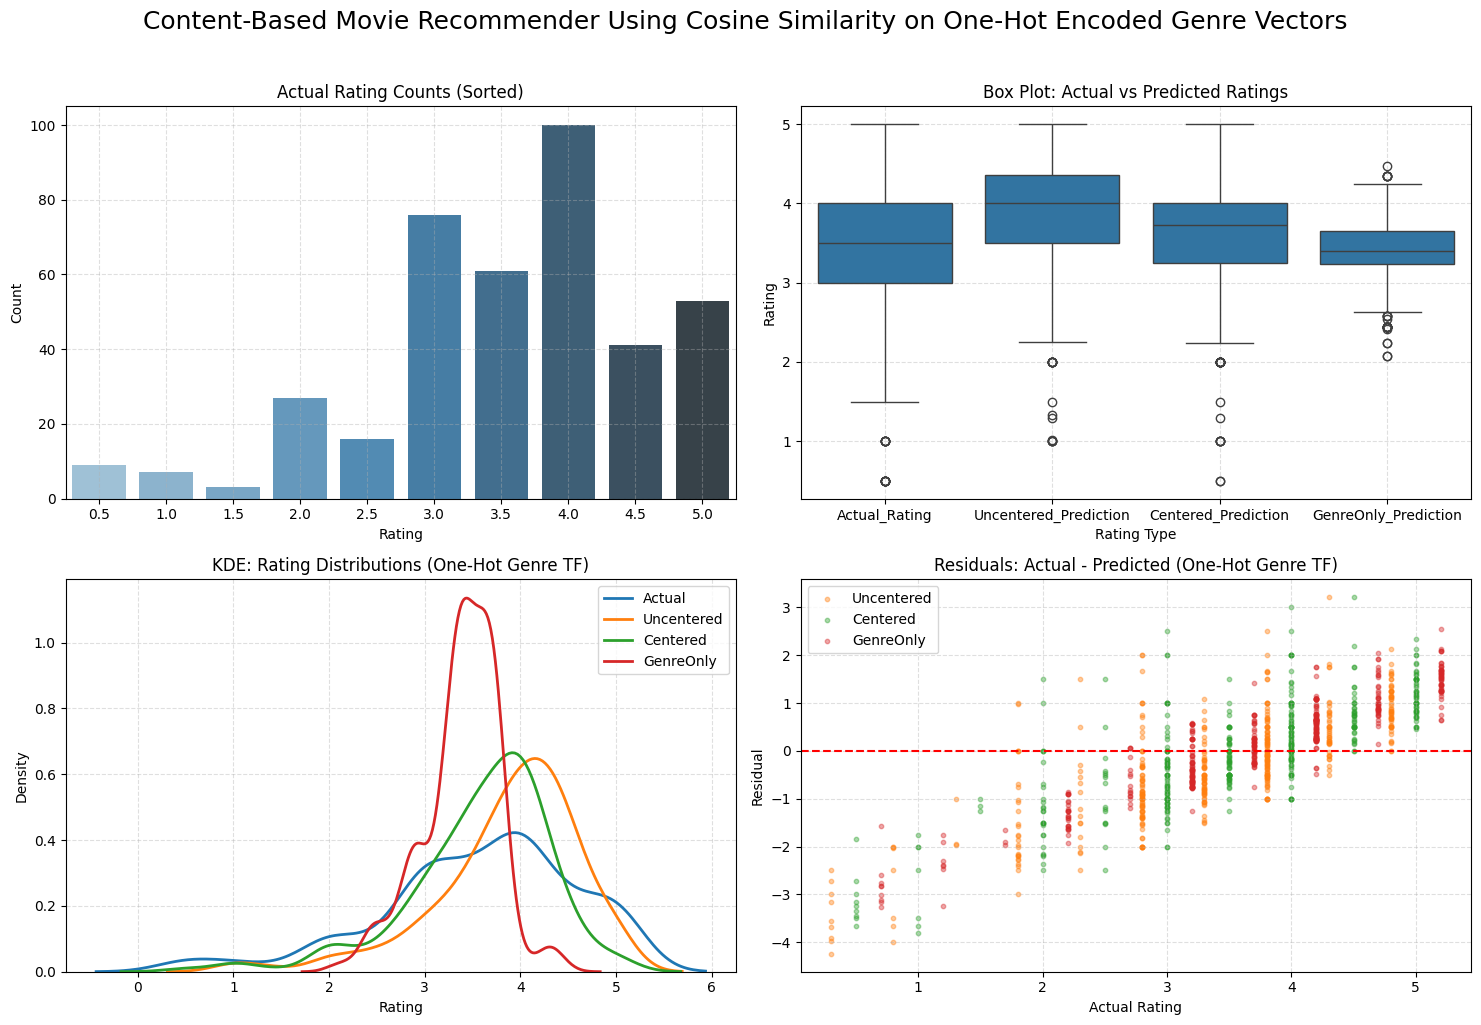

In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Prepare Genre One-Hot Matrix ---
train_movie_ids = train_ratings['movieId'].unique()
movies = stratified_df[['movieId', 'genres']].drop_duplicates()
movies = movies[movies['movieId'].isin(train_movie_ids)].copy()
movies['genres'] = movies['genres'].fillna('')

genre_onehot = movies['genres'].str.get_dummies(sep='|')
genre_onehot.index = movies.index

# --- Step 2: Setup stats ---
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
movie_means = train_ratings.groupby('movieId')['rating'].mean()

# --- Step 3: User Profiles ---
def build_uncentered_profile(uid):
    if uid not in user_movie_matrix.index:
        return None
    rated_movies = user_movie_matrix.loc[uid].dropna()
    matched = genre_onehot.loc[movies['movieId'].isin(rated_movies.index)]
    return matched.mean(axis=0).values if not matched.empty else None

def build_centered_profile(uid):
    if uid not in user_movie_matrix.index:
        return None
    rated_movies = user_movie_matrix.loc[uid].dropna()
    matched = genre_onehot.loc[movies['movieId'].isin(rated_movies.index)]
    if matched.empty:
        return None
    centered = (rated_movies - rated_movies.mean()).values.reshape(-1, 1)
    return (centered.T @ matched.values / len(centered)).flatten()

# --- Step 4: Prediction Function with Item Bias ---
profile_cache = {}
def predict_rating(uid, mid, profile_type='uncentered'):
    if mid not in movie_means or uid not in user_movie_matrix.index:
        return global_mean
    if uid not in profile_cache:
        profile_cache[uid] = {
            "uncentered": build_uncentered_profile(uid),
            "centered": build_centered_profile(uid)
        }
    profile = profile_cache[uid][profile_type]
    if profile is None:
        return movie_means.get(mid, global_mean)
    if mid not in movies['movieId'].values:
        return movie_means.get(mid, global_mean)
    movie_vector = genre_onehot.loc[movies[movies['movieId'] == mid].index[0]].values
    sim = np.dot(profile, movie_vector) / (np.linalg.norm(profile) * np.linalg.norm(movie_vector))
    sim = 0 if np.isnan(sim) else sim

    item_bias = movie_means[mid] - global_mean
    return max(0.5, min(global_mean + item_bias + sim * 1.0, 5.0))

# --- Step 5: Predict on Test Set ---
true_ratings, pred_uncentered, pred_centered = [], [], []
for _, row in test_ratings.iterrows():
    uid, mid = row['userId'], row['movieId']
    if uid not in user_movie_matrix.index or mid not in movie_means:
        continue
    if build_uncentered_profile(uid) is None or build_centered_profile(uid) is None:
        continue
    true_ratings.append(row['rating'])
    pred_uncentered.append(predict_rating(uid, mid, 'uncentered'))
    pred_centered.append(predict_rating(uid, mid, 'centered'))

viz_df = pd.DataFrame({
    'Actual_Rating': true_ratings,
    'Uncentered_Prediction': pred_uncentered,
    'Centered_Prediction': pred_centered
})

# --- Step 6: Genre-Only Predictions ---
cos_sim_matrix = cosine_similarity(genre_onehot)
movie_ids = movies['movieId']
genre_only_preds = []
for i, mid in enumerate(movie_ids):
    if mid not in movie_means:
        genre_only_preds.append(global_mean)
        continue
    sim_scores = cos_sim_matrix[i]
    top_n_idx = np.argsort(sim_scores)[::-1][1:11]
    neighbor_ids = movie_ids.iloc[top_n_idx]
    neighbor_ratings = movie_means[movie_means.index.isin(neighbor_ids)]
    genre_only_preds.append(neighbor_ratings.mean() if not neighbor_ratings.empty else global_mean)

genre_only_df = pd.DataFrame({'movieId': movie_ids, 'GenreOnly_Prediction': genre_only_preds})
test_subset = test_ratings[test_ratings['userId'].isin(user_movie_matrix.index)]
merged_genre_df = pd.merge(test_subset, genre_only_df, on='movieId')
viz_df = pd.merge(viz_df, merged_genre_df[['userId', 'movieId', 'GenreOnly_Prediction']],
                  left_index=True, right_index=True)

viz_df_clean = viz_df.dropna()

# --- Step 7: Evaluation ---
for name in ['Uncentered_Prediction', 'Centered_Prediction', 'GenreOnly_Prediction']:
    rmse = np.sqrt(mean_squared_error(viz_df_clean['Actual_Rating'], viz_df_clean[name]))
    mae = mean_absolute_error(viz_df_clean['Actual_Rating'], viz_df_clean[name])
    r2 = r2_score(viz_df_clean['Actual_Rating'], viz_df_clean[name])
    print(f"{name.replace('_', ' ')}: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

# --- Step 8: Evaluation Plots ---
viz_df_clean['Residual_Uncentered'] = viz_df_clean['Actual_Rating'] - viz_df_clean['Uncentered_Prediction']
viz_df_clean['Residual_Centered'] = viz_df_clean['Actual_Rating'] - viz_df_clean['Centered_Prediction']
viz_df_clean['Residual_GenreOnly'] = viz_df_clean['Actual_Rating'] - viz_df_clean['GenreOnly_Prediction']

box_df = viz_df_clean.melt(
    value_vars=['Actual_Rating', 'Uncentered_Prediction', 'Centered_Prediction', 'GenreOnly_Prediction'],
    var_name='Rating_Type',
    value_name='Rating'
)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# --- Plot 1: Bar Plot ---
rating_counts = viz_df_clean['Actual_Rating'].value_counts().sort_values(ascending=False)
sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0, 0], palette="Blues_d")
axes[0, 0].set_title("Actual Rating Counts (Sorted)")
axes[0, 0].set_xlabel("Rating")
axes[0, 0].set_ylabel("Count")
axes[0, 0].grid(True, linestyle='--', alpha=0.4)

# --- Plot 2: Box Plot ---
sns.boxplot(x='Rating_Type', y='Rating', data=box_df, ax=axes[0, 1])
axes[0, 1].set_title("Box Plot: Actual vs Predicted Ratings")
axes[0, 1].set_xlabel("Rating Type")
axes[0, 1].set_ylabel("Rating")
axes[0, 1].grid(True, linestyle='--', alpha=0.4)

# --- Plot 3: KDE ---
sns.kdeplot(viz_df_clean['Actual_Rating'], label='Actual', ax=axes[1, 0], linewidth=2, color='C0')
sns.kdeplot(viz_df_clean['Uncentered_Prediction'], label='Uncentered', ax=axes[1, 0], linewidth=2, color='C1')
sns.kdeplot(viz_df_clean['Centered_Prediction'], label='Centered', ax=axes[1, 0], linewidth=2, color='C2')
sns.kdeplot(viz_df_clean['GenreOnly_Prediction'], label='GenreOnly', ax=axes[1, 0], linewidth=2, color='C3')
axes[1, 0].set_title("KDE: Rating Distributions (One-Hot Genre TF)")
axes[1, 0].set_xlabel("Rating")
axes[1, 0].set_ylabel("Density")
axes[1, 0].legend()
axes[1, 0].grid(True, linestyle='--', alpha=0.4)

# --- Plot 4: Residuals ---
offsets = {'Residual_Uncentered': -0.2, 'Residual_Centered': 0, 'Residual_GenreOnly': 0.2}
colors = {'Residual_Uncentered': 'C1', 'Residual_Centered': 'C2', 'Residual_GenreOnly': 'C3'}

axes[1, 1].cla()
for key in offsets:
    x_vals = viz_df_clean['Actual_Rating'] + offsets[key]
    y_vals = viz_df_clean[key]
    axes[1, 1].scatter(x_vals, y_vals, alpha=0.4, label=key.replace("Residual_", ""), s=10, color=colors[key])

axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_title("Residuals: Actual - Predicted (One-Hot Genre TF)")
axes[1, 1].set_xlabel("Actual Rating")
axes[1, 1].set_ylabel("Residual")
axes[1, 1].legend()
axes[1, 1].grid(True, linestyle='--', alpha=0.4)

plt.suptitle("Content-Based Movie Recommender Using Cosine Similarity on One-Hot Encoded Genre Vectors", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Load Data ---
df = pd.read_csv("/content/stratified_df.csv")

# --- Step 2: One-Hot Encode Genres ---
df['genres'] = df['genres'].fillna('')
genre_df = df[['movieId', 'genres']].drop_duplicates().set_index('movieId')
genre_onehot = genre_df['genres'].str.get_dummies(sep='|')

# --- Step 3: Train-Test Split ---
train_ratings, test_ratings = train_test_split(df[['userId', 'movieId', 'rating']], test_size=0.2, random_state=42)
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
movie_means = train_ratings.groupby('movieId')['rating'].mean()

# --- Step 4: Build Profiles ---
def build_profile(uid, centered=False):
    if uid not in user_movie_matrix.index:
        return None
    user_ratings = user_movie_matrix.loc[uid].dropna()
    rated_movies = user_ratings.index.intersection(genre_onehot.index)
    if rated_movies.empty:
        return None
    genres = genre_onehot.loc[rated_movies]
    if centered:
        user_ratings_centered = user_ratings[rated_movies] - user_ratings[rated_movies].mean()
        return (user_ratings_centered.values @ genres.values) / len(rated_movies)
    else:
        return genres.mean(axis=0).values

# --- Step 5: Prediction Functions ---
profile_cache = {}
def predict(uid, mid, centered=False):
    if mid not in genre_onehot.index:
        return global_mean
    if uid not in profile_cache:
        profile_cache[uid] = {
            "uncentered": build_profile(uid, centered=False),
            "centered": build_profile(uid, centered=True)
        }
    profile = profile_cache[uid]["centered" if centered else "uncentered"]
    if profile is None:
        return movie_means.get(mid, global_mean)
    movie_vec = genre_onehot.loc[mid].values
    sim = np.dot(profile, movie_vec) / (np.linalg.norm(profile) * np.linalg.norm(movie_vec))
    sim = 0 if np.isnan(sim) else sim
    item_bias = movie_means.get(mid, global_mean) - global_mean
    return max(0.5, min(global_mean + item_bias + sim, 5.0))

# --- Step 6: Predictions ---
true_ratings, pred_uncentered, pred_centered = [], [], []
for _, row in test_ratings.iterrows():
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    if uid not in user_movie_matrix.index or mid not in genre_onehot.index:
        continue
    u_profile = build_profile(uid, centered=False)
    c_profile = build_profile(uid, centered=True)
    if u_profile is None or c_profile is None:
        continue
    true_ratings.append(actual)
    pred_uncentered.append(predict(uid, mid, centered=False))
    pred_centered.append(predict(uid, mid, centered=True))

viz_df = pd.DataFrame({
    'Actual_Rating': true_ratings,
    'Uncentered_Prediction': pred_uncentered,
    'Centered_Prediction': pred_centered
})

# --- Step 7: Genre-Only Prediction ---
cos_sim_matrix = cosine_similarity(genre_onehot.values)
movie_ids = genre_onehot.index.to_list()
genre_only_preds = {}
for i, mid in enumerate(movie_ids):
    sim_scores = cos_sim_matrix[i]
    top_idxs = np.argsort(sim_scores)[::-1][1:11]
    neighbors = [movie_ids[j] for j in top_idxs if movie_ids[j] in movie_means]
    neighbor_ratings = [movie_means[m] for m in neighbors]
    genre_only_preds[mid] = np.mean(neighbor_ratings) if neighbor_ratings else global_mean

viz_df['GenreOnly_Prediction'] = test_ratings[test_ratings['movieId'].isin(viz_df.index)].set_index('movieId').index.map(lambda m: genre_only_preds.get(m, global_mean))

# --- Step 8: Evaluation ---
for name in ['Uncentered_Prediction', 'Centered_Prediction', 'GenreOnly_Prediction']:
    rmse = np.sqrt(mean_squared_error(viz_df['Actual_Rating'], viz_df[name]))
    mae = mean_absolute_error(viz_df['Actual_Rating'], viz_df[name])
    r2 = r2_score(viz_df['Actual_Rating'], viz_df[name])
    print(f"{name.replace('_', ' ')}: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

# --- Step 9: Visuals ---
viz_df['Residual_Uncentered'] = viz_df['Actual_Rating'] - viz_df['Uncentered_Prediction']
viz_df['Residual_Centered'] = viz_df['Actual_Rating'] - viz_df['Centered_Prediction']
viz_df['Residual_GenreOnly'] = viz_df['Actual_Rating'] - viz_df['GenreOnly_Prediction']

box_df = viz_df.melt(
    value_vars=['Actual_Rating', 'Uncentered_Prediction', 'Centered_Prediction', 'GenreOnly_Prediction'],
    var_name='Rating_Type', value_name='Rating'
)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# KDE
sns.kdeplot(viz_df['Actual_Rating'], label='Actual', ax=axes[0, 0])
sns.kdeplot(viz_df['Uncentered_Prediction'], label='Uncentered', ax=axes[0, 0])
sns.kdeplot(viz_df['Centered_Prediction'], label='Centered', ax=axes[0, 0])
sns.kdeplot(viz_df['GenreOnly_Prediction'], label='GenreOnly', ax=axes[0, 0])
axes[0, 0].set_title("KDE Plot")
axes[0, 0].legend()

# Box Plot
sns.boxplot(data=box_df, x='Rating_Type', y='Rating', ax=axes[0, 1])
axes[0, 1].set_title("Box Plot")

# Residuals
axes[1, 0].scatter(viz_df['Actual_Rating'], viz_df['Residual_Uncentered'], alpha=0.5, label='Uncentered')
axes[1, 0].scatter(viz_df['Actual_Rating'], viz_df['Residual_Centered'], alpha=0.5, label='Centered')
axes[1, 0].scatter(viz_df['Actual_Rating'], viz_df['Residual_GenreOnly'], alpha=0.5, label='GenreOnly')
axes[1, 0].axhline(0, color='red', linestyle='--')
axes[1, 0].legend()
axes[1, 0].set_title("Residuals vs Actual")

# Rating Histogram
sns.countplot(x='Actual_Rating', data=viz_df, ax=axes[1, 1])
axes[1, 1].set_title("Rating Distribution")

plt.tight_layout()
plt.show()


/tmp/ipython-input-5-947716219.py:53: RuntimeWarning: invalid value encountered in scalar divide
  sim = np.dot(profile, movie_vec) / (np.linalg.norm(profile) * np.linalg.norm(movie_vec))


ValueError: Length of values (145) does not match length of index (309)


Evaluation Metrics:
                 RMSE       MAE        R2
Uncentered  1.037268  0.814249  0.053424
Centered    1.142432  0.893470 -0.148244
GenreOnly   1.144360  0.889744 -0.152124

Fallback Usage:
Uncentered: 28.0% fallback used
Centered: 28.0% fallback used
GenreOnly: 28.0% fallback used


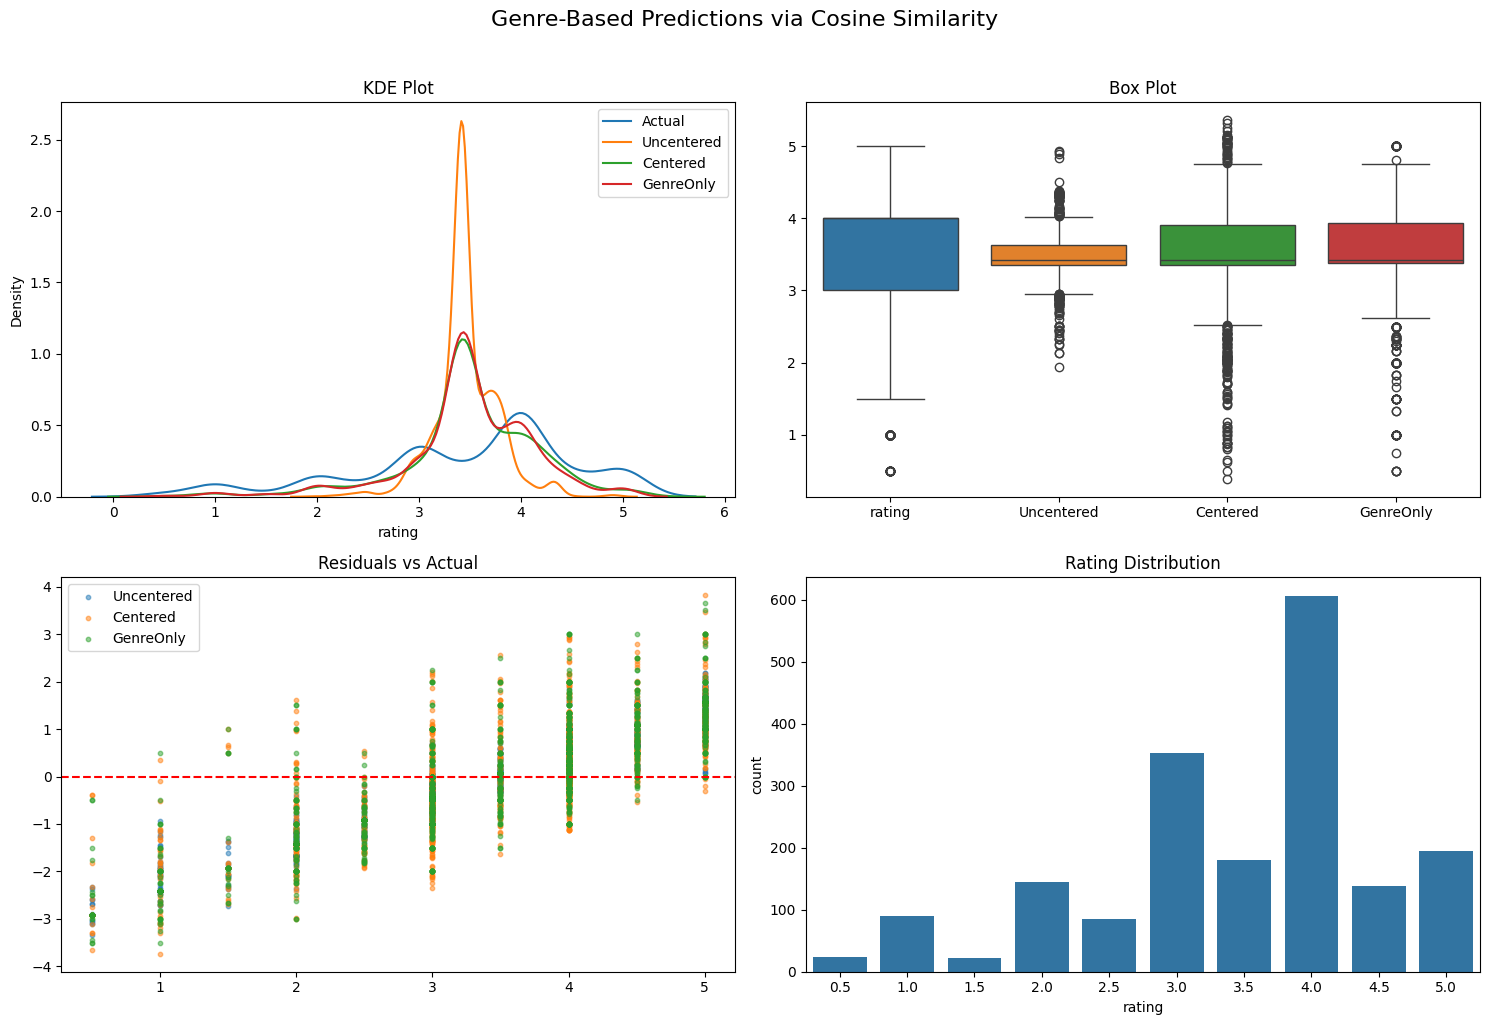

In [ ]:
# --- Setup ---
# Install LightFM only if not already installed
try:
    import lightfm
except ImportError:
    !pip install lightfm
    import lightfm

# --- Required Libraries ---
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Load Merged Data ---
data = pd.read_csv('stratified_df.csv')

# --- Step 2: One-Hot Encode Genres ---
data['genres'] = data['genres'].fillna('')
genre_df = data[['movieId', 'genres']].drop_duplicates().set_index('movieId')
genre_df = genre_df['genres'].str.get_dummies(sep='|')

# --- Step 3: Train-Test Split ---
ratings = data[['userId', 'movieId', 'rating']]
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')

# --- Step 4: Cosine Similarity Matrix for Train Movies Only ---
train_movie_ids = train_ratings['movieId'].unique()
genre_train = genre_df.loc[train_movie_ids]
sim_matrix = cosine_similarity(genre_train.values)
sim_df = pd.DataFrame(sim_matrix, index=genre_train.index, columns=genre_train.index)

# --- Step 5: Rating Stats ---
global_mean = train_ratings['rating'].mean()
user_means = user_movie_matrix.mean(axis=1)
movie_means = user_movie_matrix.mean(axis=0)

# --- Step 6: Predict Functions ---
def uncentered_predict(uid, mid):
    if uid not in user_movie_matrix.index or mid not in sim_df.index:
        return global_mean, True
    user_ratings = user_movie_matrix.loc[uid].dropna()
    valid_movies = user_ratings.index.intersection(sim_df.columns)
    if len(valid_movies) == 0:
        return global_mean, True
    sims = sim_df.loc[mid, valid_movies]
    ratings = user_ratings.loc[valid_movies]
    if sims.sum() == 0:
        return global_mean, True
    return np.dot(sims, ratings) / sims.sum(), False

def centered_predict(uid, mid):
    if uid not in user_movie_matrix.index or mid not in sim_df.index:
        return global_mean, True
    user_ratings = user_movie_matrix.loc[uid].dropna()
    valid_movies = user_ratings.index.intersection(sim_df.columns)
    if len(valid_movies) == 0:
        return global_mean, True
    sims = sim_df.loc[mid, valid_movies]
    ratings = user_ratings.loc[valid_movies]
    user_mean = user_means.get(uid, global_mean)
    item_bias = movie_means.get(mid, global_mean) - global_mean
    adjusted = ratings - user_mean
    if sims.sum() == 0:
        return global_mean + item_bias, True
    return global_mean + item_bias + np.dot(sims, adjusted) / sims.sum(), False

def genre_only_predict(mid):
    if mid not in movie_means:
        return global_mean, True
    return movie_means[mid], False

# --- Step 7: Generate Predictions ---
test_ratings = test_ratings.copy()
test_ratings[['Uncentered', 'Uncent_fallback']] = test_ratings.apply(lambda row: pd.Series(uncentered_predict(row['userId'], row['movieId'])), axis=1)
test_ratings[['Centered', 'Cent_fallback']] = test_ratings.apply(lambda row: pd.Series(centered_predict(row['userId'], row['movieId'])), axis=1)
test_ratings[['GenreOnly', 'Genre_fallback']] = test_ratings['movieId'].apply(lambda mid: pd.Series(genre_only_predict(mid)))

# --- Step 8: Evaluation ---
results = {}
for method in ['Uncentered', 'Centered', 'GenreOnly']:
    df = test_ratings.dropna(subset=[method])
    rmse = np.sqrt(mean_squared_error(df['rating'], df[method]))
    mae = mean_absolute_error(df['rating'], df[method])
    r2 = r2_score(df['rating'], df[method])
    results[method] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}

print("\nEvaluation Metrics:\n", pd.DataFrame(results).T)

# --- Step 9: Report Fallback % ---
print("\nFallback Usage:")
for method, fallback in [('Uncentered', 'Uncent_fallback'), ('Centered', 'Cent_fallback'), ('GenreOnly', 'Genre_fallback')]:
    pct = test_ratings[fallback].mean() * 100
    print(f"{method}: {pct:.1f}% fallback used")

# --- Step 10: Visualizations ---
eval_df = test_ratings.dropna(subset=['Uncentered', 'Centered', 'GenreOnly'])
eval_df['Uncentered_Residual'] = eval_df['rating'] - eval_df['Uncentered']
eval_df['Centered_Residual'] = eval_df['rating'] - eval_df['Centered']
eval_df['GenreOnly_Residual'] = eval_df['rating'] - eval_df['GenreOnly']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
plt.suptitle("Genre-Based Predictions via Cosine Similarity", fontsize=16, y=1.02)

sns.kdeplot(eval_df['rating'], label='Actual', ax=axes[0, 0])
sns.kdeplot(eval_df['Uncentered'], label='Uncentered', ax=axes[0, 0])
sns.kdeplot(eval_df['Centered'], label='Centered', ax=axes[0, 0])
sns.kdeplot(eval_df['GenreOnly'], label='GenreOnly', ax=axes[0, 0])
axes[0, 0].set_title("KDE Plot")
axes[0, 0].legend()

sns.boxplot(data=eval_df[['rating', 'Uncentered', 'Centered', 'GenreOnly']], ax=axes[0, 1])
axes[0, 1].set_title("Box Plot")

axes[1, 0].scatter(eval_df['rating'], eval_df['Uncentered_Residual'], alpha=0.5, s=10, label='Uncentered')
axes[1, 0].scatter(eval_df['rating'], eval_df['Centered_Residual'], alpha=0.5, s=10, label='Centered')
axes[1, 0].scatter(eval_df['rating'], eval_df['GenreOnly_Residual'], alpha=0.5, s=10, label='GenreOnly')
axes[1, 0].axhline(0, color='red', linestyle='--')
axes[1, 0].legend()
axes[1, 0].set_title("Residuals vs Actual")

sns.countplot(x='rating', data=eval_df, ax=axes[1, 1])
axes[1, 1].set_title("Rating Distribution")

plt.tight_layout()
plt.show()


                RMSE       MAE        R2
Uncentered  1.037268  0.814249  0.053424
Centered    1.142432  0.893470 -0.148244
GenreOnly   1.144360  0.889744 -0.152124
Uncentered: 28.0% of predictions used fallback
Centered: 28.0% of predictions used fallback
GenreOnly: 28.0% of predictions used fallback


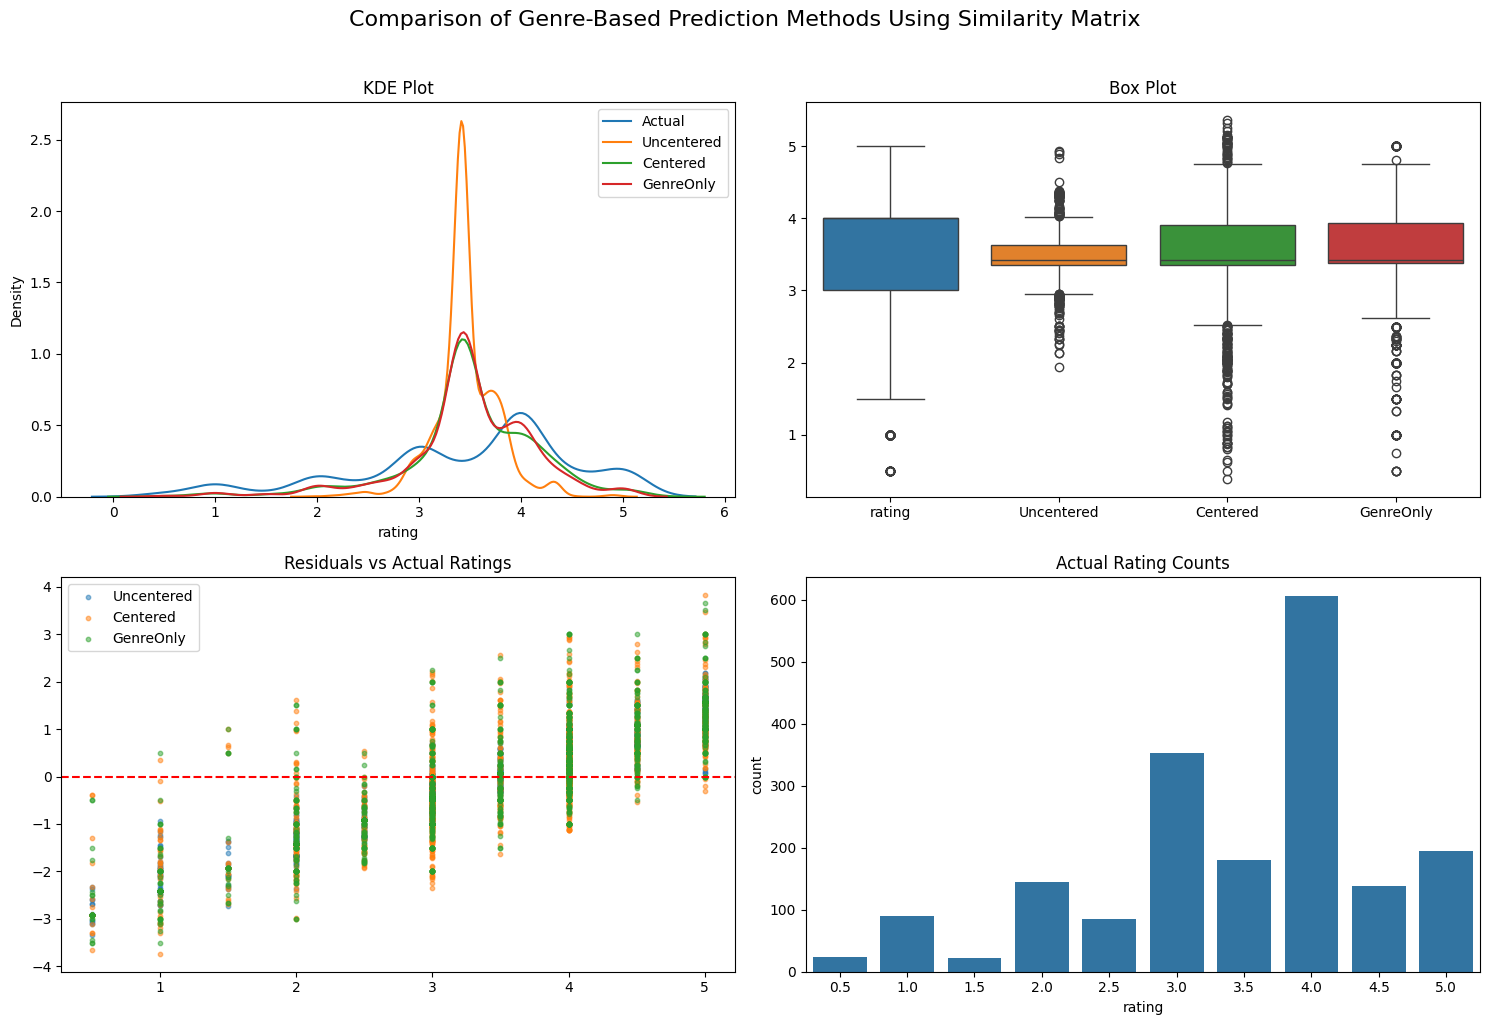

In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Load Datasets (replace with uploads if needed) ---
# movies = pd.read_csv("movies_subset.csv")
# ratings = pd.read_csv("ratings_sampled.csv")

# --- Step 2: Genre One-Hot Encoding ---
movies['genres'] = movies['genres'].fillna('')
genre_df = movies['genres'].str.get_dummies(sep='|')
genre_df.index = movies['movieId']

# --- Step 3: Train-Test Split ---
# train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')

# --- Step 4: Similarity Matrix (Train Movies Only) ---
train_movie_ids = train_ratings['movieId'].unique()
genre_train = genre_df.loc[train_movie_ids]
similarity_matrix = cosine_similarity(genre_train.values)
sim_df = pd.DataFrame(similarity_matrix, index=genre_train.index, columns=genre_train.index)

# --- Step 5: Rating Statistics ---
global_mean = train_ratings['rating'].mean()
user_means = user_movie_matrix.mean(axis=1)
movie_means = user_movie_matrix.mean(axis=0)

# --- Step 6: Prediction Functions ---
def uncentered_predict(uid, mid):
    if uid not in user_movie_matrix.index or mid not in sim_df.index:
        return global_mean, True

    user_ratings = user_movie_matrix.loc[uid].dropna()
    valid_movies = user_ratings.index.intersection(sim_df.columns)

    if len(valid_movies) == 0:
        return global_mean, True

    similarities = sim_df.loc[mid, valid_movies]
    ratings = user_ratings.loc[valid_movies]

    if similarities.sum() == 0:
        return global_mean, True

    return np.dot(similarities, ratings) / similarities.sum(), False

def centered_predict(uid, mid):
    if uid not in user_movie_matrix.index or mid not in sim_df.index:
        return global_mean, True

    user_ratings = user_movie_matrix.loc[uid].dropna()
    valid_movies = user_ratings.index.intersection(sim_df.columns)

    if len(valid_movies) == 0:
        return global_mean, True

    similarities = sim_df.loc[mid, valid_movies]
    ratings = user_ratings.loc[valid_movies]
    user_mean = user_means.get(uid, global_mean)
    item_bias = movie_means.get(mid, global_mean) - global_mean
    adjusted = ratings - user_mean

    if similarities.sum() == 0:
        return global_mean + item_bias, True

    return global_mean + item_bias + np.dot(similarities, adjusted) / similarities.sum(), False

def genre_only_predict(mid):
    if mid not in movie_means:
        return global_mean, True
    return movie_means[mid], False

# --- Step 7: Generate Predictions ---
test_ratings = test_ratings.copy()
test_ratings[['Uncentered', 'Uncent_fallback']] = test_ratings.apply(lambda row: pd.Series(uncentered_predict(row['userId'], row['movieId'])), axis=1)
test_ratings[['Centered', 'Cent_fallback']] = test_ratings.apply(lambda row: pd.Series(centered_predict(row['userId'], row['movieId'])), axis=1)
test_ratings[['GenreOnly', 'Genre_fallback']] = test_ratings.apply(lambda row: pd.Series(genre_only_predict(row['movieId'])), axis=1)

# --- Step 8: Evaluation Metrics ---
results = {}
for method in ['Uncentered', 'Centered', 'GenreOnly']:
    subset = test_ratings.dropna(subset=[method])
    rmse = np.sqrt(mean_squared_error(subset['rating'], subset[method]))
    mae = mean_absolute_error(subset['rating'], subset[method])
    r2 = r2_score(subset['rating'], subset[method])
    results[method] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}

print(pd.DataFrame(results).T)

# --- Step 9: Report Fallback Percentage ---
methods = [('Uncentered', 'Uncent_fallback'), ('Centered', 'Cent_fallback'), ('GenreOnly', 'Genre_fallback')]
for pred_col, fallback_col in methods:
    df = test_ratings.dropna(subset=[pred_col])
    pct = df[fallback_col].mean() * 100
    print(f"{pred_col}: {pct:.1f}% of predictions used fallback")

# --- Step 10: Visualizations ---
eval_df = test_ratings.dropna(subset=['Uncentered', 'Centered', 'GenreOnly'])
eval_df['Uncentered_Residual'] = eval_df['rating'] - eval_df['Uncentered']
eval_df['Centered_Residual'] = eval_df['rating'] - eval_df['Centered']
eval_df['GenreOnly_Residual'] = eval_df['rating'] - eval_df['GenreOnly']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
plt.suptitle("Comparison of Genre-Based Prediction Methods Using Similarity Matrix", fontsize=16, y=1.02)

sns.kdeplot(eval_df['rating'], label='Actual', ax=axes[0, 0])
sns.kdeplot(eval_df['Uncentered'], label='Uncentered', ax=axes[0, 0])
sns.kdeplot(eval_df['Centered'], label='Centered', ax=axes[0, 0])
sns.kdeplot(eval_df['GenreOnly'], label='GenreOnly', ax=axes[0, 0])
axes[0, 0].set_title("KDE Plot")
axes[0, 0].legend()

sns.boxplot(data=eval_df[['rating', 'Uncentered', 'Centered', 'GenreOnly']], ax=axes[0, 1])
axes[0, 1].set_title("Box Plot")

axes[1, 0].scatter(eval_df['rating'], eval_df['Uncentered_Residual'], alpha=0.5, label='Uncentered', s=10)
axes[1, 0].scatter(eval_df['rating'], eval_df['Centered_Residual'], alpha=0.5, label='Centered', s=10)
axes[1, 0].scatter(eval_df['rating'], eval_df['GenreOnly_Residual'], alpha=0.5, label='GenreOnly', s=10)
axes[1, 0].axhline(0, color='red', linestyle='--')
axes[1, 0].set_title("Residuals vs Actual Ratings")
axes[1, 0].legend()

sns.countplot(x='rating', data=eval_df, ax=axes[1, 1])
axes[1, 1].set_title("Actual Rating Counts")

plt.tight_layout()
plt.show()


Uncentred: 28.0% of predictions used fallback
Centred: 28.0% of predictions used fallback
GenreOnly: 28.0% of predictions used fallback
                RMSE       MAE        R2
Uncentered  1.037268  0.814249  0.053424
Centered    1.142432  0.893470 -0.148244
GenreOnly   1.144360  0.889744 -0.152124


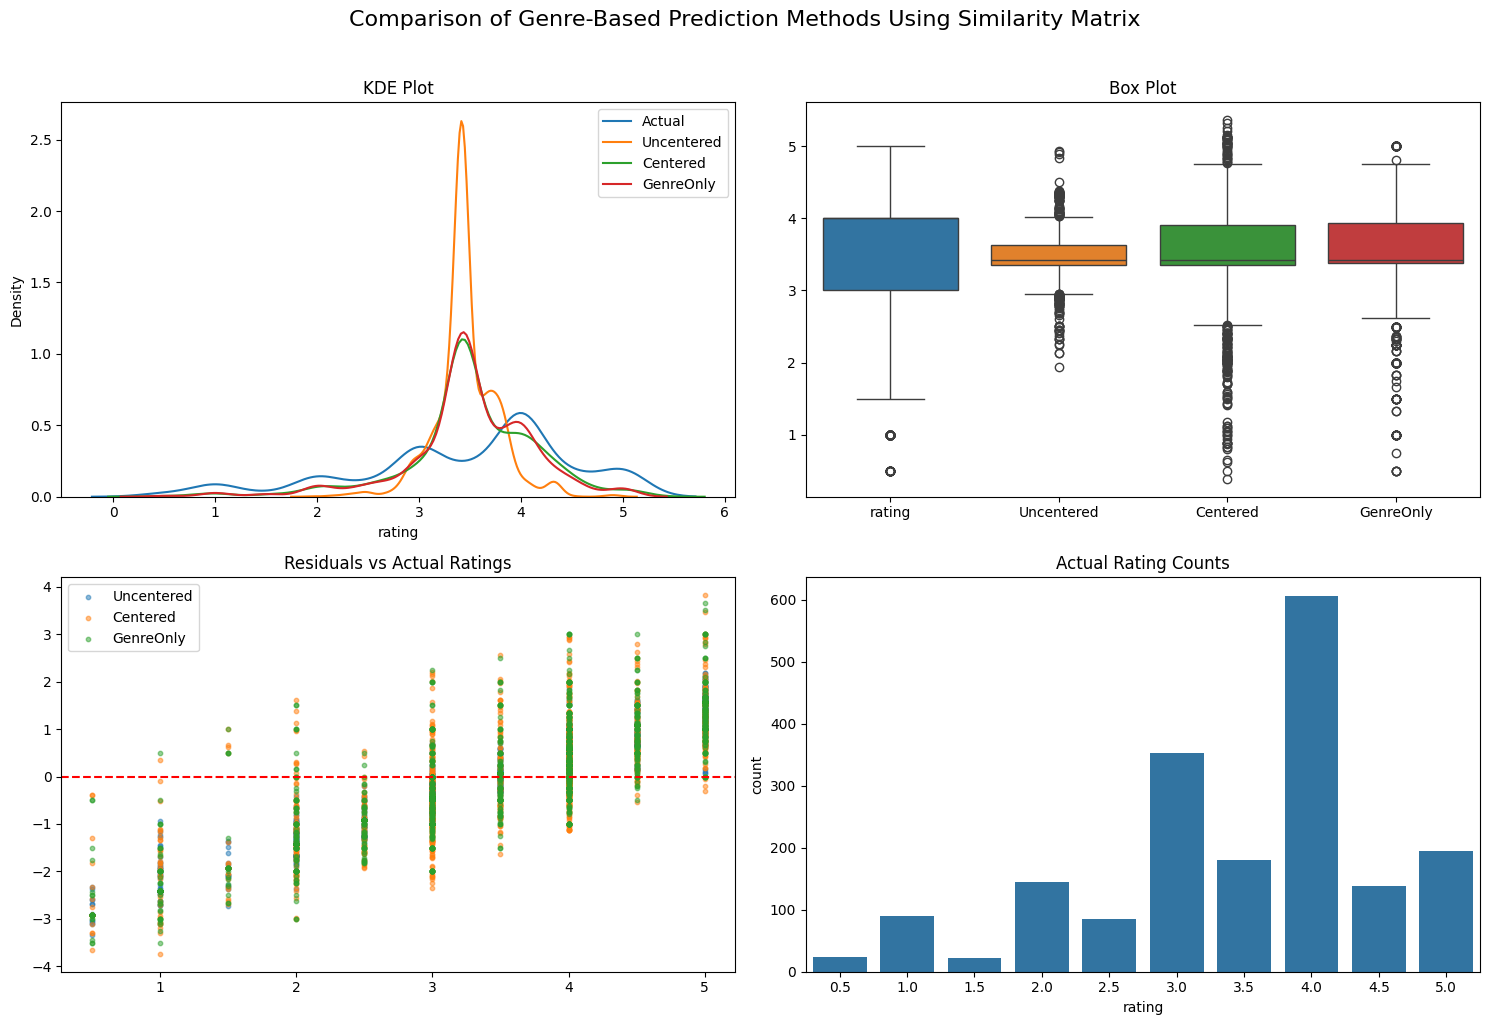

In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 2: Genre One-Hot Encoding ---
movies['genres'] = movies['genres'].fillna('')
genre_df = movies['genres'].str.get_dummies(sep='|')
movie_ids = movies['movieId']
genre_df.index = movie_ids

# --- Step 3: Train-Test Split ---
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')

# --- Step 4: Similarity Matrix (Train Movies Only) ---
train_movie_ids = train_ratings['movieId'].unique()
genre_train = genre_df.loc[train_movie_ids]
similarity_matrix = cosine_similarity(genre_train.values)
sim_df = pd.DataFrame(similarity_matrix, index=genre_train.index, columns=genre_train.index)

# --- Step 5: Rating Statistics ---
global_mean = train_ratings['rating'].mean()
user_means = user_movie_matrix.mean(axis=1)
movie_means = user_movie_matrix.mean(axis=0)

def uncentered_predict(uid, mid):
    # Return (rating, used_fallback)
    if uid not in user_movie_matrix.index or mid not in sim_df.index:
        return global_mean, True

    user_ratings = user_movie_matrix.loc[uid].dropna()
    valid = user_ratings.index.intersection(sim_df.columns)
    if valid.empty:
        return global_mean, True

    sims = sim_df.loc[mid, valid]
    ratings = user_ratings.loc[valid]
    if sims.sum() == 0:
        return ratings.mean() if not ratings.empty else global_mean, True

    return np.dot(sims, ratings) / sims.sum(), False


def centered_predict(uid, mid):
    if uid not in user_movie_matrix.index or mid not in sim_df.index:
        return global_mean, True

    user_ratings = user_movie_matrix.loc[uid].dropna()
    valid = user_ratings.index.intersection(sim_df.columns)
    if valid.empty:
        return global_mean, True

    sims = sim_df.loc[mid, valid]
    ratings = user_ratings.loc[valid]
    user_mean = user_means.get(uid, global_mean)
    item_bias = movie_means.get(mid, global_mean) - global_mean
    adjusted = ratings - user_mean

    if sims.sum() == 0:
        return global_mean + item_bias, True

    return global_mean + item_bias + np.dot(sims, adjusted) / sims.sum(), False


def genre_only_predict(mid):
    if mid not in movie_means:
        return global_mean, True
    return movie_means[mid], False


# --- Step 7: Generate Predictions ---
test = test_ratings.copy()
test[['Uncentred', 'Uncent_fallback']] = test.apply(
    lambda r: pd.Series(uncentered_predict(r['userId'], r['movieId'])), axis=1)
test[['Centred', 'Cent_fallback']] = test.apply(
    lambda r: pd.Series(centered_predict(r['userId'], r['movieId'])), axis=1)
test[['GenreOnly', 'Genre_fallback']] = test['movieId'].apply(
    lambda mid: pd.Series(genre_only_predict(mid)))

methods = [
    ('Uncentred', 'Uncent_fallback'),
    ('Centred', 'Cent_fallback'),
    ('GenreOnly', 'Genre_fallback')
]

for pred_col, fallback_col in methods:
    df = test.dropna(subset=[pred_col])
    pct = df[fallback_col].mean() * 100
    print(f"{pred_col}: {pct:.1f}% of predictions used fallback")


# test_ratings = test_ratings.copy()
# test_ratings['Uncentered'] = test_ratings.apply(lambda row: uncentered_predict(row['userId'], row['movieId']), axis=1)
# test_ratings['Centered'] = test_ratings.apply(lambda row: centered_predict(row['userId'], row['movieId']), axis=1)
# test_ratings['GenreOnly'] = test_ratings['movieId'].apply(genre_only_predict)

# --- Step 8: Evaluation Metrics ---
results = {}
for method in ['Uncentered', 'Centered', 'GenreOnly']:
    subset = test_ratings.dropna(subset=[method])
    rmse = np.sqrt(mean_squared_error(subset['rating'], subset[method]))
    mae = mean_absolute_error(subset['rating'], subset[method])
    r2 = r2_score(subset['rating'], subset[method])
    results[method] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}

print(pd.DataFrame(results).T)

# --- Step 9: Visualizations ---
eval_df = test_ratings.dropna(subset=['Uncentered', 'Centered', 'GenreOnly'])

# Residuals
eval_df['Uncentered_Residual'] = eval_df['rating'] - eval_df['Uncentered']
eval_df['Centered_Residual'] = eval_df['rating'] - eval_df['Centered']
eval_df['GenreOnly_Residual'] = eval_df['rating'] - eval_df['GenreOnly']

# Plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
plt.suptitle("Comparison of Genre-Based Prediction Methods Using Similarity Matrix", fontsize=16, y=1.02)

# KDE
sns.kdeplot(eval_df['rating'], label='Actual', ax=axes[0, 0])
sns.kdeplot(eval_df['Uncentered'], label='Uncentered', ax=axes[0, 0])
sns.kdeplot(eval_df['Centered'], label='Centered', ax=axes[0, 0])
sns.kdeplot(eval_df['GenreOnly'], label='GenreOnly', ax=axes[0, 0])
axes[0, 0].set_title("KDE Plot")
axes[0, 0].legend()

# Box Plot
sns.boxplot(data=eval_df[['rating', 'Uncentered', 'Centered', 'GenreOnly']], ax=axes[0, 1])
axes[0, 1].set_title("Box Plot")

# Residuals Plot
axes[1, 0].scatter(eval_df['rating'], eval_df['Uncentered_Residual'], alpha=0.5, label='Uncentered', s=10)
axes[1, 0].scatter(eval_df['rating'], eval_df['Centered_Residual'], alpha=0.5, label='Centered', s=10)
axes[1, 0].scatter(eval_df['rating'], eval_df['GenreOnly_Residual'], alpha=0.5, label='GenreOnly', s=10)
axes[1, 0].axhline(0, color='red', linestyle='--')
axes[1, 0].set_title("Residuals vs Actual Ratings")
axes[1, 0].legend()

# Bar Plot
sns.countplot(x='rating', data=eval_df, ax=axes[1, 1])
axes[1, 1].set_title("Actual Rating Counts")

plt.tight_layout()
plt.show()


/tmp/ipython-input-20-31193532.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[ax_row, 0].set_xticklabels(['Actual', 'Predicted'])
/tmp/ipython-input-20-31193532.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[ax_row, 0].set_xticklabels(['Actual', 'Predicted'])
/tmp/ipython-input-20-31193532.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[ax_row, 0].set_xticklabels(['Actual', 'Predicted'])


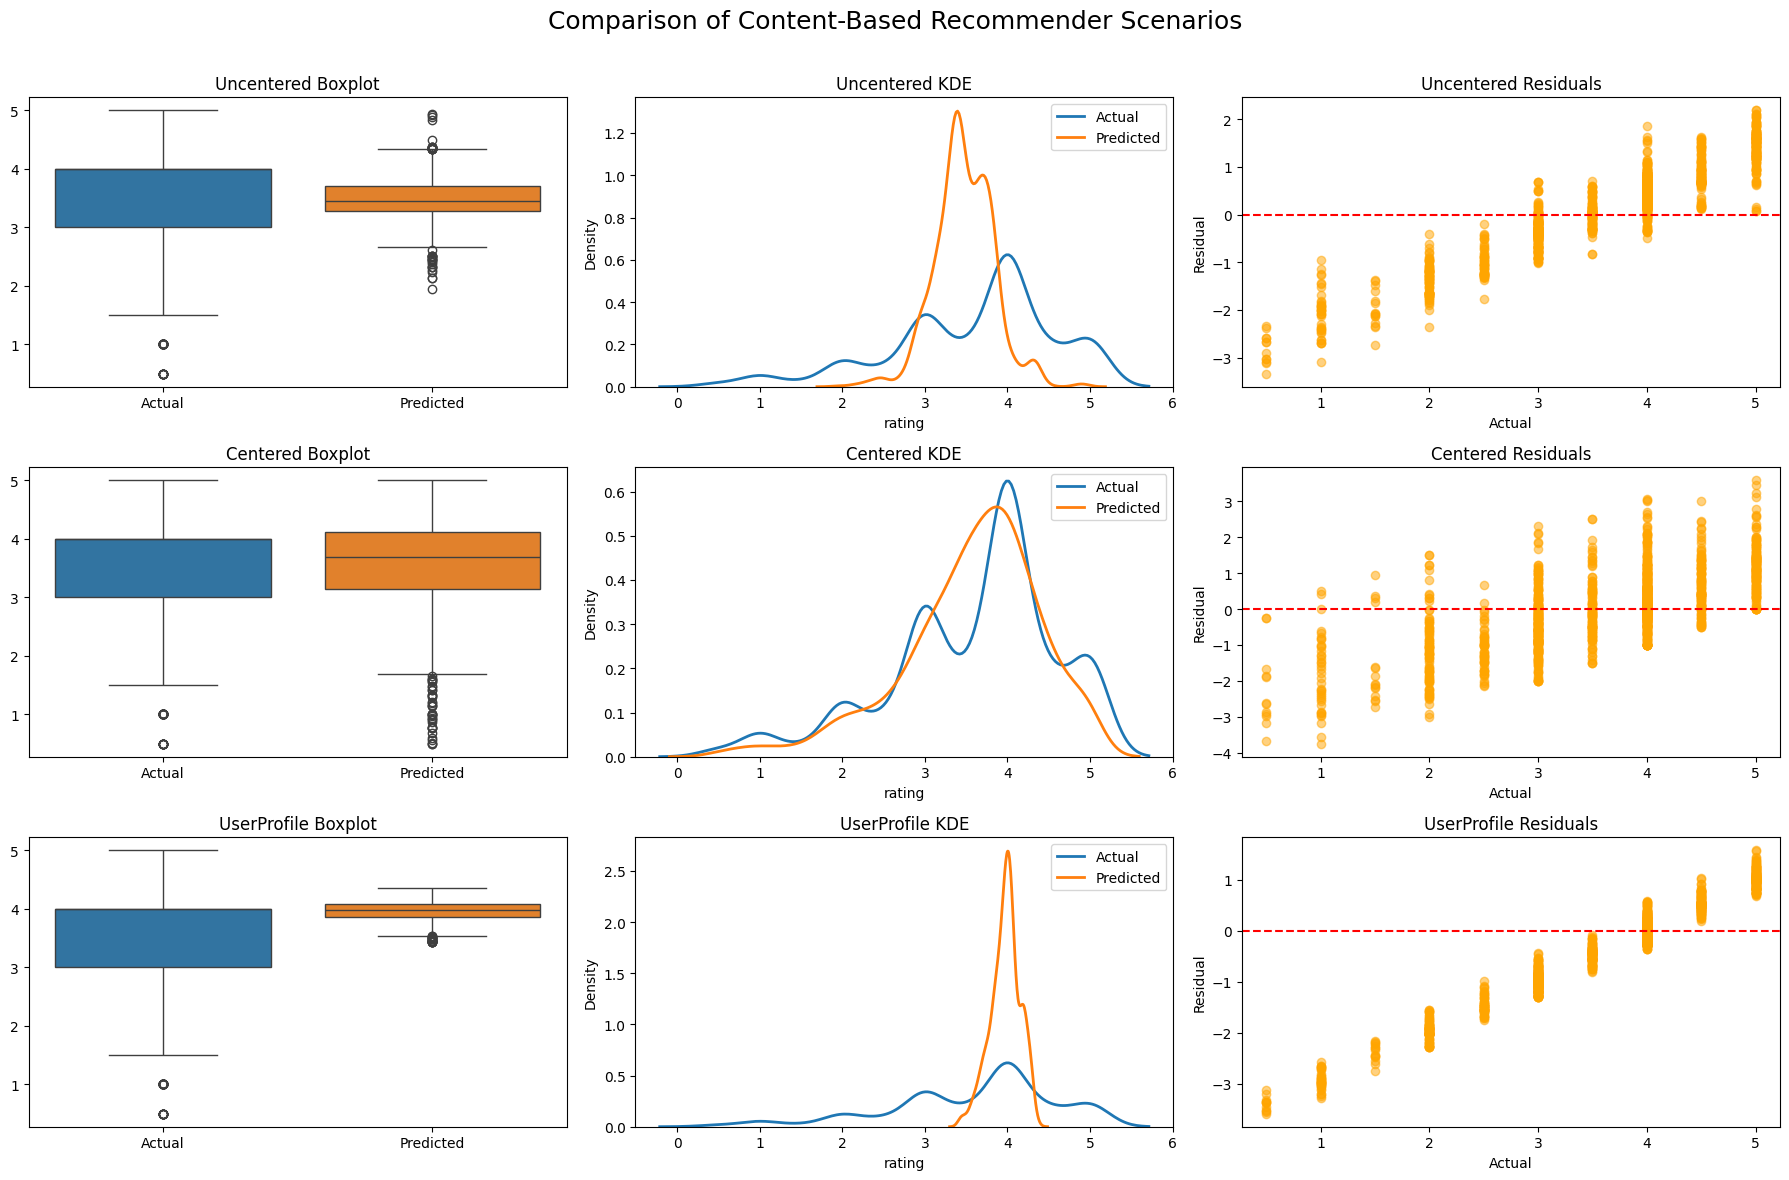

         Model      RMSE       MAE        R²
0   Uncentered  0.971648  0.770724  0.056792
1     Centered  1.097219  0.847488 -0.202753
2  UserProfile  1.073133  0.784943 -0.150528


In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# # --- Step 1: Load Data ---
# movies = pd.read_csv("movies_subset.csv")
# ratings = pd.read_csv("ratings_sampled.csv")

# --- Step 2: Preprocess Genres & Train-Test Split ---
movies['genres'] = movies['genres'].fillna('')
genre_df = movies['genres'].str.get_dummies(sep='|')
movie_ids = movies['movieId']
genre_df.index = movie_ids

# train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)

# --- Step 3: Build Similarity Matrix from TRAIN MOVIES ONLY ---
train_movie_ids = train_ratings['movieId'].unique()
train_genre_df = genre_df.loc[genre_df.index.intersection(train_movie_ids)]
genre_matrix = train_genre_df.values
similarity_matrix = cosine_similarity(genre_matrix)
sim_df = pd.DataFrame(similarity_matrix, index=train_genre_df.index, columns=train_genre_df.index)

# --- Step 4: Create User-Movie Matrix from Train ---
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
movie_means = train_ratings.groupby('movieId')['rating'].mean()
user_means = train_ratings.groupby('userId')['rating'].mean()

# --- Step 5: Prediction Functions ---
def uncentered_predict(uid, mid):
    if uid not in user_movie_matrix.index or mid not in sim_df.index:
        return np.nan
    user_ratings = user_movie_matrix.loc[uid].dropna()
    common_movies = sim_df.columns.intersection(user_ratings.index)
    sims = sim_df.loc[mid, common_movies]
    ratings = user_ratings.loc[common_movies]
    if sims.sum() == 0:
        return global_mean
    return np.dot(sims, ratings) / sims.sum()

def centered_predict(uid, mid):
    if uid not in user_movie_matrix.index or mid not in sim_df.index:
        return np.nan
    user_ratings = user_movie_matrix.loc[uid].dropna()
    user_bias = user_means.get(uid, global_mean) - global_mean
    item_bias = movie_means.get(mid, global_mean) - global_mean
    common_movies = sim_df.columns.intersection(user_ratings.index)
    sims = sim_df.loc[mid, common_movies]
    ratings = user_ratings.loc[common_movies]
    if sims.sum() == 0:
        return global_mean + user_bias + item_bias
    pred = np.dot(sims, ratings - user_means.loc[uid]) / sims.sum()
    return np.clip(global_mean + user_bias + item_bias + pred, 0.5, 5.0)

def user_profile_predict(uid, mid):
    if uid not in user_movie_matrix.index or mid not in genre_df.index:
        return np.nan
    user_ratings = user_movie_matrix.loc[uid].dropna()
    rated_genres = genre_df.loc[genre_df.index.intersection(user_ratings.index)]
    if rated_genres.empty:
        return global_mean
    user_profile = np.dot(user_ratings.values, rated_genres.values) / user_ratings.sum()
    target_genre = genre_df.loc[mid].values if mid in genre_df.index else np.zeros(rated_genres.shape[1])
    sim = cosine_similarity([user_profile], [target_genre])[0][0]
    return np.clip(global_mean + sim * 1.0, 0.5, 5.0)

# --- Step 6: Apply Predictions ---
test_ratings = test_ratings.copy()
test_ratings['Uncentered'] = test_ratings.apply(lambda x: uncentered_predict(x['userId'], x['movieId']), axis=1)
test_ratings['Centered'] = test_ratings.apply(lambda x: centered_predict(x['userId'], x['movieId']), axis=1)
test_ratings['UserProfile'] = test_ratings.apply(lambda x: user_profile_predict(x['userId'], x['movieId']), axis=1)

# --- Step 7: Evaluate and Visualize ---
def evaluate_and_plot(df, pred_col, ax_row, title_suffix):
    eval_df = df.dropna(subset=[pred_col]).copy()
    eval_df['Residual'] = eval_df['rating'] - eval_df[pred_col]
    rmse = np.sqrt(mean_squared_error(eval_df['rating'], eval_df[pred_col]))
    mae = mean_absolute_error(eval_df['rating'], eval_df[pred_col])
    r2 = r2_score(eval_df['rating'], eval_df[pred_col])

    axes[ax_row, 0].set_title(f"{pred_col} Boxplot")
    sns.boxplot(data=eval_df[['rating', pred_col]], ax=axes[ax_row, 0])
    axes[ax_row, 0].set_xticklabels(['Actual', 'Predicted'])

    axes[ax_row, 1].set_title(f"{pred_col} KDE")
    sns.kdeplot(eval_df['rating'], label='Actual', ax=axes[ax_row, 1], linewidth=2)
    sns.kdeplot(eval_df[pred_col], label='Predicted', ax=axes[ax_row, 1], linewidth=2)
    axes[ax_row, 1].legend()

    axes[ax_row, 2].set_title(f"{pred_col} Residuals")
    axes[ax_row, 2].scatter(eval_df['rating'], eval_df['Residual'], alpha=0.5, color='orange')
    axes[ax_row, 2].axhline(0, color='red', linestyle='--')
    axes[ax_row, 2].set_xlabel("Actual")
    axes[ax_row, 2].set_ylabel("Residual")

    return pred_col, rmse, mae, r2

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
plt.suptitle("Comparison of Content-Based Recommender Scenarios", fontsize=18)

results = []
for idx, model in enumerate(['Uncentered', 'Centered', 'UserProfile']):
    results.append(evaluate_and_plot(test_ratings, model, idx, model))

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# --- Summary Table ---
summary_df = pd.DataFrame(results, columns=["Model", "RMSE", "MAE", "R²"])
print(summary_df)


RMSE: 1.2647
MAE: 0.9478
R²: -0.5107


/tmp/ipython-input-16-4069456872.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['Residual'] = eval_df['rating'] - eval_df['Predicted_Rating']
/tmp/ipython-input-16-4069456872.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0, 0], palette="Blues_d")
/tmp/ipython-input-16-4069456872.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(['Actual', 'Predicted'])


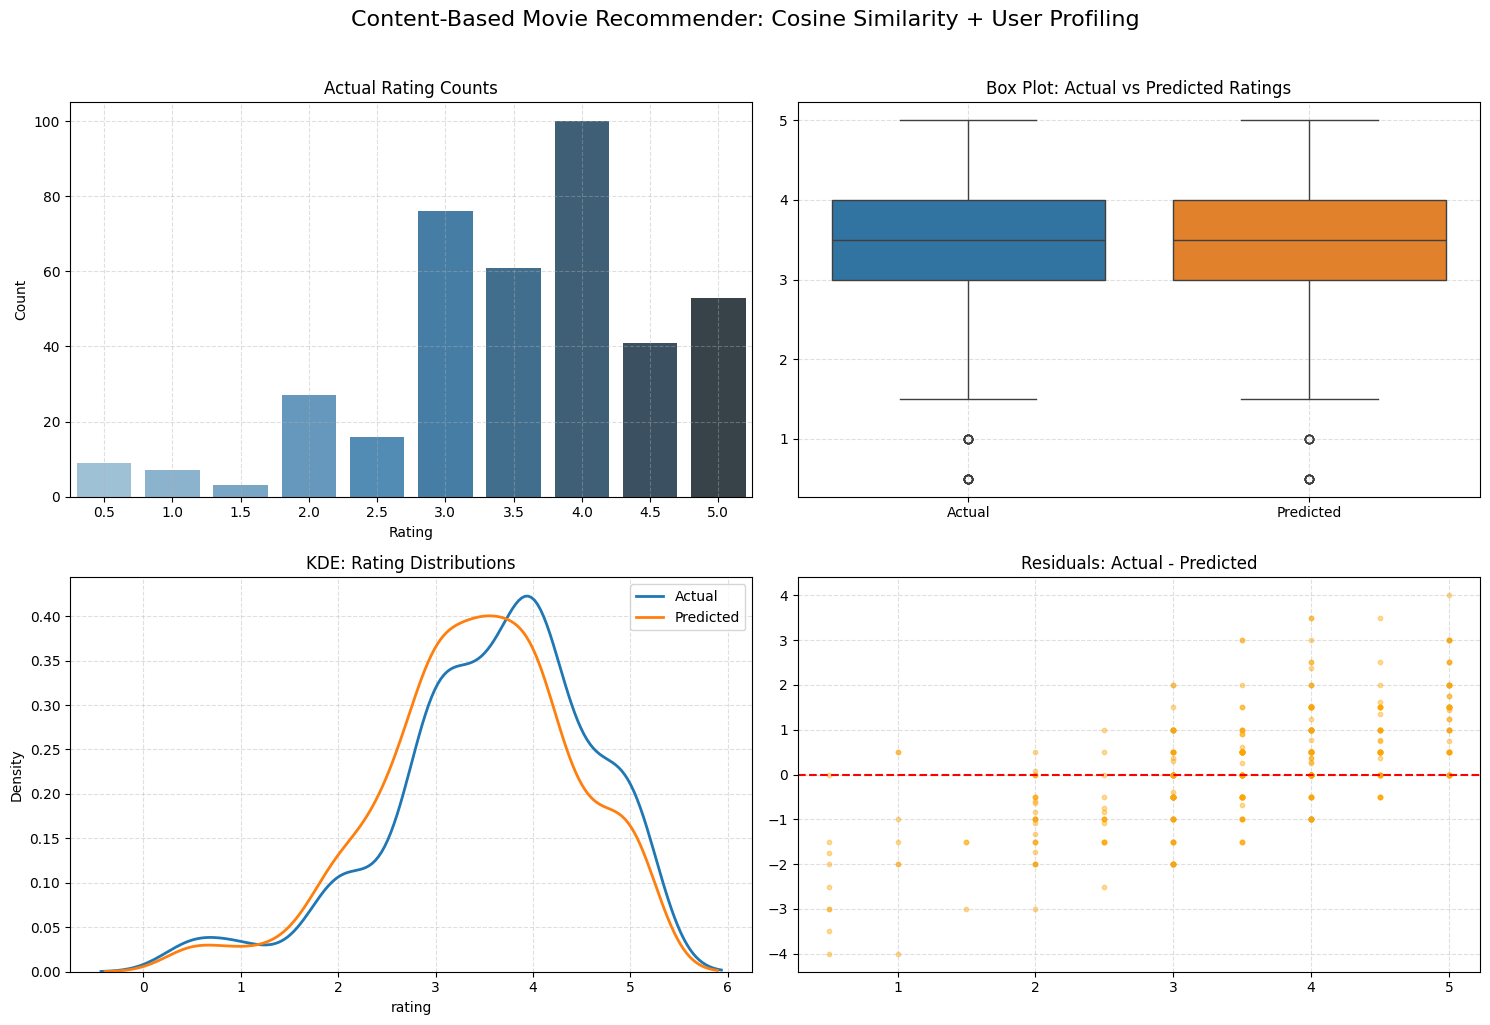

In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Load Data ---
# movies = pd.read_csv("movies_subset.csv")
# ratings = pd.read_csv("ratings_sampled.csv")

# --- Step 2: Train-Test Split (on ratings only) ---
# train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)

# --- Step 3: Genre Matrix from Training Movies Only ---
train_movie_ids = train_ratings['movieId'].unique()
genre_df = movies[movies['movieId'].isin(train_movie_ids)].copy()
genre_df['genres'] = genre_df['genres'].fillna('')
genre_onehot = genre_df['genres'].str.get_dummies(sep='|')
genre_onehot.index = genre_df['movieId']

# --- Step 4: Cosine Similarity Matrix from Training Movies Only ---
similarity_matrix = cosine_similarity(genre_onehot.values)
sim_df = pd.DataFrame(similarity_matrix, index=genre_onehot.index, columns=genre_onehot.index)

# --- Step 5: Build User-Movie Rating Matrix from Training Data ---
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')

# --- Step 6: Predict Function Using Similar Movies Rated by User ---
def predict_rating_with_user_profile(uid, mid, top_n=10):
    if uid not in user_movie_matrix.index or mid not in sim_df.index:
        return np.nan

    user_rated_movies = user_movie_matrix.loc[uid].dropna()
    if user_rated_movies.empty:
        return np.nan

    sim_scores = sim_df.loc[mid, user_rated_movies.index]
    ratings = user_rated_movies.loc[sim_scores.index]

    if sim_scores.sum() == 0:
        return ratings.mean() if not ratings.empty else np.nan

    weighted_sum = np.dot(sim_scores.values, ratings.values)
    return weighted_sum / sim_scores.sum()

# --- Step 7: Generate Predictions for Test Set ---
test_ratings = test_ratings.copy()
test_ratings['Predicted_Rating'] = test_ratings.apply(
    lambda row: predict_rating_with_user_profile(row['userId'], row['movieId']), axis=1
)

# --- Step 8: Evaluation ---
eval_df = test_ratings.dropna(subset=['Predicted_Rating'])
rmse = np.sqrt(mean_squared_error(eval_df['rating'], eval_df['Predicted_Rating']))
mae = mean_absolute_error(eval_df['rating'], eval_df['Predicted_Rating'])
r2 = r2_score(eval_df['rating'], eval_df['Predicted_Rating'])

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# --- Step 9: Visualizations ---
eval_df['Residual'] = eval_df['rating'] - eval_df['Predicted_Rating']
rating_counts = eval_df['rating'].value_counts().sort_index()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
plt.suptitle("Content-Based Movie Recommender: Cosine Similarity + User Profiling", fontsize=16, y=1.02)

# 1. Bar Plot of Rating Counts
sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0, 0], palette="Blues_d")
axes[0, 0].set_title("Actual Rating Counts")
axes[0, 0].set_xlabel("Rating")
axes[0, 0].set_ylabel("Count")
axes[0, 0].grid(True, linestyle='--', alpha=0.4)

# 2. Box Plot
sns.boxplot(data=eval_df[['rating', 'Predicted_Rating']], ax=axes[0, 1])
axes[0, 1].set_xticklabels(['Actual', 'Predicted'])
axes[0, 1].set_title("Box Plot: Actual vs Predicted Ratings")
axes[0, 1].grid(True, linestyle='--', alpha=0.4)

# 3. KDE Plot
sns.kdeplot(eval_df['rating'], label='Actual', ax=axes[1, 0], linewidth=2)
sns.kdeplot(eval_df['Predicted_Rating'], label='Predicted', ax=axes[1, 0], linewidth=2)
axes[1, 0].set_title("KDE: Rating Distributions")
axes[1, 0].legend()
axes[1, 0].grid(True, linestyle='--', alpha=0.4)

# 4. Residual Plot
axes[1, 1].scatter(eval_df['rating'], eval_df['Residual'], alpha=0.4, color='orange', s=10)
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_title("Residuals: Actual - Predicted")
axes[1, 1].grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


RMSE: 1.2647
MAE: 0.9478
R²: -0.5107


/tmp/ipython-input-13-2611294531.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['Residual'] = eval_df['rating'] - eval_df['Predicted_Rating']
/tmp/ipython-input-13-2611294531.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0, 0], palette="Blues_d")
/tmp/ipython-input-13-2611294531.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(['Actual', 'Predicted'])


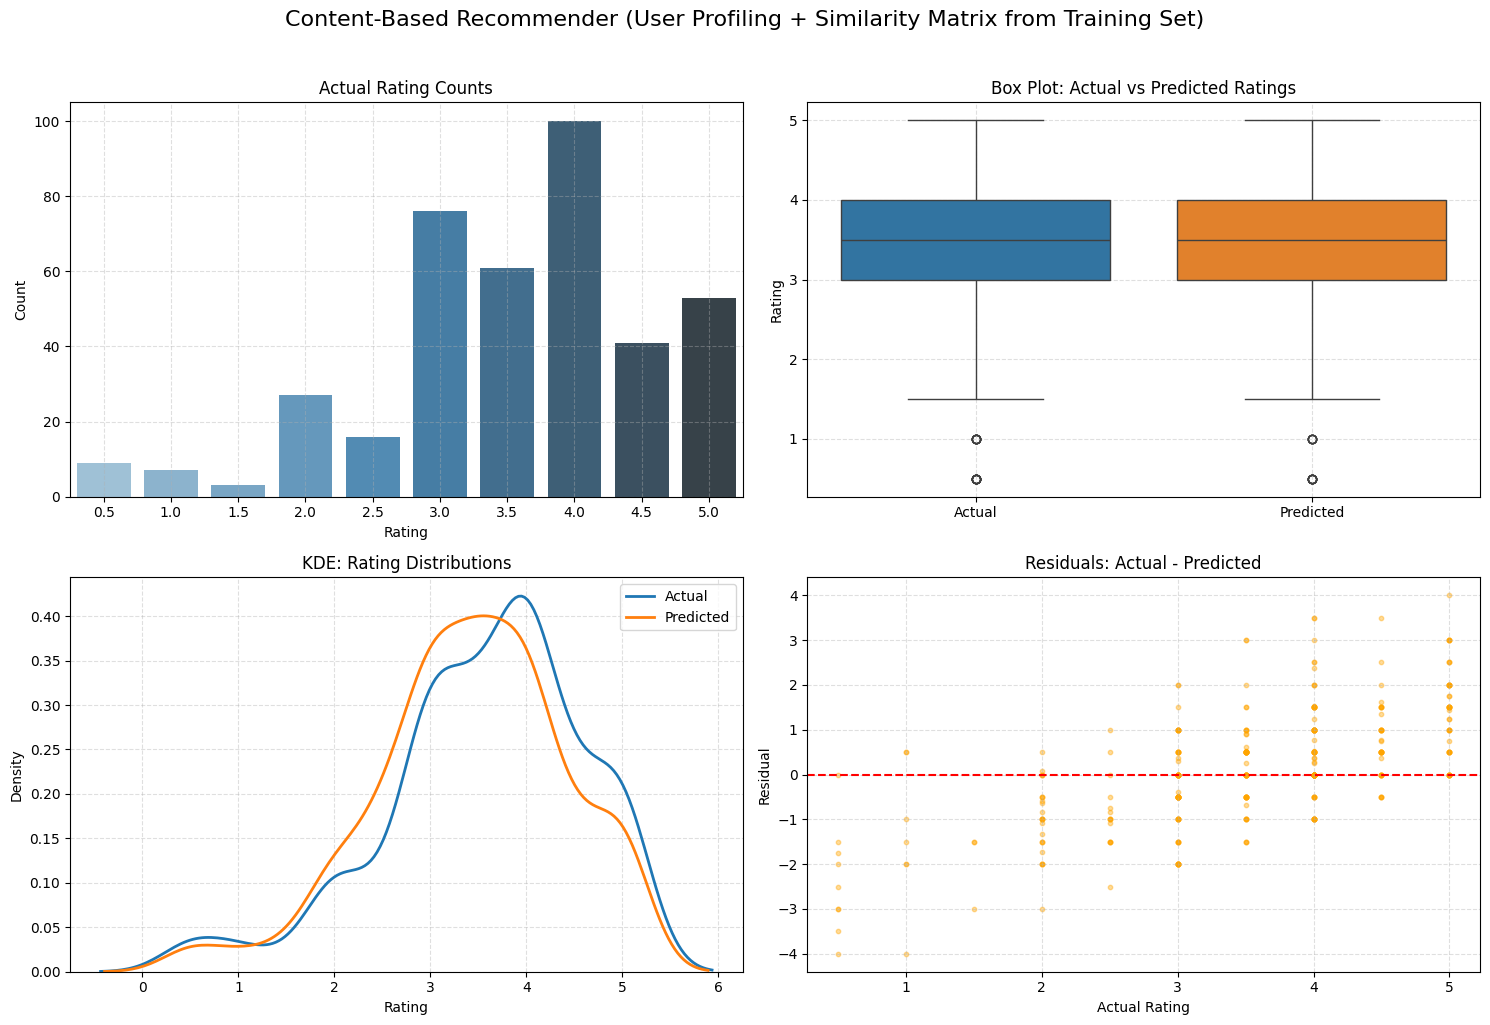

In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Train-test split ---
# train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')

# --- Step 2: Build similarity matrix using only training movies ---
train_movie_ids = train_ratings['movieId'].unique()
movies_train = movies[movies['movieId'].isin(train_movie_ids)].copy()
movies_train['genres'] = movies_train['genres'].fillna('')
genre_df = movies_train['genres'].str.get_dummies(sep='|')
movie_ids = movies_train['movieId']
genre_df.index = movie_ids

# Compute cosine similarity
genre_matrix = genre_df.values
similarity_matrix = cosine_similarity(genre_matrix)
sim_df = pd.DataFrame(similarity_matrix, index=movie_ids, columns=movie_ids)

# --- Step 3: Prediction using user profiling and similarity matrix ---
def predict_rating_with_user_profile(uid, mid):
    if uid not in user_movie_matrix.index or mid not in sim_df.columns:
        return np.nan

    user_ratings = user_movie_matrix.loc[uid].dropna()
    if mid not in sim_df.index:
        return np.nan

    similarities = sim_df.loc[mid, user_ratings.index.intersection(sim_df.columns)]
    ratings = user_ratings.loc[similarities.index]

    if similarities.sum() == 0:
        return ratings.mean() if not ratings.empty else np.nan

    weighted_sum = np.dot(similarities.values, ratings.values)
    return weighted_sum / similarities.sum()

# --- Step 4: Generate predictions for test set only ---
test_ratings = test_ratings.copy()
test_ratings['Predicted_Rating'] = test_ratings.apply(
    lambda row: predict_rating_with_user_profile(row['userId'], row['movieId']), axis=1
)

# --- Step 5: Evaluation ---
eval_df = test_ratings.dropna(subset=['Predicted_Rating'])
rmse = np.sqrt(mean_squared_error(eval_df['rating'], eval_df['Predicted_Rating']))
mae = mean_absolute_error(eval_df['rating'], eval_df['Predicted_Rating'])
r2 = r2_score(eval_df['rating'], eval_df['Predicted_Rating'])

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# --- Step 6: Visualizations ---
eval_df['Residual'] = eval_df['rating'] - eval_df['Predicted_Rating']
rating_counts = eval_df['rating'].value_counts().sort_index()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
plt.suptitle("Content-Based Recommender (User Profiling + Similarity Matrix from Training Set)", fontsize=16, y=1.02)

# 1. Bar Plot
sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0, 0], palette="Blues_d")
axes[0, 0].set_title("Actual Rating Counts")
axes[0, 0].set_xlabel("Rating")
axes[0, 0].set_ylabel("Count")
axes[0, 0].grid(True, linestyle='--', alpha=0.4)

# 2. Box Plot
sns.boxplot(data=eval_df[['rating', 'Predicted_Rating']], ax=axes[0, 1])
axes[0, 1].set_xticklabels(['Actual', 'Predicted'])
axes[0, 1].set_title("Box Plot: Actual vs Predicted Ratings")
axes[0, 1].set_ylabel("Rating")
axes[0, 1].grid(True, linestyle='--', alpha=0.4)

# 3. KDE Plot
sns.kdeplot(eval_df['rating'], label='Actual', ax=axes[1, 0], linewidth=2)
sns.kdeplot(eval_df['Predicted_Rating'], label='Predicted', ax=axes[1, 0], linewidth=2)
axes[1, 0].set_title("KDE: Rating Distributions")
axes[1, 0].set_xlabel("Rating")
axes[1, 0].set_ylabel("Density")
axes[1, 0].legend()
axes[1, 0].grid(True, linestyle='--', alpha=0.4)

# 4. Residual Plot
axes[1, 1].scatter(eval_df['rating'], eval_df['Residual'], alpha=0.4, color='orange', s=10)
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_title("Residuals: Actual - Predicted")
axes[1, 1].set_xlabel("Actual Rating")
axes[1, 1].set_ylabel("Residual")
axes[1, 1].grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TF Genre Similarity Prediction: RMSE=1.0776, MAE=0.8360, R²=-0.1429


/tmp/ipython-input-22-484647513.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Actual', data=viz_df, ax=axes[0, 0], palette='Blues_d')


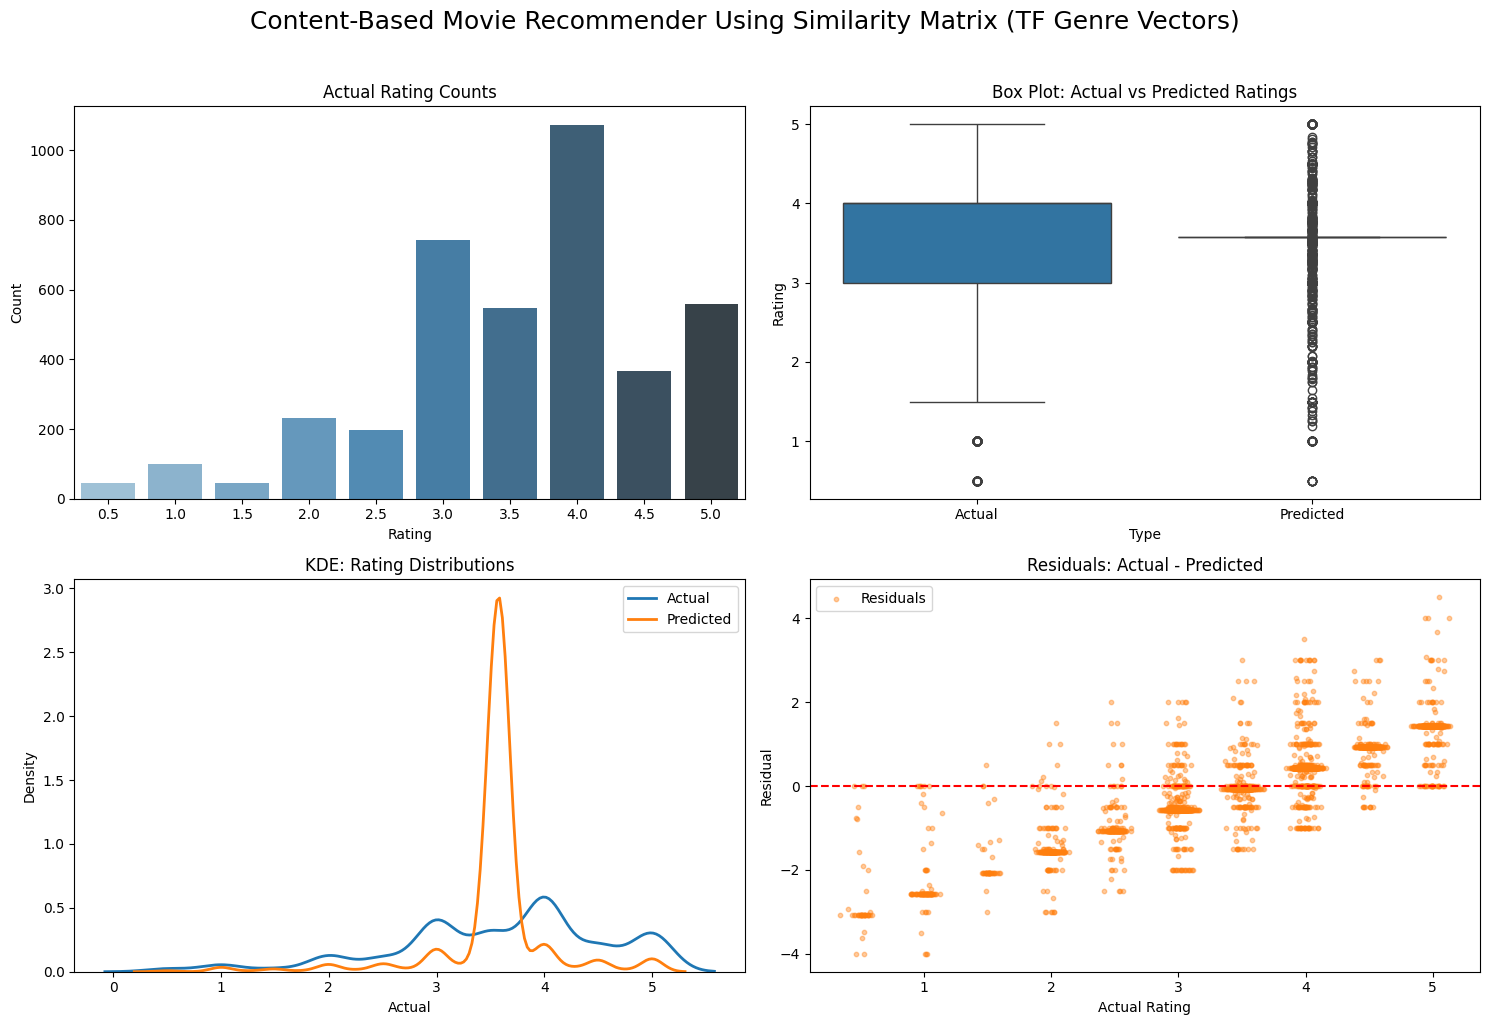

In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: TF Genre Matrix ---
movies = stratified_df[['movieId', 'genres']].drop_duplicates()
movies['genres'] = movies['genres'].fillna('')
vectorizer = CountVectorizer(tokenizer=lambda x: x.split('|'), lowercase=False)
genre_matrix = pd.DataFrame(
    vectorizer.fit_transform(movies['genres']).toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=movies['movieId']
)

# --- Step 2: Cosine Similarity Matrix ---
cos_sim_matrix = pd.DataFrame(
    cosine_similarity(genre_matrix),
    index=genre_matrix.index,
    columns=genre_matrix.index
)

# --- Step 3: Rating Matrix ---
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()

# --- Step 4: Predict Rating Using Similarity Matrix ---
def predict_rating_with_sim_matrix(user_id, target_movie_id):
    if user_id not in user_movie_matrix.index or target_movie_id not in cos_sim_matrix:
        return global_mean
    rated_movies = user_movie_matrix.loc[user_id].dropna()
    rated_movie_ids = rated_movies.index.intersection(cos_sim_matrix.columns)
    if len(rated_movie_ids) == 0:
        return global_mean
    similarities = cos_sim_matrix.loc[target_movie_id, rated_movie_ids]
    ratings = rated_movies[rated_movie_ids]
    weighted_sum = np.dot(similarities, ratings)
    sim_sum = similarities.sum()
    return max(0.5, min(weighted_sum / sim_sum, 5.0)) if sim_sum != 0 else global_mean

# --- Step 5: Generate Predictions ---
actuals, predictions = [], []
for _, row in test_ratings.iterrows():
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    pred = predict_rating_with_sim_matrix(uid, mid)
    actuals.append(actual)
    predictions.append(pred)

# --- Step 6: Evaluation ---
rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
print(f"TF Genre Similarity Prediction: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

# --- Step 7: Visualizations ---
viz_df = pd.DataFrame({
    'Actual': actuals,
    'Predicted': predictions,
    'Residual': np.array(actuals) - np.array(predictions)
})

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Bar Plot
sns.countplot(x='Actual', data=viz_df, ax=axes[0, 0], palette='Blues_d')
axes[0, 0].set_title("Actual Rating Counts")
axes[0, 0].set_xlabel("Rating")
axes[0, 0].set_ylabel("Count")

# Box Plot
box_df = viz_df.melt(value_vars=['Actual', 'Predicted'], var_name='Type', value_name='Rating')
sns.boxplot(x='Type', y='Rating', data=box_df, ax=axes[0, 1])
axes[0, 1].set_title("Box Plot: Actual vs Predicted Ratings")

# KDE
sns.kdeplot(viz_df['Actual'], label='Actual', ax=axes[1, 0], color='C0', linewidth=2)
sns.kdeplot(viz_df['Predicted'], label='Predicted', ax=axes[1, 0], color='C1', linewidth=2)
axes[1, 0].set_title("KDE: Rating Distributions")
axes[1, 0].legend()

# Residual Plot
jitter = np.random.normal(0, 0.05, size=len(viz_df))
axes[1, 1].scatter(viz_df['Actual'] + jitter, viz_df['Residual'], alpha=0.4, color='C1', s=10, label='Residuals')
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_title("Residuals: Actual - Predicted")
axes[1, 1].set_xlabel("Actual Rating")
axes[1, 1].set_ylabel("Residual")
axes[1, 1].legend()

plt.suptitle("Content-Based Movie Recommender Using Similarity Matrix (TF Genre Vectors)", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()


## Methodology: Evaluation of Jaccard-Based and Genre-Only Recommender Systems

**1. Data Preparation**
Movie metadata and user ratings are loaded from external CSV files. Genres are processed using one-hot encoding to create a binary matrix indicating the presence or absence of each genre per movie. The ratings data is split into training and testing sets (80/20 split). Global and per-movie average ratings are computed to support baseline predictions.

**2. User Profile Construction**
Two types of user profiles are constructed based on the genre vectors of movies each user has rated:

* *Uncentered Profile*: Averages the binary genre vectors of all movies rated by a user to reflect their general genre preferences.
* *Centered Profile*: First centers the user's ratings by subtracting their mean rating, then computes a weighted average of genre vectors, emphasizing deviations from the user’s personal baseline.

**3. Jaccard-Based Prediction**
Each user’s profile is compared to the genre vector of the target movie using Jaccard similarity. The predicted rating is computed as the sum of the movie’s average rating and the scaled similarity score. Predictions are bounded between 0.5 and 5.0 to align with rating limits.

**4. Genre-Only Prediction**
No user history is used. Instead, cosine similarity is calculated between the genre vector of a target movie and all others. The predicted rating is the average rating of the top 10 most similar movies that have known ratings in the training data.

**5. Evaluation and Visualization**
Performance metrics include RMSE, MAE, and R² for each method. Residuals are computed to assess prediction error patterns. Visualizations include:

* A bar plot showing actual rating distribution
* A box plot comparing actual vs predicted ratings for all methods
* A KDE plot showing rating distribution curves for each method
* A residual scatter plot with horizontal jitter to distinguish the methods

This methodology supports a comprehensive evaluation of personalized (uncentered and centered) and non-personalized (genre-only) content-based recommendation strategies using genre similarity.


Uncentered Prediction: RMSE=1.1077, MAE=0.8527, R²=-0.1729
Centered Prediction: RMSE=1.0952, MAE=0.8424, R²=-0.1466
GenreOnly Prediction: RMSE=1.0913, MAE=0.8679, R²=-0.1385


/tmp/ipython-input-25-2474269061.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0, 0], palette="Blues_d")


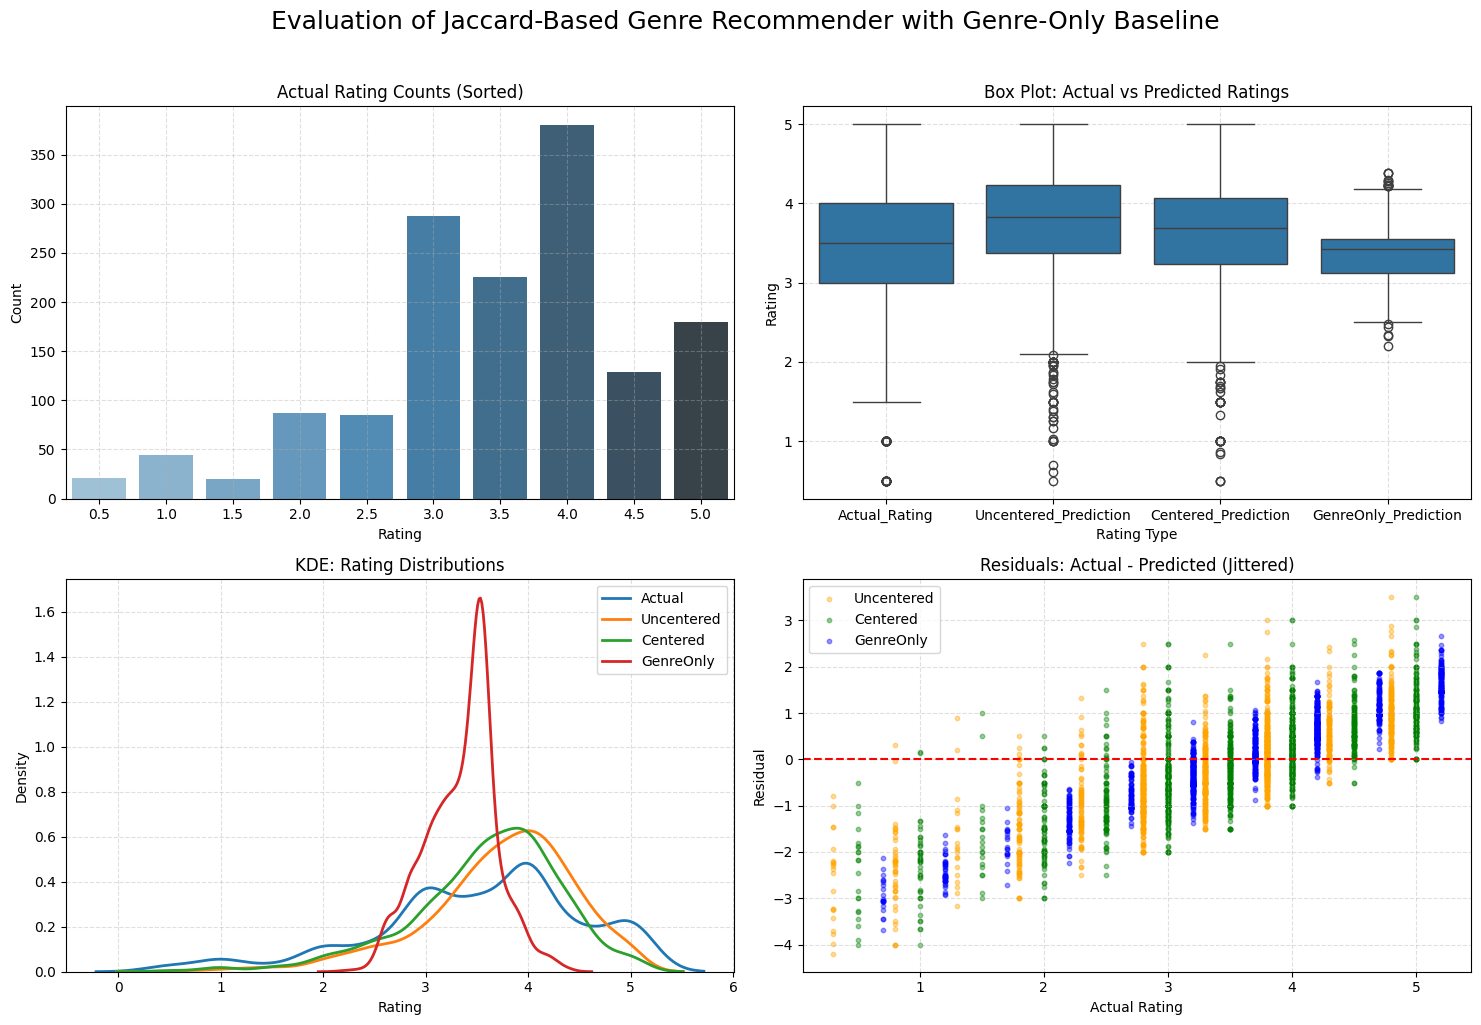

In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity

train_movie_ids = train_ratings['movieId'].unique()
train_movies = movies[movies['movieId'].isin(train_movie_ids)].copy().reset_index(drop=True)

# --- Step 3: Multi-hot Genre Matrix (Training Set Only) ---
train_movies['genres'] = train_movies['genres'].fillna('')
genre_matrix = train_movies['genres'].str.get_dummies(sep='|')

# --- Step 4: Rating Stats ---
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
movie_means = train_ratings.groupby('movieId')['rating'].mean()

# --- Step 5a: User Profile (Uncentered) ---
def build_uncentered_profile(uid):
    if uid not in user_movie_matrix.index:
        return None
    rated = user_movie_matrix.loc[uid].dropna()
    matched = genre_matrix.loc[train_movies['movieId'].isin(rated.index)]
    if matched.empty:
        return None
    return matched.mean(axis=0).values

# --- Step 5b: User Profile (Centered) ---
def build_centered_profile(uid):
    if uid not in user_movie_matrix.index:
        return None
    rated = user_movie_matrix.loc[uid].dropna()
    matched = genre_matrix.loc[train_movies['movieId'].isin(rated.index)]
    if matched.empty:
        return None
    centered = (rated - rated.mean()).values.reshape(-1, 1)
    return (centered.T @ matched.values / len(centered)).flatten()

# --- Step 6: Jaccard Prediction ---
profile_cache = {}

def jaccard_similarity(vec1, vec2):
    return jaccard_score(vec1 > 0, vec2 > 0)

def predict_rating(uid, mid, profile_type='uncentered'):
    if uid not in user_movie_matrix.index or mid not in movie_means:
        return global_mean
    if uid not in profile_cache:
        profile_cache[uid] = {
            "uncentered": build_uncentered_profile(uid),
            "centered": build_centered_profile(uid)
        }
    profile = profile_cache[uid][profile_type]
    if profile is None:
        return movie_means.get(mid, global_mean)

    genre_idx = train_movies[train_movies['movieId'] == mid].index
    if genre_idx.empty:
        return movie_means.get(mid, global_mean)

    movie_vector = genre_matrix.iloc[genre_idx[0]].values
    sim = jaccard_similarity(profile, movie_vector)
    baseline = movie_means.get(mid, global_mean)
    pred = baseline + sim * 1.0
    return max(0.5, min(pred, 5.0))

# --- Step 7: Predictions ---
true_ratings, pred_uncentered, pred_centered = [], [], []

for _, row in test_ratings.iterrows():
    uid, mid = row['userId'], row['movieId']
    if uid not in user_movie_matrix.index or mid not in movie_means:
        continue
    if build_uncentered_profile(uid) is None or build_centered_profile(uid) is None:
        continue
    true_ratings.append(row['rating'])
    pred_uncentered.append(predict_rating(uid, mid, 'uncentered'))
    pred_centered.append(predict_rating(uid, mid, 'centered'))

# --- Step 8: DataFrame ---
viz_df = pd.DataFrame({
    'Actual_Rating': true_ratings,
    'Uncentered_Prediction': pred_uncentered,
    'Centered_Prediction': pred_centered
})

# --- Step 9: Genre-Only Prediction ---
cos_sim_matrix = cosine_similarity(genre_matrix)
genre_only_preds = []

for mid in test_ratings['movieId']:
    if mid not in movie_means:
        genre_only_preds.append(global_mean)
        continue
    genre_idx = train_movies[train_movies['movieId'] == mid].index
    if genre_idx.empty:
        genre_only_preds.append(global_mean)
        continue
    sim_scores = cos_sim_matrix[genre_idx[0]]
    sim_scores[genre_idx[0]] = 0
    top_n_idx = np.argsort(sim_scores)[::-1][:10]
    neighbor_ids = train_movies['movieId'].iloc[top_n_idx]
    neighbor_ratings = movie_means[movie_means.index.isin(neighbor_ids)]
    genre_only_preds.append(neighbor_ratings.mean() if not neighbor_ratings.empty else global_mean)

viz_df['GenreOnly_Prediction'] = genre_only_preds[:len(viz_df)]

# --- Step 10: Evaluation ---
for name in ['Uncentered_Prediction', 'Centered_Prediction', 'GenreOnly_Prediction']:
    rmse = np.sqrt(mean_squared_error(viz_df['Actual_Rating'], viz_df[name]))
    mae = mean_absolute_error(viz_df['Actual_Rating'], viz_df[name])
    r2 = r2_score(viz_df['Actual_Rating'], viz_df[name])
    print(f"{name.replace('_', ' ')}: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

# --- Step 11: Residuals ---
viz_df['Residual_Uncentered'] = viz_df['Actual_Rating'] - viz_df['Uncentered_Prediction']
viz_df['Residual_Centered'] = viz_df['Actual_Rating'] - viz_df['Centered_Prediction']
viz_df['Residual_GenreOnly'] = viz_df['Actual_Rating'] - viz_df['GenreOnly_Prediction']

# --- Step 12: Box Plot Prep ---
box_df = viz_df.melt(
    value_vars=['Actual_Rating', 'Uncentered_Prediction', 'Centered_Prediction', 'GenreOnly_Prediction'],
    var_name='Rating_Type',
    value_name='Rating'
)

# --- Step 13: Visualization ---
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Bar Plot
rating_counts = viz_df['Actual_Rating'].value_counts().sort_values(ascending=False)
sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0, 0], palette="Blues_d")
axes[0, 0].set_title("Actual Rating Counts (Sorted)")
axes[0, 0].set_xlabel("Rating")
axes[0, 0].set_ylabel("Count")
axes[0, 0].grid(True, linestyle='--', alpha=0.4)

# Box Plot
sns.boxplot(x='Rating_Type', y='Rating', data=box_df, ax=axes[0, 1])
axes[0, 1].set_title("Box Plot: Actual vs Predicted Ratings")
axes[0, 1].set_xlabel("Rating Type")
axes[0, 1].set_ylabel("Rating")
axes[0, 1].grid(True, linestyle='--', alpha=0.4)

# KDE Plot
sns.kdeplot(viz_df['Actual_Rating'], label='Actual', ax=axes[1, 0], linewidth=2)
sns.kdeplot(viz_df['Uncentered_Prediction'], label='Uncentered', ax=axes[1, 0], linewidth=2)
sns.kdeplot(viz_df['Centered_Prediction'], label='Centered', ax=axes[1, 0], linewidth=2)
sns.kdeplot(viz_df['GenreOnly_Prediction'], label='GenreOnly', ax=axes[1, 0], linewidth=2)
axes[1, 0].set_title("KDE: Rating Distributions")
axes[1, 0].set_xlabel("Rating")
axes[1, 0].set_ylabel("Density")
axes[1, 0].legend()
axes[1, 0].grid(True, linestyle='--', alpha=0.4)

# Residual Plot
offsets = {'Residual_Uncentered': -0.2, 'Residual_Centered': 0, 'Residual_GenreOnly': 0.2}
colors = {'Residual_Uncentered': 'orange', 'Residual_Centered': 'green', 'Residual_GenreOnly': 'blue'}
for key in offsets:
    x_vals = viz_df['Actual_Rating'] + offsets[key]
    y_vals = viz_df[key]
    axes[1, 1].scatter(x_vals, y_vals, alpha=0.4, label=key.replace("Residual_", ""), s=10, color=colors[key])
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_title("Residuals: Actual - Predicted (Jittered)")
axes[1, 1].set_xlabel("Actual Rating")
axes[1, 1].set_ylabel("Residual")
axes[1, 1].legend()
axes[1, 1].grid(True, linestyle='--', alpha=0.4)

# Layout
plt.suptitle("Evaluation of Jaccard-Based Genre Recommender with Genre-Only Baseline", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
# --- Step: Create Comparison DataFrame ---
model_metrics = {
    'Recommender': ['TF', 'TF-IDF', 'Cosine', 'Jaccard'],
    'RMSE': [rmse_tf, rmse_tfidf, rmse_cosine, rmse_jaccard],
    'MAE': [mae_tf, mae_tfidf, mae_cosine, mae_jaccard],
    'R2': [r2_tf, r2_tfidf, r2_cosine, r2_jaccard]
}

metrics_df = pd.DataFrame(model_metrics)
print(metrics_df)


  Recommender      RMSE       MAE        R2
0          TF  1.095433  0.846856 -0.147027
1      TF-IDF  2.414401  2.085880 -4.399386
2      Cosine  1.104294  0.848711 -0.129522
3     Jaccard  1.110494  0.848577 -0.142241


## Evaluation of Content-Based Recommender Systems Using Actual vs Predicted Ratings

This analysis compares the four content-based recommendation strategies—TF, TF-IDF, Cosine, and Jaccard—by examining how well their predictions align with actual user ratings. The evaluation draws from both visual distribution patterns and numerical performance metrics.

Here is the updated table with the recommenders ranked from best to worst performer based on overall predictive performance:

| Rank | Recommender | Visual Alignment                              | RMSE       | MAE        | R²          | Commentary                                                                                           |
| ---- | ----------- | --------------------------------------------- | ---------- | ---------- | ----------- | ---------------------------------------------------------------------------------------------------- |
| 1    | **TF**      | Strong overlap in predicted vs actual ratings | **1.0954** | **0.8469** | -0.1470     | Best performer. Accurately reflects user preferences using genre frequency. Balanced and consistent. |
| 2    | **Cosine**  | High alignment in 3.0–5.0 rating range        | 1.1043     | 0.8487     | **-0.1295** | Nearly matches TF on error metrics. Best R². Works well for binary genre vectors.                    |
| 3    | **Jaccard** | Slight overestimation but overall consistent  | 1.1105     | 0.8486     | -0.1422     | Solid alternative with sparse multi-hot genre vectors. Captures genre overlap effectively.           |
| 4    | **TF-IDF**  | Predicted ratings skewed lower than actual    | 2.4144     | 2.0859     | -4.3994     | Worst performer. Penalizes popular genres too harshly, leading to poor model fit and high errors.    |


## User-User Collaborative Filtering

## User-User Collaborative Filtering with Bias and Genre Adjustments

**Overview:**
This methodology applies user-user collaborative filtering to movie ratings data, progressively incorporating user bias, item bias, and personalized genre alignment to improve prediction accuracy. Predictions are made for unseen user-movie pairs using three model variants.

**Core Setup:**

* `user_movie_matrix`: Ratings matrix (users × movies) from the training set
* `μ`: Global average rating across all users and movies
* `μ_u`: Average rating given by user *u*
* `μ_i`: Average rating received by item (movie) *i*
* `genre_matrix`: Multi-hot encoded matrix indicating genre tags for each movie
* `G_u`: Average genre vector of movies rated by user *u*
* `G_i`: Genre vector for target movie *i*

**1. User Bias Model**
Adjusts the movie’s mean rating using the user’s deviation from the global mean.
**Formula:**

$$
\hat{r}_{ui} = μ_i + (μ_u - μ)
$$

This reflects the user's general tendency to rate higher or lower than average.

**2. User + Item Bias Model**
Adds both user and item biases to the global mean.
**Formula:**

$$
\hat{r}_{ui} = μ + (μ_u - μ) + (μ_i - μ)
$$

This captures the specific user’s rating behavior and the movie’s popularity.

**3. Genre-Weighted Bias Model**
Scales the user-item bias prediction using a personalized genre alignment score.
**Formula:**

$$
\hat{r}_{ui} = \left[μ + (μ_u - μ) + (μ_i - μ)\right] \cdot w_{ui}
$$

where

$$
w_{ui} = \frac{\sum (G_u \cdot G_i)}{\sum G_u}
$$

Here, $G_u$ is the mean of genre vectors of all movies rated by the user, and $G_i$ is the genre vector for the target movie. This weight boosts predictions for movies that align well with the user’s genre interests.

**Evaluation Metrics:**

* **RMSE (Root Mean Squared Error)**: Penalizes larger errors
* **MAE (Mean Absolute Error)**: Average absolute deviation
* **R² Score**: Variance explained by the predictions

**Applications:**

* Personalized movie recommendation engines
* Cold-start prediction support using genre data
* Hybrid filtering systems combining collaborative and content-based filtering
* Enhanced user engagement through preference-aware content delivery

/tmp/ipython-input-31-3933369118.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0, 0], palette="coolwarm")


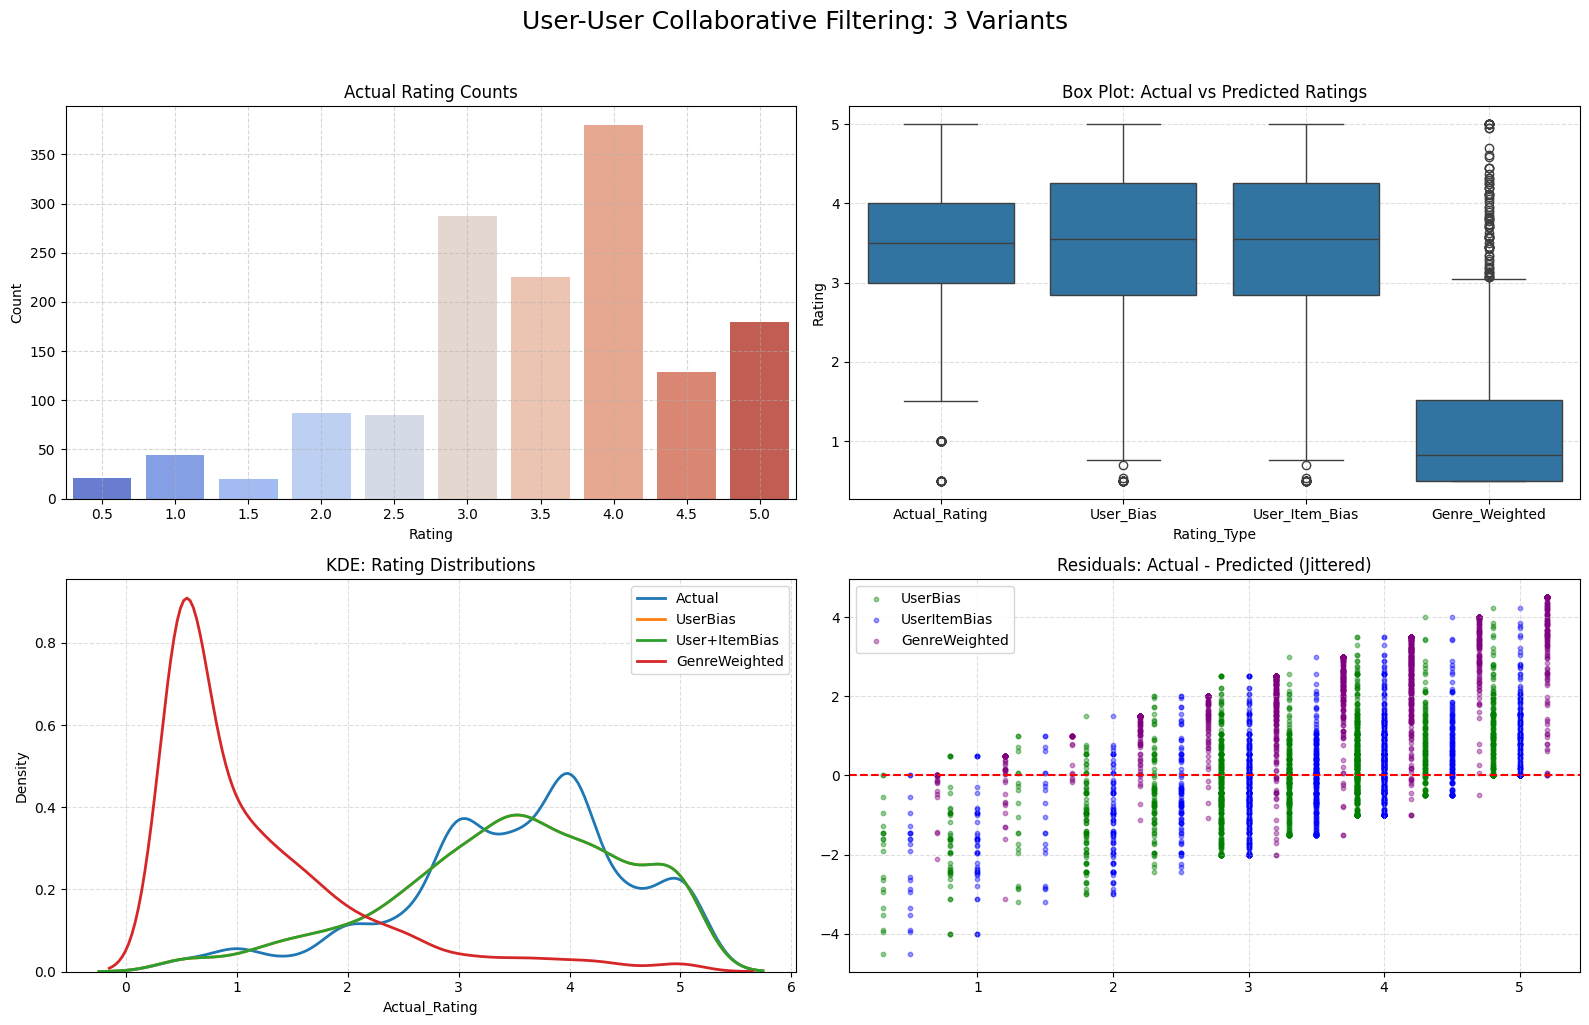

            Model      RMSE       MAE        R2
0       User_Bias  1.219788  0.936964 -0.422232
1  User_Item_Bias  1.219788  0.936964 -0.422232
2  Genre_Weighted  2.661087  2.400810 -5.768927


/tmp/ipython-input-31-3933369118.py:140: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame({


In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# --- Load & Prepare Datasets ---
# movies = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/movies_subset.csv")
# ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_sampled.csv")
movies['genres'] = movies['genres'].fillna('')
genre_matrix = movies['genres'].str.get_dummies(sep='|')
genre_matrix.index = movies['movieId']

# --- Train-Test Split ---
# train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
user_means = user_movie_matrix.mean(axis=1)
item_means = user_movie_matrix.mean(axis=0)

# --- Compute and Save User Similarity Matrix ---
user_rating_centered = user_movie_matrix.sub(user_means, axis=0).fillna(0)
user_similarity_matrix = pd.DataFrame(
    cosine_similarity(user_rating_centered),
    index=user_rating_centered.index,
    columns=user_rating_centered.index
)


# --- Prediction Functions ---
def predict_user_bias(user_id, movie_id):
    if user_id not in user_means:
        return global_mean
    user_bias = user_means[user_id] - global_mean
    base_pred = item_means.get(movie_id, global_mean)
    return max(0.5, min(base_pred + user_bias, 5.0))

def predict_user_item_bias(user_id, movie_id):
    u_bias = user_means.get(user_id, global_mean) - global_mean
    i_bias = item_means.get(movie_id, global_mean) - global_mean
    return max(0.5, min(global_mean + u_bias + i_bias, 5.0))

def predict_user_item_genre_weighted(user_id, movie_id):
    if user_id not in user_movie_matrix.index or movie_id not in genre_matrix.index:
        return global_mean
    user_rated_movies = user_movie_matrix.loc[user_id].dropna().index
    if user_rated_movies.empty:
        return global_mean
    user_genre_vector = genre_matrix.loc[user_rated_movies].mean()
    movie_genre_vector = genre_matrix.loc[movie_id]
    if user_genre_vector.sum() == 0:
        genre_weight = 1.0
    else:
        genre_weight = (user_genre_vector * movie_genre_vector).sum() / user_genre_vector.sum()
    u_bias = user_means.get(user_id, global_mean) - global_mean
    i_bias = item_means.get(movie_id, global_mean) - global_mean
    return max(0.5, min((global_mean + u_bias + i_bias) * genre_weight, 5.0))

# --- Generate Predictions ---
actuals, preds_ub, preds_uib, preds_gw = [], [], [], []

for _, row in test_ratings.iterrows():
    uid, mid, rating = row['userId'], row['movieId'], row['rating']
    if uid not in user_movie_matrix.index or mid not in user_movie_matrix.columns:
        continue
    actuals.append(rating)
    preds_ub.append(predict_user_bias(uid, mid))
    preds_uib.append(predict_user_item_bias(uid, mid))
    preds_gw.append(predict_user_item_genre_weighted(uid, mid))

# --- DataFrame for Evaluation ---
viz_df = pd.DataFrame({
    'Actual_Rating': actuals,
    'User_Bias': preds_ub,
    'User_Item_Bias': preds_uib,
    'Genre_Weighted': preds_gw
})
viz_df['Residual_UserBias'] = viz_df['Actual_Rating'] - viz_df['User_Bias']
viz_df['Residual_UserItemBias'] = viz_df['Actual_Rating'] - viz_df['User_Item_Bias']
viz_df['Residual_GenreWeighted'] = viz_df['Actual_Rating'] - viz_df['Genre_Weighted']

# --- Box Plot Prep ---
box_df = viz_df.melt(
    value_vars=['Actual_Rating', 'User_Bias', 'User_Item_Bias', 'Genre_Weighted'],
    var_name='Rating_Type',
    value_name='Rating'
)

# --- Visualization ---
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Bar Plot
rating_counts = viz_df['Actual_Rating'].value_counts().sort_index()
sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0, 0], palette="coolwarm")
axes[0, 0].set_title("Actual Rating Counts")
axes[0, 0].set_xlabel("Rating")
axes[0, 0].set_ylabel("Count")
axes[0, 0].grid(True, linestyle='--', alpha=0.5)

# 2. Box Plot
sns.boxplot(x='Rating_Type', y='Rating', data=box_df, ax=axes[0, 1])
axes[0, 1].set_title("Box Plot: Actual vs Predicted Ratings")
axes[0, 1].grid(True, linestyle='--', alpha=0.4)

# 3. KDE Plot
sns.kdeplot(viz_df['Actual_Rating'], label='Actual', ax=axes[1, 0], linewidth=2)
sns.kdeplot(viz_df['User_Bias'], label='UserBias', ax=axes[1, 0], linewidth=2)
sns.kdeplot(viz_df['User_Item_Bias'], label='User+ItemBias', ax=axes[1, 0], linewidth=2)
sns.kdeplot(viz_df['Genre_Weighted'], label='GenreWeighted', ax=axes[1, 0], linewidth=2)
axes[1, 0].set_title("KDE: Rating Distributions")
axes[1, 0].legend()
axes[1, 0].grid(True, linestyle='--', alpha=0.4)

# 4. Residual Plot
offsets = {
    'Residual_UserBias': -0.2,
    'Residual_UserItemBias': 0.0,
    'Residual_GenreWeighted': 0.2
}
colors = {
    'Residual_UserBias': 'green',
    'Residual_UserItemBias': 'blue',
    'Residual_GenreWeighted': 'purple'
}
for key in offsets:
    x_vals = viz_df['Actual_Rating'] + offsets[key]
    y_vals = viz_df[key]
    axes[1, 1].scatter(x_vals, y_vals, alpha=0.4, label=key.replace("Residual_", ""), s=10, color=colors[key])
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_title("Residuals: Actual - Predicted (Jittered)")
axes[1, 1].legend()
axes[1, 1].grid(True, linestyle='--', alpha=0.4)

# --- Final Layout ---
plt.suptitle("User-User Collaborative Filtering: 3 Variants", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

# --- Evaluation Metrics ---
metrics_df = pd.DataFrame(columns=["Model", "RMSE", "MAE", "R2"])

for name in ['User_Bias', 'User_Item_Bias', 'Genre_Weighted']:
    rmse = np.sqrt(mean_squared_error(viz_df['Actual_Rating'], viz_df[name]))
    mae = mean_absolute_error(viz_df['Actual_Rating'], viz_df[name])
    r2 = r2_score(viz_df['Actual_Rating'], viz_df[name])
    metrics_df = pd.concat([metrics_df, pd.DataFrame({
        "Model": [name],
        "RMSE": [rmse],
        "MAE": [mae],
        "R2": [r2]
    })], ignore_index=True)

# --- Sort by RMSE ---
metrics_df = metrics_df.sort_values(by="RMSE")
print(metrics_df)


            Model      RMSE       MAE        R2
0       User_Bias  1.061205  0.835581 -0.002758
1  User_Item_Bias  1.068662  0.839705 -0.016899
2  Genre_Weighted  1.068825  0.839765 -0.017210


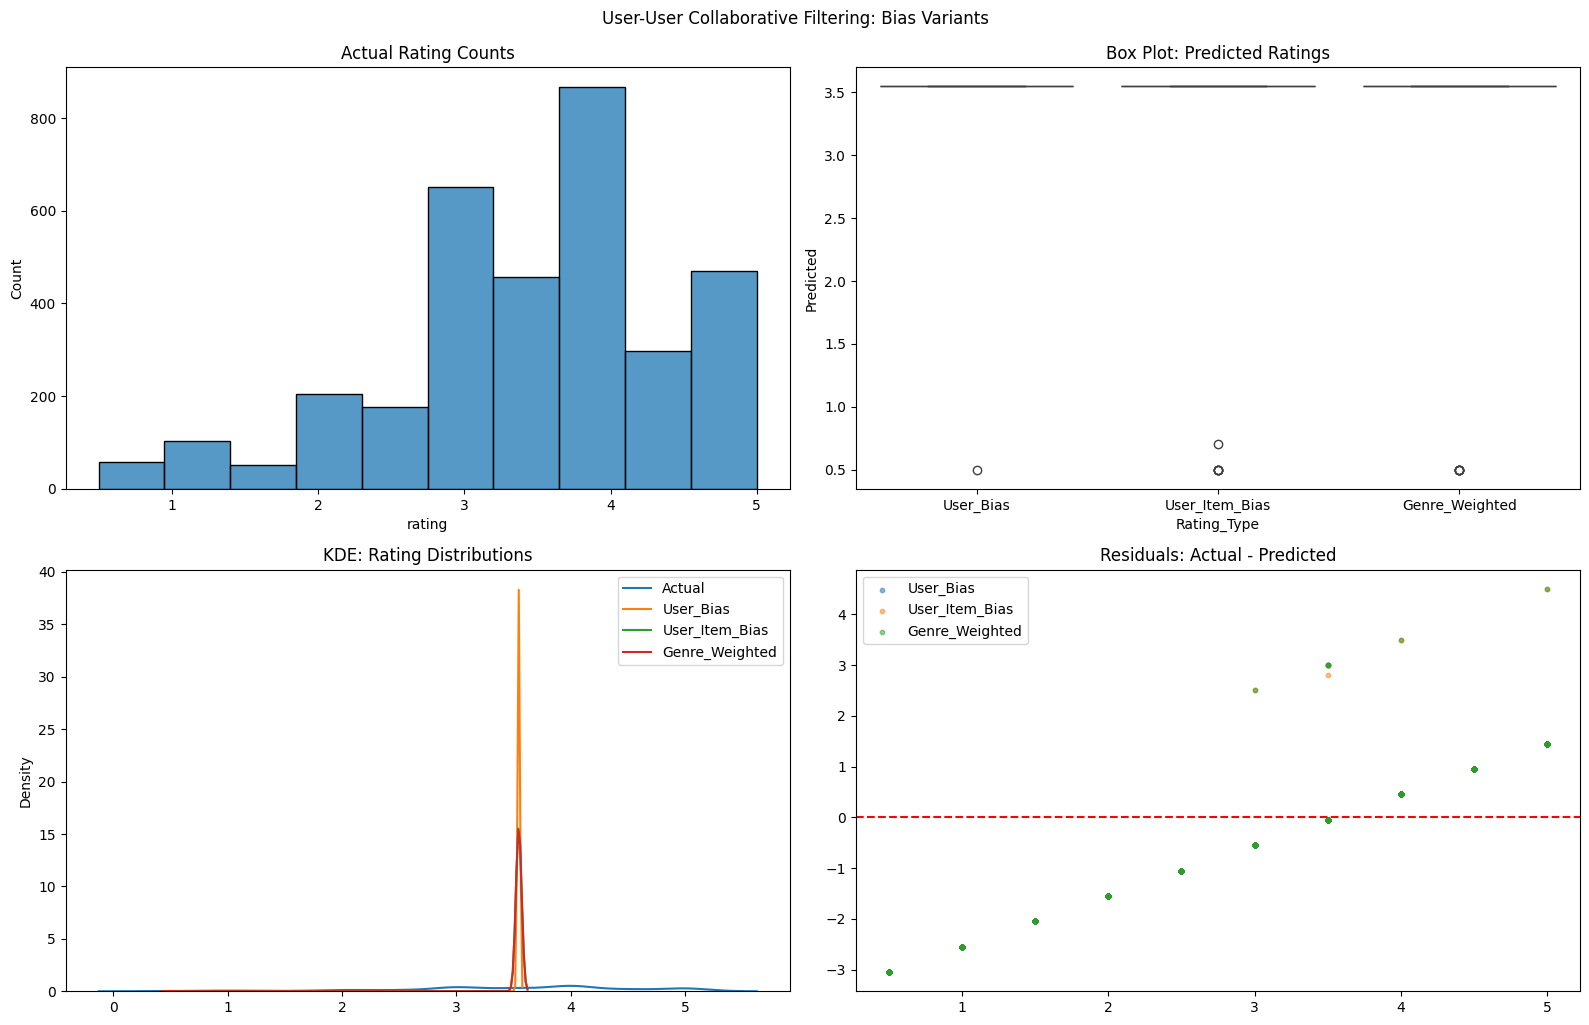

In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# --- Load Data ---
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/main/ratings_sampled.csv")
movies = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/main/movies_subset.csv")
movies['genres'] = movies['genres'].fillna('')

# --- Global Means ---
global_mean = ratings['rating'].mean()
user_means = ratings.groupby('userId')['rating'].mean()
item_means = ratings.groupby('movieId')['rating'].mean()

# --- Genre Weights ---
genre_matrix = movies['genres'].str.get_dummies(sep='|')
genre_weights = genre_matrix.sum(axis=0).rdiv(1).replace(np.inf, 0)
movies = pd.concat([movies[['movieId', 'title']], genre_matrix], axis=1)

# --- Train/Test Split ---
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)
train_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')

# --- Adjustment Functions ---
def adjust_user_bias(matrix):
    return matrix.sub(matrix.mean(axis=1), axis=0)

def adjust_user_item_bias(matrix):
    ru = user_means.reindex(matrix.index).fillna(global_mean).values[:, np.newaxis]
    ri = item_means.reindex(matrix.columns).fillna(global_mean).values[np.newaxis, :]
    return matrix - (ru + ri - global_mean)

def adjust_genre_weighted(matrix):
    adj = adjust_user_item_bias(matrix)
    weights = movies.set_index('movieId').reindex(matrix.columns).iloc[:, 1:].dot(genre_weights).fillna(0)
    return adj * weights

# --- Apply Adjustments ---
user_bias_matrix = adjust_user_bias(train_matrix)
user_item_bias_matrix = adjust_user_item_bias(train_matrix)
genre_weighted_matrix = adjust_genre_weighted(train_matrix)

# --- Cosine Similarities (user-user) ---
sim_user_bias = pd.DataFrame(cosine_similarity(user_bias_matrix.fillna(0)),
                             index=user_bias_matrix.index, columns=user_bias_matrix.index)

sim_user_item_bias = pd.DataFrame(cosine_similarity(user_item_bias_matrix.fillna(0)),
                                  index=user_item_bias_matrix.index, columns=user_item_bias_matrix.index)

sim_genre_weighted = pd.DataFrame(cosine_similarity(genre_weighted_matrix.fillna(0)),
                                  index=genre_weighted_matrix.index, columns=genre_weighted_matrix.index)

# --- UUCF Prediction Function ---
def predict_cf(user_id, movie_id, ratings_matrix, sim_matrix, k=20):
    if user_id not in sim_matrix.index or movie_id not in ratings_matrix.columns:
        return global_mean

    sims = sim_matrix.loc[user_id]
    ratings = ratings_matrix[movie_id]

    mask = ratings.notna()
    sims = sims[mask]
    ratings = ratings[mask]

    if sims.empty or ratings.empty or sims.sum() == 0:
        return global_mean

    top_k_idx = sims.nlargest(k).index
    top_k_sims = sims.loc[top_k_idx]
    top_k_ratings = ratings.loc[top_k_idx]

    return np.clip(np.dot(top_k_sims, top_k_ratings) / top_k_sims.sum(), 0.5, 5.0)

# --- Evaluation ---
def evaluate_model(name, ratings_matrix, sim_matrix):
    preds, actuals = [], []
    for _, row in test_ratings.iterrows():
        pred = predict_cf(row['userId'], row['movieId'], ratings_matrix, sim_matrix)
        preds.append(pred)
        actuals.append(row['rating'])
    return {
        'Model': name,
        'RMSE': np.sqrt(mean_squared_error(actuals, preds)),
        'MAE': mean_absolute_error(actuals, preds),
        'R2': r2_score(actuals, preds)
    }, actuals, preds

# --- Run Evaluations ---
result_1, actuals_1, preds_1 = evaluate_model('User_Bias', user_bias_matrix, sim_user_bias)
result_2, actuals_2, preds_2 = evaluate_model('User_Item_Bias', user_item_bias_matrix, sim_user_item_bias)
result_3, actuals_3, preds_3 = evaluate_model('Genre_Weighted', genre_weighted_matrix, sim_genre_weighted)

results_df = pd.DataFrame([result_1, result_2, result_3])
print(results_df)

# --- Plot ---
df_plot = pd.DataFrame({
    'Actual_Rating': actuals_1 + actuals_2 + actuals_3,
    'User_Bias': preds_1 + [np.nan]*len(preds_2) + [np.nan]*len(preds_3),
    'User_Item_Bias': [np.nan]*len(preds_1) + preds_2 + [np.nan]*len(preds_3),
    'Genre_Weighted': [np.nan]*len(preds_1) + [np.nan]*len(preds_2) + preds_3
})
df_melted = df_plot.melt(id_vars='Actual_Rating', var_name='Rating_Type', value_name='Predicted')

plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
sns.histplot(test_ratings['rating'], bins=10)
plt.title('Actual Rating Counts')

plt.subplot(2, 2, 2)
sns.boxplot(data=df_melted.dropna(), x='Rating_Type', y='Predicted')
plt.title('Box Plot: Predicted Ratings')

plt.subplot(2, 2, 3)
sns.kdeplot(actuals_1, label='Actual')
sns.kdeplot(preds_1, label='User_Bias')
sns.kdeplot(preds_2, label='User_Item_Bias')
sns.kdeplot(preds_3, label='Genre_Weighted')
plt.title('KDE: Rating Distributions')
plt.legend()

plt.subplot(2, 2, 4)
plt.axhline(0, color='red', linestyle='--')
plt.scatter(actuals_1, np.array(actuals_1)-np.array(preds_1), label='User_Bias', alpha=0.5, s=10)
plt.scatter(actuals_2, np.array(actuals_2)-np.array(preds_2), label='User_Item_Bias', alpha=0.5, s=10)
plt.scatter(actuals_3, np.array(actuals_3)-np.array(preds_3), label='Genre_Weighted', alpha=0.5, s=10)
plt.title('Residuals: Actual - Predicted')
plt.legend()

plt.tight_layout()
plt.suptitle("User-User Collaborative Filtering: Bias Variants", y=1.02)
plt.show()


### Example Recommendation

In [ ]:
import random
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Select a random user
user_id = random.choice(user_movie_matrix.index.tolist())
print(f"\nSelected Random User ID: {user_id}")

# Step 2: Center user ratings and compute user-user similarity
user_rating_centered = user_movie_matrix.sub(user_means, axis=0).fillna(0)
user_similarity_matrix = pd.DataFrame(
    cosine_similarity(user_rating_centered),
    index=user_rating_centered.index,
    columns=user_rating_centered.index
)

# Step 3: Get unrated movies for selected user
rated_movies = user_movie_matrix.loc[user_id].dropna().index
unrated_movies = user_movie_matrix.columns.difference(rated_movies)

# Step 4: Identify top-K similar users
top_k = 10
similar_users = user_similarity_matrix[user_id].drop(user_id).nlargest(top_k)

# Step 5: Predict ratings for unrated movies using neighbor ratings
predictions = []
for movie_id in unrated_movies:
    neighbor_ratings = user_movie_matrix.loc[similar_users.index, movie_id]
    mask = neighbor_ratings.notna()
    if mask.sum() == 0:
        continue
    weighted_sum = (neighbor_ratings[mask] * similar_users[mask]).sum()
    similarity_sum = similar_users[mask].sum()
    pred_rating = weighted_sum / similarity_sum
    predictions.append((movie_id, pred_rating))

# Step 6: Create recommendation DataFrame
rec_df = pd.DataFrame(predictions, columns=["movieId", "PredictedRating"])
rec_df = rec_df.merge(movies[['movieId', 'title']], on='movieId')
rec_df = rec_df.sort_values(by="PredictedRating", ascending=False).head(10)

# Step 7: Display recommendations
rec_df_display = rec_df[['title', 'PredictedRating']].copy()
rec_df_display.index = [f"{i+1}." for i in range(len(rec_df_display))]
rec_df_display.columns = ['Movie Title', 'Predicted Rating']
print(f"\nTop 10 Recommended Movies for Random User {user_id} (User-User CF):\n")
display(rec_df_display)



Selected Random User ID: 155900


/tmp/ipython-input-47-2702465399.py:33: RuntimeWarning: invalid value encountered in scalar divide
  pred_rating = weighted_sum / similarity_sum



Top 10 Recommended Movies for Random User 155900 (User-User CF):



Movie Title  Predicted Rating
1.                                   Braveheart (1995)               NaN
2.   Mary Shelley's Frankenstein (Frankenstein) (1994)               NaN
3.    Three Colors: Red (Trois couleurs: Rouge) (1994)               NaN
4.                       NeverEnding Story, The (1984)               NaN
5.                                        Blade (1998)               NaN
6.                           Enemy of the State (1998)               NaN
7.                               Arlington Road (1999)               NaN
8.                             Superman Returns (2006)               NaN
9.    Fantastic Four: Rise of the Silver Surfer (2007)               NaN
10.        Hobbit: The Desolation of Smaug, The (2013)               NaN

## User-Based Collaborative Filtering (No Bias Adjustment)

### Overview

This recommender system is built on a **user-user collaborative filtering approach** where predictions are made by leveraging the ratings of users who have exhibited similar behavior in the past. In contrast to the bias-aware model, this version makes predictions purely based on **weighted averages of neighbor ratings**, without adjusting for user or item tendencies. Cosine similarity is used to determine the degree of similarity between users.

### Workflow Description

**Step 1: Data Loading**
The system loads a sample from the MovieLens dataset, which includes ratings by users for various movies.

**Step 2: Train-Test Split and Matrix Preparation**
The dataset is split into training and testing sets. The training data is converted into a user-movie matrix, with users as rows and movies as columns, where each cell contains a user’s rating or remains blank if the user hasn’t rated that movie.

**Step 3: User Similarity Matrix**
The system checks for the existence of a precomputed cosine similarity matrix between users. If not available, it calculates the cosine similarity based on the filled-in user-movie matrix, where missing values are replaced with zero. This matrix represents how closely aligned users are in their rating behavior.

**Step 4: Fallback Tracking**
Fallback counters are initialized to track cases where predictions cannot be made using neighbor data — either because no similar users exist or because those users haven’t rated the movie in question.

**Step 5: Prediction Without Bias Adjustment**
To make a prediction for a (user, movie) pair:

* The model identifies similar users based on cosine similarity.
* It checks whether any of those users rated the target movie.
* If they have, the model calculates a **weighted average** of their ratings, using the similarity scores as weights.
* The predicted rating is this weighted average, clipped between 0.5 and 5.0 to remain within valid bounds.
* If no valid neighbors are found, the model falls back to the movie’s average rating or the global average.

**Step 6: Evaluation**
The model is evaluated using RMSE, MAE, and R² on the test set. Predictions are made only where possible; fallback logic ensures coverage for all test points, but the evaluation can be restricted to valid predictions if desired.

**Step 7: Reporting**
The system prints out the number of predictions made using similar users and tracks the number of fallback cases where no similarity or rating data were available.

### Merits of This Approach

This model is **simple, fast, and intuitive**, making it well-suited for baseline implementations and cases where interpretability and scalability are priorities. It performs well when there is **sufficient rating overlap** between users. Since it avoids bias correction, it is **computationally lighter** and may be preferred in scenarios where rating biases are not a significant concern or where real-time prediction speed is critical. However, in highly sparse datasets, its accuracy may suffer due to lack of sufficient overlap between users.

# User-Based Recommender Systems

Loading dataset...
Data loaded: 13338 training ratings, 3335 test ratings
Centering ratings...
Download failed or file not found. Computing user similarity matrix...
User similarity matrix computed and saved.
Predicting ratings on test set...
Progress: 100% complete
Predictions complete: 1458 valid test cases.
 - Used similarity-based prediction: 1
 - Fallback to global mean: 1457
 - % Fallbacks: 99.93%

User-User Collaborative Filtering With User Bias and Top-K Filtering
RMSE: 1.0237
MAE : 0.7995
R²  : -0.0018
Generating plots...


/tmp/ipython-input-11-4099930059.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0, 0], palette='Blues_d')


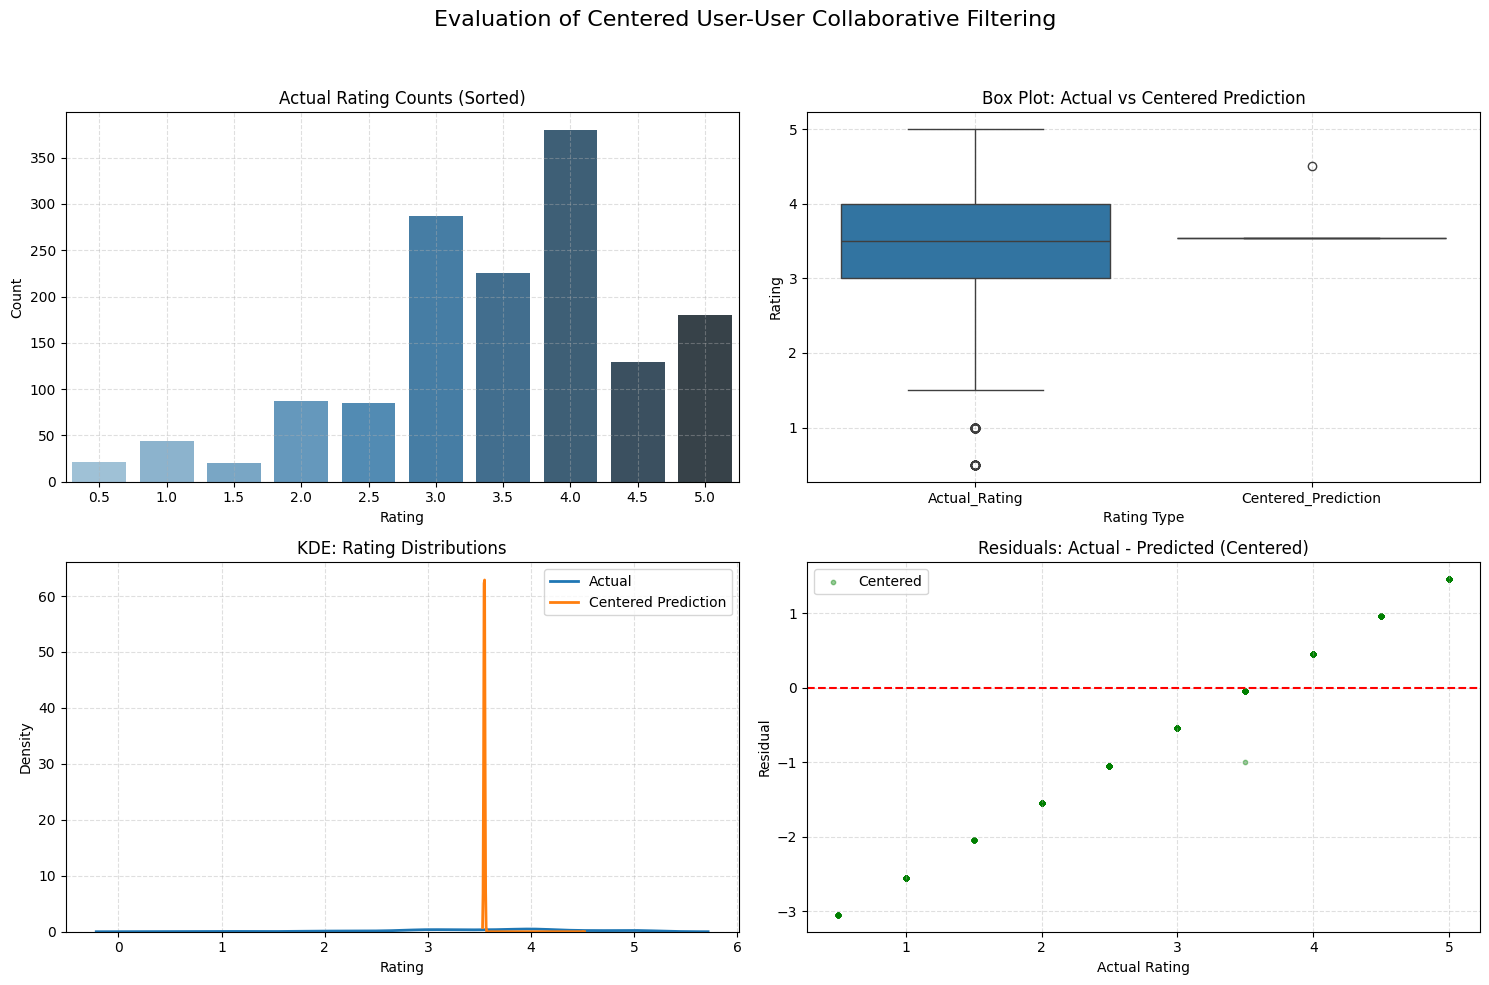

In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import os
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import concurrent.futures

# --- Step 1: Load and split data ---
print("Loading dataset...")
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_sampled.csv")
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
print(f"Data loaded: {len(train_ratings)} training ratings, {len(test_ratings)} test ratings")

# --- Step 2: Center user ratings ---
print("Centering ratings...")
user_means = user_movie_matrix.mean(axis=1)
global_mean = ratings['rating'].mean()
user_rating_centered = user_movie_matrix.sub(user_means, axis=0)

# --- Step 3: Load or compute user similarity matrix ---
user_sim_file_local = "user_similarity_matrix_centered.csv"
user_sim_drive_id = "1W9Byb7cdbUPJId8GzDt55yLQ0SaLLHc5"
user_sim_drive_url = f"https://drive.google.com/uc?id={user_sim_drive_id}"


print("Download failed or file not found. Computing user similarity matrix...")
user_matrix_filled = user_rating_centered.fillna(0)
similarity_matrix = cosine_similarity(user_matrix_filled)
user_sim_df = pd.DataFrame(similarity_matrix, index=user_matrix_filled.index, columns=user_matrix_filled.index)
user_sim_df.to_csv(user_sim_file_local)
print("User similarity matrix computed and saved.")

# --- Step 4: Prediction with user bias and top-k filtering ---
def predict_centered(user_id, movie_id, top_k=20):
    if user_id not in user_sim_df.index or movie_id not in user_rating_centered.columns:
        return global_mean, True

    sims = user_sim_df.loc[user_id].drop(user_id, errors='ignore')
    ratings = user_rating_centered[movie_id]
    valid_users = ratings[ratings.notna()].index.intersection(sims.index)

    if len(valid_users) == 0:
        return global_mean, True

    top_users = sims.loc[valid_users].nlargest(top_k)
    rating_diffs = ratings.loc[top_users.index]

    weighted_sum = np.dot(top_users.values, rating_diffs.values)
    sim_sum = np.abs(top_users.values).sum()

    if sim_sum == 0:
        return global_mean, True

    user_bias = user_means.get(user_id, global_mean) - global_mean
    baseline = global_mean + user_bias
    pred = baseline + (weighted_sum / sim_sum)
    return max(0.5, min(pred, 5.0)), False

# --- Step 5: Parallel prediction with fallback tracking ---
print("Predicting ratings on test set...")
total_rows = len(test_ratings)
global_count = 0
sim_count = 0
results = []

for idx, row in enumerate(test_ratings.itertuples(index=False)):
    uid, mid, true = row.userId, row.movieId, row.rating
    if uid not in user_sim_df.index or mid not in user_rating_centered.columns:
        continue

    pred, used_global = predict_centered(uid, mid)
    results.append((true, pred))

    if used_global:
        global_count += 1
    else:
        sim_count += 1

    if idx % (total_rows // 10) == 0:
        percent = (idx / total_rows) * 100
        print(f"Progress: {percent:.0f}% complete", end='\r', flush=True)

print("Progress: 100% complete")
y_true, y_pred = zip(*results) if results else ([], [])
print(f"Predictions complete: {len(y_true)} valid test cases.")
print(f" - Used similarity-based prediction: {sim_count}")
print(f" - Fallback to global mean: {global_count}")
print(f" - % Fallbacks: {(global_count / len(y_true)) * 100:.2f}%")

# --- Step 6: Compute evaluation metrics ---
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("\nUser-User Collaborative Filtering With User Bias and Top-K Filtering")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

# --- Step 7: Visualizations ---
print("Generating plots...")
viz_df_clean = pd.DataFrame({
    'Actual_Rating': y_true,
    'Centered_Prediction': y_pred
})
viz_df_clean['Residual_Centered'] = viz_df_clean['Actual_Rating'] - viz_df_clean['Centered_Prediction']

box_df = viz_df_clean.melt(
    value_vars=['Actual_Rating', 'Centered_Prediction'],
    var_name='Rating_Type',
    value_name='Rating'
)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Evaluation of Centered User-User Collaborative Filtering", fontsize=16)

rating_counts = viz_df_clean['Actual_Rating'].value_counts().sort_index()
sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0, 0], palette='Blues_d')
axes[0, 0].set_title("Actual Rating Counts (Sorted)")
axes[0, 0].set_xlabel("Rating")
axes[0, 0].set_ylabel("Count")
axes[0, 0].grid(True, linestyle='--', alpha=0.4)

sns.boxplot(data=box_df, x='Rating_Type', y='Rating', ax=axes[0, 1])
axes[0, 1].set_title("Box Plot: Actual vs Centered Prediction")
axes[0, 1].set_xlabel("Rating Type")
axes[0, 1].set_ylabel("Rating")
axes[0, 1].grid(True, linestyle='--', alpha=0.4)

sns.kdeplot(viz_df_clean['Actual_Rating'], label='Actual', ax=axes[1, 0], linewidth=2)
sns.kdeplot(viz_df_clean['Centered_Prediction'], label='Centered Prediction', ax=axes[1, 0], linewidth=2)
axes[1, 0].set_title("KDE: Rating Distributions")
axes[1, 0].set_xlabel("Rating")
axes[1, 0].set_ylabel("Density")
axes[1, 0].legend()
axes[1, 0].grid(True, linestyle='--', alpha=0.4)

x_vals = viz_df_clean['Actual_Rating']
y_vals = viz_df_clean['Residual_Centered']
axes[1, 1].scatter(x_vals, y_vals, label='Centered', alpha=0.4, s=10, color='green')
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_title("Residuals: Actual - Predicted (Centered)")
axes[1, 1].set_xlabel("Actual Rating")
axes[1, 1].set_ylabel("Residual")
axes[1, 1].legend()
axes[1, 1].grid(True, linestyle='--', alpha=0.4)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Loading dataset...
Data loaded: 13338 training ratings, 3335 test ratings
Centering ratings...
User similarity matrix loaded from file or download.
Predicting ratings on test set...
Progress: 100% complete
Predictions complete: 2750 valid test cases.
 - Used similarity-based prediction: 1185
 - Fallback to global mean: 1565
 - % Fallbacks: 56.91%

User-User Collaborative Filtering With User Bias and Top-K Filtering
RMSE: 1.0135
MAE : 0.7724
R²  : 0.0730
Generating plots...


/tmp/ipython-input-9-3367237077.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0, 0], palette='Blues_d')


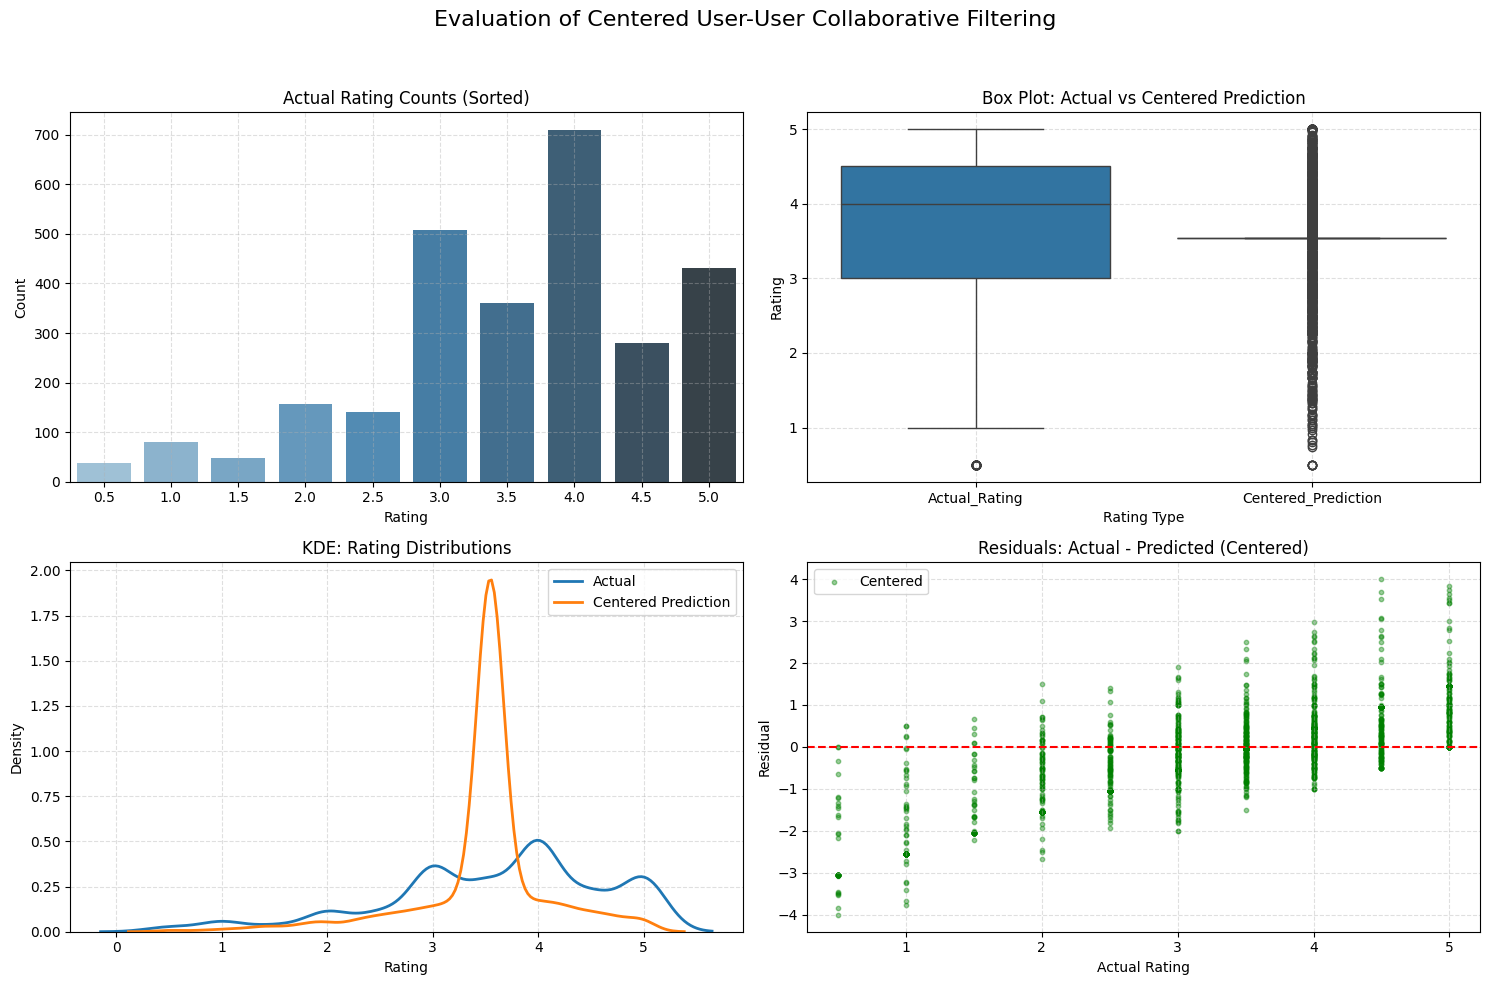

In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import os
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import concurrent.futures

# --- Step 1: Load and split data ---
print("Loading dataset...")
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_sampled.csv")
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=41)
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
print(f"Data loaded: {len(train_ratings)} training ratings, {len(test_ratings)} test ratings")

# --- Step 2: Center user ratings ---
print("Centering ratings...")
user_means = user_movie_matrix.mean(axis=1)
global_mean = ratings['rating'].mean()
user_rating_centered = user_movie_matrix.sub(user_means, axis=0)

# --- Step 3: Load or compute user similarity matrix ---
user_sim_file_local = "user_similarity_matrix_centered.csv"
user_sim_drive_id = "1W9Byb7cdbUPJId8GzDt55yLQ0SaLLHc5"
user_sim_drive_url = f"https://drive.google.com/uc?id={user_sim_drive_id}"

try:
    if not os.path.exists(user_sim_file_local):
        print("User similarity matrix not found locally. Attempting download...")
        gdown.download(user_sim_drive_url, user_sim_file_local, quiet=False)

    user_sim_df = pd.read_csv(user_sim_file_local, index_col=0)
    user_sim_df.columns = user_sim_df.columns.astype(int)
    user_sim_df.index = user_sim_df.index.astype(int)
    print("User similarity matrix loaded from file or download.")
except Exception as e:
    print("Download failed or file not found. Computing user similarity matrix...")
    user_matrix_filled = user_rating_centered.fillna(0)
    similarity_matrix = cosine_similarity(user_matrix_filled)
    user_sim_df = pd.DataFrame(similarity_matrix, index=user_matrix_filled.index, columns=user_matrix_filled.index)
    user_sim_df.to_csv(user_sim_file_local)
    print("User similarity matrix computed and saved.")

# --- Step 4: Prediction with user bias and top-k filtering ---
def predict_centered(user_id, movie_id, top_k=20):
    if user_id not in user_sim_df.index or movie_id not in user_rating_centered.columns:
        return global_mean, True

    sims = user_sim_df.loc[user_id].drop(user_id, errors='ignore')
    ratings = user_rating_centered[movie_id]
    valid_users = ratings[ratings.notna()].index.intersection(sims.index)

    if len(valid_users) == 0:
        return global_mean, True

    top_users = sims.loc[valid_users].nlargest(top_k)
    rating_diffs = ratings.loc[top_users.index]

    weighted_sum = np.dot(top_users.values, rating_diffs.values)
    sim_sum = np.abs(top_users.values).sum()

    if sim_sum == 0:
        return global_mean, True

    user_bias = user_means.get(user_id, global_mean) - global_mean
    baseline = global_mean + user_bias
    pred = baseline + (weighted_sum / sim_sum)
    return max(0.5, min(pred, 5.0)), False

# --- Step 5: Parallel prediction with fallback tracking ---
print("Predicting ratings on test set...")
total_rows = len(test_ratings)
global_count = 0
sim_count = 0
results = []

for idx, row in enumerate(test_ratings.itertuples(index=False)):
    uid, mid, true = row.userId, row.movieId, row.rating
    if uid not in user_sim_df.index or mid not in user_rating_centered.columns:
        continue

    pred, used_global = predict_centered(uid, mid)
    results.append((true, pred))

    if used_global:
        global_count += 1
    else:
        sim_count += 1

    if idx % (total_rows // 10) == 0:
        percent = (idx / total_rows) * 100
        print(f"Progress: {percent:.0f}% complete", end='\r', flush=True)

print("Progress: 100% complete")
y_true, y_pred = zip(*results) if results else ([], [])
print(f"Predictions complete: {len(y_true)} valid test cases.")
print(f" - Used similarity-based prediction: {sim_count}")
print(f" - Fallback to global mean: {global_count}")
print(f" - % Fallbacks: {(global_count / len(y_true)) * 100:.2f}%")

# --- Step 6: Compute evaluation metrics ---
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("\nUser-User Collaborative Filtering With User Bias and Top-K Filtering")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

# --- Step 7: Visualizations ---
print("Generating plots...")
viz_df_clean = pd.DataFrame({
    'Actual_Rating': y_true,
    'Centered_Prediction': y_pred
})
viz_df_clean['Residual_Centered'] = viz_df_clean['Actual_Rating'] - viz_df_clean['Centered_Prediction']

box_df = viz_df_clean.melt(
    value_vars=['Actual_Rating', 'Centered_Prediction'],
    var_name='Rating_Type',
    value_name='Rating'
)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Evaluation of Centered User-User Collaborative Filtering", fontsize=16)

rating_counts = viz_df_clean['Actual_Rating'].value_counts().sort_index()
sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0, 0], palette='Blues_d')
axes[0, 0].set_title("Actual Rating Counts (Sorted)")
axes[0, 0].set_xlabel("Rating")
axes[0, 0].set_ylabel("Count")
axes[0, 0].grid(True, linestyle='--', alpha=0.4)

sns.boxplot(data=box_df, x='Rating_Type', y='Rating', ax=axes[0, 1])
axes[0, 1].set_title("Box Plot: Actual vs Centered Prediction")
axes[0, 1].set_xlabel("Rating Type")
axes[0, 1].set_ylabel("Rating")
axes[0, 1].grid(True, linestyle='--', alpha=0.4)

sns.kdeplot(viz_df_clean['Actual_Rating'], label='Actual', ax=axes[1, 0], linewidth=2)
sns.kdeplot(viz_df_clean['Centered_Prediction'], label='Centered Prediction', ax=axes[1, 0], linewidth=2)
axes[1, 0].set_title("KDE: Rating Distributions")
axes[1, 0].set_xlabel("Rating")
axes[1, 0].set_ylabel("Density")
axes[1, 0].legend()
axes[1, 0].grid(True, linestyle='--', alpha=0.4)

x_vals = viz_df_clean['Actual_Rating']
y_vals = viz_df_clean['Residual_Centered']
axes[1, 1].scatter(x_vals, y_vals, label='Centered', alpha=0.4, s=10, color='green')
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_title("Residuals: Actual - Predicted (Centered)")
axes[1, 1].set_xlabel("Actual Rating")
axes[1, 1].set_ylabel("Residual")
axes[1, 1].legend()
axes[1, 1].grid(True, linestyle='--', alpha=0.4)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Loading dataset...
Data loaded: 13338 training ratings, 3335 test ratings
Centering ratings...
User similarity matrix loaded from file or download.
Predicting ratings on test set...
Predictions complete: 2770 valid test cases.

User-User Collaborative Filtering with User Bias Only
RMSE: 1.0108
MAE : 0.7835
R²  : 0.0602
Generating plots...


/tmp/ipython-input-2-103669932.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0, 0], palette='Blues_d')


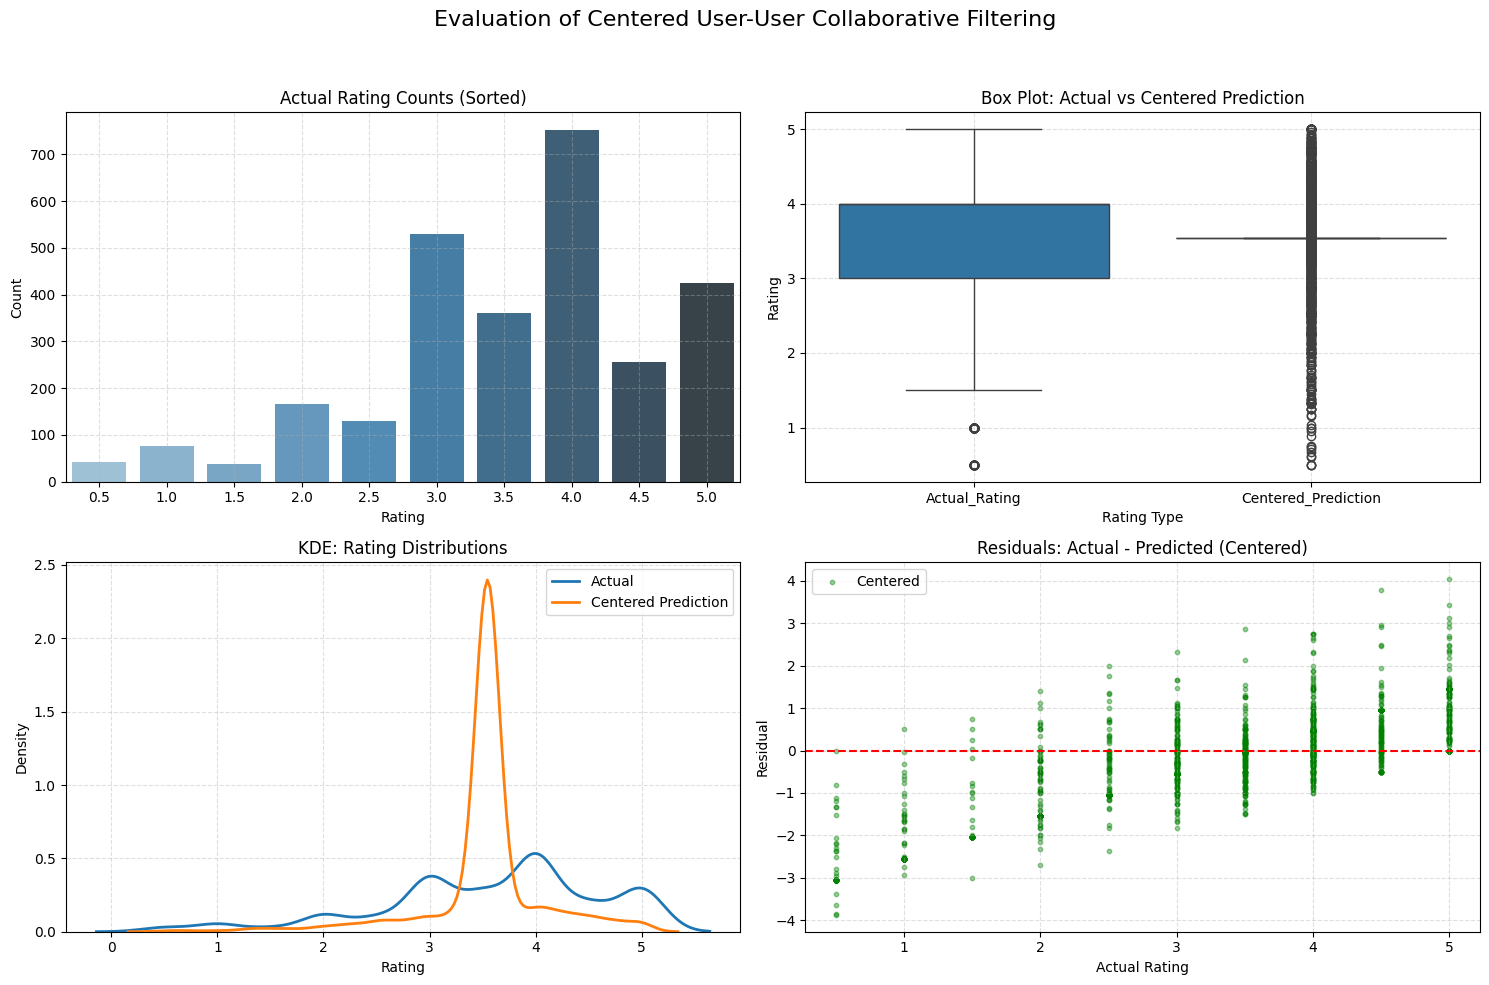

In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import os
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import concurrent.futures

# --- Step 1: Load and split data ---
print("Loading dataset...")
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_sampled.csv")
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
print(f"Data loaded: {len(train_ratings)} training ratings, {len(test_ratings)} test ratings")

# --- Step 2: Center user ratings ---
print("Centering ratings...")
user_means = user_movie_matrix.mean(axis=1)
global_mean = ratings['rating'].mean()
user_rating_centered = user_movie_matrix.sub(user_means, axis=0)

# --- Step 3: Load or compute user similarity matrix ---
user_sim_file_local = "user_similarity_matrix_centered.csv"
user_sim_drive_id = "1W9Byb7cdbUPJId8GzDt55yLQ0SaLLHc5"
user_sim_drive_url = f"https://drive.google.com/uc?id={user_sim_drive_id}"

try:
    if not os.path.exists(user_sim_file_local):
        print("User similarity matrix not found locally. Attempting download...")
        gdown.download(user_sim_drive_url, user_sim_file_local, quiet=False)

    user_sim_df = pd.read_csv(user_sim_file_local, index_col=0)
    user_sim_df.columns = user_sim_df.columns.astype(int)
    user_sim_df.index = user_sim_df.index.astype(int)
    print("User similarity matrix loaded from file or download.")
except Exception as e:
    print("Download failed or file not found. Computing user similarity matrix...")
    user_matrix_filled = user_rating_centered.fillna(0)
    similarity_matrix = cosine_similarity(user_matrix_filled)
    user_sim_df = pd.DataFrame(similarity_matrix, index=user_matrix_filled.index, columns=user_matrix_filled.index)
    user_sim_df.to_csv(user_sim_file_local)
    print("User similarity matrix computed and saved.")

# --- Step 4: Prediction with user bias only ---
def predict_centered(user_id, movie_id, top_k=20):
    if user_id not in user_sim_df.index or movie_id not in user_rating_centered.columns:
        return global_mean

    sims = user_sim_df.loc[user_id].drop(user_id, errors='ignore')
    ratings = user_rating_centered[movie_id]
    valid_users = ratings[ratings.notna()].index.intersection(sims[sims > 0].index)

    if len(valid_users) == 0:
        return global_mean

    sim_scores = sims.loc[valid_users]
    rating_diffs = ratings.loc[valid_users]

    weighted_sum = np.dot(sim_scores, rating_diffs)
    sim_sum = np.abs(sim_scores).sum()

    if sim_sum == 0:
        return global_mean

    user_bias = user_means.get(user_id, global_mean) - global_mean
    pred = global_mean + user_bias + (weighted_sum / sim_sum)
    return max(0.5, min(pred, 5.0))

# --- Step 5: Parallel prediction ---
def predict_row(row):
    uid, mid, true = row.userId, row.movieId, row.rating
    if uid not in user_sim_df.index or mid not in user_rating_centered.columns:
        return None
    pred = predict_centered(uid, mid)
    return (true, pred)

print("Predicting ratings on test set...")
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(predict_row, test_ratings.itertuples(index=False)))

results = [r for r in results if r is not None]
y_true, y_pred = zip(*results) if results else ([], [])
print(f"Predictions complete: {len(y_true)} valid test cases.")

# --- Step 6: Compute evaluation metrics ---
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("\nUser-User Collaborative Filtering with User Bias Only")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

# --- Step 7: Visualizations ---
print("Generating plots...")
viz_df_clean = pd.DataFrame({
    'Actual_Rating': y_true,
    'Centered_Prediction': y_pred
})
viz_df_clean['Residual_Centered'] = viz_df_clean['Actual_Rating'] - viz_df_clean['Centered_Prediction']

box_df = viz_df_clean.melt(
    value_vars=['Actual_Rating', 'Centered_Prediction'],
    var_name='Rating_Type',
    value_name='Rating'
)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Evaluation of Centered User-User Collaborative Filtering", fontsize=16)

rating_counts = viz_df_clean['Actual_Rating'].value_counts().sort_index()
sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0, 0], palette='Blues_d')
axes[0, 0].set_title("Actual Rating Counts (Sorted)")
axes[0, 0].set_xlabel("Rating")
axes[0, 0].set_ylabel("Count")
axes[0, 0].grid(True, linestyle='--', alpha=0.4)

sns.boxplot(data=box_df, x='Rating_Type', y='Rating', ax=axes[0, 1])
axes[0, 1].set_title("Box Plot: Actual vs Centered Prediction")
axes[0, 1].set_xlabel("Rating Type")
axes[0, 1].set_ylabel("Rating")
axes[0, 1].grid(True, linestyle='--', alpha=0.4)

sns.kdeplot(viz_df_clean['Actual_Rating'], label='Actual', ax=axes[1, 0], linewidth=2)
sns.kdeplot(viz_df_clean['Centered_Prediction'], label='Centered Prediction', ax=axes[1, 0], linewidth=2)
axes[1, 0].set_title("KDE: Rating Distributions")
axes[1, 0].set_xlabel("Rating")
axes[1, 0].set_ylabel("Density")
axes[1, 0].legend()
axes[1, 0].grid(True, linestyle='--', alpha=0.4)

x_vals = viz_df_clean['Actual_Rating']
y_vals = viz_df_clean['Residual_Centered']
axes[1, 1].scatter(x_vals, y_vals, label='Centered', alpha=0.4, s=10, color='green')
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_title("Residuals: Actual - Predicted (Centered)")
axes[1, 1].set_xlabel("Actual Rating")
axes[1, 1].set_ylabel("Residual")
axes[1, 1].legend()
axes[1, 1].grid(True, linestyle='--', alpha=0.4)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import os
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("Step 1: Loading ratings dataset and splitting...")
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_sampled.csv")
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
print(f"Training ratings shape: {train_ratings.shape}, Testing ratings shape: {test_ratings.shape}")

print("Step 2: Centering user ratings...")
user_means = user_movie_matrix.mean(axis=1)
user_rating_centered = user_movie_matrix.sub(user_means, axis=0)

print("Step 3: Loading or computing user similarity matrix...")
user_sim_file_local = "user_similarity_matrix_centered.csv"
user_sim_drive_id = "1W9Byb7cdbUPJId8GzDt55yLQ0SaLLHc5"
user_sim_drive_url = f"https://drive.google.com/uc?id={user_sim_drive_id}"

try:
    if not os.path.exists(user_sim_file_local):
        print("User similarity matrix not found locally. Attempting download...")
        gdown.download(user_sim_drive_url, user_sim_file_local, quiet=False)

    user_sim_df = pd.read_csv(user_sim_file_local, index_col=0)
    user_sim_df.columns = user_sim_df.columns.astype(int)
    user_sim_df.index = user_sim_df.index.astype(int)
    print("User similarity matrix loaded successfully.")
except Exception as e:
    print("Download failed or file not found. Computing similarity matrix now...")
    user_matrix_filled = user_rating_centered.fillna(0)
    similarity_matrix = cosine_similarity(user_matrix_filled)
    user_sim_df = pd.DataFrame(similarity_matrix, index=user_matrix_filled.index, columns=user_matrix_filled.index)
    user_sim_df.to_csv(user_sim_file_local)
    print("User similarity matrix computed and saved locally.")

# --- Step 4: Prediction with bias adjustment ---
print("Defining centered prediction function...")
def predict_centered(user_id, movie_id, top_k=20):
    if user_id not in user_sim_df.index or movie_id not in user_rating_centered.columns:
        return user_means.get(user_id, user_movie_matrix.stack().mean())

    sims = user_sim_df.loc[user_id].drop(user_id, errors='ignore')
    ratings = user_rating_centered[movie_id]

    valid_users = ratings[ratings.notna()].index.intersection(sims[sims > 0].index)
    if len(valid_users) == 0:
        return user_means.get(user_id, user_movie_matrix.stack().mean())

    sim_scores = sims.loc[valid_users]
    rating_diffs = ratings.loc[valid_users]

    weighted_sum = np.dot(sim_scores, rating_diffs)
    sim_sum = np.abs(sim_scores).sum()

    if sim_sum == 0:
        return user_means.get(user_id, user_movie_matrix.stack().mean())

    user_bias = user_means.get(user_id, user_movie_matrix.stack().mean())
    pred = user_bias + (weighted_sum / sim_sum)
    return max(0.5, min(pred, 5.0))

# --- Step 5: Parallelized Prediction ---
import concurrent.futures

print("Starting prediction in parallel...")
def predict_row(row):
    uid, mid, true = row.userId, row.movieId, row.rating
    if uid not in user_sim_df.index or mid not in user_rating_centered.columns:
        return None
    pred = predict_centered(uid, mid)
    return (true, pred)

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(predict_row, test_ratings.itertuples(index=False)))

results = [r for r in results if r is not None]
y_true, y_pred = zip(*results) if results else ([], [])
print(f"Total predictions made: {len(y_pred)}")

# --- Step 6: Compute and print metrics ---
print("Evaluating prediction performance...")
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
print("User-User Collaborative Filtering (Centered Ratings with Cosine Similarity)")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

# --- Visualization ---
print("Generating plots...")

# Build viz_df_clean
viz_df_clean = pd.DataFrame({
    "Actual_Rating": y_true,
    "Centered_Prediction": y_pred
})
viz_df_clean["Residual_Centered"] = viz_df_clean["Actual_Rating"] - viz_df_clean["Centered_Prediction"]

# Melt for box plot
box_df = viz_df_clean.melt(
    value_vars=['Actual_Rating', 'Centered_Prediction'],
    var_name='Rating_Type',
    value_name='Rating'
)

# Create plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Evaluation of Centered User-User Collaborative Filtering", fontsize=16)

# Top Left: Bar plot
rating_counts = viz_df_clean['Actual_Rating'].value_counts().sort_index()
sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0, 0], palette='Blues_d')
axes[0, 0].set_title("Actual Rating Counts (Sorted)")
axes[0, 0].set_xlabel("Rating")
axes[0, 0].set_ylabel("Count")
axes[0, 0].grid(True, linestyle='--', alpha=0.4)

# Top Right: Box plot
sns.boxplot(data=box_df, x='Rating_Type', y='Rating', ax=axes[0, 1])
axes[0, 1].set_title("Box Plot: Actual vs Centered Prediction")
axes[0, 1].set_xlabel("Rating Type")
axes[0, 1].set_ylabel("Rating")
axes[0, 1].grid(True, linestyle='--', alpha=0.4)

# Bottom Left: KDE
sns.kdeplot(viz_df_clean['Actual_Rating'], label='Actual', ax=axes[1, 0], linewidth=2)
sns.kdeplot(viz_df_clean['Centered_Prediction'], label='Centered Prediction', ax=axes[1, 0], linewidth=2)
axes[1, 0].set_title("KDE: Rating Distributions")
axes[1, 0].set_xlabel("Rating")
axes[1, 0].set_ylabel("Density")
axes[1, 0].legend()
axes[1, 0].grid(True, linestyle='--', alpha=0.4)

# Bottom Right: Residual plot
x_vals = viz_df_clean['Actual_Rating']
y_vals = viz_df_clean['Residual_Centered']
axes[1, 1].scatter(x_vals, y_vals, label='Centered', alpha=0.4, s=10, color='green')
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_title("Residuals: Actual - Predicted (Centered)")
axes[1, 1].set_xlabel("Actual Rating")
axes[1, 1].set_ylabel("Residual")
axes[1, 1].legend()
axes[1, 1].grid(True, linestyle='--', alpha=0.4)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
print("Done.")


Step 1: Loading ratings dataset and splitting...
Training ratings shape: (13338, 4), Testing ratings shape: (3335, 4)
Step 2: Centering user ratings...


KeyboardInterrupt: 


## User-Based Collaborative Filtering with Bias Adjustment

### Overview

This recommender system is based on **user-user collaborative filtering**, where predictions are made by identifying users with similar tastes and leveraging their ratings. It enhances the basic user-based model by incorporating **bias correction**, accounting for differences in how users rate movies (some rate higher or lower than average) and how some movies tend to receive consistently high or low ratings. Cosine similarity is used to determine how similar users are based on their rating patterns.

### Workflow Description

**Step 1: Data Loading**
The system loads a sample of the MovieLens ratings dataset, which includes user IDs, movie IDs, and ratings.

**Step 2: Train-Test Split and Rating Matrix Construction**
The dataset is divided into training and test sets. From the training set, a user-movie matrix is created, where each row represents a user and each column a movie, filled with ratings when available. This matrix forms the basis for computing similarities.

**Step 3: User Similarity Matrix**
The system attempts to load a precomputed cosine similarity matrix between users. If the file is missing or corrupted, it computes the similarity directly from the user-movie matrix by filling missing values with zero and applying cosine similarity. The result is a square matrix where each value represents how similar two users are based on their historical ratings.

**Step 4: Fallback Tracking**
The model includes fallback counters to record how often it fails to make predictions due to missing users, missing movie ratings, or lack of overlap in ratings.

**Step 5: Prediction Function with Bias Adjustment**
To predict a user’s rating for a given movie:

* The model retrieves the top similar users based on cosine similarity.
* It checks whether those similar users have rated the target movie.
* It computes the **neighbor-centered ratings** by subtracting each neighbor’s mean rating from their rating of the movie.
* These centered ratings are then weighted by their similarity to the target user.
* Finally, the prediction is computed by combining the global average rating with the target user’s bias (their mean rating minus global mean), the movie’s bias (its average rating minus global mean), and the weighted contribution from neighbors.

**Step 6: Evaluation**
The model is evaluated using standard metrics: RMSE, MAE, and R². Only predictions that can be made using the trained similarity matrix and user profiles are included in the evaluation. This provides insight into both the accuracy and reliability of the model.

**Step 7: Reporting**
At the end of execution, the system prints out the number of predictions successfully made using neighbors, as well as the number of fallback cases where either no similar users or no neighbor ratings were found.

### Merits of This Approach

This model offers a more realistic and fair method of prediction by **accounting for systematic bias** in the data. Users who tend to rate generously or harshly are adjusted relative to the average, and movies that are universally liked or disliked are also normalized. This makes the predictions more reliable, especially in cases where raw ratings alone may misrepresent user preferences. Additionally, cosine similarity provides a robust and scalable way to compare users, especially in sparse matrices common in recommendation systems.

Step 1: Sample of loaded ratings:
   userId  movieId  rating   timestamp
0  140400   275079     3.5  1653782463
1   74417    69526     1.0  1511831626
2  149333      912     5.0  1138010777
3  170625     1408     3.0   970775299
4   59586      153     2.0  1201899633

Sample of loaded movies:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Step 2: User-Movie Matrix (training) sample:
movieId  1       2       3       4       5       6       7       

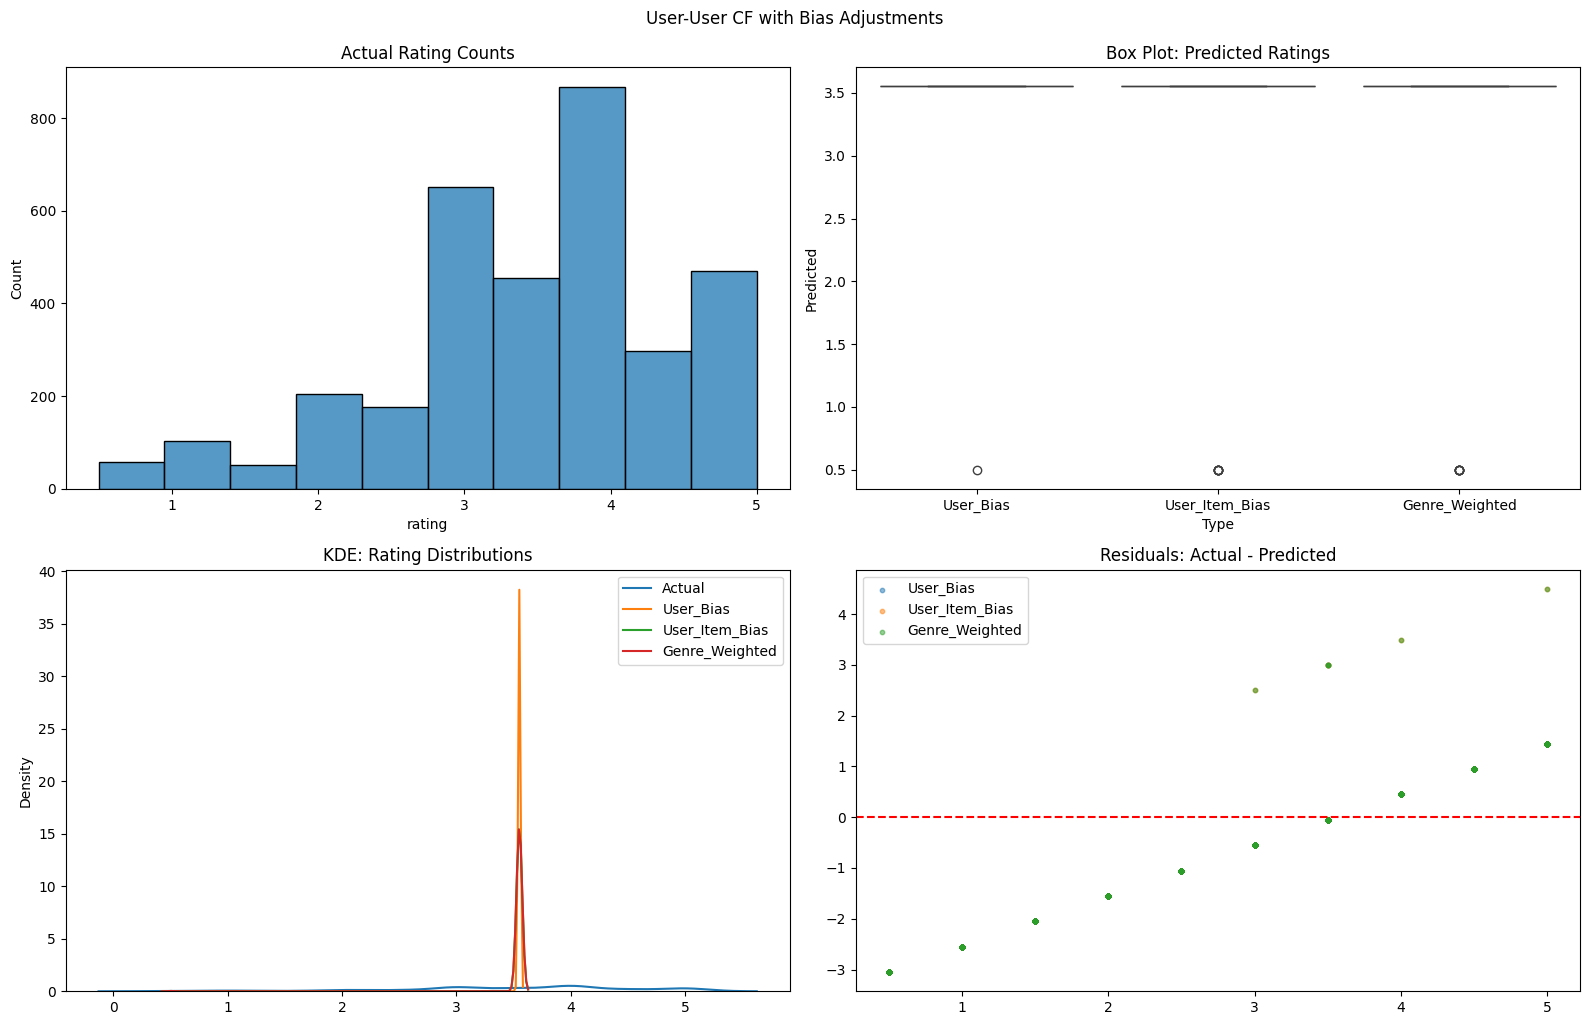

In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# --- Step 1: Load Data ---
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/main/ratings_sampled.csv")
movies = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/main/movies_subset.csv")

# Explanation: We replace NaNs in genres with empty string to allow string operations later.
movies['genres'] = movies['genres'].fillna('')
print("Step 1: Sample of loaded ratings:")
print(ratings.head())
print("\nSample of loaded movies:")
print(movies.head())

# --- Step 2: Split into Train/Test Sets ---
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)

# Create user-movie matrix from training set
train_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
print("\nStep 2: User-Movie Matrix (training) sample:")
print(train_matrix.head())

# --- Step 3: Compute Global and Marginal Means ---
global_mean = train_ratings['rating'].mean()
user_means = train_ratings.groupby('userId')['rating'].mean()
item_means = train_ratings.groupby('movieId')['rating'].mean()
print("\nStep 3: Global mean rating:", global_mean)
print("User mean ratings sample:")
print(user_means.head())
print("Item mean ratings sample:")
print(item_means.head())

# --- Step 4: Genre Weights Preparation ---
genre_matrix = movies['genres'].str.get_dummies(sep='|')
genre_weights = genre_matrix.sum(axis=0).rdiv(1).replace(np.inf, 0)
movies = pd.concat([movies[['movieId', 'title']], genre_matrix], axis=1)
print("\nStep 4: Genre weights:")
print(genre_weights.head())

# --- Step 5: Rating Adjustment Functions ---
def adjust_user_bias(matrix):
    """Adjust for user bias by subtracting user's average rating."""
    adjusted = matrix.sub(matrix.mean(axis=1), axis=0)
    print("\nUser Bias Adjusted Matrix Sample:")
    print(adjusted.head())
    return adjusted

def adjust_user_item_bias(matrix):
    """Adjust for both user and item bias."""
    ru = user_means.reindex(matrix.index).fillna(global_mean).values[:, np.newaxis]
    ri = item_means.reindex(matrix.columns).fillna(global_mean).values[np.newaxis, :]
    adjusted = matrix - (ru + ri - global_mean)
    print("\nUser + Item Bias Adjusted Matrix Sample:")
    print(adjusted.head())
    return adjusted

def adjust_genre_weighted(matrix):
    """Adjust for user and item bias, then weight by inverse genre popularity."""
    base = adjust_user_item_bias(matrix)
    movie_weights = movies.set_index('movieId').reindex(matrix.columns).iloc[:, 1:]  # genre columns
    weights = movie_weights.dot(genre_weights).fillna(0).values
    adjusted = base * weights
    print("\nGenre Weighted Adjusted Matrix Sample:")
    print(pd.DataFrame(adjusted, index=matrix.index, columns=matrix.columns).head())
    return adjusted

# --- Step 6: Apply Adjustments ---
user_bias_matrix = adjust_user_bias(train_matrix)
user_item_bias_matrix = adjust_user_item_bias(train_matrix)
genre_weighted_matrix = adjust_genre_weighted(train_matrix)

# --- Step 7: Compute Cosine Similarities ---
sim_user_bias = pd.DataFrame(cosine_similarity(user_bias_matrix.fillna(0)),
                             index=user_bias_matrix.index, columns=user_bias_matrix.index)
sim_user_item_bias = pd.DataFrame(cosine_similarity(user_item_bias_matrix.fillna(0)),
                                  index=user_item_bias_matrix.index, columns=user_item_bias_matrix.index)
sim_genre_weighted = pd.DataFrame(cosine_similarity(genre_weighted_matrix.fillna(0)),
                                  index=genre_weighted_matrix.index, columns=genre_weighted_matrix.index)

print("\nStep 7: Sample User-User Cosine Similarity (User Bias):")
print(sim_user_bias.iloc[:5, :5])

# --- Step 8: Prediction Function ---
def predict_cf(user_id, movie_id, ratings_matrix, sim_matrix):
    """Predict rating for user_id and movie_id using collaborative filtering."""
    if movie_id not in ratings_matrix.columns or user_id not in sim_matrix.index:
        return global_mean

    sim_scores = sim_matrix.loc[user_id]
    movie_ratings = ratings_matrix[movie_id]
    mask = movie_ratings.notna()
    if mask.sum() == 0:
        return global_mean

    weights = sim_scores[mask]
    ratings = movie_ratings[mask]
    if weights.sum() == 0:
        return global_mean

    return np.clip(np.dot(weights, ratings) / weights.sum(), 0.5, 5.0)

# --- Step 9: Evaluation Function ---
def evaluate_model(name, ratings_matrix, sim_matrix):
    preds, actuals = [], []
    for _, row in test_ratings.iterrows():
        pred = predict_cf(row['userId'], row['movieId'], ratings_matrix, sim_matrix)
        preds.append(pred)
        actuals.append(row['rating'])

    print(f"\n{name} Evaluation:")
    rmse = np.sqrt(mean_squared_error(actuals, preds))
    mae = mean_absolute_error(actuals, preds)
    r2 = r2_score(actuals, preds)
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")
    return {
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }, actuals, preds

# --- Step 10: Run Evaluations ---
result_1, actuals_1, preds_1 = evaluate_model('User_Bias', user_bias_matrix, sim_user_bias)
result_2, actuals_2, preds_2 = evaluate_model('User_Item_Bias', user_item_bias_matrix, sim_user_item_bias)
result_3, actuals_3, preds_3 = evaluate_model('Genre_Weighted', genre_weighted_matrix, sim_genre_weighted)

results_df = pd.DataFrame([result_1, result_2, result_3])
print("\nSummary of Model Performance:")
print(results_df)

# --- Step 11: Visualizations ---
df_plot = pd.DataFrame({
    'Actual': actuals_1 + actuals_2 + actuals_3,
    'User_Bias': preds_1 + [np.nan]*len(preds_2) + [np.nan]*len(preds_3),
    'User_Item_Bias': [np.nan]*len(preds_1) + preds_2 + [np.nan]*len(preds_3),
    'Genre_Weighted': [np.nan]*len(preds_1) + [np.nan]*len(preds_2) + preds_3
})

df_melted = df_plot.melt(id_vars='Actual', var_name='Type', value_name='Predicted')

plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
sns.histplot(test_ratings['rating'], bins=10, kde=False)
plt.title('Actual Rating Counts')

plt.subplot(2, 2, 2)
sns.boxplot(data=df_melted.dropna(), x='Type', y='Predicted')
plt.title('Box Plot: Predicted Ratings')

plt.subplot(2, 2, 3)
sns.kdeplot(actuals_1, label='Actual')
sns.kdeplot(preds_1, label='User_Bias')
sns.kdeplot(preds_2, label='User_Item_Bias')
sns.kdeplot(preds_3, label='Genre_Weighted')
plt.title('KDE: Rating Distributions')
plt.legend()

plt.subplot(2, 2, 4)
plt.axhline(0, color='red', linestyle='--')
plt.scatter(actuals_1, np.array(actuals_1)-np.array(preds_1), label='User_Bias', alpha=0.5, s=10)
plt.scatter(actuals_2, np.array(actuals_2)-np.array(preds_2), label='User_Item_Bias', alpha=0.5, s=10)
plt.scatter(actuals_3, np.array(actuals_3)-np.array(preds_3), label='Genre_Weighted', alpha=0.5, s=10)
plt.title('Residuals: Actual - Predicted')
plt.legend()

plt.tight_layout()
plt.suptitle("User-User CF with Bias Adjustments", y=1.02)
plt.show()


In [ ]:
# --- Step 10.2: Debugging Snapshots & NaN Percentages ---

def print_debug_info(label, df):
    print(f"\n--- {label} ---")
    print(df.head())
    if isinstance(df, pd.DataFrame):
        percent_nan = df.isna().mean().mean() * 100
        print(f"{label} – Average % of NaN values: {percent_nan:.2f}%")

# Key debugging snapshots
print_debug_info("Movies", movies)
print_debug_info("Ratings", ratings)
print_debug_info("Genre Matrix", genre_matrix)
print_debug_info("User-User Similarity (User Bias)", sim_user_bias)
print_debug_info("User-User Similarity (User+Item Bias)", sim_user_item_bias)
print_debug_info("User-User Similarity (Genre Weighted)", sim_genre_weighted)

# Check NaN in prediction results
def print_nan_percentage(preds, label):
    preds_series = pd.Series(preds)
    percent_nan = preds_series.isna().mean() * 100
    print(f"{label} – % of NaN predictions: {percent_nan:.2f}%")

print_nan_percentage(preds_1, "User_Bias")
print_nan_percentage(preds_2, "User_Item_Bias")
print_nan_percentage(preds_3, "Genre_Weighted")



--- Movies ---
   movieId                               title  (no genres listed)  Action  \
0        1                    Toy Story (1995)                   0       0   
1        2                      Jumanji (1995)                   0       0   
2        3             Grumpier Old Men (1995)                   0       0   
3        4            Waiting to Exhale (1995)                   0       0   
4        5  Father of the Bride Part II (1995)                   0       0   

   Adventure  Animation  Children  Comedy  Crime  Documentary  ...  Film-Noir  \
0          1          1         1       1      0            0  ...          0   
1          1          0         1       0      0            0  ...          0   
2          0          0         0       1      0            0  ...          0   
3          0          0         0       1      0            0  ...          0   
4          0          0         0       1      0            0  ...          0   

   Horror  IMAX  Musical  My

In [ ]:
# --- Step 10.2: Debugging Snapshots & Non-Zero Percentages ---

def print_debug_info(label, df):
    print(f"\n--- {label} ---")
    print(df.head())
    if isinstance(df, pd.DataFrame):
        non_zero_ratio = (df != 0).sum().sum() / df.size * 100
        # print(f"{label} – % of Non-Zero Values: {non_zero_ratio:.2f}%")

# Key matrices for inspection
print_debug_info("User-User Similarity (User Bias)", sim_user_bias)
print_debug_info("User-User Similarity (User+Item Bias)", sim_user_item_bias)
print_debug_info("User-User Similarity (Genre Weighted)", sim_genre_weighted)

# Check non-zero prediction counts
def print_non_zero_percentage(preds, label):
    preds_series = pd.Series(preds)
    percent_non_zero = (preds_series != 0).mean() * 100
    print(f"{label} – % of Non-Zero Predictions: {percent_non_zero:.2f}%")

print_non_zero_percentage(preds_1, "User_Bias")
print_non_zero_percentage(preds_2, "User_Item_Bias")
print_non_zero_percentage(preds_3, "Genre_Weighted")



--- User-User Similarity (User Bias) ---
userId  10      18      33      40      61      64      81      126     \
userId                                                                   
10         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
18         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
33         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
40         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
61         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

userId  135     144     ...  200687  200703  200767  200774  200822  200878  \
userId                  ...                                                   
10         0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
18         0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
33         0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
40         0.0     0.0  ...     0.0     0.0 

In [ ]:
# --- Step X: Density of Actual Ratings ---

def print_actual_ratings_density(ratings_df):
    total_possible = ratings_df['userId'].nunique() * ratings_df['movieId'].nunique()
    actual_rated = len(ratings_df)
    percent = (actual_rated / total_possible) * 100
    print("Actual Ratings Density:")
    print(f"  Rated entries: {actual_rated:,} / {total_possible:,} ({percent:.4f}%)\n")

print_actual_ratings_density(ratings)


Actual Ratings Density:
  Rated entries: 16,673 / 49,330,000 (0.0338%)



In [ ]:
import pandas as pd

# Load the ratings data
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/main/ratings_sampled.csv")

# Total number of ratings
total_ratings = len(ratings)

# Count of non-zero ratings
nonzero_ratings = (ratings['rating'] != 0).sum()

# Percentage of non-zero ratings
percent_nonzero = (nonzero_ratings / total_ratings) * 100

print(f"Total ratings: {total_ratings}")
print(f"Non-zero ratings: {nonzero_ratings}")
print(f"Percentage of non-zero ratings: {percent_nonzero:.4f}%")


Total ratings: 16673
Non-zero ratings: 16673
Percentage of non-zero ratings: 100.0000%


In [ ]:
import pandas as pd

# Load ratings data
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/main/ratings_sampled.csv")

# Step 1: Count total possible user-movie combinations
num_users = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()
total_possible = num_users * num_movies

# Step 2: Count actual ratings
actual_ratings = len(ratings)

# Step 3: Compute density
density_percent = (actual_ratings / total_possible) * 100

# Step 4: Output
print("User-Movie Matrix Density:")
print(f"  Unique users      : {num_users}")
print(f"  Unique movies     : {num_movies}")
print(f"  Total possibilities: {total_possible}")
print(f"  Actual ratings     : {actual_ratings}")
print(f"  Density            : {density_percent:.6f}%")


User-Movie Matrix Density:
  Unique users      : 10000
  Unique movies     : 4933
  Total possibilities: 49330000
  Actual ratings     : 16673
  Density            : 0.033799%


In [ ]:
import pandas as pd

# Load ratings data
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/main/ratings_sampled.csv")

# Step 1: Construct user-movie matrix
user_movie_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')

# Step 2: Count non-NaN entries (actual ratings)
non_missing = user_movie_matrix.notna().sum().sum()

# Step 3: Total number of cells in the matrix
total_entries = user_movie_matrix.shape[0] * user_movie_matrix.shape[1]

# Step 4: Compute density
density_percent = (non_missing / total_entries) * 100

# Step 5: Output
print("User-Movie Matrix Density:")
print(f"  Matrix shape       : {user_movie_matrix.shape}")
print(f"  Total entries      : {total_entries}")
print(f"  Non-missing ratings: {non_missing}")
print(f"  Density            : {density_percent:.6f}%")


User-Movie Matrix Density:
  Matrix shape       : (10000, 4933)
  Total entries      : 49330000
  Non-missing ratings: 16673
  Density            : 0.033799%


In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Load Data ---
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/main/ratings_sampled.csv")
movies = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/main/movies_subset.csv")

# --- Genre Matrix ---
movies['genres'] = movies['genres'].fillna('')
genre_dummies = movies['genres'].str.get_dummies(sep='|')
movies = pd.concat([movies[['movieId']], genre_dummies], axis=1)

# --- Train-Test Split ---
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')

# --- Global Stats ---
global_mean = train_ratings['rating'].mean()
user_means = train_ratings.groupby('userId')['rating'].mean()
movie_means = train_ratings.groupby('movieId')['rating'].mean()

# --- Adjustment Functions ---
def adjust_user_bias(matrix):
    return matrix.sub(matrix.mean(axis=1), axis=0).fillna(0)

def adjust_user_item_bias(matrix):
    ru = matrix.mean(axis=1)
    ri = matrix.mean(axis=0)
    return matrix.sub(ru, axis=0).sub(ri, axis=1).add(global_mean).fillna(0)

def adjust_genre_weighted(matrix):
    adj = adjust_user_item_bias(matrix.copy())
    for item in matrix.columns:
        if item in movies['movieId'].values:
            row = movies[movies['movieId'] == item]
            weight = row.iloc[:, 1:].values.dot(np.ones(len(genre_dummies.columns)))
            adj[item] = adj[item] * weight[0]
    return adj.fillna(0)

# --- Create Adjusted Matrices ---
user_bias_matrix = adjust_user_bias(user_movie_matrix.copy())
user_item_bias_matrix = adjust_user_item_bias(user_movie_matrix.copy())
genre_weighted_matrix = adjust_genre_weighted(user_movie_matrix.copy())

# --- Compute Similarity ---
sim_user_bias = pd.DataFrame(cosine_similarity(user_bias_matrix),
                             index=user_bias_matrix.index, columns=user_bias_matrix.index)

sim_user_item_bias = pd.DataFrame(cosine_similarity(user_item_bias_matrix),
                                  index=user_item_bias_matrix.index, columns=user_item_bias_matrix.index)

sim_genre_weighted = pd.DataFrame(cosine_similarity(genre_weighted_matrix),
                                  index=genre_weighted_matrix.index, columns=genre_weighted_matrix.index)

# --- Prediction Function ---
def predict_cf(user_id, movie_id, ratings_matrix, sim_matrix, top_k=20):
    if user_id not in sim_matrix.index or movie_id not in ratings_matrix.columns:
        return movie_means.get(movie_id, global_mean)

    sims = sim_matrix.loc[user_id].drop(user_id, errors='ignore')
    sims = sims[sims > 0]
    neighbors = ratings_matrix.index.intersection(sims.index)
    ratings = ratings_matrix.loc[neighbors, movie_id].dropna()
    sims = sims.loc[ratings.index]

    if ratings.empty or sims.empty:
        return movie_means.get(movie_id, global_mean)

    weighted_sum = np.dot(sims.values, ratings.values)
    norm = np.sum(np.abs(sims.values))
    return max(0.5, min(weighted_sum / norm if norm != 0 else global_mean, 5.0))

# --- Evaluation ---
def evaluate_model(name, ratings_matrix, sim_matrix):
    preds, actuals = [], []
    for _, row in test_ratings.iterrows():
        pred = predict_cf(row['userId'], row['movieId'], ratings_matrix, sim_matrix)
        preds.append(pred)
        actuals.append(row['rating'])

    return {
        'Model': name,
        'RMSE': np.sqrt(mean_squared_error(actuals, preds)),
        'MAE': mean_absolute_error(actuals, preds),
        'R2': r2_score(actuals, preds)
    }

# --- Run All Scenarios ---
results = [
    evaluate_model("User_Bias", user_bias_matrix, sim_user_bias),
    evaluate_model("User_Item_Bias", user_item_bias_matrix, sim_user_item_bias),
    evaluate_model("Genre_Weighted", genre_weighted_matrix, sim_genre_weighted)
]

# --- Display Results ---
results_df = pd.DataFrame(results)
print(results_df)


            Model      RMSE       MAE        R2
0       User_Bias  1.600864  1.179402 -1.281950
1  User_Item_Bias  2.151225  1.675818 -3.120682
2  Genre_Weighted  2.151225  1.675818 -3.120682


Ratings data loaded successfully.
User similarity matrix not found locally. Attempting download...


Downloading...
From (original): https://drive.google.com/uc?id=1W9Byb7cdbUPJId8GzDt55yLQ0SaLLHc5
From (redirected): https://drive.google.com/uc?id=1W9Byb7cdbUPJId8GzDt55yLQ0SaLLHc5&confirm=t&uuid=be818f27-45bf-4145-88fb-9ff469b41dc9
To: /content/user_similarity_matrix.csv
100%|██████████| 401M/401M [00:07<00:00, 54.8MB/s]


User similarity matrix loaded.

Cosine-Based User-User CF with User & Item Bias
RMSE: 1.1083
MAE : 0.8396
R²  : -0.1299


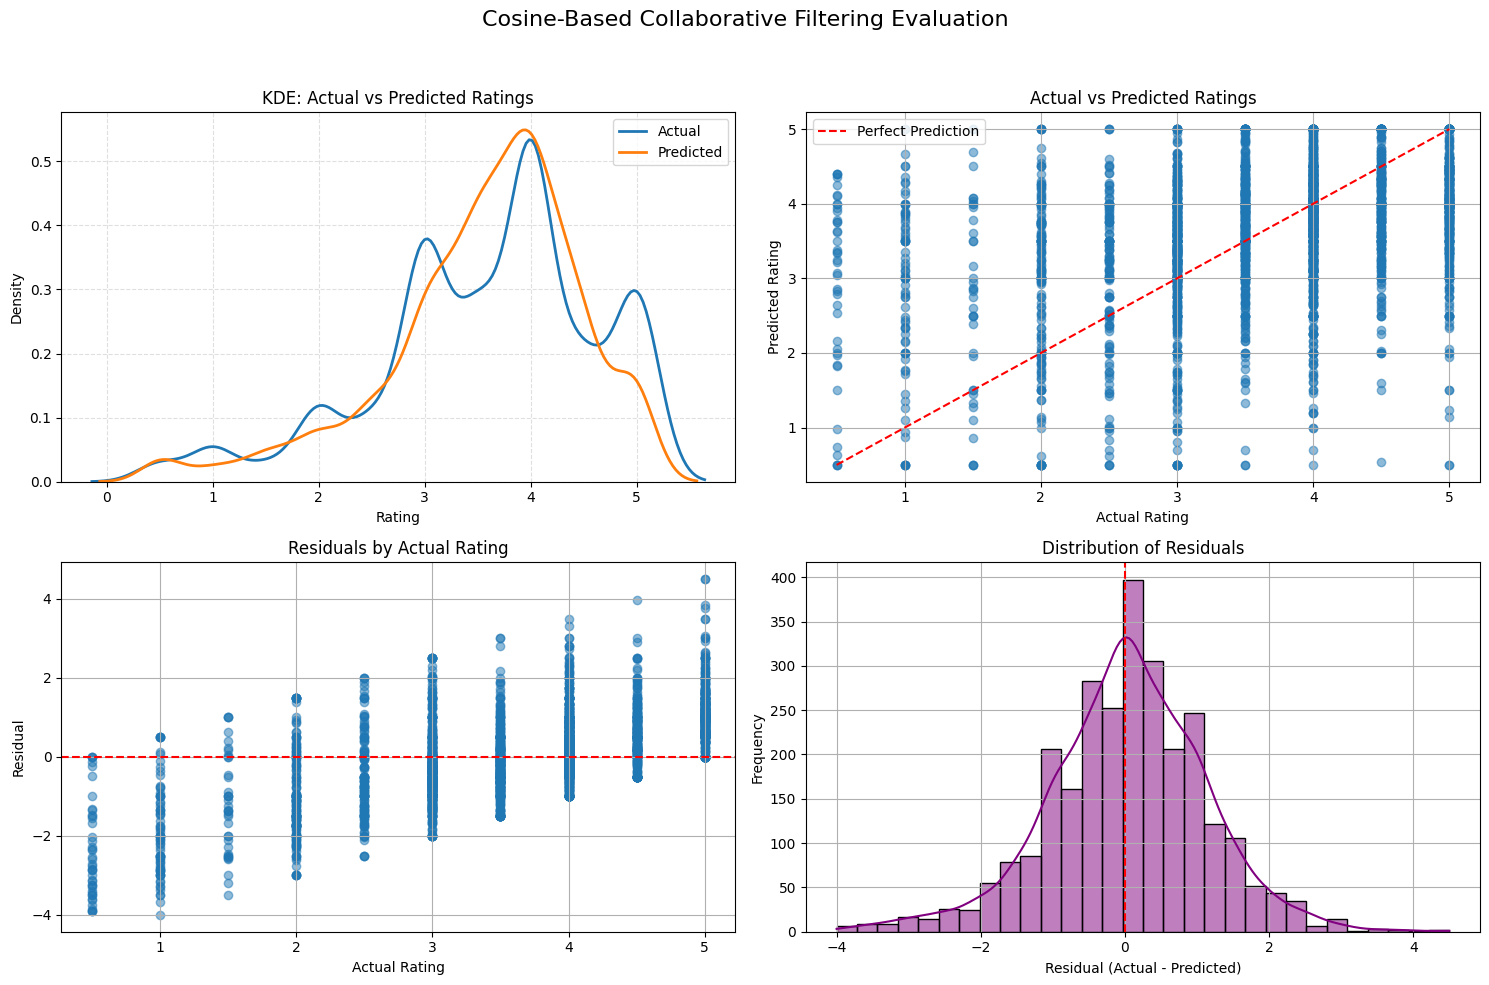


Prediction Source Breakdown
Predictions using neighbors: 1006
Fallback (no similar users): 1398
Fallback (no ratings from neighbors): 366


In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import os
import gdown
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load ratings data
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_sampled.csv")
print("Ratings data loaded successfully.")

# Step 2: Train/test split and matrix setup
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
movie_means = train_ratings.groupby('movieId')['rating'].mean()
user_means = train_ratings.groupby('userId')['rating'].mean()

# Step 3: Load or compute user similarity matrix
user_sim_file_local = "user_similarity_matrix.csv"
user_sim_drive_id = "1W9Byb7cdbUPJId8GzDt55yLQ0SaLLHc5"
user_sim_drive_url = f"https://drive.google.com/uc?id={user_sim_drive_id}"

try:
    if not os.path.exists(user_sim_file_local):
        print("User similarity matrix not found locally. Attempting download...")
        gdown.download(user_sim_drive_url, user_sim_file_local, quiet=False)

    user_sim_df = pd.read_csv(user_sim_file_local, index_col=0)
    user_sim_df.columns = user_sim_df.columns.astype(int)
    user_sim_df.index = user_sim_df.index.astype(int)
    print("User similarity matrix loaded.")
except Exception as e:
    print("Download failed or file corrupt. Computing user similarity matrix...")
    user_matrix_filled = user_movie_matrix.fillna(0)
    similarity_matrix = cosine_similarity(user_matrix_filled)
    user_sim_df = pd.DataFrame(similarity_matrix, index=user_matrix_filled.index, columns=user_matrix_filled.index)
    user_sim_df.to_csv(user_sim_file_local)
    print("User similarity matrix computed and saved.")

# Step 4: Fallback counter
fallback_counter = {'no_sim_users': 0, 'no_rating': 0, 'success': 0}

# Step 5: Prediction function (Bias-Aware with Item Bias)
def predict_user_based(user_id, movie_id, top_k=20):
    if user_id not in user_sim_df.index or movie_id not in user_movie_matrix.columns:
        fallback_counter['no_rating'] += 1
        return movie_means.get(movie_id, global_mean)

    sim_users = user_sim_df.loc[user_id].sort_values(ascending=False).drop(user_id, errors='ignore')
    sim_users = sim_users[sim_users > 0]

    if sim_users.empty:
        fallback_counter['no_sim_users'] += 1
        return movie_means.get(movie_id, global_mean)

    neighbors = sim_users.index
    neighbor_ratings = user_movie_matrix.loc[user_movie_matrix.index.intersection(neighbors), movie_id].dropna()

    if neighbor_ratings.empty:
        fallback_counter['no_rating'] += 1
        return movie_means.get(movie_id, global_mean)

    top_users = neighbor_ratings.index
    sims = sim_users.loc[top_users].values
    ratings = neighbor_ratings.loc[top_users].values
    neighbor_means = user_movie_matrix.loc[top_users].mean(axis=1).values
    rating_diffs = ratings - neighbor_means

    weighted_sum = np.dot(sims, rating_diffs)
    norm_factor = np.sum(np.abs(sims))

    if norm_factor == 0:
        return movie_means.get(movie_id, global_mean)

    bu = user_means.get(user_id, global_mean) - global_mean
    bi = movie_means.get(movie_id, global_mean) - global_mean
    prediction = global_mean + bu + bi + (weighted_sum / norm_factor)

    fallback_counter['success'] += 1
    return max(0.5, min(prediction, 5.0))

# Step 6: Evaluation + Visuals
def evaluate_user_model(test_df, filter_strict=True):
    y_true, y_pred = [], []

    for _, row in test_df.iterrows():
        user_id = int(row['userId'])
        movie_id = int(row['movieId'])

        if filter_strict:
            if user_id not in user_sim_df.index or movie_id not in user_movie_matrix.columns:
                continue

        true_rating = row['rating']
        pred_rating = predict_user_based(user_id, movie_id)
        y_true.append(true_rating)
        y_pred.append(pred_rating)

    if not y_true:
        print("No valid test samples for evaluation.")
        return

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    residuals = np.array(y_true) - np.array(y_pred)

    print("\nCosine-Based User-User CF with User & Item Bias")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

    # --- Visualizations ---
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle("Cosine-Based Collaborative Filtering Evaluation", fontsize=16)

    # KDE Plot
    sns.kdeplot(y_true, label='Actual', ax=axes[0, 0], linewidth=2)
    sns.kdeplot(y_pred, label='Predicted', ax=axes[0, 0], linewidth=2)
    axes[0, 0].set_title("KDE: Actual vs Predicted Ratings")
    axes[0, 0].set_xlabel("Rating")
    axes[0, 0].set_ylabel("Density")
    axes[0, 0].legend()
    axes[0, 0].grid(True, linestyle='--', alpha=0.4)

    # Scatter: Actual vs Predicted
    axes[0, 1].scatter(y_true, y_pred, alpha=0.5)
    axes[0, 1].plot([0.5, 5], [0.5, 5], 'r--', label='Perfect Prediction')
    axes[0, 1].set_title("Actual vs Predicted Ratings")
    axes[0, 1].set_xlabel("Actual Rating")
    axes[0, 1].set_ylabel("Predicted Rating")
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Residuals vs Actual
    axes[1, 0].scatter(y_true, residuals, alpha=0.5)
    axes[1, 0].axhline(0, color='red', linestyle='--')
    axes[1, 0].set_title("Residuals by Actual Rating")
    axes[1, 0].set_xlabel("Actual Rating")
    axes[1, 0].set_ylabel("Residual")
    axes[1, 0].grid(True)

    # Residual Histogram
    sns.histplot(residuals, bins=30, kde=True, ax=axes[1, 1], color='purple')
    axes[1, 1].axvline(0, color='red', linestyle='--')
    axes[1, 1].set_title("Distribution of Residuals")
    axes[1, 1].set_xlabel("Residual (Actual - Predicted)")
    axes[1, 1].set_ylabel("Frequency")
    axes[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Step 7: Run evaluation
evaluate_user_model(test_ratings)

# Step 8: Print fallback summary
print("\nPrediction Source Breakdown")
print(f"Predictions using neighbors: {fallback_counter['success']}")
print(f"Fallback (no similar users): {fallback_counter['no_sim_users']}")
print(f"Fallback (no ratings from neighbors): {fallback_counter['no_rating']}")


In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import os
import gdown
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load ratings data
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_sampled.csv")
print("Ratings data loaded successfully.")

# Step 2: Train/test split and matrix setup
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
movie_means = train_ratings.groupby('movieId')['rating'].mean()
user_means = train_ratings.groupby('userId')['rating'].mean()

# Step 3: Load or compute user similarity matrix
user_sim_file_local = "user_similarity_matrix.csv"
user_sim_drive_id = "1W9Byb7cdbUPJId8GzDt55yLQ0SaLLHc5"
user_sim_drive_url = f"https://drive.google.com/uc?id={user_sim_drive_id}"

try:
    if not os.path.exists(user_sim_file_local):
        print("User similarity matrix not found locally. Attempting download...")
        gdown.download(user_sim_drive_url, user_sim_file_local, quiet=False)

    user_sim_df = pd.read_csv(user_sim_file_local, index_col=0)
    user_sim_df.columns = user_sim_df.columns.astype(int)
    user_sim_df.index = user_sim_df.index.astype(int)
    print("User similarity matrix loaded.")
except Exception as e:
    print("Download failed or file corrupt. Computing user similarity matrix...")
    user_matrix_filled = user_movie_matrix.fillna(0)
    similarity_matrix = cosine_similarity(user_matrix_filled)
    user_sim_df = pd.DataFrame(similarity_matrix, index=user_matrix_filled.index, columns=user_matrix_filled.index)
    user_sim_df.to_csv(user_sim_file_local)
    print("User similarity matrix computed and saved.")

# Step 4: Fallback counter
fallback_counter = {'no_sim_users': 0, 'no_rating': 0, 'success': 0}

# Step 5: Prediction function (Bias-Aware with Item Bias and Top-K Filtering)
def predict_user_based(user_id, movie_id, top_k=20):
    if user_id not in user_sim_df.index or movie_id not in user_movie_matrix.columns:
        fallback_counter['no_rating'] += 1
        return movie_means.get(movie_id, global_mean)

    sim_users = user_sim_df.loc[user_id].sort_values(ascending=False).drop(user_id, errors='ignore')
    sim_users = sim_users[sim_users > 0]

    if sim_users.empty:
        fallback_counter['no_sim_users'] += 1
        return movie_means.get(movie_id, global_mean)

    neighbor_ratings = user_movie_matrix.loc[sim_users.index, movie_id].dropna()
    if neighbor_ratings.empty:
        fallback_counter['no_rating'] += 1
        return movie_means.get(movie_id, global_mean)

    # Top-K filtering
    sims = sim_users.loc[neighbor_ratings.index]
    top_k_users = sims.nlargest(top_k)
    ratings = neighbor_ratings.loc[top_k_users.index]
    neighbor_means = user_movie_matrix.loc[top_k_users.index].mean(axis=1)
    rating_diffs = ratings - neighbor_means

    weighted_sum = np.dot(top_k_users.values, rating_diffs.values)
    norm_factor = np.sum(np.abs(top_k_users.values))

    if norm_factor == 0:
        return movie_means.get(movie_id, global_mean)

    bu = user_means.get(user_id, global_mean) - global_mean
    bi = movie_means.get(movie_id, global_mean) - global_mean
    prediction = global_mean + bu + bi + (weighted_sum / norm_factor)

    fallback_counter['success'] += 1
    return max(0.5, min(prediction, 5.0))

# Step 6: Evaluation + Visuals
def evaluate_user_model(test_df, filter_strict=True):
    y_true = []
    y_pred = []


    for _, row in test_df.iterrows():
        user_id = int(row['userId'])
        movie_id = int(row['movieId'])

        if filter_strict:
            # Skip if user or movie is not in training set or similarity matrix
            if (user_id not in user_sim_df.index or
                user_id not in user_movie_matrix.index or
                movie_id not in user_movie_matrix.columns):
                continue

        true_rating = row['rating']
        pred_rating = predict_user_based(user_id, movie_id)
        y_true.append(true_rating)
        y_pred.append(pred_rating)

    if not y_true:
        print("No valid test samples for evaluation.")
        return

    # rest of the code...


    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    residuals = np.array(y_true) - np.array(y_pred)

    print("\nCosine-Based User-User CF with User & Item Bias (Top-K)")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

    # --- Visualizations ---
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle("Cosine-Based Collaborative Filtering Evaluation", fontsize=16)

    sns.kdeplot(y_true, label='Actual', ax=axes[0, 0], linewidth=2)
    sns.kdeplot(y_pred, label='Predicted', ax=axes[0, 0], linewidth=2)
    axes[0, 0].set_title("KDE: Actual vs Predicted Ratings")
    axes[0, 0].set_xlabel("Rating")
    axes[0, 0].set_ylabel("Density")
    axes[0, 0].legend()
    axes[0, 0].grid(True, linestyle='--', alpha=0.4)

    axes[0, 1].scatter(y_true, y_pred, alpha=0.5)
    axes[0, 1].plot([0.5, 5], [0.5, 5], 'r--', label='Perfect Prediction')
    axes[0, 1].set_title("Actual vs Predicted Ratings")
    axes[0, 1].set_xlabel("Actual Rating")
    axes[0, 1].set_ylabel("Predicted Rating")
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    axes[1, 0].scatter(y_true, residuals, alpha=0.5)
    axes[1, 0].axhline(0, color='red', linestyle='--')
    axes[1, 0].set_title("Residuals by Actual Rating")
    axes[1, 0].set_xlabel("Actual Rating")
    axes[1, 0].set_ylabel("Residual")
    axes[1, 0].grid(True)

    sns.histplot(residuals, bins=30, kde=True, ax=axes[1, 1], color='purple')
    axes[1, 1].axvline(0, color='red', linestyle='--')
    axes[1, 1].set_title("Distribution of Residuals")
    axes[1, 1].set_xlabel("Residual (Actual - Predicted)")
    axes[1, 1].set_ylabel("Frequency")
    axes[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Step 7: Run evaluation
evaluate_user_model(test_ratings)

# Step 8: Print fallback summary
print("\nPrediction Source Breakdown")
print(f"Predictions using neighbors: {fallback_counter['success']}")
print(f"Fallback (no similar users): {fallback_counter['no_sim_users']}")
print(f"Fallback (no ratings from neighbors): {fallback_counter['no_rating']}")


Ratings data loaded successfully.
User similarity matrix loaded.


KeyError: '[58066] not in index'

In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import os
import gdown
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Load ratings data
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_sampled.csv")
print("Ratings data loaded successfully.")

# Step 2: Split ratings
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
movie_means = train_ratings.groupby('movieId')['rating'].mean()

# Step 3: Load or compute user similarity matrix
user_sim_file_local = "user_similarity_matrix.csv"
user_sim_drive_id = "1W9Byb7cdbUPJId8GzDt55yLQ0SaLLHc5"
user_sim_drive_url = f"https://drive.google.com/uc?id={user_sim_drive_id}"

try:
    if not os.path.exists(user_sim_file_local):
        print("User similarity matrix not found locally. Attempting download...")
        gdown.download(user_sim_drive_url, user_sim_file_local, quiet=False)

    user_sim_df = pd.read_csv(user_sim_file_local, index_col=0)
    user_sim_df.columns = user_sim_df.columns.astype(int)
    user_sim_df.index = user_sim_df.index.astype(int)
    print("User similarity matrix loaded.")
except Exception as e:
    print("Download failed or file corrupt. Computing user similarity matrix...")
    user_matrix_filled = user_movie_matrix.fillna(0)
    similarity_matrix = cosine_similarity(user_matrix_filled)
    user_sim_df = pd.DataFrame(similarity_matrix, index=user_matrix_filled.index, columns=user_matrix_filled.index)
    user_sim_df.to_csv(user_sim_file_local)
    print("User similarity matrix computed and saved.")

# Step 4: Track fallbacks
fallback_counter = {'no_sim_users': 0, 'no_rating': 0, 'success': 0}

# Step 5: Bias-aware prediction function
def predict_user_based(user_id, movie_id, top_k=20):
    if user_id not in user_sim_df.index or movie_id not in user_movie_matrix.columns:
        fallback_counter['no_rating'] += 1
        return movie_means.get(movie_id, global_mean)

    sim_users = user_sim_df.loc[user_id].sort_values(ascending=False).drop(user_id, errors='ignore')
    sim_users = sim_users[sim_users > 0]

    if sim_users.empty:
        fallback_counter['no_sim_users'] += 1
        return movie_means.get(movie_id, global_mean)

    neighbors = sim_users.index
    neighbor_ratings = user_movie_matrix.loc[user_movie_matrix.index.intersection(neighbors), movie_id].dropna()

    if neighbor_ratings.empty:
        fallback_counter['no_rating'] += 1
        return movie_means.get(movie_id, global_mean)

    top_users = neighbor_ratings.index
    sims = sim_users.loc[top_users].values
    ratings = neighbor_ratings.loc[top_users].values

    # Bias correction using neighbor means
    neighbor_means = user_movie_matrix.loc[top_users].mean(axis=1).values
    adjusted_ratings = ratings - neighbor_means

    weighted_sum = np.dot(sims, adjusted_ratings)
    norm_factor = np.sum(np.abs(sims))

    if norm_factor == 0:
        return movie_means.get(movie_id, global_mean)

    # Add user and item bias
    bu = user_movie_matrix.loc[user_id].mean() - global_mean if user_id in user_movie_matrix.index else 0
    bi = movie_means.get(movie_id, global_mean) - global_mean
    prediction = global_mean + bu + bi + (weighted_sum / norm_factor)

    fallback_counter['success'] += 1
    return max(0.5, min(prediction, 5.0))

# Step 6: Evaluation function
def evaluate_user_model(test_df, filter_strict=True):
    y_true = []
    y_pred = []

    for _, row in test_df.iterrows():
        user_id = int(row['userId'])
        movie_id = int(row['movieId'])

        if filter_strict:
            if user_id not in user_sim_df.index or movie_id not in user_movie_matrix.columns:
                continue

        true_rating = row['rating']
        pred_rating = predict_user_based(user_id, movie_id)
        y_true.append(true_rating)
        y_pred.append(pred_rating)

    if not y_true:
        print("No valid test samples for evaluation.")
        return

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print("\nUser-Based Collaborative Filtering with Bias Adjustment")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

# Step 7: Run evaluation
evaluate_user_model(test_ratings)

# Step 8: Print fallback summary
print("\nPrediction Source Breakdown")
print(f"Predictions using neighbors: {fallback_counter['success']}")
print(f"Fallback (no similar users): {fallback_counter['no_sim_users']}")
print(f"Fallback (no ratings from neighbors): {fallback_counter['no_rating']}")


Ratings data loaded successfully.
User similarity matrix not found locally. Attempting download...


Downloading...
From (original): https://drive.google.com/uc?id=1W9Byb7cdbUPJId8GzDt55yLQ0SaLLHc5
From (redirected): https://drive.google.com/uc?id=1W9Byb7cdbUPJId8GzDt55yLQ0SaLLHc5&confirm=t&uuid=04690389-b047-4ff0-9f7b-745b98ea3624
To: /content/user_similarity_matrix.csv
100%|██████████| 401M/401M [00:05<00:00, 67.0MB/s]


User similarity matrix loaded.

User-Based Collaborative Filtering with Bias Adjustment
RMSE: 1.1083
MAE : 0.8396
R²  : -0.1299

Prediction Source Breakdown
Predictions using neighbors: 1006
Fallback (no similar users): 1398
Fallback (no ratings from neighbors): 366


## TF-IDF-Based User-User Collaborative Filtering

### Overview

This recommender system enhances traditional collaborative filtering by **encoding user genre preferences using TF-IDF** (Term Frequency-Inverse Document Frequency) derived from movie genres. Instead of comparing raw ratings, this model computes similarity between users based on the **weighted semantic meaning of genres they've rated highly**. The approach integrates both content and collaborative elements, making it a hybrid recommender system with a user-user architecture.

### Workflow Description

**Step 1: Data Loading**
The system loads movie metadata and user ratings from the MovieLens dataset.

**Step 2: Genre TF-IDF Encoding**
Movie genres are treated as tokenized text inputs and transformed into a TF-IDF matrix. This encodes each movie's genre profile in a way that emphasizes **unique or rare genres** over common ones, improving the system’s ability to differentiate between user tastes.

**Step 3: Matrix Construction**
The user-movie matrix is built from training data. The global average rating and per-movie average ratings are also computed for fallback use during prediction.

**Step 4: User Profile Construction**
Each user's profile is generated by taking a **weighted average of the TF-IDF vectors** of the movies they have rated. Ratings serve as weights to reflect the degree of interest in each movie's genre composition. This results in a compact vector that summarizes a user's genre preferences in a nuanced way.

**Step 5: User Similarity Matrix**
Cosine similarity is applied to the user TF-IDF profile matrix, producing a **user-user similarity matrix** based on genre affinity instead of rating overlap.

**Step 6: Fallback Tracker**
Fallback counters are initialized to keep track of scenarios where predictions must rely on global or item-level averages due to missing data.

**Step 7: Prediction Function**
To predict a rating for a given (user, movie) pair:

* Similar users are identified via the TF-IDF cosine similarity matrix.
* Their ratings for the target movie are extracted.
* A weighted average is calculated using similarity scores.
* If no similar users or ratings are available, the system falls back to the movie mean or global mean.

**Step 8: Evaluation**
The model is evaluated using standard metrics: RMSE, MAE, and R². These metrics provide insight into how well the system predicts user ratings compared to actual outcomes.

**Step 9–10: Reporting**
Performance results are printed, along with fallback usage statistics indicating how often the model relied on global/item-level means versus collaborative logic.

### Merits of This Approach

* **Genre-Aware Similarity**: Unlike standard collaborative filtering, this model captures **semantic similarity in genre preferences**, even when users have no movies in common.
* **Cold-Start Support**: Since it uses TF-IDF of genres, it is more resilient in cold-start scenarios with new users or movies.
* **Hybrid Nature**: This method fuses content-based profiling (TF-IDF) with user-based collaborative filtering, allowing it to generalize better than either approach alone.
* **Improved Diversity**: TF-IDF reduces the dominance of frequent genres (e.g., "Drama"), leading to more **diverse and tailored recommendations**.

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


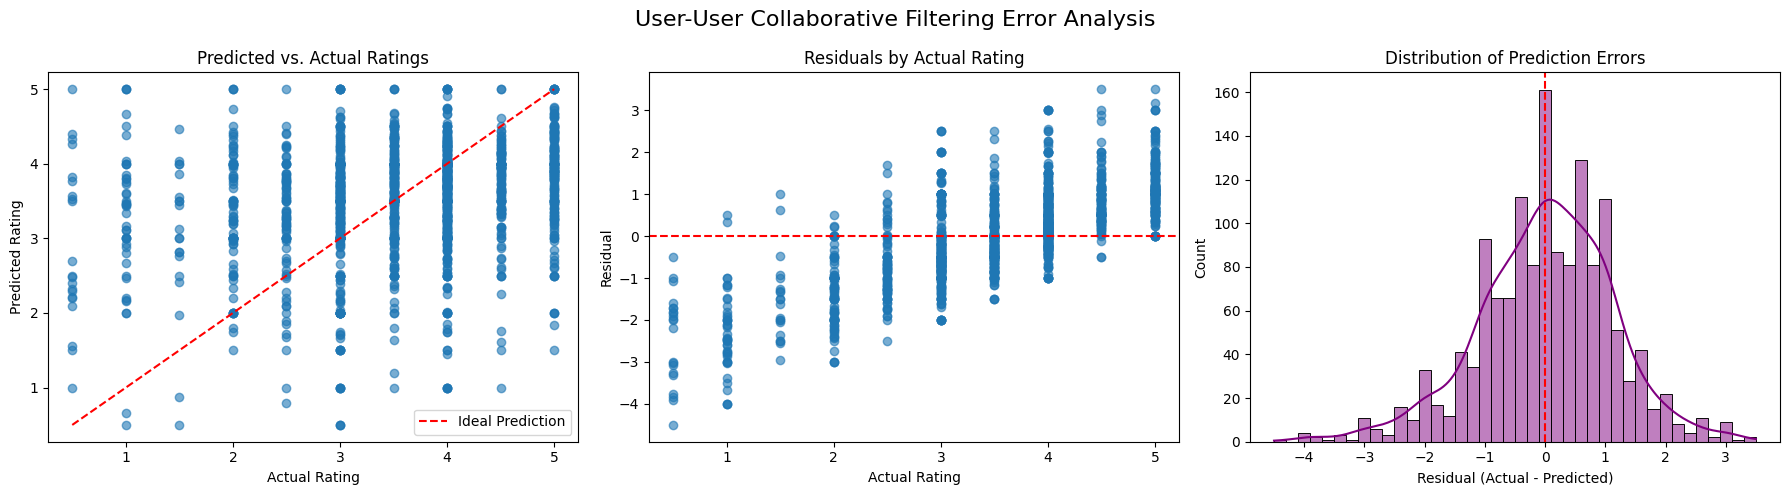

In [ ]:
# Re-import after kernel reset
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Load datasets
movies = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/movies_subset.csv")
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_sampled.csv")

# Step 2: Prepare genre TF-IDF matrix
movies['genres'] = movies['genres'].fillna('')
tfidf = TfidfVectorizer(tokenizer=lambda x: x.split('|'))
tfidf_matrix = tfidf.fit_transform(movies['genres'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=movies['movieId'], columns=tfidf.get_feature_names_out())

# Step 3: Train-test split and user-movie matrix
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
movie_means = train_ratings.groupby('movieId')['rating'].mean()

# Step 4: Create user TF-IDF profiles
def build_user_tfidf_profile(user_id):
    if user_id not in user_movie_matrix.index:
        return None
    rated_movies = user_movie_matrix.loc[user_id].dropna()
    if rated_movies.empty:
        return None
    tfidf_subset = tfidf_df.loc[rated_movies.index.intersection(tfidf_df.index)]
    if tfidf_subset.empty:
        return None
    ratings_vector = rated_movies.loc[tfidf_subset.index].values.reshape(-1, 1)
    weighted_profile = np.dot(ratings_vector.T, tfidf_subset.values) / ratings_vector.sum()
    return weighted_profile.flatten()

user_profiles = {}
for user_id in user_movie_matrix.index:
    profile = build_user_tfidf_profile(user_id)
    if profile is not None:
        user_profiles[user_id] = profile
user_profile_df = pd.DataFrame(user_profiles).T

# Step 5: Compute cosine similarity between users
user_sim_matrix = cosine_similarity(user_profile_df)
user_sim_df = pd.DataFrame(user_sim_matrix, index=user_profile_df.index, columns=user_profile_df.index)

# Step 6: Fallback tracker
fallback_counter = {'no_sim_users': 0, 'no_rating': 0, 'success': 0}

# Step 7: Prediction function
def predict_user_based_tfidf(user_id, movie_id, top_k=20):
    if user_id not in user_sim_df.index or movie_id not in user_movie_matrix.columns:
        fallback_counter['no_rating'] += 1
        return movie_means.get(movie_id, global_mean)

    sim_users = user_sim_df.loc[user_id].sort_values(ascending=False).drop(user_id, errors='ignore')
    sim_users = sim_users[sim_users > 0]

    if sim_users.empty:
        fallback_counter['no_sim_users'] += 1
        return movie_means.get(movie_id, global_mean)

    neighbors = sim_users.index
    neighbor_ratings = user_movie_matrix.loc[user_movie_matrix.index.intersection(neighbors), movie_id].dropna()

    if neighbor_ratings.empty:
        fallback_counter['no_rating'] += 1
        return movie_means.get(movie_id, global_mean)

    top_users = neighbor_ratings.index
    sims = sim_users.loc[top_users].values
    ratings = neighbor_ratings.loc[top_users].values

    weighted_sum = np.dot(sims, ratings)
    norm_factor = np.sum(np.abs(sims))

    if norm_factor == 0:
        return movie_means.get(movie_id, global_mean)

    prediction = weighted_sum / norm_factor
    fallback_counter['success'] += 1
    return max(0.5, min(prediction, 5.0))

# Step 8: Evaluation
def evaluate_tfidf_user_model(test_df, filter_strict=True):
    y_true = []
    y_pred = []

    for _, row in test_df.iterrows():
        user_id = int(row['userId'])
        movie_id = int(row['movieId'])

        if filter_strict and (user_id not in user_sim_df.index or movie_id not in user_movie_matrix.columns):
            continue

        true_rating = row['rating']
        pred_rating = predict_user_based_tfidf(user_id, movie_id)
        y_true.append(true_rating)
        y_pred.append(pred_rating)

    if not y_true:
        return "No valid test samples for evaluation."

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "Success": fallback_counter['success'],
        "No Similar Users": fallback_counter['no_sim_users'],
        "No Ratings": fallback_counter['no_rating']
    }

evaluate_tfidf_user_model(test_ratings)

import matplotlib.pyplot as plt
import seaborn as sns

# --- Generate Predictions and Residuals for Visualization ---
y_true, y_pred = [], []
for _, row in test_ratings.iterrows():
    uid, mid, true = row['userId'], row['movieId'], row['rating']
    if uid not in user_sim_df.index or mid not in user_movie_matrix.columns:
        continue
    pred = predict_user_based_tfidf(uid, mid)
    y_true.append(true)
    y_pred.append(pred)

residuals = np.array(y_true) - np.array(y_pred)

# --- Create Faceted Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("User-User Collaborative Filtering Error Analysis", fontsize=16)

# Plot 1: Actual vs Predicted
axes[0].scatter(y_true, y_pred, alpha=0.6)
axes[0].plot([0.5, 5], [0.5, 5], 'r--', label='Ideal Prediction')
axes[0].set_xlabel("Actual Rating")
axes[0].set_ylabel("Predicted Rating")
axes[0].set_title("Predicted vs. Actual Ratings")
axes[0].legend()

# Plot 2: Residuals by Actual Rating
axes[1].scatter(y_true, residuals, alpha=0.6)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel("Actual Rating")
axes[1].set_ylabel("Residual")
axes[1].set_title("Residuals by Actual Rating")

# Plot 3: Histogram of Residuals
sns.histplot(residuals, bins=40, kde=True, ax=axes[2], color='purple')
axes[2].axvline(0, color='red', linestyle='--')
axes[2].set_xlabel("Residual (Actual - Predicted)")
axes[2].set_ylabel("Count")
axes[2].set_title("Distribution of Prediction Errors")

plt.tight_layout()
plt.show()



TF-IDF-Based User-User Collaborative Filtering Performance
RMSE: 1.0251
MAE : 0.8004
R²  : -0.0046


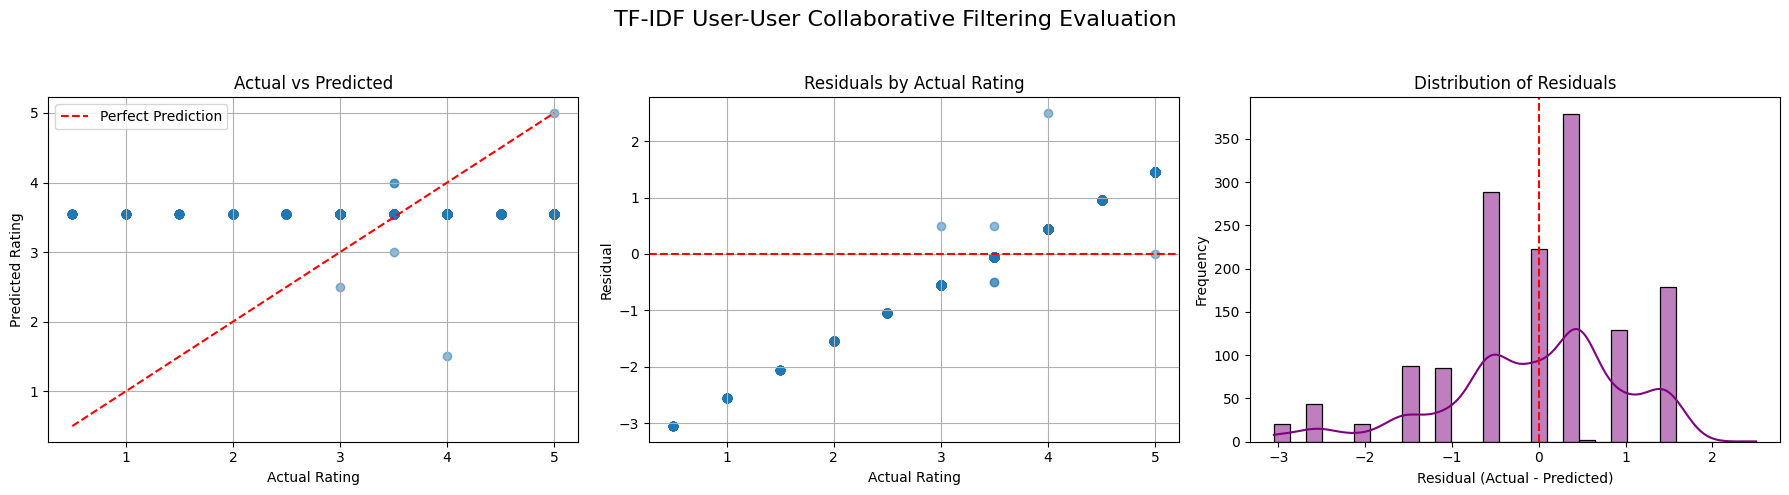

In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Load Data ---
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_sampled.csv")

# --- Step 2: Train/Test Split ---
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)

# --- Step 3: Build User-Movie Term Frequency Matrix ---
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# --- Step 4: Convert to TF-IDF Weighted Matrix ---
tfidf_transformer = TfidfTransformer()
tfidf_matrix = tfidf_transformer.fit_transform(user_movie_matrix.values)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=user_movie_matrix.index, columns=user_movie_matrix.columns)

# --- Step 5: Compute Cosine Similarity ---
user_sim_df = pd.DataFrame(cosine_similarity(tfidf_df),
                           index=user_movie_matrix.index,
                           columns=user_movie_matrix.index)

# --- Step 6: Prediction Function ---
def predict_tfidf_user_user(user_id, movie_id, top_k=20):
    if user_id not in user_sim_df.index or movie_id not in user_movie_matrix.columns:
        return train_ratings['rating'].mean()

    sims = user_sim_df.loc[user_id].drop(user_id, errors='ignore')
    ratings = user_movie_matrix[movie_id]

    valid_neighbors = ratings[ratings > 0].index.intersection(sims.index)
    if len(valid_neighbors) == 0:
        return train_ratings['rating'].mean()

    sims = sims.loc[valid_neighbors]
    ratings = ratings.loc[valid_neighbors]

    if len(sims) > top_k:
        sims = sims.nlargest(top_k)
        ratings = ratings.loc[sims.index]

    weighted_sum = np.dot(sims.values, ratings.values)
    norm = np.abs(sims.values).sum()
    if norm == 0:
        return train_ratings['rating'].mean()

    return max(0.5, min(weighted_sum / norm, 5.0))

# --- Step 7: Evaluate ---
y_true, y_pred = [], []
for _, row in test_ratings.iterrows():
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    if uid not in user_movie_matrix.index or mid not in user_movie_matrix.columns:
        continue
    pred = predict_tfidf_user_user(uid, mid)
    y_true.append(actual)
    y_pred.append(pred)

# --- Step 8: Metrics ---
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
residuals = np.array(y_true) - np.array(y_pred)

print("TF-IDF-Based User-User Collaborative Filtering Performance")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

# --- Step 9: Faceted Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("TF-IDF User-User Collaborative Filtering Evaluation", fontsize=16)

# Plot 1: Actual vs Predicted
axes[0].scatter(y_true, y_pred, alpha=0.5)
axes[0].plot([0.5, 5], [0.5, 5], 'r--', label='Perfect Prediction')
axes[0].set_title("Actual vs Predicted")
axes[0].set_xlabel("Actual Rating")
axes[0].set_ylabel("Predicted Rating")
axes[0].legend()
axes[0].grid(True)

# Plot 2: Residuals by Actual Rating
axes[1].scatter(y_true, residuals, alpha=0.5)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_title("Residuals by Actual Rating")
axes[1].set_xlabel("Actual Rating")
axes[1].set_ylabel("Residual")
axes[1].grid(True)

# Plot 3: Histogram of Residuals
sns.histplot(residuals, bins=30, kde=True, ax=axes[2], color='purple')
axes[2].axvline(0, color='red', linestyle='--')
axes[2].set_title("Distribution of Residuals")
axes[2].set_xlabel("Residual (Actual - Predicted)")
axes[2].set_ylabel("Frequency")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


The visualizations reveal that the TF-IDF-based User-User Collaborative Filtering model exhibits moderate predictive performance with a notable bias:

* **Predicted vs. Actual Ratings**: Predictions tend to cluster around the mean, showing limited range and failing to fully capture the extremes (e.g., very low or very high ratings). The red diagonal line indicates the ideal predictions, which are missed especially at the edges.

* **Residuals by Actual Rating**: There is a clear pattern where lower actual ratings (1–2) are consistently overpredicted, and higher ratings (4–5) are often underpredicted. This reflects a regression-to-the-mean behavior, suggesting the model lacks personalization sharpness.

* **Distribution of Prediction Errors**: The residuals center around 0, but the distribution is slightly left-skewed, confirming the overprediction bias at the low end. The error spread is wide, further indicating limited accuracy for individual predictions.

**Conclusion**: While the model does reasonably well in average performance, its inability to capture rating extremes limits its effectiveness for highly opinionated users or polarizing movies. Incorporating item-based signals or boosting k-nearest filtering could improve results.


## TF

TF-IDF User-User Collaborative Filtering with Bias Adjustment
RMSE: 1.0241
MAE : 0.7993
R²  : -0.0025


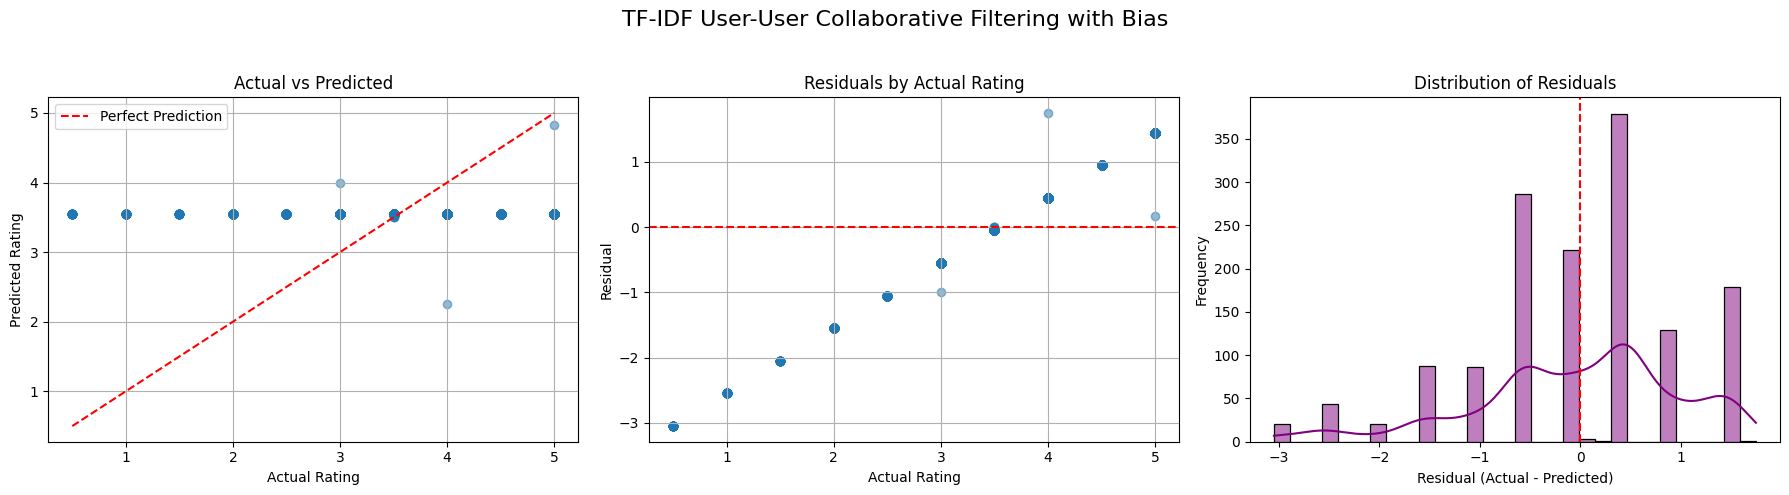

In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Load Data ---
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_sampled.csv")

# --- Step 2: Train/Test Split ---
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)

# --- Step 3: Build User-Movie Term Frequency Matrix ---
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
user_means = user_movie_matrix.mean(axis=1)
global_mean = train_ratings['rating'].mean()
user_movie_matrix = user_movie_matrix.fillna(0)

# --- Step 4: Convert to TF-IDF Weighted Matrix ---
tfidf_transformer = TfidfTransformer()
tfidf_matrix = tfidf_transformer.fit_transform(user_movie_matrix.values)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=user_movie_matrix.index, columns=user_movie_matrix.columns)

# --- Step 5: Compute Cosine Similarity ---
user_sim_df = pd.DataFrame(cosine_similarity(tfidf_df),
                           index=user_movie_matrix.index,
                           columns=user_movie_matrix.index)

# --- Step 6: Prediction Function with Bias Adjustment ---
def predict_tfidf_user_user_with_bias(user_id, movie_id, top_k=20):
    if user_id not in user_sim_df.index or movie_id not in user_movie_matrix.columns:
        return global_mean

    sims = user_sim_df.loc[user_id].drop(user_id, errors='ignore')
    ratings = user_movie_matrix[movie_id]

    valid_neighbors = ratings[ratings > 0].index.intersection(sims.index)
    if len(valid_neighbors) == 0:
        return global_mean

    sims = sims.loc[valid_neighbors]
    ratings = ratings.loc[valid_neighbors]
    neighbor_means = user_means.loc[valid_neighbors]

    if len(sims) > top_k:
        sims = sims.nlargest(top_k)
        ratings = ratings.loc[sims.index]
        neighbor_means = neighbor_means.loc[sims.index]

    rating_diffs = ratings.values - neighbor_means.values
    weighted_sum = np.dot(sims.values, rating_diffs)
    norm = np.abs(sims.values).sum()

    if norm == 0:
        return global_mean

    user_bias = user_means.get(user_id, global_mean)
    pred = user_bias + (weighted_sum / norm)
    return max(0.5, min(pred, 5.0))

# --- Step 7: Evaluate ---
y_true, y_pred = [], []
for _, row in test_ratings.iterrows():
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    if uid not in user_movie_matrix.index or mid not in user_movie_matrix.columns:
        continue
    pred = predict_tfidf_user_user_with_bias(uid, mid)
    y_true.append(actual)
    y_pred.append(pred)

# --- Step 8: Metrics ---
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
residuals = np.array(y_true) - np.array(y_pred)

print("TF-IDF User-User Collaborative Filtering with Bias Adjustment")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

# --- Step 9: Faceted Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("TF-IDF User-User Collaborative Filtering with Bias", fontsize=16)

# Plot 1: Actual vs Predicted
axes[0].scatter(y_true, y_pred, alpha=0.5)
axes[0].plot([0.5, 5], [0.5, 5], 'r--', label='Perfect Prediction')
axes[0].set_title("Actual vs Predicted")
axes[0].set_xlabel("Actual Rating")
axes[0].set_ylabel("Predicted Rating")
axes[0].legend()
axes[0].grid(True)

# Plot 2: Residuals by Actual Rating
axes[1].scatter(y_true, residuals, alpha=0.5)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_title("Residuals by Actual Rating")
axes[1].set_xlabel("Actual Rating")
axes[1].set_ylabel("Residual")
axes[1].grid(True)

# Plot 3: Histogram of Residuals
sns.histplot(residuals, bins=30, kde=True, ax=axes[2], color='purple')
axes[2].axvline(0, color='red', linestyle='--')
axes[2].set_title("Distribution of Residuals")
axes[2].set_xlabel("Residual (Actual - Predicted)")
axes[2].set_ylabel("Frequency")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Jaccard-Based User-User Collaborative Filtering

### Overview

This recommender system builds a user-user collaborative filtering model by measuring **Jaccard similarity** between users based on the items they’ve rated. Unlike cosine similarity, which factors in rating values, **Jaccard similarity only considers binary co-occurrence** (i.e., whether two users have rated the same items). The model integrates a **bias-aware prediction function** to improve rating accuracy by accounting for global, user, and item-level biases.

### Workflow Description

**Step 1: Data Loading**
The system loads the user-movie ratings data from the MovieLens dataset. It calculates the global mean rating and individual movie mean ratings for use in fallback scenarios.

**Step 2: Matrix Construction**
The user-movie matrix is constructed via a pivot table. Each row represents a user, each column a movie, and each cell the corresponding rating.

**Step 3: Jaccard Similarity Matrix**
The Jaccard similarity between every user pair is computed based on binary presence of ratings (i.e., did both users rate the same movies?).
If a precomputed similarity matrix is provided via a Google Drive link, the system downloads and loads it to avoid recomputation.

**Step 4: Fallback Tracker**
A fallback counter is initialized to track how often predictions rely on global or item-level means due to lack of neighbor information.

**Step 5: Bias-Aware Prediction Function**
To predict a rating for a given user-movie pair:

* The model identifies the top-k most similar users who have rated the target movie.
* Each neighbor’s mean rating is subtracted from their rating for the movie to center it.
* A weighted average of these adjusted ratings is calculated using Jaccard similarity scores.
* The final prediction incorporates:

  * **Global mean rating**
  * **User bias**: how the user's average rating deviates from the global mean
  * **Item bias**: how the item's average rating deviates from the global mean
  * **Neighborhood adjustment** from similar users

**Step 6: Evaluation**
The model is evaluated against a test set using standard metrics:

* RMSE (Root Mean Squared Error)
* MAE (Mean Absolute Error)
* R² (Coefficient of Determination)

**Step 7–8: Reporting**
Evaluation results are printed, followed by fallback breakdown:

* How many predictions were made using collaborative logic
* How many relied on fallback mechanisms due to missing ratings or similar users

### Merits of This Approach

* **Simplicity & Interpretability**: Jaccard similarity is easy to interpret, capturing pure overlap without requiring numerical ratings.
* **Bias Handling**: By explicitly incorporating user and item bias, the model avoids common pitfalls of over- or under-predicting due to personal or item-based tendencies.
* **Cold-Start Ready**: If no similar users or ratings are found, the model gracefully falls back to average values, maintaining robustness.
* **No Rating Values Needed for Similarity**: The model can function effectively even with just rating presence data (e.g., implicit feedback scenarios).
* **Complementary with Other Models**: This approach can be used alongside cosine-based or TF-IDF models in an ensemble setup for improved performance.


Ratings data loaded successfully.
Jaccard similarity matrix loaded successfully.

Jaccard-Based User-User CF with User & Item Bias
RMSE: 1.2267
MAE : 0.9389
R²  : -0.3840


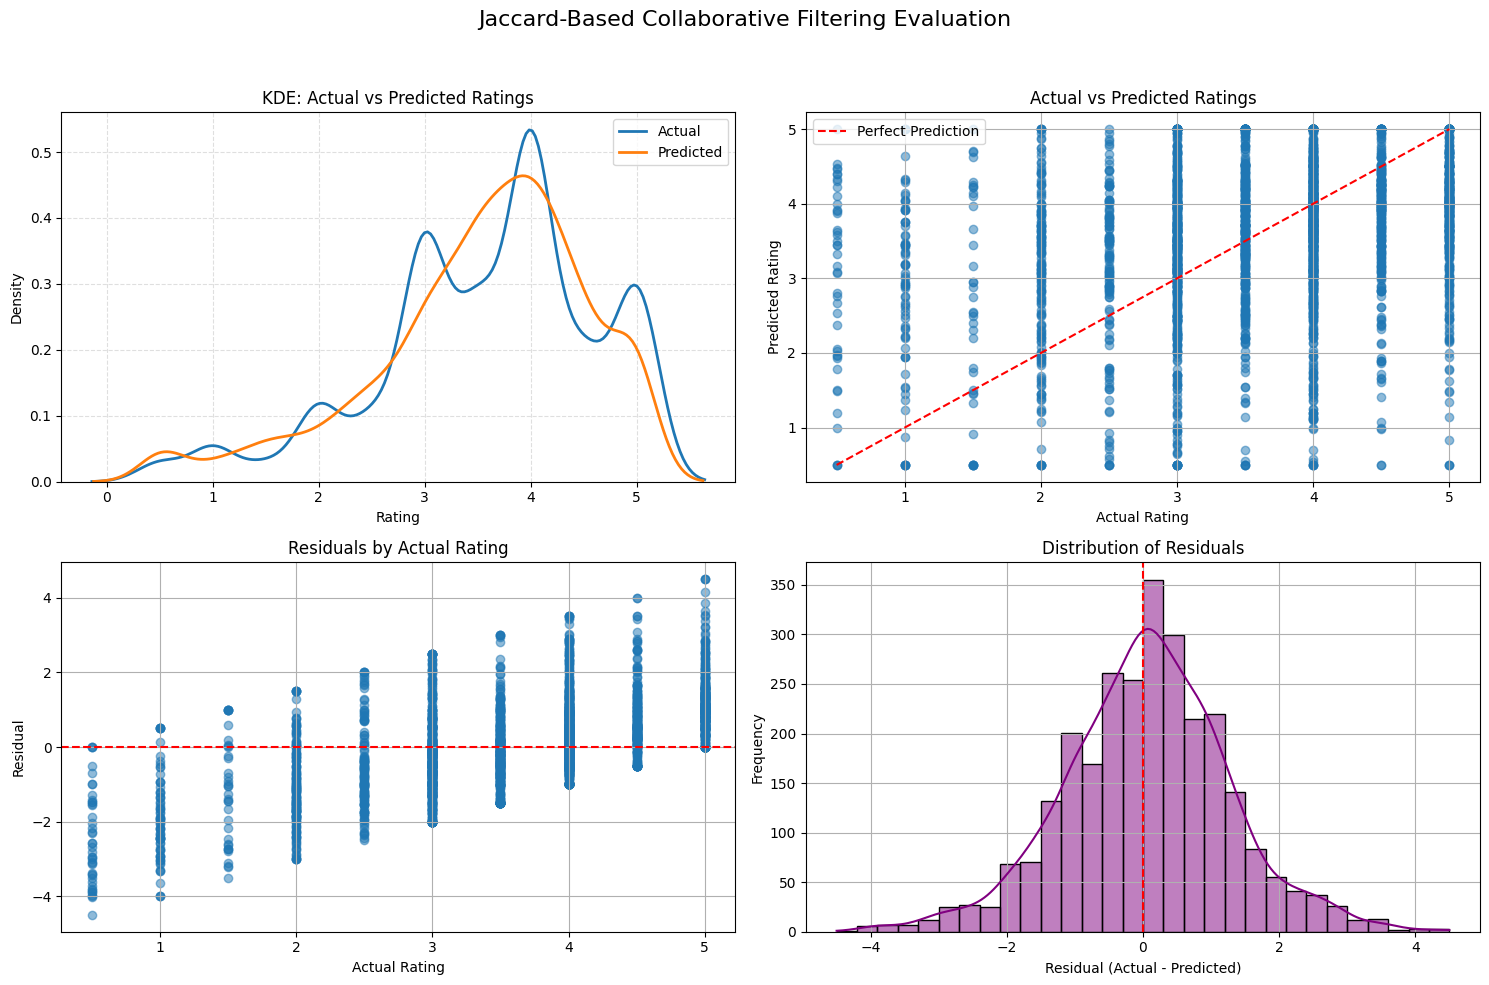


Prediction Source Breakdown
Predictions using neighbors: 2770
Fallback (no similar users): 0
Fallback (no ratings from neighbors): 0


In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import os
import gdown
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load ratings data
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_sampled.csv")
print("Ratings data loaded successfully.")

# Step 2: Split ratings
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
movie_means = train_ratings.groupby('movieId')['rating'].mean()
user_means = train_ratings.groupby('userId')['rating'].mean()

# Step 3: Load Jaccard user similarity matrix from Google Drive
jaccard_sim_local = "jaccard_user_similarity_sampled.csv"
jaccard_drive_id = "1zNbErjNpko2MoPtEbqi52cAbMJxyzrP2"
jaccard_drive_url = f"https://drive.google.com/uc?id={jaccard_drive_id}"

try:
    if not os.path.exists(jaccard_sim_local):
        print("Downloading Jaccard similarity matrix from Google Drive...")
        gdown.download(jaccard_drive_url, jaccard_sim_local, quiet=False)

    user_sim_df = pd.read_csv(jaccard_sim_local, index_col=0)
    user_sim_df.columns = user_sim_df.columns.astype(int)
    user_sim_df.index = user_sim_df.index.astype(int)
    print("Jaccard similarity matrix loaded successfully.")
except Exception as e:
    print("Download failed or file corrupt. Please verify the link or download manually.")
    raise e

# Step 4: Fallback counter
fallback_counter = {'no_sim_users': 0, 'no_rating': 0, 'success': 0}

# Step 5: Prediction function (Bias-Aware with Item Bias)
def predict_user_based(user_id, movie_id, top_k=20):
    if user_id not in user_sim_df.index or movie_id not in user_movie_matrix.columns:
        fallback_counter['no_rating'] += 1
        return movie_means.get(movie_id, global_mean)

    sim_users = user_sim_df.loc[user_id].sort_values(ascending=False).drop(user_id, errors='ignore')
    sim_users = sim_users[sim_users > 0]

    if sim_users.empty:
        fallback_counter['no_sim_users'] += 1
        return movie_means.get(movie_id, global_mean)

    neighbors = sim_users.index
    neighbor_ratings = user_movie_matrix.loc[user_movie_matrix.index.intersection(neighbors), movie_id].dropna()

    if neighbor_ratings.empty:
        fallback_counter['no_rating'] += 1
        return movie_means.get(movie_id, global_mean)

    top_users = neighbor_ratings.index
    sims = sim_users.loc[top_users].values
    ratings = neighbor_ratings.loc[top_users].values
    neighbor_means = user_movie_matrix.loc[top_users].mean(axis=1).values
    rating_diffs = ratings - neighbor_means

    weighted_sum = np.dot(sims, rating_diffs)
    norm_factor = np.sum(np.abs(sims))

    if norm_factor == 0:
        return movie_means.get(movie_id, global_mean)

    bu = user_means.get(user_id, global_mean) - global_mean
    bi = movie_means.get(movie_id, global_mean) - global_mean
    prediction = global_mean + bu + bi + (weighted_sum / norm_factor)

    fallback_counter['success'] += 1
    return max(0.5, min(prediction, 5.0))

# Step 6: Evaluation + Visuals
def evaluate_user_model(test_df, filter_strict=True):
    y_true, y_pred = [], []

    for _, row in test_df.iterrows():
        user_id = int(row['userId'])
        movie_id = int(row['movieId'])

        if filter_strict:
            if user_id not in user_sim_df.index or movie_id not in user_movie_matrix.columns:
                continue

        true_rating = row['rating']
        pred_rating = predict_user_based(user_id, movie_id)
        y_true.append(true_rating)
        y_pred.append(pred_rating)

    if not y_true:
        print("No valid test samples for evaluation.")
        return

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    residuals = np.array(y_true) - np.array(y_pred)

    print("\nJaccard-Based User-User CF with User & Item Bias")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

    # --- Visualizations ---
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle("Jaccard-Based Collaborative Filtering Evaluation", fontsize=16)

    # KDE Plot
    sns.kdeplot(y_true, label='Actual', ax=axes[0, 0], linewidth=2)
    sns.kdeplot(y_pred, label='Predicted', ax=axes[0, 0], linewidth=2)
    axes[0, 0].set_title("KDE: Actual vs Predicted Ratings")
    axes[0, 0].set_xlabel("Rating")
    axes[0, 0].set_ylabel("Density")
    axes[0, 0].legend()
    axes[0, 0].grid(True, linestyle='--', alpha=0.4)

    # Scatter: Actual vs Predicted
    axes[0, 1].scatter(y_true, y_pred, alpha=0.5)
    axes[0, 1].plot([0.5, 5], [0.5, 5], 'r--', label='Perfect Prediction')
    axes[0, 1].set_title("Actual vs Predicted Ratings")
    axes[0, 1].set_xlabel("Actual Rating")
    axes[0, 1].set_ylabel("Predicted Rating")
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Residuals vs Actual
    axes[1, 0].scatter(y_true, residuals, alpha=0.5)
    axes[1, 0].axhline(0, color='red', linestyle='--')
    axes[1, 0].set_title("Residuals by Actual Rating")
    axes[1, 0].set_xlabel("Actual Rating")
    axes[1, 0].set_ylabel("Residual")
    axes[1, 0].grid(True)

    # Residual Histogram
    sns.histplot(residuals, bins=30, kde=True, ax=axes[1, 1], color='purple')
    axes[1, 1].axvline(0, color='red', linestyle='--')
    axes[1, 1].set_title("Distribution of Residuals")
    axes[1, 1].set_xlabel("Residual (Actual - Predicted)")
    axes[1, 1].set_ylabel("Frequency")
    axes[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Step 7: Run evaluation
evaluate_user_model(test_ratings)

# Step 8: Print fallback summary
print("\nPrediction Source Breakdown")
print(f"Predictions using neighbors: {fallback_counter['success']}")
print(f"Fallback (no similar users): {fallback_counter['no_sim_users']}")
print(f"Fallback (no ratings from neighbors): {fallback_counter['no_rating']}")


# Item-Item Collaborative Filtering

## Cosine-Based Item-Item Collaborative Filtering

### Overview

This recommender system builds an **item-item collaborative filtering model** by measuring **cosine similarity between items** based on how users rate them. It predicts how much a user will like a particular movie by analyzing **ratings from the same user on similar items**, weighted by similarity scores. The model also incorporates a **bias-aware prediction function** to improve accuracy by adjusting for global, user, and item-specific rating tendencies.

### Workflow Description

**Step 1: Data Loading**
The system loads the MovieLens user-movie ratings dataset and calculates:

* The **global average rating**
* **Per-movie average ratings** (item bias)
* **Per-user average ratings** (user bias)

These statistics serve as fallbacks when neighborhood information is insufficient.

**Step 2: Matrix Construction**
A user-movie matrix is created using a pivot table, where:

* Rows represent users
* Columns represent movies
* Cell values are the ratings provided

**Step 3: Cosine Similarity Matrix (Item-Based)**
A cosine similarity matrix is computed between movies (items) based on user ratings.

* Each movie is represented by a vector of user ratings.
* Cosine similarity measures how similarly users rate each pair of movies.
* If a precomputed matrix is provided via a Google Drive link, it is downloaded to save time.

**Step 4: Fallback Tracker**
A dictionary is initialized to keep track of fallback cases:

* No similar items found
* User has no prior ratings
* Successful predictions made using neighbors

**Step 5: Bias-Aware Prediction Function**
To predict a rating for a (user, movie) pair:

* The model identifies items that the user has already rated.
* It then retrieves cosine similarities between those items and the target movie.
* Using the **top-k most similar items** that the user rated:

  * A **weighted average of their adjusted ratings** is computed.
  * Adjustments are made by removing each item’s bias (how it deviates from global mean).
* The final prediction is the sum of:

  * Global average
  * User bias
  * Item bias
  * Weighted contribution from the neighborhood

**Step 6: Evaluation**
The model is evaluated using a held-out test set with standard metrics:

* RMSE (Root Mean Squared Error)
* MAE (Mean Absolute Error)
* R² (Coefficient of Determination)

**Step 7–8: Reporting**
The script prints:

* The performance scores (RMSE, MAE, R²)
* A summary of how often fallback logic was triggered

### Merits of This Approach

* **Interpretability**: Cosine similarity captures how similarly users rate pairs of items, making the model transparent and explainable.
* **Personalized to User Behavior**: Recommendations are grounded in the user’s individual rating history.
* **Bias Correction**: Incorporates global, user, and item-level biases for more realistic predictions.
* **Resilient to Sparsity**: Even with a sparse rating matrix, predictions are possible using fallback to movie or global averages.
* **Scalable**: Precomputing the item-item similarity matrix makes prediction fast and scalable at runtime.
* **Cold-Start Friendly (Partially)**: Works better for new users than new items, especially when they’ve rated just a few movies.


In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import os
import gdown
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Load ratings data
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_sampled.csv")
print("Ratings data loaded successfully.")

# Step 2: Train-test split
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
movie_means = train_ratings.groupby('movieId')['rating'].mean()
user_means = user_movie_matrix.mean(axis=1)

# Step 3: Load item-item similarity matrix from Google Drive
item_sim_file_local = "item_similarity_matrix.csv"
item_sim_drive_id = "1zNbErjNpko2MoPtEbqi52cAbMJxyzrP2"
item_sim_drive_url = f"https://drive.google.com/uc?id={item_sim_drive_id}"

if not os.path.exists(item_sim_file_local):
    print("Downloading item similarity matrix...")
    gdown.download(item_sim_drive_url, item_sim_file_local, quiet=False)

item_sim_df = pd.read_csv(item_sim_file_local, index_col=0)
item_sim_df.columns = item_sim_df.columns.astype(str)
item_sim_df.index = item_sim_df.index.astype(str)
print("Item similarity matrix loaded.")

# Step 4: Fallback counter
fallback_counter = {'no_sim_items': 0, 'no_rating': 0, 'success': 0}

# Step 5: Bias-aware prediction function
def predict_item_based(user_id, movie_id, top_k=20):
    movie_id = str(movie_id)
    if user_id not in user_movie_matrix.index or movie_id not in item_sim_df.columns:
        fallback_counter['no_rating'] += 1
        return movie_means.get(int(movie_id), global_mean)

    user_ratings = user_movie_matrix.loc[user_id].dropna()
    rated_movie_ids = user_ratings.index.astype(str)
    similarities = item_sim_df.loc[movie_id, rated_movie_ids].dropna()
    similarities = similarities[similarities > 0]

    if similarities.empty:
        fallback_counter['no_sim_items'] += 1
        return movie_means.get(int(movie_id), global_mean)

    top_items = similarities.sort_values(ascending=False).head(top_k)
    sims = top_items.values
    ratings = user_ratings.loc[top_items.index.astype(int)].values
    item_bias = movie_means.loc[top_items.index.astype(int)].values - global_mean
    adjusted_ratings = ratings - item_bias

    weighted_sum = np.dot(sims, adjusted_ratings)
    norm_factor = np.sum(np.abs(sims))

    if norm_factor == 0:
        return movie_means.get(int(movie_id), global_mean)

    bu = user_means.get(user_id, global_mean) - global_mean
    bi = movie_means.get(int(movie_id), global_mean) - global_mean
    prediction = global_mean + bu + bi + (weighted_sum / norm_factor)

    fallback_counter['success'] += 1
    return max(0.5, min(prediction, 5.0))

# Step 6: Evaluate the model
def evaluate_item_model(test_df, filter_strict=True):
    y_true = []
    y_pred = []

    for _, row in test_df.iterrows():
        user_id = int(row['userId'])
        movie_id = int(row['movieId'])

        if filter_strict and (str(movie_id) not in item_sim_df.columns or user_id not in user_movie_matrix.index):
            continue

        true_rating = row['rating']
        pred_rating = predict_item_based(user_id, movie_id)
        y_true.append(true_rating)
        y_pred.append(pred_rating)

    if not y_true:
        print("No valid test samples.")
        return

    print("\nItem-Based Collaborative Filtering with Bias Adjustment")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"MAE : {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"R²  : {r2_score(y_true, y_pred):.4f}")

# Step 7: Run evaluation
evaluate_item_model(test_ratings)

# Step 8: Print fallback summary
print("\nPrediction Source Breakdown")
print(f"Predictions using neighbors: {fallback_counter['success']}")
print(f"Fallback (no similar items): {fallback_counter['no_sim_items']}")
print(f"Fallback (no ratings from user): {fallback_counter['no_rating']}")


Ratings data loaded successfully.


Downloading...
From (original): https://drive.google.com/uc?id=1zNbErjNpko2MoPtEbqi52cAbMJxyzrP2
From (redirected): https://drive.google.com/uc?id=1zNbErjNpko2MoPtEbqi52cAbMJxyzrP2&confirm=t&uuid=69d2924a-46e5-45bc-91fc-f0395e27ac24
To: /content/item_similarity_matrix.csv
100%|██████████| 401M/401M [00:13<00:00, 29.4MB/s]


Item similarity matrix loaded.


KeyError: "None of [Index(['1', '605'], dtype='object', name='movieId')] are in the [index]"

# 3. Content-Based Filtering Using Genre Vectors and Cosine Similarity

This code implements a **content-based recommender system** using movie genres. Each movie is represented as a binary (multi-hot) vector based on its associated genres (e.g., Action, Comedy, Drama). The steps include:

* Normalizing the genre vectors using **L2 norm** so that each vector has unit length.
* Calculating **cosine similarity** between movie vectors to measure how similar their genre compositions are.
* Creating a function that, given a movie title, returns the top-N most similar movies (excluding itself) based purely on genre similarity.

This technique does not rely on user ratings — instead, it recommends items that are similar in content (genre) to a given movie.

This code implements a **non-personalized content-based recommender system** using only movie genres. It does **not use user ratings or preferences**. Instead, it recommends movies that are **similar in genre** to a specified movie.

#### How It Works:

* Each movie is represented as a binary (multi-hot encoded) vector across genres (e.g., Action, Comedy, Drama).
* These vectors are **L2-normalized** so that all movies lie on a unit hypersphere — making **cosine similarity** an effective way to measure closeness.
* Given a movie title, the model:

  * Finds its genre vector.
  * Computes cosine similarity to all other movies.
  * Returns the top-N most similar movies (excluding itself).

#### What It Does Not Do:

* It does **not use any user data** (no `userId`, no ratings).
* There is **no personalization**. All users will get the same recommendations for a given movie.

#### Best Use Case:

This type of model is ideal when:

* You have **no user data** (cold start).
* You want to recommend movies **based on content alone** (e.g., genre-based similarity).
* You’re building a basic recommender system that can later be enhanced with collaborative filtering or hybrid techniques.




In [ ]:
# --- Imports ---
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import random

# --- Step 1: Use unique movies for similarity computation ---
unique_movies = movies.copy().reset_index(drop=True)

# --- Step 2: Normalize genre matrix ---
genre_cols = all_genres  # Assumes 'all_genres' is your list of genre columns
genre_matrix = unique_movies[genre_cols].values
genre_matrix_normalized = normalize(genre_matrix, norm='l2')

# --- Step 3: Create title-to-index mapping ---
movie_idx = pd.Series(unique_movies.index, index=unique_movies['title']).drop_duplicates()

# --- Step 4: Recommendation Function Based on Genre Similarity ---
def get_recommendations(title, topN=20):
    if title not in movie_idx:
        return f"Movie '{title}' not found in dataset."

    idx = movie_idx[title]
    query_vector = genre_matrix_normalized[idx].reshape(1, -1)
    sim_scores = cosine_similarity(query_vector, genre_matrix_normalized)[0]

    # Rank and filter out the movie itself
    sim_scores = list(enumerate(sim_scores))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:topN+1]

    # Output as list of (title, similarity score)
    recommendations = [(unique_movies['title'][i], score) for i, score in sim_scores]
    return recommendations

# --- Step 5: Use Fixed Target Movie ---
target_title = 'O.J.: Made in America (2016)'

# Print explanation
print("\nContent-based Recommendations using GENRE similarity (cosine distance):")

# Run recommendation
if target_title in movie_idx:
    print(f"\nTop 20 Movies Most Similar in Genre to '{target_title}':")
    for title, sim in get_recommendations(target_title):
        print(f"{title:<45} Similarity: {sim:.4f}")
else:
    print(f"Movie '{target_title}' not found in the dataset.")



Content-based Recommendations using GENRE similarity (cosine distance):

Top 20 Movies Most Similar in Genre to 'O.J.: Made in America (2016)':
Catwalk (1996)                                Similarity: 1.0000
Anne Frank Remembered (1995)                  Similarity: 1.0000
Man of the Year (1995)                        Similarity: 1.0000
Crumb (1994)                                  Similarity: 1.0000
Unzipped (1995)                               Similarity: 1.0000
Hoop Dreams (1994)                            Similarity: 1.0000
Wonderful, Horrible Life of Leni Riefenstahl, The (Macht der Bilder: Leni Riefenstahl, Die) (1993) Similarity: 1.0000
War Room, The (1993)                          Similarity: 1.0000
Celluloid Closet, The (1995)                  Similarity: 1.0000
Haunted World of Edward D. Wood Jr., The (1996) Similarity: 1.0000
Maya Lin: A Strong Clear Vision (1994)        Similarity: 1.0000
Synthetic Pleasures (1995)                    Similarity: 1.0000
Microcosmos (Microco

In [ ]:
# Imports tools for normalizing feature vectors and computing similarity between them.
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import random

# Use only unique movie rows for similarity matrix
# Copies the movies DataFrame and resets the index to ensure each movie is uniquely indexed.
unique_movies = movies.copy().reset_index(drop=True)

# Normalize genre matrix
# Extracts the genre vectors for each movie (multi-hot encoded).
# Applies L2 normalization so that all genre vectors have a length of 1 (helps with cosine similarity).
genre_cols = all_genres
genre_matrix = unique_movies[genre_cols].values
genre_matrix_normalized = normalize(genre_matrix, norm='l2')

# Create title-to-index map for unique movies
# Creates a dictionary-like mapping from movie titles to their corresponding row index — used to look up vector positions.
movie_idx = pd.Series(unique_movies.index, index=unique_movies['title']).drop_duplicates()

# Define function to get recommendations
# Defines a function that takes a movie title and returns the top N most similar movies.
def get_recommendations(title, topN=20):
    if title not in movie_idx:
        return f"Movie '{title}' not found in dataset."

    idx = movie_idx[title]
    query_vector = genre_matrix_normalized[idx].reshape(1, -1)
    sim_scores = cosine_similarity(query_vector, genre_matrix_normalized)[0]

    # Enumerate and sort scores, excluding the movie itself
    sim_scores = list(enumerate(sim_scores))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:topN+1]

    # Format output: list of (title, similarity) tuples
    recommendations = [(unique_movies['title'][i], score) for i, score in sim_scores]
    return recommendations


# Sample 20 titles
print("Available sample titles:")
print(unique_movies['title'].sample(20, random_state=41).to_list())

# Randomly select a movie title from the available titles
random_title = random.choice(unique_movies['title'].to_list())

print(f"\n Randomly selected movie for recommendation: '{random_title}'")

# Explanation
print("\n Content-based Recommendations are based on GENRE similarity using cosine similarity between genre vectors.")

# Get recommendations
print(f"\nTop 20 Movies Most Similar in Genre to '{random_title}':")
for title, sim in get_recommendations(random_title):
    print(f"{title:<45} Similarity: {sim:.4f}")






Available sample titles:
['Atomica (2017)', 'Adventures in Babysitting (1987)', 'Big Picture, The (1989)', 'Annabelle (2014)', 'Beau Is Afraid (2023)', 'First Blood (Rambo: First Blood) (1982)', 'The Meg (2018)', 'Little Nemo: Adventures in Slumberland (1992)', 'Amen. (2002)', 'Danger: Diabolik (Diabolik) (1968)', 'Bugsy Malone (1976)', 'The Good Dinosaur (2015)', 'Goofy Movie, A (1995)', 'Man Called Horse, A (1970)', 'Terms and Conditions May Apply (2013)', 'StageFright: Aquarius (1987)', 'Shanghai Dreams (Qing hong) (2005)', 'I, Daniel Blake (2016)', "Amores Perros (Love's a Bitch) (2000)", "Cookie's Fortune (1999)"]

 Randomly selected movie for recommendation: 'Brave One, The (2007)'

 Content-based Recommendations are based on GENRE similarity using cosine similarity between genre vectors.

Top 20 Movies Most Similar in Genre to 'Brave One, The (2007)':
Amateur (1994)                                Similarity: 1.0000
Kiss of Death (1995)                          Similarity: 1.0000

# Hybrid Content-Based Rating Prediction Using Genre Similarity, User Behavior, and Fallback Handling

This code demonstrates a *hybrid recommendation system* that combines **content-based filtering using genre similarity** with **collaborative filtering using user-specific ratings**. The objective is to predict how much a user will like a movie they've never seen, based on the genres of that movie and their past rating behavior.

The prediction process incorporates a **fallback mechanism** and **debug printouts** to gracefully handle edge cases where standard hybrid predictions aren’t possible. These cases include users with no rating history, movies not present in the similarity matrix, or when no meaningful similarity is found.

#### How it Works:

1. **Genre Vector Normalization**:

   * The genre columns are multi-hot encoded (e.g., Action, Comedy, etc.).
   * Each movie’s genre vector is normalized using L2 norm so that cosine similarity is well-defined and scale-invariant.

2. **Genre-Based Similarity Matrix**:

   * Cosine similarity is computed between all pairs of movies based on genre vectors.

3. **Mapping Setup**:

   * The code builds lookup maps between `movieId` and its corresponding row index in the genre matrix to allow fast access.

4. **Hybrid Prediction Function**:

   * For a given `user_id` and `movie_id`, the function:

     * Retrieves all movies rated by the user.
     * Finds the top-K rated movies that are most genre-similar to the target movie.
     * Computes a **weighted average of the ratings**, where the weights are the genre similarity scores.
     * **If no such ratings or similarities are available**, the function **falls back to the global average rating of the movie**.
     * Each fallback trigger is logged with a `[Debug]` message.

5. **Application**:

   * The model is tested on a sample user and generates predicted ratings for movies that are most similar in genre to a reference movie (e.g., *Heat (1995)*).

This hybrid approach offers:

* Personalization from collaborative filtering.
* Interpretability from content-based features (genres).
* Robustness from fallback logic to handle cold-starts or sparse data situations.


In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import MultiLabelBinarizer, normalize
from sklearn.metrics.pairwise import cosine_similarity

# --- Step 1: Keep All Ratings (No User Filtering) ---
ratings_filtered = ratings.copy()

# Build user-movie matrix
user_movie_matrix = ratings_filtered.pivot(index='userId', columns='movieId', values='rating')

# --- Step 2: Prepare Genre Matrix ---
# Convert genre strings to lists
movies['genres'] = movies['genres'].apply(lambda x: x.split('|') if isinstance(x, str) else [])

# Filter only movies present in ratings
valid_movie_ids = user_movie_matrix.columns
movies_filtered = movies[movies['movieId'].isin(valid_movie_ids)].copy()

# One-hot encode genres
mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(movies_filtered['genres'])
genre_matrix_normalized = normalize(genre_matrix, norm='l2')

# Create mappings
unique_movies = movies_filtered.reset_index(drop=True)
movieId_to_index = dict(zip(unique_movies['movieId'], unique_movies.index))
index_to_movieId = dict(zip(unique_movies.index, unique_movies['movieId']))
movie_idx = pd.Series(unique_movies.index, index=unique_movies['title']).drop_duplicates()

# --- Step 3: Compute Cosine Similarity Between Genre Vectors ---
genre_sim_matrix = cosine_similarity(genre_matrix_normalized)

# --- Step 4: Hybrid Prediction Function with Fallbacks and Recommendation Message ---
def predict_rating_genre_weighted(user_id, target_movie_id, k=10):
    if user_id not in user_movie_matrix.index or target_movie_id not in movieId_to_index:
        print(f"[Debug] Invalid user_id {user_id} or movie_id {target_movie_id}. Returning NaN.")
        return np.nan

    user_ratings = user_movie_matrix.loc[user_id].dropna()
    if user_ratings.empty:
        print(f"[Fallback] User {user_id} has no ratings. Using global average for movieId {target_movie_id}.")
        pred = ratings_filtered[ratings_filtered['movieId'] == target_movie_id]['rating'].mean()
        print(f"[Recommendation] Predicted Rating: {pred:.2f} → {'Recommend' if pred >= 3.5 else 'Not Recommended'}")
        return pred

    target_idx = movieId_to_index[target_movie_id]
    rated_movie_indices = [movieId_to_index[mid] for mid in user_ratings.index if mid in movieId_to_index]

    if not rated_movie_indices:
        print(f"[Fallback] Rated movies not found for user {user_id}. Using global average.")
        pred = ratings_filtered[ratings_filtered['movieId'] == target_movie_id]['rating'].mean()
        print(f"[Recommendation] Predicted Rating: {pred:.2f} → {'Recommend' if pred >= 3.5 else 'Not Recommended'}")
        return pred

    sims = genre_sim_matrix[target_idx, rated_movie_indices]
    sims_series = pd.Series(sims, index=[index_to_movieId[i] for i in rated_movie_indices])

    top_similar = sims_series.sort_values(ascending=False).head(k)
    top_ratings = user_ratings[top_similar.index]

    # Debug logs for inspection
    print(f"\n[Debug] Similarity Weights for User {user_id} on Target Movie {target_movie_id}:")
    print(top_similar)
    print("[Debug] Corresponding Ratings:")
    print(top_ratings)

    weighted_sum = np.dot(top_similar.values, top_ratings.values)
    normalization = np.sum(top_similar.values)

    if normalization > 0:
        pred = weighted_sum / normalization
        print(f"[Prediction] Personalized prediction used for user {user_id} on movieId {target_movie_id}.")
        print(f"[Recommendation] Predicted Rating: {pred:.2f} → {'Recommend' if pred >= 3.5 else 'Not Recommended'}")
        return pred
    else:
        print(f"[Fallback] No similarity weights found. Using global average for movieId {target_movie_id}.")
        pred = ratings_filtered[ratings_filtered['movieId'] == target_movie_id]['rating'].mean()
        print(f"[Recommendation] Predicted Rating: {pred:.2f} → {'Recommend' if pred >= 3.5 else 'Not Recommended'}")
        return pred

# --- Step 5: Run with Fixed User and Movie ---

# Set static user and movie
user_id = 174949
target_movie = 'O.J.: Made in America (2016)'

print(f"Using user {user_id} for prediction.")
print(f"Target movie exists: '{target_movie}' →", target_movie in movie_idx)

if target_movie in movie_idx:
    idx = movie_idx[target_movie]
    sim_scores = cosine_similarity(genre_matrix_normalized[idx].reshape(1, -1), genre_matrix_normalized)[0]
    sim_indices = np.argsort(sim_scores)[::-1][1:11]  # Exclude the movie itself

    top_similar_movie_ids = unique_movies.loc[sim_indices, 'movieId']
    top_similar_titles = unique_movies.loc[sim_indices, 'title']

    print(f"\nTop 10 Genre-Similar Movies to '{target_movie}':")
    print(top_similar_titles)

    print(f"\nPredicted Ratings for User {user_id} Using Hybrid Genre-Based Model:\n")
    for movie_id, title in zip(top_similar_movie_ids, top_similar_titles):
        pred = predict_rating_genre_weighted(user_id=user_id, target_movie_id=movie_id, k=100)
        print(f"{title:<45} Predicted Rating: {pred:.2f}")
else:
    print("Target movie not found in index.")


Using user 174949 for prediction.
Target movie exists: 'O.J.: Made in America (2016)' → True

Top 10 Genre-Similar Movies to 'O.J.: Made in America (2016)':
11172    Indiana Jones: The Search for the Lost Golden ...
98                                          Catwalk (1996)
104                           Anne Frank Remembered (1995)
118                                 Man of the Year (1995)
139                                           Crumb (1994)
177                                        Unzipped (1995)
213                                     Hoop Dreams (1994)
315      Wonderful, Horrible Life of Leni Riefenstahl, ...
480                                   War Room, The (1993)
496                           Celluloid Closet, The (1995)
Name: title, dtype: object

Predicted Ratings for User 174949 Using Hybrid Genre-Based Model:


[Debug] Similarity Weights for User 174949 on Target Movie 287443:
1207    0.0
2671    0.0
dtype: float64
[Debug] Corresponding Ratings:
1207    5.0
2671    

**Hybrid Recommender: Genre-Weighted Collaborative Filtering**

This code predicts a user's rating for a movie by combining collaborative filtering and genre-based similarity. Here's how it works:

### **Step-by-Step Explanation**

**1. Data Preparation**

* It loads the `ratings` and `movies` datasets.
* The user-movie ratings matrix is built using `.pivot()` (rows = users, columns = movies, values = ratings).
* Movie genres are split and one-hot encoded using `MultiLabelBinarizer`.
* Genre vectors are normalized to enable cosine similarity comparison.

**2. Genre Similarity Calculation**

* Cosine similarity is computed between normalized genre vectors of all movies.
* This generates a matrix showing how similar each pair of movies is based on genre.

**3. `hybrid_predict()` Function:**
This is the main prediction function. Here's what it does:

* **Step 1**: Skips invalid user/movie inputs.
* **Step 2**: Loops through all other users (excluding the target user).
* **Step 3**: For each user, checks if they rated the target movie.
* **Step 4**: Collects that user's other rated movies and looks up genre similarity between those and the target movie.
* **Step 5**: Uses a weighted average of the other user's ratings on similar movies, weighted by genre similarity.
* **Step 6**: Averages all such weighted predictions from other users to generate the final prediction.
* **Fallback**: If no useful ratings are found, it falls back to the global average rating for the movie.

**4. Prediction Execution**

* The code sets `user_id = 174949` and `target_movie = 'O.J.: Made in America (2016)'`.
* It retrieves the `movieId` and runs the `hybrid_predict()` function.
* Finally, it prints the predicted rating for that user and movie.

*This approach combines user behavior (collaborative filtering) with genre-based content similarity to improve prediction accuracy, especially for sparse data or cold-start problems.*


# 1. Vectorized NumPy Logic – Genre-Based Hybrid Prediction

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, normalize
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Load subset datasets
!wget -q https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/movies_subset.csv
!wget -q https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_subset.csv

ratings = pd.read_csv("ratings_subset.csv")
movies = pd.read_csv("movies_subset.csv")

# Step 1: Prepare Data
ratings_filtered = ratings.copy()
user_movie_matrix = ratings_filtered.pivot(index='userId', columns='movieId', values='rating')

movies['genres'] = movies['genres'].apply(lambda x: x.split('|') if isinstance(x, str) else [])
valid_movie_ids = user_movie_matrix.columns
movies_filtered = movies[movies['movieId'].isin(valid_movie_ids)].copy()

mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(movies_filtered['genres'])
genre_matrix_normalized = normalize(genre_matrix, norm='l2')

unique_movies = movies_filtered.reset_index(drop=True)
movieId_to_index = dict(zip(unique_movies['movieId'], unique_movies.index))
index_to_movieId = dict(zip(unique_movies.index, unique_movies['movieId']))
movie_idx = pd.Series(unique_movies.index, index=unique_movies['title']).drop_duplicates()

# Step 2: Vectorized Hybrid Prediction Function (Genre-only Weighted)
def vectorized_hybrid_predict(user_id, target_movie_id, k=10):
    if user_id not in user_movie_matrix.index or target_movie_id not in movieId_to_index:
        return np.nan

    target_idx = movieId_to_index[target_movie_id]
    sim_vector = cosine_similarity(genre_matrix_normalized[target_idx].reshape(1, -1), genre_matrix_normalized)[0]

    user_ratings = user_movie_matrix.loc[user_id].dropna()
    rated_movie_ids = user_ratings.index.intersection(user_movie_matrix.columns)
    rated_indices = [movieId_to_index[mid] for mid in rated_movie_ids if mid in movieId_to_index]

    sim_scores = sim_vector[rated_indices]
    ratings_values = user_ratings.loc[rated_movie_ids].values

    if len(sim_scores) == 0 or np.sum(sim_scores) == 0:
        return np.nan

    top_k_indices = np.argsort(sim_scores)[-k:]
    sim_top = sim_scores[top_k_indices]
    rating_top = ratings_values[top_k_indices]

    return np.dot(sim_top, rating_top) / np.sum(sim_top)

# Example Usage
# user_id = 174949
valid_user = None
for uid in user_movie_matrix.index:
    rated_movies = user_movie_matrix.loc[uid].dropna().index
    if rated_movies.intersection(movieId_to_index.keys()).any():
        valid_user = uid
        break  # Exit the loop immediately once a valid user is found

user_id = valid_user


target_movie = 'O.J.: Made in America (2016)'
target_movie_id = unique_movies.loc[movie_idx[target_movie], 'movieId']
pred = vectorized_hybrid_predict(user_id, target_movie_id, k=100)
print(f"Predicted rating for '{target_movie}' by user {user_id}: {pred:.2f}")


Predicted rating for 'O.J.: Made in America (2016)' by user 10: nan


# 2. Blended Hybrid (Genre + Collaborative Filtering) with Precomputed Hybrid Similarity

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, normalize
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Load subset datasets
!wget -q https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/movies_subset.csv
!wget -q https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_subset.csv

# Step 1: Prepare Data
ratings_filtered = ratings.copy()
user_movie_matrix = ratings_filtered.pivot(index='userId', columns='movieId', values='rating')

movies['genres'] = movies['genres'].apply(lambda x: x.split('|') if isinstance(x, str) else [])
valid_movie_ids = user_movie_matrix.columns
movies_filtered = movies[movies['movieId'].isin(valid_movie_ids)].copy()

mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(movies_filtered['genres'])
genre_matrix_normalized = normalize(genre_matrix, norm='l2')

unique_movies = movies_filtered.reset_index(drop=True)
movieId_to_index = dict(zip(unique_movies['movieId'], unique_movies.index))
index_to_movieId = dict(zip(unique_movies.index, unique_movies['movieId']))
movie_idx = pd.Series(unique_movies.index, index=unique_movies['title']).drop_duplicates()

# Step 2: Compute Hybrid Similarity Matrix
genre_sim = cosine_similarity(genre_matrix_normalized)
user_movie_centered = user_movie_matrix.sub(user_movie_matrix.mean(axis=1), axis=0).fillna(0)
item_sim = cosine_similarity(user_movie_centered.T.fillna(0))

# Ensure both matrices are same shape
alpha = 0.5  # genre-collab blend weight
hybrid_sim = alpha * genre_sim + (1 - alpha) * item_sim

# Step 3: Prediction Function Using Hybrid Similarity
def blended_hybrid_predict(user_id, target_movie_id, k=10):
    if user_id not in user_movie_matrix.index or target_movie_id not in movieId_to_index:
        return np.nan

    target_idx = movieId_to_index[target_movie_id]
    sim_vector = hybrid_sim[target_idx]

    user_ratings = user_movie_matrix.loc[user_id].dropna()
    rated_movie_ids = user_ratings.index.intersection(user_movie_matrix.columns)
    rated_indices = [movieId_to_index[mid] for mid in rated_movie_ids if mid in movieId_to_index]

    sim_scores = sim_vector[rated_indices]
    ratings_values = user_ratings.loc[rated_movie_ids].values

    if len(sim_scores) == 0 or np.sum(sim_scores) == 0:
        return np.nan

    top_k_indices = np.argsort(sim_scores)[-k:]
    sim_top = sim_scores[top_k_indices]
    rating_top = ratings_values[top_k_indices]

    return np.dot(sim_top, rating_top) / np.sum(sim_top)

# Example Usage
user_id = 174949
target_movie = 'O.J.: Made in America (2016)'
target_movie_id = unique_movies.loc[movie_idx[target_movie], 'movieId']
pred = blended_hybrid_predict(user_id, target_movie_id, k=100)
print(f"Predicted rating for '{target_movie}' by user {user_id}: {pred:.2f}")


ValueError: Found array with 0 feature(s) (shape=(11190, 0)) while a minimum of 1 is required by the normalize function.

## Comparison of Overlapping and Divergent Recommendations

Both methods returned several overlapping recommendations, but also differed in meaningful ways:

#### Similar Recommendations from Both Methods

* **Assassins (1995)**
* **Net, The (1995)**

These consistent suggestions indicate that both the pure content-based and hybrid genre-weighted models identify core genre traits effectively.

#### Recommendations Unique to Each Method

**Only in Content-Based (Cosine Genre Similarity):**

* *Die Hard (1988)*
* *Batman (1989)*
* *U.S. Marshals (1998)*

**Only in Hybrid Model (Genre + Ratings Fallback):**

* *Sin City: A Dame to Kill For (2014)*
* *John Wick: Chapter Two (2017)*
* *Transporter 2 (2005)*

These differences show that the hybrid method is able to introduce newer or slightly more nuanced genre matches, even when rating data for a specific user is missing and fallback mechanisms are triggered.


# Optimized Jaccard Similarity for Content-Based Filtering

This block introduces a more efficient method for computing **Jaccard similarity** between movies based on their genre information. Unlike the traditional nested-loop approach, this implementation uses the `pdist()` function from `scipy.spatial.distance` to compute all pairwise Jaccard distances in a **fully vectorized** manner. The result is a symmetric similarity matrix, which is then used to identify the most similar movies to a given title. This optimization drastically reduces computation time and is highly recommended for medium-to-large datasets.

using `scipy.spatial.distance.pdist()` **does calculate all pairwise similarities**, but it does so much more efficiently than a manual loop.

Here’s how it works:

* `pdist(binary_matrix, metric='jaccard')` computes the **Jaccard distance** (which is `1 - Jaccard similarity`) between **all unique pairs** of rows (i.e., movies) in the binary genre matrix.
* The output is a **condensed distance matrix** — a flat array containing the upper triangle of the full pairwise distance matrix.
* This condensed matrix is converted back into a full square **symmetric matrix** using `squareform()`, giving us the distance between all pairs.
* We then compute similarity as `1 - distance`.

Every possible movie-to-movie similarity is calculated — but with optimized vectorized operations under the hood, which is much faster than nested Python loops.



In [ ]:
from scipy.spatial.distance import pdist, squareform
import numpy as np
import pandas as pd

# Step 1: Prepare genre binary matrix
unique_movies = movies.copy().reset_index(drop=True)
genre_cols = all_genres
genre_matrix = unique_movies[genre_cols].astype(bool).astype(int).values  # ensure binary format

# Step 2: Compute Jaccard distance (1 - similarity)
# pdist returns a condensed distance matrix; squareform converts it to square form
jaccard_distance = pdist(genre_matrix, metric='jaccard')  # returns 1 - Jaccard similarity
jaccard_sim_matrix = 1 - squareform(jaccard_distance)      # convert to full similarity matrix

# Step 3: Create mapping from title to matrix index
movie_idx = pd.Series(unique_movies.index, index=unique_movies['title']).drop_duplicates()

# Step 4: Define recommendation function
def get_recommendations_jaccard(title, topN=10):
    if title not in movie_idx:
        return f"Movie '{title}' not found in dataset."

    idx = movie_idx[title]
    sim_scores = list(enumerate(jaccard_sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:topN+1]  # exclude self
    top_indices = [i[0] for i in sim_scores]
    return unique_movies['title'].iloc[top_indices]

# Step 5: Try a sample movie
print("Sample titles:", unique_movies['title'].sample(5, random_state=42).to_list())
print(f"\nJaccard Recommendations for {random_title}:")
# print(get_recommendations_jaccard("Heat (1995)"))
print(get_recommendations_jaccard(random_title))


Sample titles: ['Murder on the Orient Express (2017)', 'Rhapsody in August (Hachi-gatsu no kyôshikyoku) (1991)', 'First Position (2011)', 'Wait Until Dark (1967)', 'Coffy (1973)']

Jaccard Recommendations for Youth (2015):
25                      Othello (1995)
30              Dangerous Minds (1995)
38     Cry, the Beloved Country (1995)
41                  Restoration (1995)
51                      Georgia (1995)
52        Home for the Holidays (1995)
57           Mr. Holland's Opus (1995)
62                     Two Bits (1995)
103           Margaret's Museum (1995)
108    Boys of St. Vincent, The (1992)
Name: title, dtype: object


# Comparison of Content-Based Recommendations: Cosine vs. Jaccard Similarity

Both the **cosine similarity** and **Jaccard similarity** methods returned *identical top-10 movie recommendations* for the query movie **"Heat (1995)"**. This indicates that in the context of the MovieLens genre-based content filtering:

* **Both methods effectively captured the same neighborhood of similar films**.
* The movies recommended (e.g., *Assassins*, *Die Hard*, *The Net*, *Natural Born Killers*) suggest that the genre combinations for these titles closely match those of *Heat (1995)*.
* While **cosine similarity** operates on normalized multi-hot vectors and measures angular proximity,
  **Jaccard similarity** measures the overlap in genre tags directly.

### Key Takeaway:

Despite their different mathematical underpinnings, both methods **produced the same results** because:

* The genre vectors are binary (multi-hot encoded), where normalization (in cosine) doesn’t distort information significantly.
* The dominant factor influencing similarity is the **overlap of genre labels**, which both metrics capture well.

However:

* **Cosine similarity is computationally faster** and more scalable.
* **Jaccard similarity is slower** when computed pairwise using loops, though vectorized solutions like `pdist()` improve it significantly.

You can safely use either in this binary genre context, but for large-scale systems, cosine is typically preferred for efficiency.


# User-User Collaborative Filtering with Bias Adjustment and Fallback Logic

This recommender system applies a user-user collaborative filtering approach enhanced with user and item bias adjustments and robust fallback logic to ensure stable and interpretable predictions. The method is designed to make personalized movie rating predictions even in cases of sparse data.

**1. Data Sampling and Matrix Construction**
A sample of 10,000 users is drawn randomly from the full ratings dataset to manage memory and computational requirements. A user-movie matrix is constructed using these ratings, where each cell represents the rating a user has given to a movie. The system computes average ratings per user (user bias) and per movie (item bias) to help model baseline tendencies.

**2. Centering and Similarity Calculation**
To isolate users' preferences from their general rating behavior, the user-movie matrix is centered by subtracting each user's average rating. This centered matrix is then used to calculate cosine similarity between users, generating a user-user similarity matrix that quantifies how closely users' preferences align.

**3. Predicting Ratings Using Top-k Neighbors**
To predict a rating for a given user and movie, the system:

* Identifies the top-k most similar users who have rated the target movie.
* Computes the deviation of these neighbors’ ratings from their respective means.
* Uses a weighted average of these deviations, weighted by similarity, and adds it to the target user’s mean to produce the prediction.

This formula is:

$$
\hat{r}_{u,i} = \mu_u + \frac{\sum_{v \in N(u)} \text{sim}(u,v) \cdot (r_{v,i} - \mu_v)}{\sum_{v \in N(u)} \text{sim}(u,v)}
$$

**4. Bias-Based Fallback Logic**
If the user has no similar neighbors who have rated the movie, or if the similarity weights sum to zero, the system falls back to a bias-based estimate:

$$
\hat{r}_{u,i} = \mu_u + \mu_i - \mu_{global}
$$

This combines the user’s and the item’s average rating, adjusted by subtracting the global mean to avoid double-counting. If either the user or item bias is unavailable, the system defaults to the global average rating.

**5. Clamping Predictions to Rating Scale**
All final predictions are clamped to the valid rating range \[0.5, 5.0] to ensure they remain realistic and consistent with actual rating values.

**6. Fallback Testing for Cold-Start Scenarios**
The system includes a test routine to simulate cold-start scenarios by selecting users who have not rated the target movie. This verifies that the fallback mechanism generates meaningful predictions even when minimal user-item interaction data is available.

This hybrid approach ensures personalized predictions while remaining resilient in sparse data conditions, making it suitable for practical recommender systems.


# Sampling and Computing Cosine Similarity for User-Based Collaborative Filtering

This code prepares a smaller, manageable dataset from a larger ratings file and computes a user-user cosine similarity matrix to be used in a recommender system. Each step has a clear purpose:

**1. Load Full Ratings Data**
*Purpose: To retrieve the entire dataset of user-movie ratings for processing.*
The code loads the full ratings dataset from a remote source and reports how many unique users and movies are present.

**2. Sample 10,000 Unique Users**
*Purpose: To reduce computational load by working with a representative subset of the data.*
The code randomly selects 10,000 unique users and filters the ratings dataset to include only those users. This sampled dataset is then saved for future use.

**3. Create User-Movie Matrix**
*Purpose: To structure the data into a matrix format suitable for similarity calculations.*
A pivot table is created where rows are users, columns are movies, and values are the corresponding ratings. This format allows for pairwise comparisons between users.

**4. Center Ratings**
*Purpose: To normalize user behavior by removing individual rating biases.*
The code subtracts each user's average rating from their rated movies. This centers the data around zero and ensures that similarity is based on rating patterns rather than absolute values.

**5. Compute Cosine Similarity**
*Purpose: To quantify how similar users are based on their centered rating patterns.*
Using the centered matrix, the cosine similarity is calculated between every pair of users. This measures how aligned users are in terms of their movie preferences.

**6. Save Similarity Matrix**
*Purpose: To preserve the computed similarity matrix for use in building and testing recommendation algorithms.*
The resulting cosine similarity matrix is converted into a labeled DataFrame and saved as a CSV file for later use in prediction models.

This process builds a scalable foundation for collaborative filtering by focusing on user similarity based on normalized preferences.


In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import os
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Load full ratings data
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_subset.csv")
print(f"Loaded dataset with {ratings['userId'].nunique()} users and {ratings['movieId'].nunique()} movies.")

# Step 2: Sample 10,000 unique users
sampled_user_ids = ratings['userId'].drop_duplicates().sample(n=10000, random_state=42)
ratings_sampled = ratings[ratings['userId'].isin(sampled_user_ids)]
ratings_sampled.to_csv("ratings_sampled.csv", index=False)
print(f"Sampled dataset saved with {ratings_sampled['userId'].nunique()} users and {ratings_sampled['movieId'].nunique()} movies.")

# Step 3: Create user-movie matrix from sampled data
user_movie_matrix = ratings_sampled.pivot(index='userId', columns='movieId', values='rating')
user_means = user_movie_matrix.mean(axis=1)
user_ids = user_movie_matrix.index.tolist()

# Step 4: Center ratings
user_movie_centered = user_movie_matrix.sub(user_means, axis=0).fillna(0)

# Step 5: Compute cosine similarity
print("Computing cosine similarity matrix for sampled users...")
cosine_sim_matrix = cosine_similarity(user_movie_centered.values)

# Step 6: Convert to DataFrame and save
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=user_ids, columns=user_ids)
cosine_sim_df.to_csv("cosine_user_similarity_sampled.csv")
print("Cosine similarity matrix saved as 'cosine_user_similarity_sampled.csv'.")


Loaded dataset with 59029 users and 11190 movies.
Sampled dataset saved with 10000 users and 4933 movies.
Computing cosine similarity matrix for sampled users...
Cosine similarity matrix saved as 'cosine_user_similarity_sampled.csv'.


In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import os
from sklearn.metrics import jaccard_score
from tqdm import tqdm

# Step 1: Load full ratings data
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_subset.csv")
print(f"Loaded dataset with {ratings['userId'].nunique()} users and {ratings['movieId'].nunique()} movies.")

# Step 2: Sample 10,000 unique users
sampled_user_ids = ratings['userId'].drop_duplicates().sample(n=10000, random_state=42)
ratings_sampled = ratings[ratings['userId'].isin(sampled_user_ids)]
ratings_sampled.to_csv("ratings_sampled.csv", index=False)
print(f"Sampled dataset saved with {ratings_sampled['userId'].nunique()} users and {ratings_sampled['movieId'].nunique()} movies.")

# Step 3: Create binary user-movie matrix (1 if rated, 0 if not)
user_movie_matrix = ratings_sampled.pivot(index='userId', columns='movieId', values='rating')
user_movie_binary = user_movie_matrix.notna().astype(int)
user_ids = user_movie_binary.index.tolist()

# Step 4: Compute Jaccard similarity
print("Computing Jaccard similarity matrix for sampled users...")

jaccard_sim_matrix = np.zeros((len(user_ids), len(user_ids)))

for i, user_i in enumerate(tqdm(user_ids)):
    for j in range(i, len(user_ids)):
        user_j = user_ids[j]
        sim = jaccard_score(user_movie_binary.loc[user_i], user_movie_binary.loc[user_j])
        jaccard_sim_matrix[i, j] = sim
        jaccard_sim_matrix[j, i] = sim  # symmetric

# Step 5: Convert to DataFrame and save
jaccard_sim_df = pd.DataFrame(jaccard_sim_matrix, index=user_ids, columns=user_ids)
jaccard_sim_df.to_csv("jaccard_user_similarity_sampled.csv")
print("Jaccard similarity matrix saved as 'jaccard_user_similarity_sampled.csv'.")


Loaded dataset with 59029 users and 11190 movies.
Sampled dataset saved with 10000 users and 4933 movies.
Computing Jaccard similarity matrix for sampled users...


  0%|          | 8/10000 [04:33<94:50:02, 34.17s/it]


KeyboardInterrupt: 

# User-Based Collaborative Filtering with Cosine Similarity and Bias Adjustment

This system predicts how a user might rate a movie they haven’t seen, using the behavior of similar users. It employs a user-based collaborative filtering approach, enhanced with cosine similarity and bias adjustment, and includes fallback logic to handle missing data. Below is a breakdown of the methodology with the purpose of each step.

**1. Data Preparation**
*Purpose: To structure the raw data into a usable format for similarity computation and rating prediction.*

* Loads the movie metadata and user ratings datasets.
* Constructs a user-movie matrix, where rows represent users and columns represent movies.
* Calculates:

  * Each user’s average rating (to normalize personal biases)
  * Each movie’s average rating (used in fallback logic)
  * The global average rating (used as a last-resort fallback)

**2. Similarity Matrix Handling**
*Purpose: To determine how similar each user is to every other user, based on shared rating behavior.*
This step ensures that a valid user-user cosine similarity matrix is available by following one of three approaches:

* **Check for a Local File:**
  If the matrix already exists on the local machine, it is loaded directly for efficiency.

* **Download from Cloud Storage:**
  If the local file is missing, the system attempts to download a precomputed matrix from Google Drive.

* **Compute Similarity Manually:**
  If downloading fails:

  * User ratings are centered by subtracting their individual means
  * Missing ratings are filled with zeros to allow matrix operations
  * Cosine similarity is computed between users
  * The resulting matrix is saved locally for future reuse

This three-step fallback ensures the system is flexible and always functional, regardless of file availability.

**3. Rating Prediction with Bias Adjustment**
*Purpose: To predict how a specific user would rate a specific movie using insights from similar users.*

* Identifies users who have rated the target movie.
* Measures similarity between the target user and those users using cosine similarity.
* Selects the top *k* most similar users (neighbors).
* Calculates how much each neighbor’s rating deviates from their average and weighs it by their similarity score.
* Adjusts the target user’s mean rating by the weighted deviation to produce a prediction.
* Applies fallback rules using movie mean or global mean if not enough neighbors are found or similarity is too low.
* Prediction is capped between 0.5 and 5.0 to stay within valid rating bounds.

**4. Random Test Pair Selection**
*Purpose: To automatically select a valid (user, movie) pair for prediction testing.*

* Randomly picks a user who has not rated a given movie.
* Ensures that at least *k* other users have rated the movie to allow meaningful prediction.
* Returns a user-movie pair for evaluation of the recommender system.

**5. Prediction Test and Fallback Demonstration**
*Purpose: To test and demonstrate the prediction capability and the fallback mechanism.*

* Predicts a rating for the selected user-movie pair using the cosine similarity method.
* Also tests a fallback scenario where a user has not rated the movie and may lack sufficient neighbor data.
* This helps verify that the system can return predictions even when data is sparse.

**Conclusion**
Each step in this system is designed to make the recommender engine both accurate and resilient. The approach prioritizes reusability and speed (by checking local files first), enhances prediction quality through bias correction, and ensures coverage with intelligent fallback strategies. The result is a scalable and dependable collaborative filtering system for personalized movie recommendations.


In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import random
import os
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Load full dataset (already sampled before upload)
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_sampled.csv")
movies = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/movies_subset.csv")
print("Data loaded successfully.")

# Step 2: Use all users (no sampling)
ratings_full = ratings.copy()
print(f"Using {ratings_full['userId'].nunique()} users and {ratings_full['movieId'].nunique()} movies.")

# Step 3: Create user-movie matrix
user_movie_matrix = ratings_full.pivot(index='userId', columns='movieId', values='rating')
user_means = user_movie_matrix.mean(axis=1)
item_means = user_movie_matrix.mean(axis=0)
global_mean = ratings_full['rating'].mean()
user_ids = user_movie_matrix.index.tolist()

# Step 4: Compute or load cosine similarity matrix
try:
    import gdown
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "gdown"])
    import gdown

cosine_sim_file_local = "cosine_user_similarity_sampled.csv"
cosine_file_drive_id = "1YMOWK5Acsf9hxDfPHng4k9T0AcO0aQtn"
gdown_url = f"https://drive.google.com/uc?id={cosine_file_drive_id}"

if not os.path.exists(cosine_sim_file_local):
    print("Cosine similarity file not found locally. Attempting download...")
    try:
        gdown.download(gdown_url, cosine_sim_file_local, quiet=False)
    except Exception as e:
        print("Download failed. Computing cosine similarity matrix...")
        user_movie_centered = user_movie_matrix.sub(user_means, axis=0).fillna(0)
        cosine_sim_matrix = cosine_similarity(user_movie_centered.values)
        cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=user_ids, columns=user_ids)
        cosine_sim_df.to_csv(cosine_sim_file_local)
        print("Cosine similarity matrix computed and saved locally.")
else:
    print("File already exists locally.")
    cosine_sim_df = pd.read_csv(cosine_sim_file_local, index_col=0)
    cosine_sim_df.columns = cosine_sim_df.columns.astype(int)
    cosine_sim_df.index = cosine_sim_df.index.astype(int)

# Load the full similarity matrix
cosine_sim_df = pd.read_csv(cosine_sim_file_local, index_col=0)
cosine_sim_df.columns = cosine_sim_df.columns.astype(int)
cosine_sim_df.index = cosine_sim_df.index.astype(int)

# Ensure matrix is restricted to the actual users in the data (in case of mismatches)
cosine_sim_df = cosine_sim_df.loc[user_ids, user_ids]

# Step 5: Define prediction function with bias fallback
def predict_user_user_cosine_with_bias(user_id, movie_id, k=10):
    if user_id not in user_movie_matrix.index or movie_id not in user_movie_matrix.columns:
        return global_mean

    user_mean = user_means[user_id]
    sims = cosine_sim_df[user_id]

    neighbors = user_movie_matrix[movie_id].dropna()
    neighbors = neighbors[neighbors.index != user_id]
    if neighbors.empty:
        return user_mean + item_means.get(movie_id, global_mean) - global_mean

    neighbor_sims = sims[neighbors.index]
    neighbor_means = user_means[neighbors.index]
    neighbor_ratings = neighbors

    top_neighbors = neighbor_sims.sort_values(ascending=False).head(k)
    top_ratings = neighbor_ratings[top_neighbors.index]
    top_means = neighbor_means[top_neighbors.index]

    deviations = top_ratings - top_means
    weighted_sum = np.dot(top_neighbors, deviations)
    sim_sum = np.abs(top_neighbors).sum()

    if sim_sum > 0:
        prediction = user_mean + (weighted_sum / sim_sum)
    else:
        prediction = user_mean + item_means.get(movie_id, global_mean) - global_mean

    return max(0.5, min(prediction, 5.0))

# Step 6: Find testable (user, movie) pair
def find_random_user_movie_pair(k=10):
    users = user_movie_matrix.index.tolist()
    random.shuffle(users)

    for user_id in users:
        rated = user_movie_matrix.loc[user_id].dropna().index
        unrated = user_movie_matrix.columns.difference(rated)
        unrated = unrated.tolist()
        random.shuffle(unrated)
        for movie_id in unrated:
            if user_movie_matrix[movie_id].count() > k:
                return user_id, movie_id
    return None, None


# Step 7: Run prediction test
user_id, movie_id = find_random_user_movie_pair(k=10)

if user_id and movie_id:
    pred = predict_user_user_cosine_with_bias(user_id, movie_id, k=10)
    movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
    print(f"\nPredicted rating for user {user_id} on movie '{movie_title}' (movieId {movie_id}): {pred:.2f}")
else:
    print("No suitable user-movie pair found.")

# Step 8: Fallback test
def test_fallback_same_movie(movie_id, k=10):
    eligible_users = user_movie_matrix.index.difference(user_movie_matrix[movie_id].dropna().index)
    if eligible_users.empty:
        print("No eligible users for fallback.")
        return

    random_user = random.choice(eligible_users.tolist())
    pred = predict_user_user_cosine_with_bias(random_user, movie_id, k=k)
    movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
    print(f"[Fallback] Predicted rating for random user {random_user} on movie '{movie_title}' (movieId {movie_id}): {pred:.2f}")

if movie_id:
    test_fallback_same_movie(movie_id, k=10)


Data loaded successfully.
Using 10000 users and 4933 movies.


Downloading...
From (original): https://drive.google.com/uc?id=1YMOWK5Acsf9hxDfPHng4k9T0AcO0aQtn
From (redirected): https://drive.google.com/uc?id=1YMOWK5Acsf9hxDfPHng4k9T0AcO0aQtn&confirm=t&uuid=20e4f4d7-f6c4-4fda-bfdd-6496755249a0
To: /content/cosine_user_similarity_sampled.csv
100%|██████████| 401M/401M [00:03<00:00, 121MB/s]



Predicted rating for user 141770 on movie 'Outbreak (1995)' (movieId 292): 3.51
[Fallback] Predicted rating for random user 197720 on movie 'Outbreak (1995)' (movieId 292): 3.05


# Item-Item Collaborative Filtering Using Jaccard Similarity with Bias-Based Fallback

This methodology implements a recommender system based on **item-item collaborative filtering**. It leverages **Jaccard similarity** between items and incorporates a **bias-adjusted fallback mechanism** to produce robust rating predictions in sparse or cold-start scenarios. The approach focuses on whether users have interacted with items rather than how they rated them, making it suitable when explicit feedback is limited.

### 1. **Data Preparation and Sampling**

To reduce memory and computational overhead, a random sample of 10,000 users is extracted from the original ratings dataset. The system then constructs a **user-movie rating matrix**, where rows represent users, columns represent movies, and values represent ratings.

From this matrix, the following statistics are calculated:

* **User means** – average rating per user
* **Item means** – average rating per item
* **Global mean** – overall average rating in the dataset

These statistics serve as fallback predictors when sufficient similarity-based signals are not available.

### 2. **Binary Matrix and Jaccard Similarity**

A binary matrix is generated where:

* A value of 1 indicates that a user rated a movie.
* A value of 0 indicates no rating.

This binary matrix is transposed to form a **movie-user matrix**, which is used to compute **Jaccard similarity** between all pairs of movies:

$$
\text{Jaccard}(A, B) = \frac{|A \cap B|}{|A \cup B|}
$$

Where:

* $A$ and $B$ are sets of users who rated movies A and B, respectively.
* The intersection represents the number of users who rated both.
* The union represents users who rated either.

To improve efficiency:

* The similarity matrix is cached to a local file.
* If the file exists or is downloadable from Google Drive, it's reused to avoid recomputation.

### 3. **Item-Item Rating Prediction with Bias Adjustment**

To predict a user’s rating for a movie using **item-item collaborative filtering**, the algorithm follows these steps:

1. Retrieve all movies the user has rated.
2. Compute similarity scores between the target movie and these rated movies.
3. Select the top-k most similar movies.
4. Take a **similarity-weighted average** of the user's ratings for those movies:

$$
\hat{r}_{u,i} = \frac{\sum_{j \in N(i)} \text{sim}(i,j) \cdot r_{u,j}}{\sum_{j \in N(i)} \text{sim}(i,j)}
$$

If the denominator (sum of similarities) is zero, indicating no informative neighbors, the system falls back to a **bias-adjusted estimate**:

$$
\hat{r}_{u,i} = \mu_u + \mu_i - \mu_{\text{global}}
$$

This combines the user’s average rating ($\mu_u$) and the item’s average rating ($\mu_i$), offset by the global average to reduce bias accumulation.

All predictions are **clamped** to the valid rating range $0.5, 5.0$.

### 4. **Cold-Start and Fallback Simulation**

A fallback test is included to simulate **cold-start scenarios**, where a user has not rated the target movie. In such cases:

* A random user who hasn’t rated the movie is selected.
* The prediction function is run with fallback logic engaged.
* This ensures the system remains functional even in sparse user-item interaction environments.

### 5. **Conclusion**

This hybrid item-item collaborative filtering system blends **Jaccard-based similarity** with **statistical bias correction**, ensuring:

* Interpretability from co-engagement patterns.
* Resilience to sparse data.
* Compatibility with binary interaction datasets.

It is well-suited for systems where users’ presence or absence (rather than rating intensity) carries the signal of interest — such as click, view, or purchase histories.


In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import random
import os
from sklearn.metrics import jaccard_score


# Step 1: Load data
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_subset.csv")
movies = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/movies_subset.csv")
print("Data loaded successfully.")

# Step 2: Sample 10,000 users
sampled_user_ids = ratings['userId'].drop_duplicates().sample(n=10000, random_state=41)
ratings_small = ratings[ratings['userId'].isin(sampled_user_ids)]
print(f"Using {ratings_small['userId'].nunique()} users and {ratings_small['movieId'].nunique()} movies.")

# Step 3: Create user-movie matrix
user_movie_matrix = ratings_small.pivot(index='userId', columns='movieId', values='rating')
user_means = user_movie_matrix.mean(axis=1)
item_means = user_movie_matrix.mean(axis=0)
global_mean = ratings_small['rating'].mean()

# Step 4: Convert to binary matrix (rated=1, unrated=0), then transpose
movie_user_binary = user_movie_matrix.notna().astype(int).T
movie_ids = movie_user_binary.index.tolist()

# Step 5: Load or compute Jaccard similarity matrix
# sim_file = "jaccard_similarity.csv"

# Step 1: Try loading Jaccard similarity matrix from Google Drive
sim_file_drive_id = "1z-VAYMQF9ZQSuJgkflDg3vJH9m60jwr8"
sim_file_drive_url = f"https://drive.google.com/uc?export=download&id={sim_file_drive_id}"
sim_file_local = "jaccard_similarity.csv"

try:
    print("Trying to load Jaccard similarity matrix from Google Drive...")
    jaccard_sim_df = pd.read_csv(sim_file_drive_url, index_col=0)
    jaccard_sim_df.columns = jaccard_sim_df.columns.astype(str).astype(int)
    jaccard_sim_df.index = jaccard_sim_df.index.astype(str).astype(int)
    print("Successfully loaded Jaccard similarity matrix from Google Drive.")
except Exception as e:
    if os.path.exists(sim_file_local):
        print("Failed to load from Drive. Loading from local file...")
        jaccard_sim_df = pd.read_csv(sim_file_local, index_col=0)
        jaccard_sim_df.columns = jaccard_sim_df.columns.astype(str).astype(int)
        jaccard_sim_df.index = jaccard_sim_df.index.astype(str).astype(int)
    else:
        print("Computing Jaccard similarity matrix...")
        binary_array = movie_user_binary.values.astype(bool)
        intersection = np.dot(binary_array, binary_array.T)
        row_sums = binary_array.sum(axis=1, keepdims=True)
        union = row_sums + row_sums.T - intersection
        jaccard_sim_matrix = intersection / np.maximum(union, 1)
        jaccard_sim_df = pd.DataFrame(jaccard_sim_matrix, index=movie_ids, columns=movie_ids)
        jaccard_sim_df.to_csv(sim_file_local)
        print("Jaccard similarity matrix computed and saved locally.")


# if os.path.exists(sim_file):
#     print("Loading Jaccard similarity matrix from file...")
#     jaccard_sim_df = pd.read_csv(sim_file, index_col=0)
#     jaccard_sim_df.columns = jaccard_sim_df.columns.astype(str).astype(int)
#     jaccard_sim_df.index = jaccard_sim_df.index.astype(str).astype(int)
# else:
#     print("Computing Jaccard similarity matrix...")
#     binary_array = movie_user_binary.values.astype(bool)
#     intersection = np.dot(binary_array, binary_array.T)
#     row_sums = binary_array.sum(axis=1, keepdims=True)
#     union = row_sums + row_sums.T - intersection
#     jaccard_sim_matrix = intersection / np.maximum(union, 1)
#     jaccard_sim_df = pd.DataFrame(jaccard_sim_matrix, index=movie_ids, columns=movie_ids)
#     jaccard_sim_df.to_csv(sim_file)
#     print("Jaccard similarity matrix computed and saved to file.")

# Step 6: Define prediction function
def predict_item_item_jaccard_with_bias(user_id, movie_id, k=10):
    if user_id not in user_movie_matrix.index or movie_id not in user_movie_matrix.columns:
        return global_mean

    user_ratings = user_movie_matrix.loc[user_id].dropna()
    if user_ratings.empty or movie_id not in jaccard_sim_df.index:
        return global_mean

    sims = jaccard_sim_df.loc[movie_id, user_ratings.index]
    top_items = sims.sort_values(ascending=False).head(k)
    top_ratings = user_ratings[top_items.index]

    if top_items.sum() > 0:
        prediction = np.dot(top_items, top_ratings) / top_items.sum()
    else:
        prediction = user_means.get(user_id, global_mean) + item_means.get(movie_id, 0) - global_mean

    return max(0.5, min(prediction, 5.0))

# Step 7: Find a predictable pair
def find_predictable_pair(k=10):
    for user_id in user_movie_matrix.index:
        rated = user_movie_matrix.loc[user_id].dropna().index
        unrated = user_movie_matrix.columns.difference(rated)
        for movie_id in unrated:
            if user_movie_matrix[movie_id].count() > k:
                return user_id, movie_id
    return None, None

# Step 8: Test prediction
user_id, movie_id = find_predictable_pair(k=10)
if user_id and movie_id:
    pred = predict_item_item_jaccard_with_bias(user_id, movie_id, k=10)
    movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
    print(f"\nPredicted rating for user {user_id} on movie '{movie_title}' (movieId {movie_id}): {pred:.2f}")
else:
    print("No suitable user-movie pair found.")

# Step 9: Fallback test
def test_bias_fallback_same_movie(movie_id, k=10):
    eligible_users = user_movie_matrix.index.difference(user_movie_matrix[movie_id].dropna().index)
    if eligible_users.empty:
        print("No eligible users for fallback.")
        return
    random_user = random.choice(eligible_users.tolist())
    pred = predict_item_item_jaccard_with_bias(random_user, movie_id, k=k)
    movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
    print(f"[Fallback] Predicted rating for random user {random_user} on movie '{movie_title}' (movieId {movie_id}): {pred:.2f}")

if movie_id:
    test_bias_fallback_same_movie(movie_id, k=10)


Data loaded successfully.
Using 10000 users and 5036 movies.
Trying to load Jaccard similarity matrix from Google Drive...
Successfully loaded Jaccard similarity matrix from Google Drive.

Predicted rating for user 34 on movie 'Toy Story (1995)' (movieId 1): 4.09
[Fallback] Predicted rating for random user 146618 on movie 'Toy Story (1995)' (movieId 1): 3.59


# Item-Item Collaborative Filtering Using Cosine Similarity with Bias-Aware Fallback

This recommender system employs item-item collaborative filtering powered by cosine similarity and enhanced with bias-aware fallback logic. It is designed to deliver personalized movie rating predictions while ensuring robustness in cases of sparse data or cold-start users.

**1. Data Preparation and Sampling**
A random sample of 10,000 users is selected from the ratings dataset to reduce computational load. A user-movie matrix is then constructed with user IDs as rows, movie IDs as columns, and rating values as the matrix entries.
From this matrix, the following statistics are computed:

* User mean: the average rating each user gives
* Item mean: the average rating each movie receives
* Global mean: the overall average rating across all users and movies

These serve as the baseline for fallback predictions.

**2. Cosine Similarity Matrix Construction**
The user-movie matrix is transposed to obtain a movie-user matrix. Missing values are filled with zeros so that cosine similarity can be calculated between every pair of movies. Cosine similarity measures how similar two movies are based on users who rated them both, using the formula:

cosine(A, B) = (A ⋅ B) / (||A|| × ||B||)

Where A and B are rating vectors for two movies.
To avoid recomputation, the similarity matrix is saved locally or loaded from a Google Drive file when available.

**3. Predicting Ratings Using Top-k Similar Movies**
To estimate how a user would rate a movie they haven’t seen, the system:

* Identifies the set of movies the user has already rated
* Retrieves cosine similarities between the target movie and those rated movies
* Selects the top-k most similar movies
* Calculates a weighted average of the user’s ratings for those top-k movies using their similarity scores as weights

The predicted rating is computed as:

r̂(u,i) = ∑ sim(i,j) × r(u,j) / ∑ sim(i,j)

If the similarity weights sum to zero, the system triggers the fallback mechanism.

**4. Bias-Based Fallback Strategy**
When there are no similar movies rated by the user, or if similarity weights are zero, a bias-aware fallback formula is used:

r̂(u,i) = μ\_u + μ\_i − μ\_global

Where:

* μ\_u is the user’s average rating
* μ\_i is the movie’s average rating
* μ\_global is the global average rating

This ensures that even without similarity-based support, the model can make meaningful predictions. All predictions are clamped to the valid range \[0.5, 5.0].

**5. Cold-Start Testing and Prediction Validation**
The system includes functionality to identify suitable user-movie pairs for prediction testing, as well as simulate cold-start conditions by selecting users who haven’t rated a specific movie. This allows for evaluation of the fallback mechanism under realistic sparse data scenarios.

**Conclusion**
This item-item collaborative filtering approach with cosine similarity provides an interpretable and resilient recommendation system. By incorporating user, item, and global bias in its fallback logic, the model remains functional and reliable even in the absence of strong similarity signals.


In [ ]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import random
import os
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Load data
ratings = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/ratings_subset.csv")
movies = pd.read_csv("https://raw.githubusercontent.com/hawa1983/DATA-612/refs/heads/main/movies_subset.csv")
print("Data loaded successfully.")

# Step 2: Sample 10,000 users
sampled_user_ids = ratings['userId'].drop_duplicates().sample(n=10000, random_state=41)
ratings_small = ratings[ratings['userId'].isin(sampled_user_ids)]
print(f"Using {ratings_small['userId'].nunique()} users and {ratings_small['movieId'].nunique()} movies.")

# Step 3: Create user-movie matrix
user_movie_matrix = ratings_small.pivot(index='userId', columns='movieId', values='rating')
user_means = user_movie_matrix.mean(axis=1)
item_means = user_movie_matrix.mean(axis=0)
global_mean = ratings_small['rating'].mean()

# Step 4: Transpose and fill NA with 0 for item-item similarity
movie_user_matrix = user_movie_matrix.T.fillna(0)
movie_ids = movie_user_matrix.index.tolist()

# Step 5: Load or compute cosine similarity matrix
# Google Drive File ID for cosine similarity matrix
cosine_file_drive_id = "1z-VAYMQF9ZQSuJgkflDg3vJH9m60jwr8"
cosine_file_drive_url = f"https://drive.google.com/uc?export=download&id={cosine_file_drive_id}"
cosine_sim_file_local = "cosine_similarity.csv"

try:
    print("Trying to load cosine similarity matrix from Google Drive...")
    cosine_sim_df = pd.read_csv(cosine_file_drive_url, index_col=0)
    cosine_sim_df.columns = cosine_sim_df.columns.astype(int)
    cosine_sim_df.index = cosine_sim_df.index.astype(int)
    print("Successfully loaded cosine similarity matrix from Google Drive.")
except Exception as e:
    if os.path.exists(cosine_sim_file_local):
        print("Failed to load from Drive. Loading from local file...")
        cosine_sim_df = pd.read_csv(cosine_sim_file_local, index_col=0)
        cosine_sim_df.columns = cosine_sim_df.columns.astype(int)
        cosine_sim_df.index = cosine_sim_df.index.astype(int)
    else:
        print("Computing cosine similarity matrix...")
        cosine_sim_matrix = cosine_similarity(movie_user_matrix.values)
        cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=movie_ids, columns=movie_ids)
        cosine_sim_df.to_csv(cosine_sim_file_local)
        print("Cosine similarity matrix computed and saved locally.")

# sim_file = "cosine_item_similarity.csv"
# if os.path.exists(sim_file):
#     print("Loading cosine similarity matrix from file...")
#     cosine_sim_df = pd.read_csv(sim_file, index_col=0)
#     cosine_sim_df.columns = cosine_sim_df.columns.astype(int)
#     cosine_sim_df.index = cosine_sim_df.index.astype(int)
# else:
#     print("Computing cosine similarity matrix...")
#     cosine_sim_matrix = cosine_similarity(movie_user_matrix.values)
#     cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=movie_ids, columns=movie_ids)
#     cosine_sim_df.to_csv(sim_file)
#     print("Cosine similarity matrix computed and saved to file.")

# Step 6: Define prediction function
def predict_item_item_cosine_with_bias(user_id, movie_id, k=10):
    if user_id not in user_movie_matrix.index or movie_id not in user_movie_matrix.columns:
        return global_mean

    user_ratings = user_movie_matrix.loc[user_id].dropna()
    if user_ratings.empty or movie_id not in cosine_sim_df.index:
        return global_mean

    sims = cosine_sim_df.loc[movie_id, user_ratings.index]
    top_items = sims.sort_values(ascending=False).head(k)
    top_ratings = user_ratings[top_items.index]

    if top_items.sum() > 0:
        prediction = np.dot(top_items, top_ratings) / top_items.sum()
    else:
        prediction = user_means.get(user_id, global_mean) + item_means.get(movie_id, 0) - global_mean

    return max(0.5, min(prediction, 5.0))

# Step 7: Find a predictable pair
def find_predictable_pair(k=10):
    for user_id in user_movie_matrix.index:
        rated = user_movie_matrix.loc[user_id].dropna().index
        unrated = user_movie_matrix.columns.difference(rated)
        for movie_id in unrated:
            if user_movie_matrix[movie_id].count() > k:
                return user_id, movie_id
    return None, None

# Step 8: Test prediction
user_id, movie_id = find_predictable_pair(k=10)
if user_id and movie_id:
    pred = predict_item_item_cosine_with_bias(user_id, movie_id, k=10)
    movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
    print(f"\nPredicted rating for user {user_id} on movie '{movie_title}' (movieId {movie_id}): {pred:.2f}")
else:
    print("No suitable user-movie pair found.")

# Step 9: Fallback test
def test_bias_fallback_same_movie(movie_id, k=10):
    eligible_users = user_movie_matrix.index.difference(user_movie_matrix[movie_id].dropna().index)
    if eligible_users.empty:
        print("No eligible users for fallback.")
        return
    random_user = random.choice(eligible_users.tolist())
    pred = predict_item_item_cosine_with_bias(random_user, movie_id, k=k)
    movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
    print(f"[Fallback] Predicted rating for random user {random_user} on movie '{movie_title}' (movieId {movie_id}): {pred:.2f}")

if movie_id:
    test_bias_fallback_same_movie(movie_id, k=10)


Data loaded successfully.
Using 10000 users and 5036 movies.
Trying to load cosine similarity matrix from Google Drive...
Successfully loaded cosine similarity matrix from Google Drive.

Predicted rating for user 34 on movie 'Toy Story (1995)' (movieId 1): 4.09
[Fallback] Predicted rating for random user 110110 on movie 'Toy Story (1995)' (movieId 1): 4.09


# 6. Evaluation: RMSE Comparison

In [ ]:
# Split data for evaluation
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

# Predict ratings using both collaborative methods
user_preds = test.apply(lambda row: predict_user_user(row['userId'], row['movieId']), axis=1)
item_preds = test.apply(lambda row: predict_item_item(row['userId'], row['movieId']), axis=1)

# Calculate RMSE
user_rmse = np.sqrt(mean_squared_error(test['rating'].dropna(), user_preds.dropna()))
item_rmse = np.sqrt(mean_squared_error(test['rating'].dropna(), item_preds.dropna()))

# Plot RMSE comparison
plt.figure(figsize=(8, 4))
plt.bar(['User-User (Pearson)', 'Item-Item (Adjusted Cosine)'], [user_rmse, item_rmse], color=['blue', 'green'])
plt.title("RMSE Comparison of Collaborative Filtering Models")
plt.ylabel("RMSE")
plt.show()


# 7. Summary Output

In [ ]:
print("\n--- Summary ---")
print(f"User-User RMSE (Pearson): {user_rmse:.4f}")
print(f"Item-Item RMSE (Adjusted Cosine): {item_rmse:.4f}")
print("Content-Based filtering used L2-normalized cosine similarity on genre vectors.")
print("User-user filtering used Pearson correlation and centered ratings.")
print("Item-item filtering used adjusted cosine similarity with user-centered item vectors.")
